# Ablation: Semi-Supervised Architope (Financial Data)
---
- This code Implements Algorithm 3.2 of the "Architopes" paper.

#### Mode: Code-Testin Parameter(s)

In [1]:
trial_run = True

### Meta-parameters

In [2]:
# Test-size Ratio
test_size_ratio = 1
min_height = 50

In [3]:
#------------------------------------#
# Only For Motivational Example Only #
#------------------------------------#
## Hyperparameters
percentage_in_row = .25
N = 5000

def f_1(x):
    return x
def f_2(x):
    return x**2
x_0 = 0
x_end = 1
import seaborn as sns

### Hyperparameters

Only turn of if running code directly here, typically this script should be run be called by other notebooks.  

In [4]:
# load dataset
results_path = "./outputs/models/"
results_tables_path = "./outputs/results/"
raw_data_path_folder = "./inputs/raw/"
data_path_folder = "./inputs/data/"

### Import

In [5]:
# Load Packages/Modules
exec(open('Init_Dump.py').read())
# Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Pre-process Data
if Option_Function != "Motivational_Example": 
    exec(open('Financial_Data_Preprocessor.py').read())
else:
    print(1)
    exec(open('Motivational_Example.py').read())
    print("Training Data size: ",X_train.shape[0])
# Import time separately
import time

# TEMP
# import pickle_compat
# pickle_compat.patch()
# param_grid_Vanilla_Nets['input_dim']=X_train.shape[1]

Using TensorFlow backend.


Deep Feature Builder - Ready
Deep Classifier - Ready
1
Training Data size:  5001


### Set Seed

In [6]:
random.seed(2021)
tf.random.set_seed(2021)

#### Pre-Process:
- Convert Categorical Variables to Dummies
- Remove Bad Column
- Perform Training/Test Split

# Random Lipschitz Partition Builder

We implement the random paritioning method of [Yair Bartal](https://scholar.google.com/citations?user=eCXP24kAAAAJ&hl=en):
- [On approximating arbitrary metrices by tree metrics](https://dl.acm.org/doi/10.1145/276698.276725)

The algorithm is summarized as follow:

---

## Algorithm:
 1. Sample $\alpha \in [4^{-1},2^{-1}]$ randomly and uniformly,
 2. Apply a random suffle of the data, (a random bijection $\pi:\{i\}_{i=1}^X \rightarrow \mathbb{X}$),
 3. For $i = 1,\dots,I$:
   - Set $K_i\triangleq B\left(\pi(i),\alpha \Delta \right) - \bigcup_{j=1}^{i-1} P_j$
 
 4. Remove empty members of $\left\{K_i\right\}_{i=1}^X$.  
 
 **Return**: $\left\{K_i\right\}_{i=1}^{\tilde{X}}$.  
 
 For more details on the random-Lipschitz partition of Yair Bartal, see this [well-written blog post](https://nickhar.wordpress.com/2012/03/26/lecture-22-random-partitions-of-metric-spaces/).

## Define Random Partition Builder

In [7]:
from scipy.spatial import distance_matrix

Here we use $\Delta_{in} = Q_{q}\left(\Delta(\mathbb{X})\right)$ where $\Delta(\mathbb{X})$ is the vector of (Euclidean) distances between the given data-points, $q \in (0,1)$ is a hyper-parameter, and $Q$ is the empirical quantile function.

In [8]:
def Random_Lipschitz_Partioner(Min_data_size_percentage,q_in, X_train_in,y_train_in, CV_folds_failsafe, min_size):
       
    #-----------------------#
    # Reset Seed Internally #
    #-----------------------#
    random.seed(2020)
    np.random.seed(2020)

    #-------------------------------------------#
    #-------------------------------------------#
    # 1) Sample radius from unifom distribution #
    #-------------------------------------------#
    #-------------------------------------------#
    alpha = np.random.uniform(low=.25,high=.5,size=1)[0]

    #-------------------------------------#
    #-------------------------------------#
    # 2) Apply Random Bijection (Shuffle) #
    #-------------------------------------#
    #-------------------------------------#
    X_train_in_shuffled = X_train_in#.sample(frac=1)
    y_train_in_shuffled = y_train_in#.sample(frac=1)

    #--------------------#
    #--------------------#
    # X) Initializations #
    #--------------------#
    #--------------------#
    # Compute-data-driven radius
    Delta_X = distance_matrix(X_train_in_shuffled,X_train_in_shuffled)[::,0]
    Delta_in = np.quantile(Delta_X,q_in)

    # Initialize Random Radius
    rand_radius = Delta_in*alpha

    # Initialize Data_sizes & ratios
    N_tot = X_train_in.shape[0] #<- Total number of data-points in input data-set!
    N_radios = np.array([])
    N_pool_train_loop = N_tot
    # Initialize List of Dataframes
    X_internal_train_list = list()
    y_internal_train_list = list()

    # Initialize Partioned Data-pool
    X_internal_train_pool = X_train_in_shuffled
    y_internal_train_pool = y_train_in_shuffled

    # Initialize counter 
    part_current_loop = 0

    #----------------------------#
    #----------------------------#
    # 3) Iteratively Build Parts #
    #----------------------------#
    #----------------------------#

    while ((N_pool_train_loop/N_tot > Min_data_size_percentage) or (X_internal_train_pool.empty == False)):
        # Extract Current Center
        center_loop = X_internal_train_pool.iloc[0]
        # Compute Distances
        ## Training
        distances_pool_loop_train = X_internal_train_pool.sub(center_loop)
        distances_pool_loop_train = np.array(np.sqrt(np.square(distances_pool_loop_train).sum(axis=1)))
        # Evaluate which Distances are less than the given random radius
        Part_train_loop = X_internal_train_pool[distances_pool_loop_train<rand_radius]
        Part_train_loop_y = y_internal_train_pool[distances_pool_loop_train<rand_radius]

        # Remove all data-points which are "too small"
        if X_internal_train_pool.shape[0] > max(CV_folds,4):
            # Append Current part to list
            X_internal_train_list.append(Part_train_loop)
            y_internal_train_list.append(Part_train_loop_y)

        # Remove current part from pool 
        X_internal_train_pool = X_internal_train_pool[(np.logical_not(distances_pool_loop_train<rand_radius))]
        y_internal_train_pool = y_internal_train_pool[(np.logical_not(distances_pool_loop_train<rand_radius))]

        # Update Current size of pool of training data
        N_pool_train_loop = X_internal_train_pool.shape[0]
        N_radios = np.append(N_radios,(N_pool_train_loop/N_tot))

        # Update Counter
        part_current_loop = part_current_loop +1
        
        # Update User
        print((N_pool_train_loop/N_tot))


    # Post processing #
    #-----------------#
    # Remove Empty Partitions
    N_radios = N_radios[N_radios>0]
    
    
    #-----------------------------------------------------------------#
    # Combine parts which are too small to perform CV without an error
    #-----------------------------------------------------------------#
    # Initialize lists (partitions) with "enough" datums per part
    X_internal_train_list_good = list()
    y_internal_train_list_good = list()
    X_small_parts = list()
    y_small_parts = list()
    # Initialize first list item test
    is_first = True
    # Initialize counter
    goods_counter = 0
    for search_i in range(len(X_internal_train_list)):
        number_of_instances_in_part = len(X_internal_train_list[search_i]) 
        if number_of_instances_in_part < max(CV_folds_failsafe,min_size):
            # Check if first 
            if is_first:
                # Initialize set of small X_parts
                X_small_parts = X_internal_train_list[search_i]
                # Initialize set of small y_parts
                y_small_parts = y_internal_train_list[search_i]

                # Set is_first to false
                is_first = False
            else:
                X_small_parts = X_small_parts.append(X_internal_train_list[search_i])
                y_small_parts = np.append(y_small_parts,y_internal_train_list[search_i])
#                 y_small_parts = y_small_parts.append(y_internal_train_list[search_i])
        else:
            # Append to current list
            X_internal_train_list_good.append(X_internal_train_list[search_i])
            y_internal_train_list_good.append(y_internal_train_list[search_i])
            # Update goods counter 
            goods_counter = goods_counter +1

    # Append final one to good list
    X_internal_train_list_good.append(X_small_parts)
    y_internal_train_list_good.append(y_small_parts)

    # reset is_first to false (inscase we want to re-run this particular block)
    is_first = True

    # Set good lists to regular lists
    X_internal_train_list = X_internal_train_list_good
    y_internal_train_list = y_internal_train_list_good
    
    
    
    # Return Value #
    #--------------#
    return [X_internal_train_list, y_internal_train_list, N_radios]

# Ablation Function:

In [9]:
def Ablate_PCNNs(q_inplicit_N_parts,data_y,X_train,X_test,y_test):
    #---------------------#
    # Building Partitions #
    #---------------------#

    ############# Partitioner Begin #######
    import time
    partitioning_time_begin = time.time()
    if Option_Function == 'SnP':
        q_in_auto = q_inplicit_N_parts
        Min_data_size_percentage_auto = .1
        min_size_part = 100
    else:
        if Option_Function == 'crypto':
            q_in_auto = .99
            Min_data_size_percentage_auto = .3
            min_size_part = 100
        if Option_Function == 'Motivational_Example':
            q_in_auto = q_inplicit_N_parts
            Min_data_size_percentage_auto = .5
            min_size_part = 10
            # Partition Based on Y
            holder_temp = data_y
            data_y = X_train
            X_train = holder_temp
        else:
            q_in_auto = .5
            Min_data_size_percentage_auto = .3
            min_size_part = 100

    # Initialize Number of Parts currently generated
    N_parts_generated = 0

    # Generate Partition (with option to regernerate if only 1 part is randomly produced)
    while N_parts_generated < 2:
        # Generate Parts
        X_parts_list, y_parts_list, N_ratios = Random_Lipschitz_Partioner(Min_data_size_percentage=Min_data_size_percentage_auto, 
                                                                          q_in=q_in_auto, 
                                                                          X_train_in=X_train, 
                                                                          y_train_in=data_y, 
                                                                          CV_folds_failsafe=CV_folds,
                                                                          min_size = min_size_part)

        # Update Number of Parts
        N_parts_generated = len(X_parts_list)
        # Shuffle hyperparameters
        Min_data_size_percentage_auto = (Min_data_size_percentage_auto + random.uniform(0,.3)) % 1
        q_in_auto = (q_in_auto + random.uniform(0,.3)) % 1

        # Update User
        print('The_parts_listhe number of parts are: ' + str(len(X_parts_list))+'.')

    # Trash removal (removes empty parts)
    X_parts_list = list(filter(([]).__ne__, X_parts_list))
    y_parts_list = list(filter(([]).__ne__, y_parts_list))


    # ICML Rebuttle Deadline = Coersion!
    if Option_Function == 'Motivational_Example':
        # Flipback After Partitioning Based on Y (since code was made for partitioning in X!)
        holder_temp = data_y
        data_y = X_train
        X_train = holder_temp
        holder_temp = y_parts_list
        y_parts_list = X_parts_list
        X_parts_list = holder_temp


    partitioning_time = time.time() - partitioning_time_begin
    print('The_parts_listhe number of parts are: ' + str(len(X_parts_list))+'.')
    # Record the number of parts:
    N_parts_Generated_by_Algo_2 = len(X_parts_list)
    ############# Partitioner End ########



    #-----------------------------------------------#
    # #### Building Training Predictions on each part
    #-----------------------------------------------#
    # - Train locally (on each "naive part")
    # - Generate predictions for (full) training and testings sets respectively, to be used in training the classifer and for prediction, respectively.  
    # - Generate predictions on all of testing-set (will be selected between later using classifier)

    # Time-Elapse (Start) for Training on Each Part #
    Architope_partition_training_begin = time.time()
    # Initialize running max for Parallel time
    Architope_partitioning_max_time_running = -math.inf # Initialize slowest-time at - infinity to force updating!
    # Initialize N_parameter counter for Architope
    N_params_Architope = 0


    tf.compat.v1.disable_eager_execution()
    # Silly Coercsion for ICML rebuttle deadline timeline
    if Option_Function == 'Motivational_Example':
        Iteration_Length = len(X_parts_list) -1
    else:
        Iteration_Length = len(X_parts_list)


    # Train each part!
    for current_part in range(Iteration_Length):
        #==============#
        # Timer(begin) #
        #==============#
        current_part_training_time_for_parallel_begin = time.time()


        # Initializations #
        #-----------------#
        # Reload Grid
        exec(open('Grid_Enhanced_Network.py').read())
        # Modify heights according to optimal (data-driven) rule (with threshold)
        current_height = np.ceil(np.array(param_grid_Vanilla_Nets['height'])*N_ratios[current_part])
        current_height_threshold = np.repeat(min_height,(current_height.shape[0]))
        current_height = np.maximum(current_height,current_height_threshold)
        current_height = current_height.astype(int).tolist()
        param_grid_Vanilla_Nets['height'] = current_height
        # Automatically Fix Input Dimension
        param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]
        param_grid_Vanilla_Nets['output_dim'] = [1]

        # Update User #
        #-------------#
        print('Status: Current part: ' + str(current_part) + ' out of : '+str(len(X_parts_list)) +' parts.')
        print('Heights to iterate over: '+str(current_height))

        # Generate Prediction(s) on current Part #
        #----------------------------------------#
        # Failsafe (number of data-points)
        CV_folds_failsafe = min(CV_folds,max(1,(X_train.shape[0]-1)))
        # Train Network
        y_hat_train_full_loop, y_hat_test_full_loop, N_params_Architope_loop = build_ffNN(n_folds = CV_folds_failsafe, 
                                                                                          n_jobs = n_jobs,
                                                                                          n_iter = n_iter, 
                                                                                          param_grid_in = param_grid_Vanilla_Nets, 
                                                                                          X_train= X_parts_list[current_part], 
                                                                                          y_train=y_parts_list[current_part],
                                                                                          X_test_partial=X_train,
                                                                                          X_test=X_test,
                                                                                          NOCV=True)
        #put shape formats in order
        y_train.shape = (y_train.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_hat_train_full_loop.shape = (y_hat_train_full_loop.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_test.shape = (y_test.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_hat_test_full_loop.shape = (y_hat_test_full_loop.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        # Append predictions to data-frames
        ## If first prediction we initialize data-frames
        if current_part==0:
            # Register quality
            training_quality = np.array(np.abs(y_hat_train_full_loop-y_train))
            training_quality = training_quality.reshape(training_quality.shape[0],1)

            # Save Predictions
            predictions_train = y_hat_train_full_loop
            predictions_train = predictions_train.reshape(predictions_train.shape[0],1)
            predictions_test = y_hat_test_full_loop
            predictions_test = predictions_test.reshape(predictions_test.shape[0],1)


        ## If not first prediction we append to already initialized dataframes
        else:
        # Register Best Scores
            #----------------------#
            # Write Predictions 
            # Save Predictions
            y_hat_train_loop = y_hat_train_full_loop.reshape(predictions_train.shape[0],1)
            predictions_train = np.append(predictions_train,y_hat_train_loop,axis=1)
            y_hat_test_loop = y_hat_test_full_loop.reshape(predictions_test.shape[0],1)
            predictions_test = np.append(predictions_test,y_hat_test_loop,axis=1)

            # Evaluate Errors #
            #-----------------#
            # Training
            prediction_errors = np.abs(y_hat_train_loop-y_train)
            training_quality = np.append(training_quality,prediction_errors.reshape(training_quality.shape[0],1),axis=1)

        #============#
        # Timer(end) #
        #============#
        current_part_training_time_for_parallel = time.time() - current_part_training_time_for_parallel_begin
        Architope_partitioning_max_time_running = max(Architope_partitioning_max_time_running,current_part_training_time_for_parallel)

        #============---===============#

        # N_parameter Counter (Update) #
        #------------===---------------#
        N_params_Architope = N_params_Architope + N_params_Architope_loop

    # Update User
    #-------------#
    print(' ')
    print(' ')
    print(' ')
    print('----------------------------------------------------')
    print('Feature Generation (Learning Phase): Score Generated')
    print('----------------------------------------------------')
    print(' ')
    print(' ')
    print(' ')

    # Time-Elapsed Training on Each Part
    Architope_partition_training = time.time() - Architope_partition_training_begin








    #----------------------#
    # Train Deep Zero-Sets #
    #----------------------#
    #### Deep Classifier
    # Prepare Labels/Classes
    # Time-Elapsed Training Deep Classifier
    Architope_deep_classifier_training_begin = time.time()
    # Initialize Classes Labels
    partition_labels_training_integers = np.argmin(training_quality,axis=-1)
    partition_labels_training = pd.DataFrame(pd.DataFrame(partition_labels_training_integers) == 0)
    # Build Classes
    for part_column_i in range(1,(training_quality.shape[1])):
        partition_labels_training = pd.concat([partition_labels_training,
                                               (pd.DataFrame(partition_labels_training_integers) == part_column_i)
                                              ],axis=1)
    # Convert to integers
    partition_labels_training = partition_labels_training+0
    #### Re-Load Grid and Redefine Relevant Input/Output dimensions in dictionary.
    # Re-Load Hyper-parameter Grid
    exec(open('Grid_Enhanced_Network.py').read())
    # Re-Load Helper Function(s)
    exec(open('Helper_Functions.py').read())
    param_grid_Deep_Classifier['input_dim'] = [X_train.shape[1]]
    param_grid_Deep_Classifier['output_dim'] = [partition_labels_training.shape[1]]
    #### Train Deep Classifier
    # Train simple deep classifier
    tf.compat.v1.disable_eager_execution()
    predicted_classes_train, predicted_classes_test, N_params_deep_classifier = build_simple_deep_classifier(n_folds = CV_folds, 
                                                                                                        n_jobs = n_jobs, 
                                                                                                        n_iter =n_iter, 
                                                                                                        param_grid_in=param_grid_Deep_Classifier, 
                                                                                                        X_train = X_train.values, 
                                                                                                        y_train = partition_labels_training.values,
                                                                                                        X_test = X_test.values)
    # COMMENT: .values() is used to convert the Pandas Dataframes here, and not in the vanilla ffNNs, since the former is coded in Keras and the latter in tensorflow.  
    # Time-Elapsed Training Deep Classifier
    Architope_deep_classifier_training = time.time() - Architope_deep_classifier_training_begin

    ##### Get Binary Classes (Discontinuous Unit)
    #Maps deep classifier's outputs $\tilde{C}(x)\triangleq \hat{s}(x)$ to deep zero-sets $I_{(.5,1]}\circ \sigma_{\mbox{sigmoid}}(\tilde{C}(x))$.

    # Training Set
    predicted_classes_train = ((predicted_classes_train>.5)*1).astype(int)
    #### OLD: Architope_prediction_y_train = np.take_along_axis(predictions_train, predicted_classes_train[:,None], axis=1)
    # Testing Set
    predicted_classes_test = ((predicted_classes_test > .5)*1).astype(int)
    #### OLD: Architope_prediction_y_test = np.take_along_axis(predictions_test, predicted_classes_test[:,None], axis=1)
    #### Get PC-NN Prediction(s)
    # Comuptes $\sum_{n=1}^N \, \hat{f}(x)\cdot I_{K_n}$
    # Train
    Architope_prediction_y_train = (predictions_train*predicted_classes_train).sum(axis=1)
    # Test
    Architope_prediction_y_test = (predictions_test*predicted_classes_test).sum(axis=1)


    # Compute Peformance
    performance_Architope = reporter(y_train_hat_in=Architope_prediction_y_train,
                                    y_test_hat_in=Architope_prediction_y_test,
                                    y_train_in=y_train,
                                    y_test_in=y_test)
    # Write Performance
    performance_Architope.to_latex((results_tables_path+"Architopes_full_performance.tex"))

    # Update User
    print(performance_Architope)

    ### Model Complexity/Efficiency Metrics
    # Compute Parameters for composite models #
    #-----------------------------------------#
    N_params_Architope_full = N_params_Architope + N_params_deep_classifier

    # Build AIC-like Metric #
    #-----------------------#
    AIC_like = 2*(N_params_Architope_full - np.log((performance_Architope['test']['MAE'])))
    AIC_like = np.round(AIC_like,3)
    Efficiency = np.log(N_params_Architope_full) *(performance_Architope['test']['MAE'])
    Efficiency = np.round(Efficiency,3)


    # Build Table #
    #-------------#
    Architope_Model_Complexity_full = pd.DataFrame({'L-time': [Architope_partition_training],
                                                  'P-time':[Architope_partitioning_max_time_running],
                                                  'N_params_expt': [N_params_Architope_full],
                                                  'AIC-like': [AIC_like],
                                                  'Eff': [Efficiency]})


    # Write Required Training Time(s)
    Architope_Model_Complexity_full.to_latex((results_tables_path+"Architope_full_model_complexities.tex"))

    #--------------======---------------#
    # Display Required Training Time(s) #
    #--------------======---------------#
    print(Architope_Model_Complexity_full)
    
    # Return Performance Metrics
    return performance_Architope, Architope_Model_Complexity_full, N_parts_Generated_by_Algo_2

---
# Perform Ablation:
---

In [10]:
# Initialize 
N_plot_finess = 20
q_implicit_N_parts_possibilities = 0.99- np.array(range(N_plot_finess))/N_plot_finess

# Get Performance Metric
for inplicit_N_parts_loop in range(N_plot_finess):
    # Implicitly Set: Current Number of Parts
    q_implicit_N_parts_loop = q_implicit_N_parts_possibilities[inplicit_N_parts_loop]
    # Run Algos. 1+2
    performance_Architope_loop, Architope_Model_Complexity_full_loop, N_parts_Generated_by_Algo_2_loop = Ablate_PCNNs(q_implicit_N_parts_loop,data_y,X_train,X_test,y_test)
    # Reshape
    performance_Architope_loop = performance_Architope_loop.to_numpy().reshape([3,2,1])
    Architope_Model_Complexity_full_loop = Architope_Model_Complexity_full_loop.to_numpy().reshape([1,5,1])

    # Record
    if inplicit_N_parts_loop == 0:
        performance_Architope_history = performance_Architope_loop
        Architope_Model_Complexity_history = Architope_Model_Complexity_full_loop
        N_parts_Generated_by_Algo_2_history = N_parts_Generated_by_Algo_2_loop
    else:
        performance_Architope_history = np.concatenate((performance_Architope_history,performance_Architope_loop),axis=2)
        Architope_Model_Complexity_history = np.concatenate((Architope_Model_Complexity_history,Architope_Model_Complexity_full_loop),axis=2)
        N_parts_Generated_by_Algo_2_history = np.append(N_parts_Generated_by_Algo_2_history,N_parts_Generated_by_Algo_2_loop)

0.393121375724855
0.026394721055788842
0.0
The_parts_listhe number of parts are: 4.
The_parts_listhe number of parts are: 3.
Status: Current part: 0 out of : 3 parts.
Heights to iterate over: [50]
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 3035 samples
Epoch 1/100
3035/3035 [==============================] - 0s 115us/sample - loss: 0.1424 - mse: 0.0372 - mae: 0.1424 - mape: 93.0565
Epoch 2/100
3035/3035 [==============================] - 0s 39us/sample - loss: 0.1254 - mse: 0.0296 - mae: 0.1254 - mape: 131.2393
Epoch 3/100
3035/3035 [==============================] - 0s 43us/sample - loss: 0.1164 - mse: 0.0244 - mae: 0.1164 - mape: 176.3484
Epoch 4/100
3035/3035 [==============================] - 0s 41us/sample - loss: 0.1092 - mse: 0.0201 - mae: 0.1092 - mape: 220.5423
Epoch 5/100
3035/3035 [==============================] - 0s 38us/sample - loss: 0.1018 - mse: 0.0163 - mae: 0.1018 - mape: 270.4652
Epoch 6/100
3035/3035 [=================

3035/3035 [==============================] - 0s 34us/sample - loss: 0.0474 - mse: 0.0045 - mae: 0.0474 - mape: 123.4967
Epoch 59/100
3035/3035 [==============================] - 0s 36us/sample - loss: 0.0474 - mse: 0.0045 - mae: 0.0474 - mape: 123.5467
Epoch 60/100
3035/3035 [==============================] - 0s 43us/sample - loss: 0.0474 - mse: 0.0045 - mae: 0.0474 - mape: 121.2896
Epoch 61/100
3035/3035 [==============================] - 0s 44us/sample - loss: 0.0474 - mse: 0.0045 - mae: 0.0474 - mape: 123.5097
Epoch 62/100
3035/3035 [==============================] - 0s 44us/sample - loss: 0.0473 - mse: 0.0046 - mae: 0.0473 - mape: 122.7269
Epoch 63/100
3035/3035 [==============================] - 0s 45us/sample - loss: 0.0473 - mse: 0.0046 - mae: 0.0473 - mape: 123.4597
Epoch 64/100
3035/3035 [==============================] - 0s 44us/sample - loss: 0.0473 - mse: 0.0046 - mae: 0.0473 - mape: 122.5075
Epoch 65/100
3035/3035 [==============================] - 0s 44us/sample - loss: 0

1834/1834 [==============================] - 0s 45us/sample - loss: 0.0911 - mse: 0.0111 - mae: 0.0911 - mape: 14.7296
Epoch 20/100
1834/1834 [==============================] - 0s 39us/sample - loss: 0.0907 - mse: 0.0112 - mae: 0.0907 - mape: 14.8303
Epoch 21/100
1834/1834 [==============================] - 0s 44us/sample - loss: 0.0904 - mse: 0.0112 - mae: 0.0904 - mape: 14.8368
Epoch 22/100
1834/1834 [==============================] - 0s 44us/sample - loss: 0.0901 - mse: 0.0111 - mae: 0.0901 - mape: 14.7788
Epoch 23/100
1834/1834 [==============================] - 0s 40us/sample - loss: 0.0898 - mse: 0.0110 - mae: 0.0898 - mape: 14.7179
Epoch 24/100
1834/1834 [==============================] - 0s 38us/sample - loss: 0.0894 - mse: 0.0110 - mae: 0.0894 - mape: 14.6934
Epoch 25/100
1834/1834 [==============================] - 0s 40us/sample - loss: 0.0891 - mse: 0.0109 - mae: 0.0891 - mape: 14.6134
Epoch 26/100
1834/1834 [==============================] - 0s 37us/sample - loss: 0.0887 -

1834/1834 [==============================] - 0s 34us/sample - loss: 0.0649 - mse: 0.0074 - mae: 0.0649 - mape: 10.8773
Epoch 82/100
1834/1834 [==============================] - 0s 38us/sample - loss: 0.0648 - mse: 0.0073 - mae: 0.0648 - mape: 10.8642
Epoch 83/100
1834/1834 [==============================] - 0s 33us/sample - loss: 0.0648 - mse: 0.0074 - mae: 0.0648 - mape: 10.8928
Epoch 84/100
1834/1834 [==============================] - 0s 38us/sample - loss: 0.0648 - mse: 0.0073 - mae: 0.0648 - mape: 10.8744
Epoch 85/100
1834/1834 [==============================] - 0s 40us/sample - loss: 0.0648 - mse: 0.0074 - mae: 0.0648 - mape: 10.8765
Epoch 86/100
1834/1834 [==============================] - 0s 41us/sample - loss: 0.0647 - mse: 0.0074 - mae: 0.0647 - mape: 10.8807
Epoch 87/100
1834/1834 [==============================] - 0s 39us/sample - loss: 0.0648 - mse: 0.0073 - mae: 0.0648 - mape: 10.8913
Epoch 88/100
1834/1834 [==============================] - 0s 41us/sample - loss: 0.0647 -

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:286: RuntimeWarning: divide by zero encountered in log


0.4403119376124775
0.05818836232753449
0.0
The_parts_listhe number of parts are: 4.
The_parts_listhe number of parts are: 3.
Status: Current part: 0 out of : 3 parts.
Heights to iterate over: [50]
Train on 2799 samples
Epoch 1/100
2799/2799 [==============================] - 0s 124us/sample - loss: 0.1540 - mse: 0.0371 - mae: 0.1540 - mape: 165.8419
Epoch 2/100
2799/2799 [==============================] - 0s 35us/sample - loss: 0.1269 - mse: 0.0289 - mae: 0.1269 - mape: 93.0569
Epoch 3/100
2799/2799 [==============================] - 0s 36us/sample - loss: 0.1088 - mse: 0.0227 - mae: 0.1088 - mape: 106.1470
Epoch 4/100
2799/2799 [==============================] - 0s 34us/sample - loss: 0.0994 - mse: 0.0186 - mae: 0.0994 - mape: 144.6429
Epoch 5/100
2799/2799 [==============================] - 0s 34us/sample - loss: 0.0941 - mse: 0.0157 - mae: 0.0941 - mape: 176.6549s - loss: 0.0935 - mse: 0.0159 - mae: 0.0935 - mape: 175.96
Epoch 6/100
2799/2799 [==============================] - 0s 34

2799/2799 [==============================] - 0s 35us/sample - loss: 0.0437 - mse: 0.0045 - mae: 0.0437 - mape: 113.0969
Epoch 61/100
2799/2799 [==============================] - 0s 35us/sample - loss: 0.0437 - mse: 0.0045 - mae: 0.0437 - mape: 110.9197
Epoch 62/100
2799/2799 [==============================] - 0s 36us/sample - loss: 0.0437 - mse: 0.0045 - mae: 0.0437 - mape: 111.7149
Epoch 63/100
2799/2799 [==============================] - 0s 39us/sample - loss: 0.0437 - mse: 0.0045 - mae: 0.0437 - mape: 111.3840
Epoch 64/100
2799/2799 [==============================] - 0s 41us/sample - loss: 0.0437 - mse: 0.0045 - mae: 0.0437 - mape: 111.3061
Epoch 65/100
2799/2799 [==============================] - 0s 39us/sample - loss: 0.0437 - mse: 0.0045 - mae: 0.0437 - mape: 112.6083
Epoch 66/100
2799/2799 [==============================] - 0s 40us/sample - loss: 0.0437 - mse: 0.0045 - mae: 0.0437 - mape: 111.7373
Epoch 67/100
2799/2799 [==============================] - 0s 36us/sample - loss: 0

1911/1911 [==============================] - 0s 39us/sample - loss: 0.0992 - mse: 0.0131 - mae: 0.0992 - mape: 17.4488
Epoch 21/100
1911/1911 [==============================] - 0s 39us/sample - loss: 0.0988 - mse: 0.0130 - mae: 0.0988 - mape: 17.4033
Epoch 22/100
1911/1911 [==============================] - 0s 34us/sample - loss: 0.0983 - mse: 0.0130 - mae: 0.0983 - mape: 17.3614
Epoch 23/100
1911/1911 [==============================] - 0s 40us/sample - loss: 0.0978 - mse: 0.0129 - mae: 0.0978 - mape: 17.2660
Epoch 24/100
1911/1911 [==============================] - 0s 36us/sample - loss: 0.0973 - mse: 0.0128 - mae: 0.0973 - mape: 17.1482
Epoch 25/100
1911/1911 [==============================] - 0s 36us/sample - loss: 0.0968 - mse: 0.0127 - mae: 0.0968 - mape: 17.0652
Epoch 26/100
1911/1911 [==============================] - 0s 35us/sample - loss: 0.0962 - mse: 0.0126 - mae: 0.0962 - mape: 16.9684
Epoch 27/100
1911/1911 [==============================] - 0s 41us/sample - loss: 0.0957 -

1911/1911 [==============================] - 0s 38us/sample - loss: 0.0795 - mse: 0.0104 - mae: 0.0795 - mape: 15.0707
Epoch 83/100
1911/1911 [==============================] - 0s 39us/sample - loss: 0.0795 - mse: 0.0102 - mae: 0.0795 - mape: 15.0318
Epoch 84/100
1911/1911 [==============================] - 0s 40us/sample - loss: 0.0795 - mse: 0.0102 - mae: 0.0795 - mape: 15.0221
Epoch 85/100
1911/1911 [==============================] - 0s 38us/sample - loss: 0.0795 - mse: 0.0102 - mae: 0.0795 - mape: 15.0323
Epoch 86/100
1911/1911 [==============================] - 0s 37us/sample - loss: 0.0795 - mse: 0.0104 - mae: 0.0795 - mape: 15.0863
Epoch 87/100
1911/1911 [==============================] - 0s 43us/sample - loss: 0.0794 - mse: 0.0103 - mae: 0.0794 - mape: 15.0539
Epoch 88/100
1911/1911 [==============================] - 0s 38us/sample - loss: 0.0796 - mse: 0.0100 - mae: 0.0796 - mape: 14.9845
Epoch 89/100
1911/1911 [==============================] - 0s 37us/sample - loss: 0.0795 -

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:286: RuntimeWarning: divide by zero encountered in log


0.48990201959608076
0.09018196360727855
0.0
The_parts_listhe number of parts are: 4.
The_parts_listhe number of parts are: 3.
Status: Current part: 0 out of : 3 parts.
Heights to iterate over: [50]
Train on 2551 samples
Epoch 1/100
2551/2551 [==============================] - 0s 151us/sample - loss: 0.1211 - mse: 0.0244 - mae: 0.1211 - mape: 121.8738
Epoch 2/100
2551/2551 [==============================] - 0s 38us/sample - loss: 0.0999 - mse: 0.0189 - mae: 0.0999 - mape: 91.2561
Epoch 3/100
2551/2551 [==============================] - 0s 39us/sample - loss: 0.0886 - mse: 0.0153 - mae: 0.0886 - mape: 126.2210
Epoch 4/100
2551/2551 [==============================] - 0s 38us/sample - loss: 0.0831 - mse: 0.0128 - mae: 0.0831 - mape: 159.9896
Epoch 5/100
2551/2551 [==============================] - 0s 40us/sample - loss: 0.0804 - mse: 0.0114 - mae: 0.0804 - mape: 185.8989
Epoch 6/100
2551/2551 [==============================] - 0s 37us/sample - loss: 0.0783 - mse: 0.0103 - mae: 0.0783 - map

2551/2551 [==============================] - 0s 40us/sample - loss: 0.0406 - mse: 0.0046 - mae: 0.0406 - mape: 103.0836
Epoch 62/100
2551/2551 [==============================] - 0s 36us/sample - loss: 0.0407 - mse: 0.0046 - mae: 0.0407 - mape: 103.4404
Epoch 63/100
2551/2551 [==============================] - 0s 36us/sample - loss: 0.0406 - mse: 0.0045 - mae: 0.0406 - mape: 102.9499
Epoch 64/100
2551/2551 [==============================] - 0s 35us/sample - loss: 0.0406 - mse: 0.0046 - mae: 0.0406 - mape: 104.4816
Epoch 65/100
2551/2551 [==============================] - 0s 39us/sample - loss: 0.0406 - mse: 0.0046 - mae: 0.0406 - mape: 104.0594
Epoch 66/100
2551/2551 [==============================] - 0s 42us/sample - loss: 0.0406 - mse: 0.0046 - mae: 0.0406 - mape: 105.0803
Epoch 67/100
2551/2551 [==============================] - 0s 39us/sample - loss: 0.0406 - mse: 0.0045 - mae: 0.0406 - mape: 103.8809
Epoch 68/100
2551/2551 [==============================] - 0s 43us/sample - loss: 0

1999/1999 [==============================] - 0s 47us/sample - loss: 0.1161 - mse: 0.0177 - mae: 0.1161 - mape: 21.6922
Epoch 22/100
1999/1999 [==============================] - 0s 43us/sample - loss: 0.1158 - mse: 0.0176 - mae: 0.1158 - mape: 21.7475
Epoch 23/100
1999/1999 [==============================] - 0s 47us/sample - loss: 0.1156 - mse: 0.0175 - mae: 0.1156 - mape: 21.7105
Epoch 24/100
1999/1999 [==============================] - 0s 46us/sample - loss: 0.1153 - mse: 0.0174 - mae: 0.1153 - mape: 21.6962
Epoch 25/100
1999/1999 [==============================] - 0s 44us/sample - loss: 0.1150 - mse: 0.0173 - mae: 0.1150 - mape: 21.6617
Epoch 26/100
1999/1999 [==============================] - 0s 54us/sample - loss: 0.1147 - mse: 0.0172 - mae: 0.1147 - mape: 21.7104
Epoch 27/100
1999/1999 [==============================] - 0s 40us/sample - loss: 0.1145 - mse: 0.0171 - mae: 0.1145 - mape: 21.6893
Epoch 28/100
1999/1999 [==============================] - 0s 45us/sample - loss: 0.1142 -

1999/1999 [==============================] - 0s 37us/sample - loss: 0.0956 - mse: 0.0127 - mae: 0.0956 - mape: 19.8705
Epoch 84/100
1999/1999 [==============================] - 0s 39us/sample - loss: 0.0955 - mse: 0.0128 - mae: 0.0955 - mape: 19.9616
Epoch 85/100
1999/1999 [==============================] - 0s 38us/sample - loss: 0.0954 - mse: 0.0125 - mae: 0.0954 - mape: 19.7799
Epoch 86/100
1999/1999 [==============================] - 0s 40us/sample - loss: 0.0953 - mse: 0.0124 - mae: 0.0953 - mape: 19.7396
Epoch 87/100
1999/1999 [==============================] - 0s 37us/sample - loss: 0.0951 - mse: 0.0124 - mae: 0.0951 - mape: 19.7549
Epoch 88/100
1999/1999 [==============================] - 0s 41us/sample - loss: 0.0949 - mse: 0.0123 - mae: 0.0949 - mape: 19.6749
Epoch 89/100
1999/1999 [==============================] - 0s 36us/sample - loss: 0.0948 - mse: 0.0122 - mae: 0.0948 - mape: 19.6591
Epoch 90/100
1999/1999 [==============================] - 0s 41us/sample - loss: 0.0946 -

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:286: RuntimeWarning: divide by zero encountered in log


         train      test
MAE   0.099886  0.099886
MSE   0.015710  0.015710
MAPE       inf       inf
      L-time    P-time  N_params_expt  AIC-like  Eff
0  21.326956  11.51677              0     4.607 -inf
0.5626874625074985
0.35552889422115574
0.1967606478704259
0.0001999600079984003
0.0
The_parts_listhe number of parts are: 5.
The_parts_listhe number of parts are: 4.
Status: Current part: 0 out of : 4 parts.
Heights to iterate over: [50]
Train on 2187 samples
Epoch 1/100
2187/2187 [==============================] - 0s 167us/sample - loss: 0.0621 - mse: 0.0063 - mae: 0.0621 - mape: 215.2666
Epoch 2/100
2187/2187 [==============================] - 0s 38us/sample - loss: 0.0605 - mse: 0.0062 - mae: 0.0605 - mape: 200.3765
Epoch 3/100
2187/2187 [==============================] - 0s 40us/sample - loss: 0.0588 - mse: 0.0059 - mae: 0.0588 - mape: 189.7180
Epoch 4/100
2187/2187 [==============================] - 0s 39us/sample - loss: 0.0570 - mse: 0.0055 - mae: 0.0570 - mape: 182.5137
Epoch

2187/2187 [==============================] - 0s 40us/sample - loss: 0.0197 - mse: 7.3602e-04 - mae: 0.0197 - mape: 113.1790
Epoch 58/100
2187/2187 [==============================] - 0s 41us/sample - loss: 0.0197 - mse: 7.3649e-04 - mae: 0.0197 - mape: 112.7761
Epoch 59/100
2187/2187 [==============================] - 0s 38us/sample - loss: 0.0198 - mse: 7.2665e-04 - mae: 0.0198 - mape: 111.6592
Epoch 60/100
2187/2187 [==============================] - 0s 36us/sample - loss: 0.0197 - mse: 7.3438e-04 - mae: 0.0197 - mape: 112.3618
Epoch 61/100
2187/2187 [==============================] - 0s 38us/sample - loss: 0.0197 - mse: 7.3446e-04 - mae: 0.0197 - mape: 113.1878
Epoch 62/100
2187/2187 [==============================] - 0s 38us/sample - loss: 0.0197 - mse: 7.2535e-04 - mae: 0.0197 - mape: 111.5772
Epoch 63/100
2187/2187 [==============================] - 0s 42us/sample - loss: 0.0198 - mse: 7.3866e-04 - mae: 0.0198 - mape: 113.1460
Epoch 64/100
2187/2187 [==============================

1036/1036 [==============================] - 0s 41us/sample - loss: 0.0662 - mse: 0.0073 - mae: 0.0662 - mape: 15.9876
Epoch 17/100
1036/1036 [==============================] - 0s 43us/sample - loss: 0.0547 - mse: 0.0051 - mae: 0.0547 - mape: 13.5078
Epoch 18/100
1036/1036 [==============================] - 0s 37us/sample - loss: 0.0506 - mse: 0.0041 - mae: 0.0506 - mape: 12.8803
Epoch 19/100
1036/1036 [==============================] - 0s 36us/sample - loss: 0.0489 - mse: 0.0036 - mae: 0.0489 - mape: 12.7526
Epoch 20/100
1036/1036 [==============================] - 0s 42us/sample - loss: 0.0480 - mse: 0.0034 - mae: 0.0480 - mape: 12.7321
Epoch 21/100
1036/1036 [==============================] - 0s 40us/sample - loss: 0.0474 - mse: 0.0032 - mae: 0.0474 - mape: 12.7466
Epoch 22/100
1036/1036 [==============================] - 0s 36us/sample - loss: 0.0470 - mse: 0.0031 - mae: 0.0470 - mape: 12.7924
Epoch 23/100
1036/1036 [==============================] - 0s 41us/sample - loss: 0.0466 -

1036/1036 [==============================] - 0s 50us/sample - loss: 0.0269 - mse: 0.0011 - mae: 0.0269 - mape: 7.0613
Epoch 79/100
1036/1036 [==============================] - 0s 73us/sample - loss: 0.0268 - mse: 0.0011 - mae: 0.0268 - mape: 7.0271
Epoch 80/100
1036/1036 [==============================] - 0s 52us/sample - loss: 0.0266 - mse: 0.0011 - mae: 0.0266 - mape: 7.0280
Epoch 81/100
1036/1036 [==============================] - 0s 46us/sample - loss: 0.0266 - mse: 0.0011 - mae: 0.0266 - mape: 7.0239
Epoch 82/100
1036/1036 [==============================] - 0s 46us/sample - loss: 0.0265 - mse: 0.0011 - mae: 0.0265 - mape: 6.9952
Epoch 83/100
1036/1036 [==============================] - 0s 39us/sample - loss: 0.0264 - mse: 0.0011 - mae: 0.0264 - mape: 7.0373
Epoch 84/100
1036/1036 [==============================] - 0s 45us/sample - loss: 0.0264 - mse: 0.0011 - mae: 0.0264 - mape: 6.9397
Epoch 85/100
1036/1036 [==============================] - 0s 44us/sample - loss: 0.0263 - mse: 0

794/794 [==============================] - 0s 46us/sample - loss: 0.0454 - mse: 0.0031 - mae: 0.0454 - mape: 7.5522
Epoch 41/100
794/794 [==============================] - 0s 40us/sample - loss: 0.0454 - mse: 0.0030 - mae: 0.0454 - mape: 7.5518
Epoch 42/100
794/794 [==============================] - 0s 42us/sample - loss: 0.0453 - mse: 0.0030 - mae: 0.0453 - mape: 7.5499
Epoch 43/100
794/794 [==============================] - 0s 46us/sample - loss: 0.0452 - mse: 0.0030 - mae: 0.0452 - mape: 7.5369
Epoch 44/100
794/794 [==============================] - 0s 41us/sample - loss: 0.0452 - mse: 0.0030 - mae: 0.0452 - mape: 7.5287
Epoch 45/100
794/794 [==============================] - 0s 53us/sample - loss: 0.0451 - mse: 0.0030 - mae: 0.0451 - mape: 7.5192
Epoch 46/100
794/794 [==============================] - 0s 43us/sample - loss: 0.0450 - mse: 0.0030 - mae: 0.0450 - mape: 7.5200
Epoch 47/100
794/794 [==============================] - 0s 51us/sample - loss: 0.0450 - mse: 0.0030 - mae: 0.0

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:286: RuntimeWarning: divide by zero encountered in log


         train      test
MAE   0.196974  0.196974
MSE   0.065814  0.065814
MAPE       inf       inf
      L-time     P-time  N_params_expt  AIC-like  Eff
0  21.796311  10.459453              0     3.249 -inf
0.6310737852429514
0.40211957608478305
0.23415316936612676
0.03259348130373925
0.0
The_parts_listhe number of parts are: 6.
The_parts_listhe number of parts are: 5.
Status: Current part: 0 out of : 5 parts.
Heights to iterate over: [50]
Train on 1845 samples
Epoch 1/100
1845/1845 [==============================] - 0s 210us/sample - loss: 0.0818 - mse: 0.0097 - mae: 0.0818 - mape: 200.9144
Epoch 2/100
1845/1845 [==============================] - 0s 43us/sample - loss: 0.0625 - mse: 0.0068 - mae: 0.0625 - mape: 102.5462
Epoch 3/100
1845/1845 [==============================] - 0s 43us/sample - loss: 0.0481 - mse: 0.0048 - mae: 0.0481 - mape: 88.9174
Epoch 4/100
1845/1845 [==============================] - 0s 44us/sample - loss: 0.0426 - mse: 0.0038 - mae: 0.0426 - mape: 116.8130
Epoch

1845/1845 [==============================] - 0s 43us/sample - loss: 0.0171 - mse: 6.0244e-04 - mae: 0.0171 - mape: 106.8887
Epoch 58/100
1845/1845 [==============================] - 0s 43us/sample - loss: 0.0171 - mse: 5.9270e-04 - mae: 0.0171 - mape: 105.9193
Epoch 59/100
1845/1845 [==============================] - 0s 41us/sample - loss: 0.0171 - mse: 6.0411e-04 - mae: 0.0171 - mape: 106.9957
Epoch 60/100
1845/1845 [==============================] - 0s 45us/sample - loss: 0.0172 - mse: 5.9309e-04 - mae: 0.0172 - mape: 105.8956
Epoch 61/100
1845/1845 [==============================] - 0s 44us/sample - loss: 0.0171 - mse: 5.9533e-04 - mae: 0.0171 - mape: 105.9610
Epoch 62/100
1845/1845 [==============================] - 0s 40us/sample - loss: 0.0171 - mse: 5.9900e-04 - mae: 0.0171 - mape: 106.2841
Epoch 63/100
1845/1845 [==============================] - 0s 46us/sample - loss: 0.0171 - mse: 5.8850e-04 - mae: 0.0171 - mape: 104.1819
Epoch 64/100
1845/1845 [==============================

1145/1145 [==============================] - 0s 44us/sample - loss: 0.0517 - mse: 0.0041 - mae: 0.0517 - mape: 19.5095
Epoch 17/100
1145/1145 [==============================] - 0s 37us/sample - loss: 0.0514 - mse: 0.0041 - mae: 0.0514 - mape: 19.6738
Epoch 18/100
1145/1145 [==============================] - 0s 43us/sample - loss: 0.0513 - mse: 0.0041 - mae: 0.0513 - mape: 19.6029
Epoch 19/100
1145/1145 [==============================] - 0s 44us/sample - loss: 0.0511 - mse: 0.0041 - mae: 0.0511 - mape: 19.6216
Epoch 20/100
1145/1145 [==============================] - 0s 43us/sample - loss: 0.0509 - mse: 0.0041 - mae: 0.0509 - mape: 19.5563
Epoch 21/100
1145/1145 [==============================] - 0s 43us/sample - loss: 0.0507 - mse: 0.0041 - mae: 0.0507 - mape: 19.5683
Epoch 22/100
1145/1145 [==============================] - 0s 38us/sample - loss: 0.0506 - mse: 0.0041 - mae: 0.0506 - mape: 19.5202
Epoch 23/100
1145/1145 [==============================] - 0s 38us/sample - loss: 0.0504 -

1145/1145 [==============================] - 0s 43us/sample - loss: 0.0455 - mse: 0.0036 - mae: 0.0455 - mape: 18.3856
Epoch 79/100
1145/1145 [==============================] - 0s 45us/sample - loss: 0.0455 - mse: 0.0037 - mae: 0.0455 - mape: 18.4868
Epoch 80/100
1145/1145 [==============================] - 0s 43us/sample - loss: 0.0455 - mse: 0.0036 - mae: 0.0455 - mape: 18.3549
Epoch 81/100
1145/1145 [==============================] - 0s 38us/sample - loss: 0.0455 - mse: 0.0037 - mae: 0.0455 - mape: 18.4879
Epoch 82/100
1145/1145 [==============================] - 0s 43us/sample - loss: 0.0455 - mse: 0.0036 - mae: 0.0455 - mape: 18.3852
Epoch 83/100
1145/1145 [==============================] - 0s 41us/sample - loss: 0.0455 - mse: 0.0037 - mae: 0.0455 - mape: 18.5112
Epoch 84/100
1145/1145 [==============================] - 0s 38us/sample - loss: 0.0455 - mse: 0.0036 - mae: 0.0455 - mape: 18.3647
Epoch 85/100
1145/1145 [==============================] - 0s 44us/sample - loss: 0.0455 -

840/840 [==============================] - 0s 48us/sample - loss: 0.0487 - mse: 0.0031 - mae: 0.0487 - mape: 9.2880
Epoch 41/100
840/840 [==============================] - 0s 41us/sample - loss: 0.0487 - mse: 0.0031 - mae: 0.0487 - mape: 9.2812
Epoch 42/100
840/840 [==============================] - 0s 39us/sample - loss: 0.0486 - mse: 0.0031 - mae: 0.0486 - mape: 9.2699
Epoch 43/100
840/840 [==============================] - 0s 54us/sample - loss: 0.0486 - mse: 0.0031 - mae: 0.0486 - mape: 9.2542
Epoch 44/100
840/840 [==============================] - 0s 44us/sample - loss: 0.0485 - mse: 0.0031 - mae: 0.0485 - mape: 9.2403
Epoch 45/100
840/840 [==============================] - 0s 42us/sample - loss: 0.0485 - mse: 0.0031 - mae: 0.0485 - mape: 9.2588
Epoch 46/100
840/840 [==============================] - 0s 48us/sample - loss: 0.0485 - mse: 0.0031 - mae: 0.0485 - mape: 9.2347
Epoch 47/100
840/840 [==============================] - 0s 45us/sample - loss: 0.0484 - mse: 0.0031 - mae: 0.0

1008/1008 [==============================] - 0s 43us/sample - loss: 0.7726 - mse: 0.6007 - mae: 0.7726 - mape: 96.5709
Epoch 3/100
1008/1008 [==============================] - 0s 38us/sample - loss: 0.7595 - mse: 0.5807 - mae: 0.7595 - mape: 94.9322
Epoch 4/100
1008/1008 [==============================] - 0s 37us/sample - loss: 0.7458 - mse: 0.5600 - mae: 0.7458 - mape: 93.2106
Epoch 5/100
1008/1008 [==============================] - 0s 43us/sample - loss: 0.7312 - mse: 0.5384 - mae: 0.7312 - mape: 91.3799
Epoch 6/100
1008/1008 [==============================] - 0s 43us/sample - loss: 0.7156 - mse: 0.5158 - mae: 0.7156 - mape: 89.4146
Epoch 7/100
1008/1008 [==============================] - 0s 36us/sample - loss: 0.6987 - mse: 0.4919 - mae: 0.6987 - mape: 87.2978
Epoch 8/100
1008/1008 [==============================] - 0s 38us/sample - loss: 0.6805 - mse: 0.4667 - mae: 0.6805 - mape: 85.0066
Epoch 9/100
1008/1008 [==============================] - 0s 46us/sample - loss: 0.6607 - mse: 0

1008/1008 [==============================] - 0s 44us/sample - loss: 0.0374 - mse: 0.0023 - mae: 0.0374 - mape: 4.7799
Epoch 65/100
1008/1008 [==============================] - 0s 40us/sample - loss: 0.0374 - mse: 0.0023 - mae: 0.0374 - mape: 4.7760
Epoch 66/100
1008/1008 [==============================] - 0s 45us/sample - loss: 0.0374 - mse: 0.0023 - mae: 0.0374 - mape: 4.7753
Epoch 67/100
1008/1008 [==============================] - 0s 46us/sample - loss: 0.0374 - mse: 0.0023 - mae: 0.0374 - mape: 4.7763
Epoch 68/100
1008/1008 [==============================] - 0s 39us/sample - loss: 0.0374 - mse: 0.0023 - mae: 0.0374 - mape: 4.7727
Epoch 69/100
1008/1008 [==============================] - 0s 45us/sample - loss: 0.0374 - mse: 0.0024 - mae: 0.0374 - mape: 4.7843
Epoch 70/100
1008/1008 [==============================] - 0s 46us/sample - loss: 0.0374 - mse: 0.0023 - mae: 0.0374 - mape: 4.7699
Epoch 71/100
1008/1008 [==============================] - 0s 40us/sample - loss: 0.0374 - mse: 0

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:286: RuntimeWarning: divide by zero encountered in log


         train      test
MAE   0.187671  0.187671
MSE   0.068532  0.068532
MAPE       inf       inf
      L-time     P-time  N_params_expt  AIC-like  Eff
0  29.982067  10.140998              0     3.346 -inf
0.7014597080583883
0.44571085782843434
0.2501499700059988
0.0617876424715057
0.0
The_parts_listhe number of parts are: 6.
The_parts_listhe number of parts are: 5.
Status: Current part: 0 out of : 5 parts.
Heights to iterate over: [50]
Train on 1493 samples
Epoch 1/100
1493/1493 [==============================] - 0s 276us/sample - loss: 0.0277 - mse: 0.0013 - mae: 0.0277 - mape: 201.1106
Epoch 2/100
1493/1493 [==============================] - 0s 41us/sample - loss: 0.0265 - mse: 0.0013 - mae: 0.0265 - mape: 166.5268
Epoch 3/100
1493/1493 [==============================] - 0s 36us/sample - loss: 0.0260 - mse: 0.0013 - mae: 0.0260 - mape: 159.6632
Epoch 4/100
1493/1493 [==============================] - 0s 44us/sample - loss: 0.0256 - mse: 0.0013 - mae: 0.0256 - mape: 150.6105
Epoch 

1493/1493 [==============================] - 0s 46us/sample - loss: 0.0149 - mse: 5.0078e-04 - mae: 0.0149 - mape: 77.8882
Epoch 59/100
1493/1493 [==============================] - 0s 42us/sample - loss: 0.0149 - mse: 5.0560e-04 - mae: 0.0149 - mape: 78.1794
Epoch 60/100
1493/1493 [==============================] - 0s 41us/sample - loss: 0.0149 - mse: 5.1671e-04 - mae: 0.0149 - mape: 79.5215
Epoch 61/100
1493/1493 [==============================] - 0s 43us/sample - loss: 0.0149 - mse: 5.0645e-04 - mae: 0.0149 - mape: 78.4674
Epoch 62/100
1493/1493 [==============================] - 0s 44us/sample - loss: 0.0149 - mse: 5.0242e-04 - mae: 0.0149 - mape: 77.5444
Epoch 63/100
1493/1493 [==============================] - 0s 43us/sample - loss: 0.0149 - mse: 5.1232e-04 - mae: 0.0149 - mape: 78.5724
Epoch 64/100
1493/1493 [==============================] - 0s 46us/sample - loss: 0.0149 - mse: 5.0980e-04 - mae: 0.0149 - mape: 78.5558
Epoch 65/100
1493/1493 [==============================] - 0s 

1279/1279 [==============================] - 0s 62us/sample - loss: 0.0619 - mse: 0.0049 - mae: 0.0619 - mape: 26.2836
Epoch 19/100
1279/1279 [==============================] - 0s 60us/sample - loss: 0.0618 - mse: 0.0049 - mae: 0.0618 - mape: 26.3839
Epoch 20/100
1279/1279 [==============================] - 0s 56us/sample - loss: 0.0618 - mse: 0.0048 - mae: 0.0618 - mape: 26.5715
Epoch 21/100
1279/1279 [==============================] - 0s 44us/sample - loss: 0.0618 - mse: 0.0048 - mae: 0.0618 - mape: 26.6498
Epoch 22/100
1279/1279 [==============================] - 0s 48us/sample - loss: 0.0618 - mse: 0.0047 - mae: 0.0618 - mape: 26.7647
Epoch 23/100
1279/1279 [==============================] - 0s 46us/sample - loss: 0.0618 - mse: 0.0048 - mae: 0.0618 - mape: 26.6248
Epoch 24/100
1279/1279 [==============================] - 0s 39us/sample - loss: 0.0618 - mse: 0.0048 - mae: 0.0618 - mape: 26.5839
Epoch 25/100
1279/1279 [==============================] - 0s 47us/sample - loss: 0.0618 -

1279/1279 [==============================] - 0s 44us/sample - loss: 0.0618 - mse: 0.0047 - mae: 0.0618 - mape: 26.8598
Epoch 81/100
1279/1279 [==============================] - 0s 46us/sample - loss: 0.0618 - mse: 0.0047 - mae: 0.0618 - mape: 26.7082
Epoch 82/100
1279/1279 [==============================] - 0s 43us/sample - loss: 0.0618 - mse: 0.0048 - mae: 0.0618 - mape: 26.6158
Epoch 83/100
1279/1279 [==============================] - 0s 39us/sample - loss: 0.0618 - mse: 0.0047 - mae: 0.0618 - mape: 26.6654
Epoch 84/100
1279/1279 [==============================] - 0s 45us/sample - loss: 0.0618 - mse: 0.0047 - mae: 0.0618 - mape: 26.6825
Epoch 85/100
1279/1279 [==============================] - 0s 46us/sample - loss: 0.0618 - mse: 0.0047 - mae: 0.0618 - mape: 26.7551
Epoch 86/100
1279/1279 [==============================] - 0s 47us/sample - loss: 0.0618 - mse: 0.0048 - mae: 0.0618 - mape: 26.5899
Epoch 87/100
1279/1279 [==============================] - 0s 43us/sample - loss: 0.0618 -

978/978 [==============================] - 0s 49us/sample - loss: 0.0512 - mse: 0.0034 - mae: 0.0512 - mape: 10.9334
Epoch 43/100
978/978 [==============================] - 0s 53us/sample - loss: 0.0512 - mse: 0.0034 - mae: 0.0512 - mape: 10.9260
Epoch 44/100
978/978 [==============================] - 0s 43us/sample - loss: 0.0511 - mse: 0.0034 - mae: 0.0511 - mape: 10.9303
Epoch 45/100
978/978 [==============================] - 0s 48us/sample - loss: 0.0511 - mse: 0.0034 - mae: 0.0511 - mape: 10.9288
Epoch 46/100
978/978 [==============================] - 0s 45us/sample - loss: 0.0511 - mse: 0.0034 - mae: 0.0511 - mape: 10.9175
Epoch 47/100
978/978 [==============================] - 0s 45us/sample - loss: 0.0511 - mse: 0.0034 - mae: 0.0511 - mape: 10.9205
Epoch 48/100
978/978 [==============================] - 0s 44us/sample - loss: 0.0511 - mse: 0.0034 - mae: 0.0511 - mape: 10.9156
Epoch 49/100
978/978 [==============================] - 0s 43us/sample - loss: 0.0510 - mse: 0.0034 - m

942/942 [==============================] - 0s 49us/sample - loss: 0.6909 - mse: 0.4800 - mae: 0.6909 - mape: 89.4118
Epoch 5/100
942/942 [==============================] - 0s 42us/sample - loss: 0.6752 - mse: 0.4586 - mae: 0.6752 - mape: 87.3690
Epoch 6/100
942/942 [==============================] - 0s 45us/sample - loss: 0.6584 - mse: 0.4363 - mae: 0.6584 - mape: 85.1957
Epoch 7/100
942/942 [==============================] - 0s 45us/sample - loss: 0.6406 - mse: 0.4131 - mae: 0.6406 - mape: 82.8794
Epoch 8/100
942/942 [==============================] - 0s 47us/sample - loss: 0.6215 - mse: 0.3890 - mae: 0.6215 - mape: 80.3964
Epoch 9/100
942/942 [==============================] - 0s 44us/sample - loss: 0.6011 - mse: 0.3640 - mae: 0.6011 - mape: 77.7483
Epoch 10/100
942/942 [==============================] - 0s 41us/sample - loss: 0.5793 - mse: 0.3383 - mae: 0.5793 - mape: 74.9129
Epoch 11/100
942/942 [==============================] - 0s 43us/sample - loss: 0.5560 - mse: 0.3118 - mae: 0

942/942 [==============================] - 0s 39us/sample - loss: 0.0389 - mse: 0.0025 - mae: 0.0389 - mape: 5.2704
Epoch 68/100
942/942 [==============================] - 0s 50us/sample - loss: 0.0389 - mse: 0.0026 - mae: 0.0389 - mape: 5.2811
Epoch 69/100
942/942 [==============================] - 0s 48us/sample - loss: 0.0389 - mse: 0.0025 - mae: 0.0389 - mape: 5.2784
Epoch 70/100
942/942 [==============================] - 0s 39us/sample - loss: 0.0389 - mse: 0.0025 - mae: 0.0389 - mape: 5.2718
Epoch 71/100
942/942 [==============================] - 0s 39us/sample - loss: 0.0389 - mse: 0.0026 - mae: 0.0389 - mape: 5.2812
Epoch 72/100
942/942 [==============================] - 0s 48us/sample - loss: 0.0389 - mse: 0.0026 - mae: 0.0389 - mape: 5.2896
Epoch 73/100
942/942 [==============================] - 0s 47us/sample - loss: 0.0389 - mse: 0.0025 - mae: 0.0389 - mape: 5.2678
Epoch 74/100
942/942 [==============================] - 0s 42us/sample - loss: 0.0389 - mse: 0.0026 - mae: 0.0

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:286: RuntimeWarning: divide by zero encountered in log


         train      test
MAE   0.374215  0.374215
MSE   0.232307  0.232307
MAPE       inf       inf
      L-time    P-time  N_params_expt  AIC-like  Eff
0  31.656135  8.940131              0     1.966 -inf
0.7500499900019996
0.5786842631473705
0.4107178564287143
0.2505498900219956
0.20715856828634274
0.11277744451109778
0.046590681863627276
0.04319136172765447
0.0
The_parts_listhe number of parts are: 10.
The_parts_listhe number of parts are: 9.
Status: Current part: 0 out of : 9 parts.
Heights to iterate over: [50]
Train on 1250 samples
Epoch 1/100
1250/1250 [==============================] - 0s 343us/sample - loss: 0.0221 - mse: 7.6702e-04 - mae: 0.0221 - mape: 79.8088
Epoch 2/100
1250/1250 [==============================] - 0s 41us/sample - loss: 0.0161 - mse: 4.2085e-04 - mae: 0.0161 - mape: 91.2447
Epoch 3/100
1250/1250 [==============================] - 0s 46us/sample - loss: 0.0147 - mse: 3.1371e-04 - mae: 0.0147 - mape: 117.0984
Epoch 4/100
1250/1250 [==========================

1250/1250 [==============================] - 0s 45us/sample - loss: 0.0114 - mse: 2.6213e-04 - mae: 0.0114 - mape: 54.4806
Epoch 58/100
1250/1250 [==============================] - 0s 41us/sample - loss: 0.0115 - mse: 2.4235e-04 - mae: 0.0115 - mape: 61.8362
Epoch 59/100
1250/1250 [==============================] - 0s 48us/sample - loss: 0.0114 - mse: 2.5297e-04 - mae: 0.0114 - mape: 56.9336
Epoch 60/100
1250/1250 [==============================] - 0s 50us/sample - loss: 0.0115 - mse: 2.6022e-04 - mae: 0.0115 - mape: 55.3792
Epoch 61/100
1250/1250 [==============================] - 0s 46us/sample - loss: 0.0114 - mse: 2.5043e-04 - mae: 0.0114 - mape: 58.1911
Epoch 62/100
1250/1250 [==============================] - 0s 40us/sample - loss: 0.0115 - mse: 2.6498e-04 - mae: 0.0115 - mape: 55.3370
Epoch 63/100
1250/1250 [==============================] - 0s 46us/sample - loss: 0.0114 - mse: 2.5493e-04 - mae: 0.0114 - mape: 57.2882
Epoch 64/100
1250/1250 [==============================] - 0s 

857/857 [==============================] - 0s 46us/sample - loss: 0.0498 - mse: 0.0037 - mae: 0.0498 - mape: 19.0492
Epoch 18/100
857/857 [==============================] - 0s 47us/sample - loss: 0.0485 - mse: 0.0033 - mae: 0.0485 - mape: 18.9207
Epoch 19/100
857/857 [==============================] - 0s 41us/sample - loss: 0.0479 - mse: 0.0031 - mae: 0.0479 - mape: 18.9820
Epoch 20/100
857/857 [==============================] - 0s 51us/sample - loss: 0.0476 - mse: 0.0030 - mae: 0.0476 - mape: 19.0517
Epoch 21/100
857/857 [==============================] - 0s 45us/sample - loss: 0.0475 - mse: 0.0030 - mae: 0.0475 - mape: 19.1445
Epoch 22/100
857/857 [==============================] - 0s 45us/sample - loss: 0.0474 - mse: 0.0029 - mae: 0.0474 - mape: 19.1935
Epoch 23/100
857/857 [==============================] - 0s 40us/sample - loss: 0.0474 - mse: 0.0029 - mae: 0.0474 - mape: 19.2721
Epoch 24/100
857/857 [==============================] - 0s 51us/sample - loss: 0.0473 - mse: 0.0029 - m

857/857 [==============================] - 0s 48us/sample - loss: 0.0426 - mse: 0.0024 - mae: 0.0426 - mape: 17.9104
Epoch 81/100
857/857 [==============================] - 0s 41us/sample - loss: 0.0425 - mse: 0.0024 - mae: 0.0425 - mape: 17.8949
Epoch 82/100
857/857 [==============================] - 0s 48us/sample - loss: 0.0423 - mse: 0.0024 - mae: 0.0423 - mape: 17.8387
Epoch 83/100
857/857 [==============================] - 0s 45us/sample - loss: 0.0422 - mse: 0.0024 - mae: 0.0422 - mape: 17.8098
Epoch 84/100
857/857 [==============================] - 0s 43us/sample - loss: 0.0421 - mse: 0.0024 - mae: 0.0421 - mape: 17.7703
Epoch 85/100
857/857 [==============================] - 0s 40us/sample - loss: 0.0420 - mse: 0.0024 - mae: 0.0420 - mape: 17.7672
Epoch 86/100
857/857 [==============================] - 0s 47us/sample - loss: 0.0419 - mse: 0.0024 - mae: 0.0419 - mape: 17.6479
Epoch 87/100
857/857 [==============================] - ETA: 0s - loss: 0.0455 - mse: 0.0027 - mae: 0.0

840/840 [==============================] - 0s 52us/sample - loss: 0.0454 - mse: 0.0026 - mae: 0.0454 - mape: 9.2496
Epoch 43/100
840/840 [==============================] - 0s 44us/sample - loss: 0.0453 - mse: 0.0026 - mae: 0.0453 - mape: 9.2447
Epoch 44/100
840/840 [==============================] - 0s 54us/sample - loss: 0.0453 - mse: 0.0026 - mae: 0.0453 - mape: 9.2519
Epoch 45/100
840/840 [==============================] - 0s 51us/sample - loss: 0.0452 - mse: 0.0026 - mae: 0.0452 - mape: 9.2347
Epoch 46/100
840/840 [==============================] - 0s 42us/sample - loss: 0.0452 - mse: 0.0026 - mae: 0.0452 - mape: 9.2185
Epoch 47/100
840/840 [==============================] - 0s 53us/sample - loss: 0.0451 - mse: 0.0026 - mae: 0.0451 - mape: 9.2085
Epoch 48/100
840/840 [==============================] - 0s 49us/sample - loss: 0.0451 - mse: 0.0026 - mae: 0.0451 - mape: 9.1884
Epoch 49/100
840/840 [==============================] - 0s 44us/sample - loss: 0.0450 - mse: 0.0026 - mae: 0.0

801/801 [==============================] - 0s 50us/sample - loss: 0.7779 - mse: 0.6070 - mae: 0.7779 - mape: 102.1770
Epoch 5/100
801/801 [==============================] - 0s 52us/sample - loss: 0.7668 - mse: 0.5898 - mae: 0.7668 - mape: 100.7086
Epoch 6/100
801/801 [==============================] - 0s 48us/sample - loss: 0.7551 - mse: 0.5720 - mae: 0.7551 - mape: 99.1650
Epoch 7/100
801/801 [==============================] - 0s 46us/sample - loss: 0.7427 - mse: 0.5534 - mae: 0.7427 - mape: 97.5341
Epoch 8/100
801/801 [==============================] - 0s 43us/sample - loss: 0.7296 - mse: 0.5341 - mae: 0.7296 - mape: 95.8026
Epoch 9/100
801/801 [==============================] - 0s 53us/sample - loss: 0.7156 - mse: 0.5138 - mae: 0.7156 - mape: 93.9605
Epoch 10/100
801/801 [==============================] - 0s 49us/sample - loss: 0.7006 - mse: 0.4927 - mae: 0.7006 - mape: 91.9933
Epoch 11/100
801/801 [==============================] - 0s 51us/sample - loss: 0.6848 - mse: 0.4707 - mae:

801/801 [==============================] - 0s 44us/sample - loss: 0.0372 - mse: 0.0021 - mae: 0.0372 - mape: 5.0743
Epoch 68/100
801/801 [==============================] - 0s 58us/sample - loss: 0.0372 - mse: 0.0021 - mae: 0.0372 - mape: 5.0737
Epoch 69/100
801/801 [==============================] - 0s 52us/sample - loss: 0.0371 - mse: 0.0021 - mae: 0.0371 - mape: 5.0650
Epoch 70/100
801/801 [==============================] - 0s 42us/sample - loss: 0.0372 - mse: 0.0022 - mae: 0.0372 - mape: 5.0813
Epoch 71/100
801/801 [==============================] - 0s 49us/sample - loss: 0.0371 - mse: 0.0023 - mae: 0.0371 - mape: 5.0889
Epoch 72/100
801/801 [==============================] - 0s 49us/sample - loss: 0.0371 - mse: 0.0022 - mae: 0.0371 - mape: 5.0719
Epoch 73/100
801/801 [==============================] - 0s 51us/sample - loss: 0.0372 - mse: 0.0022 - mae: 0.0372 - mape: 5.0922
Epoch 74/100
801/801 [==============================] - 0s 45us/sample - loss: 0.0373 - mse: 0.0021 - mae: 0.0

217/217 [==============================] - 0s 50us/sample - loss: 0.8377 - mse: 0.7023 - mae: 0.8377 - mape: 87.4705
Epoch 30/100
217/217 [==============================] - 0s 53us/sample - loss: 0.8332 - mse: 0.6948 - mae: 0.8332 - mape: 87.0036
Epoch 31/100
217/217 [==============================] - 0s 65us/sample - loss: 0.8287 - mse: 0.6873 - mae: 0.8287 - mape: 86.5285
Epoch 32/100
217/217 [==============================] - 0s 71us/sample - loss: 0.8240 - mse: 0.6796 - mae: 0.8240 - mape: 86.0444
Epoch 33/100
217/217 [==============================] - 0s 47us/sample - loss: 0.8193 - mse: 0.6718 - mae: 0.8193 - mape: 85.5515
Epoch 34/100
217/217 [==============================] - 0s 45us/sample - loss: 0.8145 - mse: 0.6640 - mae: 0.8145 - mape: 85.0490
Epoch 35/100
217/217 [==============================] - 0s 54us/sample - loss: 0.8096 - mse: 0.6560 - mae: 0.8096 - mape: 84.5381
Epoch 36/100
217/217 [==============================] - 0s 75us/sample - loss: 0.8046 - mse: 0.6480 - m

217/217 [==============================] - 0s 54us/sample - loss: 0.3545 - mse: 0.1261 - mae: 0.3545 - mape: 36.9839
Epoch 93/100
217/217 [==============================] - 0s 64us/sample - loss: 0.3431 - mse: 0.1181 - mae: 0.3431 - mape: 35.7933
Epoch 94/100
217/217 [==============================] - 0s 75us/sample - loss: 0.3315 - mse: 0.1104 - mae: 0.3315 - mape: 34.5889
Epoch 95/100
217/217 [==============================] - 0s 56us/sample - loss: 0.3199 - mse: 0.1028 - mae: 0.3199 - mape: 33.3731
Epoch 96/100
217/217 [==============================] - 0s 55us/sample - loss: 0.3081 - mse: 0.0954 - mae: 0.3081 - mape: 32.1432
Epoch 97/100
217/217 [==============================] - 0s 56us/sample - loss: 0.2962 - mse: 0.0882 - mae: 0.2962 - mape: 30.8995
Epoch 98/100
217/217 [==============================] - 0s 67us/sample - loss: 0.2842 - mse: 0.0812 - mae: 0.2842 - mape: 29.6441
Epoch 99/100
217/217 [==============================] - 0s 48us/sample - loss: 0.2721 - mse: 0.0745 - m

472/472 [==============================] - 0s 46us/sample - loss: 0.0156 - mse: 3.2635e-04 - mae: 0.0156 - mape: 12.3478
Epoch 54/100
472/472 [==============================] - 0s 53us/sample - loss: 0.0156 - mse: 3.2595e-04 - mae: 0.0156 - mape: 12.3651
Epoch 55/100
472/472 [==============================] - 0s 46us/sample - loss: 0.0156 - mse: 3.2555e-04 - mae: 0.0156 - mape: 12.3153
Epoch 56/100
472/472 [==============================] - 0s 61us/sample - loss: 0.0156 - mse: 3.2511e-04 - mae: 0.0156 - mape: 12.2972
Epoch 57/100
472/472 [==============================] - 0s 56us/sample - loss: 0.0156 - mse: 3.2463e-04 - mae: 0.0156 - mape: 12.3089
Epoch 58/100
472/472 [==============================] - 0s 52us/sample - loss: 0.0156 - mse: 3.2398e-04 - mae: 0.0156 - mape: 12.2902
Epoch 59/100
472/472 [==============================] - 0s 52us/sample - loss: 0.0156 - mse: 3.2367e-04 - mae: 0.0156 - mape: 12.2604
Epoch 60/100
472/472 [==============================] - 0s 43us/sample - lo

331/331 [==============================] - 0s 49us/sample - loss: 0.4058 - mse: 0.1652 - mae: 0.4058 - mape: 108.4557
Epoch 14/100
331/331 [==============================] - 0s 56us/sample - loss: 0.4009 - mse: 0.1612 - mae: 0.4009 - mape: 107.1385
Epoch 15/100
331/331 [==============================] - 0s 53us/sample - loss: 0.3959 - mse: 0.1572 - mae: 0.3959 - mape: 105.7913
Epoch 16/100
331/331 [==============================] - 0s 52us/sample - loss: 0.3907 - mse: 0.1532 - mae: 0.3907 - mape: 104.4036
Epoch 17/100
331/331 [==============================] - 0s 60us/sample - loss: 0.3854 - mse: 0.1491 - mae: 0.3854 - mape: 102.9820
Epoch 18/100
331/331 [==============================] - 0s 67us/sample - loss: 0.3800 - mse: 0.1449 - mae: 0.3800 - mape: 101.5288
Epoch 19/100
331/331 [==============================] - 0s 55us/sample - loss: 0.3744 - mse: 0.1407 - mae: 0.3744 - mape: 100.0358
Epoch 20/100
331/331 [==============================] - 0s 61us/sample - loss: 0.3687 - mse: 0.1

331/331 [==============================] - 0s 51us/sample - loss: 0.0165 - mse: 3.6325e-04 - mae: 0.0165 - mape: 4.4311
Epoch 76/100
331/331 [==============================] - 0s 65us/sample - loss: 0.0165 - mse: 3.6351e-04 - mae: 0.0165 - mape: 4.4331
Epoch 77/100
331/331 [==============================] - 0s 64us/sample - loss: 0.0165 - mse: 3.6320e-04 - mae: 0.0165 - mape: 4.4316
Epoch 78/100
331/331 [==============================] - 0s 55us/sample - loss: 0.0165 - mse: 3.6306e-04 - mae: 0.0165 - mape: 4.4263
Epoch 79/100
331/331 [==============================] - 0s 65us/sample - loss: 0.0165 - mse: 3.6322e-04 - mae: 0.0165 - mape: 4.4253
Epoch 80/100
331/331 [==============================] - 0s 51us/sample - loss: 0.0165 - mse: 3.6316e-04 - mae: 0.0165 - mape: 4.4237
Epoch 81/100
331/331 [==============================] - 0s 64us/sample - loss: 0.0165 - mse: 3.6318e-04 - mae: 0.0165 - mape: 4.4226
Epoch 82/100
331/331 [==============================] - 0s 66us/sample - loss: 0.0

Epoch 38/100
17/17 [==============================] - 0s 119us/sample - loss: 0.6256 - mse: 0.3914 - mae: 0.6256 - mape: 94.3498
Epoch 39/100
17/17 [==============================] - 0s 108us/sample - loss: 0.6251 - mse: 0.3908 - mae: 0.6251 - mape: 94.2797
Epoch 40/100
17/17 [==============================] - 0s 146us/sample - loss: 0.6247 - mse: 0.3902 - mae: 0.6247 - mape: 94.2095
Epoch 41/100
17/17 [==============================] - 0s 145us/sample - loss: 0.6242 - mse: 0.3896 - mae: 0.6242 - mape: 94.1394
Epoch 42/100
17/17 [==============================] - 0s 118us/sample - loss: 0.6237 - mse: 0.3891 - mae: 0.6237 - mape: 94.0692
Epoch 43/100
17/17 [==============================] - 0s 163us/sample - loss: 0.6233 - mse: 0.3885 - mae: 0.6233 - mape: 93.9989
Epoch 44/100
17/17 [==============================] - 0s 122us/sample - loss: 0.6228 - mse: 0.3879 - mae: 0.6228 - mape: 93.9286
Epoch 45/100
17/17 [==============================] - 0s 113us/sample - loss: 0.6223 - mse: 0.387

5001/5001 [==============================] - 1s 128us/sample - loss: 0.6579 - accuracy: 0.7508


/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:286: RuntimeWarning: divide by zero encountered in log


         train      test
MAE   0.201082  0.201082
MSE   0.069011  0.069011
MAPE       inf       inf
      L-time    P-time  N_params_expt  AIC-like  Eff
0  50.867665  8.712435              0     3.208 -inf
0.7934413117376524
0.7500499900019996
0.6504699060187963
0.6096780643871226
0.49250149970005996
0.46910617876424715
0.3645270945810838
0.32373525294941013
0.2991401719656069
0.22915416916616677
0.17036592681463708
0.16256748650269945
0.1225754849030194
0.08518296340731854
0.08018396320735853
0.055188962207558485
0.029194161167766446
0.003799240151969606
0.0
The_parts_listhe number of parts are: 20.
The_parts_listhe number of parts are: 19.
Status: Current part: 0 out of : 19 parts.
Heights to iterate over: [50]
Train on 1033 samples
Epoch 1/100
1033/1033 [==============================] - 1s 508us/sample - loss: 0.0393 - mse: 0.0017 - mae: 0.0393 - mape: 458.9478
Epoch 2/100
1033/1033 [==============================] - 0s 57us/sample - loss: 0.0284 - mse: 0.0010 - mae: 0.0284 - mape:

1033/1033 [==============================] - 0s 55us/sample - loss: 0.0089 - mse: 1.4162e-04 - mae: 0.0089 - mape: 60.1691
Epoch 56/100
1033/1033 [==============================] - 0s 55us/sample - loss: 0.0089 - mse: 1.3686e-04 - mae: 0.0089 - mape: 64.4850
Epoch 57/100
1033/1033 [==============================] - 0s 51us/sample - loss: 0.0089 - mse: 1.3848e-04 - mae: 0.0089 - mape: 62.1989
Epoch 58/100
1033/1033 [==============================] - 0s 52us/sample - loss: 0.0089 - mse: 1.4201e-04 - mae: 0.0089 - mape: 58.6764
Epoch 59/100
1033/1033 [==============================] - 0s 49us/sample - loss: 0.0088 - mse: 1.3695e-04 - mae: 0.0088 - mape: 63.2552
Epoch 60/100
1033/1033 [==============================] - 0s 56us/sample - loss: 0.0088 - mse: 1.4586e-04 - mae: 0.0088 - mape: 55.4832
Epoch 61/100
1033/1033 [==============================] - 0s 53us/sample - loss: 0.0088 - mse: 1.3890e-04 - mae: 0.0088 - mape: 59.8535
Epoch 62/100
1033/1033 [==============================] - 0s 

217/217 [==============================] - 0s 50us/sample - loss: 0.0404 - mse: 0.0017 - mae: 0.0404 - mape: 73.7851
Epoch 16/100
217/217 [==============================] - 0s 58us/sample - loss: 0.0382 - mse: 0.0015 - mae: 0.0382 - mape: 69.6526
Epoch 17/100
217/217 [==============================] - 0s 54us/sample - loss: 0.0358 - mse: 0.0013 - mae: 0.0358 - mape: 65.4671
Epoch 18/100
217/217 [==============================] - 0s 54us/sample - loss: 0.0335 - mse: 0.0011 - mae: 0.0335 - mape: 61.2592
Epoch 19/100
217/217 [==============================] - 0s 64us/sample - loss: 0.0312 - mse: 9.9012e-04 - mae: 0.0312 - mape: 57.0249
Epoch 20/100
217/217 [==============================] - 0s 81us/sample - loss: 0.0288 - mse: 8.4806e-04 - mae: 0.0288 - mape: 52.7343
Epoch 21/100
217/217 [==============================] - 0s 64us/sample - loss: 0.0264 - mse: 7.1653e-04 - mae: 0.0264 - mape: 48.4135
Epoch 22/100
217/217 [==============================] - 0s 70us/sample - loss: 0.0240 - mse

217/217 [==============================] - 0s 63us/sample - loss: 0.0037 - mse: 1.8903e-05 - mae: 0.0037 - mape: 6.7074
Epoch 77/100
217/217 [==============================] - 0s 46us/sample - loss: 0.0037 - mse: 1.8882e-05 - mae: 0.0037 - mape: 6.7027
Epoch 78/100
217/217 [==============================] - 0s 54us/sample - loss: 0.0037 - mse: 1.8801e-05 - mae: 0.0037 - mape: 6.6859
Epoch 79/100
217/217 [==============================] - 0s 69us/sample - loss: 0.0037 - mse: 1.8758e-05 - mae: 0.0037 - mape: 6.6825
Epoch 80/100
217/217 [==============================] - 0s 47us/sample - loss: 0.0037 - mse: 1.8711e-05 - mae: 0.0037 - mape: 6.6868
Epoch 81/100
217/217 [==============================] - 0s 46us/sample - loss: 0.0037 - mse: 1.8664e-05 - mae: 0.0037 - mape: 6.6768
Epoch 82/100
217/217 [==============================] - 0s 47us/sample - loss: 0.0037 - mse: 1.8584e-05 - mae: 0.0037 - mape: 6.6673
Epoch 83/100
217/217 [==============================] - 0s 57us/sample - loss: 0.0

498/498 [==============================] - 0s 60us/sample - loss: 0.0328 - mse: 0.0014 - mae: 0.0328 - mape: 12.8231
Epoch 38/100
498/498 [==============================] - 0s 65us/sample - loss: 0.0327 - mse: 0.0014 - mae: 0.0327 - mape: 12.7893
Epoch 39/100
498/498 [==============================] - 0s 68us/sample - loss: 0.0326 - mse: 0.0014 - mae: 0.0326 - mape: 12.7471
Epoch 40/100
498/498 [==============================] - 0s 73us/sample - loss: 0.0325 - mse: 0.0014 - mae: 0.0325 - mape: 12.6974
Epoch 41/100
498/498 [==============================] - 0s 63us/sample - loss: 0.0323 - mse: 0.0014 - mae: 0.0323 - mape: 12.6467
Epoch 42/100
498/498 [==============================] - 0s 54us/sample - loss: 0.0322 - mse: 0.0014 - mae: 0.0322 - mape: 12.6021
Epoch 43/100
498/498 [==============================] - 0s 59us/sample - loss: 0.0321 - mse: 0.0014 - mae: 0.0321 - mape: 12.5678
Epoch 44/100
498/498 [==============================] - 0s 68us/sample - loss: 0.0320 - mse: 0.0014 - m

498/498 [==============================] - 0s 72us/sample - loss: 0.0216 - mse: 6.6129e-04 - mae: 0.0216 - mape: 8.7793
Epoch 100/100
498/498 [==============================] - 0s 62us/sample - loss: 0.0214 - mse: 6.5108e-04 - mae: 0.0214 - mape: 8.7085
Status: Current part: 3 out of : 19 parts.
Heights to iterate over: [50]
Train on 204 samples
Epoch 1/100
204/204 [==============================] - 1s 2ms/sample - loss: 0.3875 - mse: 0.1504 - mae: 0.3875 - mape: 119.9796
Epoch 2/100
204/204 [==============================] - 0s 80us/sample - loss: 0.3850 - mse: 0.1484 - mae: 0.3850 - mape: 119.2073
Epoch 3/100
204/204 [==============================] - 0s 75us/sample - loss: 0.3825 - mse: 0.1465 - mae: 0.3825 - mape: 118.4347
Epoch 4/100
204/204 [==============================] - 0s 75us/sample - loss: 0.3800 - mse: 0.1446 - mae: 0.3800 - mape: 117.6639
Epoch 5/100
204/204 [==============================] - 0s 89us/sample - loss: 0.3775 - mse: 0.1427 - mae: 0.3775 - mape: 116.8926
Epo

204/204 [==============================] - 0s 97us/sample - loss: 0.1763 - mse: 0.0311 - mae: 0.1763 - mape: 54.6432
Epoch 62/100
204/204 [==============================] - 0s 57us/sample - loss: 0.1710 - mse: 0.0293 - mae: 0.1710 - mape: 53.0033
Epoch 63/100
204/204 [==============================] - 0s 71us/sample - loss: 0.1656 - mse: 0.0275 - mae: 0.1656 - mape: 51.3415
Epoch 64/100
204/204 [==============================] - 0s 76us/sample - loss: 0.1602 - mse: 0.0257 - mae: 0.1602 - mape: 49.6517
Epoch 65/100
204/204 [==============================] - 0s 80us/sample - loss: 0.1546 - mse: 0.0240 - mae: 0.1546 - mape: 47.9419
Epoch 66/100
204/204 [==============================] - 0s 74us/sample - loss: 0.1490 - mse: 0.0223 - mae: 0.1490 - mape: 46.2095
Epoch 67/100
204/204 [==============================] - 0s 64us/sample - loss: 0.1433 - mse: 0.0206 - mae: 0.1433 - mape: 44.4541
Epoch 68/100
204/204 [==============================] - 0s 92us/sample - loss: 0.1376 - mse: 0.0190 - m

586/586 [==============================] - 0s 49us/sample - loss: 0.3068 - mse: 0.0951 - mae: 0.3068 - mape: 60.0474
Epoch 24/100
586/586 [==============================] - 0s 65us/sample - loss: 0.2901 - mse: 0.0852 - mae: 0.2901 - mape: 56.7612
Epoch 25/100
586/586 [==============================] - 0s 58us/sample - loss: 0.2728 - mse: 0.0755 - mae: 0.2728 - mape: 53.3553
Epoch 26/100
586/586 [==============================] - 0s 54us/sample - loss: 0.2548 - mse: 0.0660 - mae: 0.2548 - mape: 49.8257
Epoch 27/100
586/586 [==============================] - 0s 77us/sample - loss: 0.2362 - mse: 0.0570 - mae: 0.2362 - mape: 46.1647
Epoch 28/100
586/586 [==============================] - 0s 62us/sample - loss: 0.2170 - mse: 0.0483 - mae: 0.2170 - mape: 42.3806
Epoch 29/100
586/586 [==============================] - 0s 59us/sample - loss: 0.1971 - mse: 0.0401 - mae: 0.1971 - mape: 38.4649
Epoch 30/100
586/586 [==============================] - 0s 51us/sample - loss: 0.1766 - mse: 0.0325 - m

586/586 [==============================] - 0s 50us/sample - loss: 0.0340 - mse: 0.0015 - mae: 0.0340 - mape: 6.7677
Epoch 87/100
586/586 [==============================] - 0s 69us/sample - loss: 0.0339 - mse: 0.0015 - mae: 0.0339 - mape: 6.7436
Epoch 88/100
586/586 [==============================] - 0s 57us/sample - loss: 0.0338 - mse: 0.0015 - mae: 0.0338 - mape: 6.7206
Epoch 89/100
586/586 [==============================] - 0s 61us/sample - loss: 0.0337 - mse: 0.0015 - mae: 0.0337 - mape: 6.7129
Epoch 90/100
586/586 [==============================] - 0s 53us/sample - loss: 0.0336 - mse: 0.0014 - mae: 0.0336 - mape: 6.6913
Epoch 91/100
586/586 [==============================] - 0s 55us/sample - loss: 0.0336 - mse: 0.0014 - mae: 0.0336 - mape: 6.6883
Epoch 92/100
586/586 [==============================] - 0s 69us/sample - loss: 0.0334 - mse: 0.0014 - mae: 0.0334 - mape: 6.6595
Epoch 93/100
586/586 [==============================] - 0s 57us/sample - loss: 0.0333 - mse: 0.0014 - mae: 0.0

117/117 [==============================] - 0s 82us/sample - loss: 0.5745 - mse: 0.3301 - mae: 0.5745 - mape: 103.4138
Epoch 49/100
117/117 [==============================] - 0s 94us/sample - loss: 0.5727 - mse: 0.3280 - mae: 0.5727 - mape: 103.0863
Epoch 50/100
117/117 [==============================] - 0s 87us/sample - loss: 0.5709 - mse: 0.3259 - mae: 0.5709 - mape: 102.7570
Epoch 51/100
117/117 [==============================] - 0s 96us/sample - loss: 0.5690 - mse: 0.3238 - mae: 0.5690 - mape: 102.4225
Epoch 52/100
117/117 [==============================] - 0s 109us/sample - loss: 0.5671 - mse: 0.3217 - mae: 0.5671 - mape: 102.0866
Epoch 53/100
117/117 [==============================] - 0s 60us/sample - loss: 0.5653 - mse: 0.3195 - mae: 0.5653 - mape: 101.7469
Epoch 54/100
117/117 [==============================] - 0s 67us/sample - loss: 0.5634 - mse: 0.3174 - mae: 0.5634 - mape: 101.4042
Epoch 55/100
117/117 [==============================] - 0s 93us/sample - loss: 0.5614 - mse: 0.

523/523 [==============================] - 0s 61us/sample - loss: 0.6707 - mse: 0.4505 - mae: 0.6707 - mape: 88.1113
Epoch 11/100
523/523 [==============================] - 0s 57us/sample - loss: 0.6613 - mse: 0.4380 - mae: 0.6613 - mape: 86.8775
Epoch 12/100
523/523 [==============================] - 0s 60us/sample - loss: 0.6515 - mse: 0.4251 - mae: 0.6515 - mape: 85.5835
Epoch 13/100
523/523 [==============================] - 0s 61us/sample - loss: 0.6412 - mse: 0.4118 - mae: 0.6412 - mape: 84.2288
Epoch 14/100
523/523 [==============================] - 0s 60us/sample - loss: 0.6304 - mse: 0.3981 - mae: 0.6304 - mape: 82.8074
Epoch 15/100
523/523 [==============================] - 0s 51us/sample - loss: 0.6191 - mse: 0.3840 - mae: 0.6191 - mape: 81.3235
Epoch 16/100
523/523 [==============================] - 0s 52us/sample - loss: 0.6073 - mse: 0.3695 - mae: 0.6073 - mape: 79.7711
Epoch 17/100
523/523 [==============================] - 0s 54us/sample - loss: 0.5950 - mse: 0.3547 - m

523/523 [==============================] - 0s 59us/sample - loss: 0.0300 - mse: 0.0012 - mae: 0.0300 - mape: 3.9994
Epoch 74/100
523/523 [==============================] - 0s 59us/sample - loss: 0.0300 - mse: 0.0012 - mae: 0.0300 - mape: 4.0006
Epoch 75/100
523/523 [==============================] - 0s 66us/sample - loss: 0.0300 - mse: 0.0012 - mae: 0.0300 - mape: 3.9976
Epoch 76/100
523/523 [==============================] - 0s 62us/sample - loss: 0.0300 - mse: 0.0012 - mae: 0.0300 - mape: 4.0002
Epoch 77/100
523/523 [==============================] - 0s 65us/sample - loss: 0.0300 - mse: 0.0012 - mae: 0.0300 - mape: 3.9982
Epoch 78/100
523/523 [==============================] - 0s 52us/sample - loss: 0.0300 - mse: 0.0012 - mae: 0.0300 - mape: 3.9963
Epoch 79/100
523/523 [==============================] - 0s 58us/sample - loss: 0.0299 - mse: 0.0012 - mae: 0.0299 - mape: 3.9902
Epoch 80/100
523/523 [==============================] - 0s 69us/sample - loss: 0.0299 - mse: 0.0012 - mae: 0.0

204/204 [==============================] - 0s 73us/sample - loss: 0.6639 - mse: 0.4409 - mae: 0.6639 - mape: 81.2774
Epoch 36/100
204/204 [==============================] - 0s 76us/sample - loss: 0.6595 - mse: 0.4350 - mae: 0.6595 - mape: 80.7333
Epoch 37/100
204/204 [==============================] - 0s 75us/sample - loss: 0.6549 - mse: 0.4291 - mae: 0.6549 - mape: 80.1802
Epoch 38/100
204/204 [==============================] - 0s 65us/sample - loss: 0.6503 - mse: 0.4231 - mae: 0.6503 - mape: 79.6180
Epoch 39/100
204/204 [==============================] - 0s 70us/sample - loss: 0.6457 - mse: 0.4171 - mae: 0.6457 - mape: 79.0467
Epoch 40/100
204/204 [==============================] - 0s 96us/sample - loss: 0.6409 - mse: 0.4110 - mae: 0.6409 - mape: 78.4662
Epoch 41/100
204/204 [==============================] - 0s 73us/sample - loss: 0.6361 - mse: 0.4048 - mae: 0.6361 - mape: 77.8754
Epoch 42/100
204/204 [==============================] - 0s 78us/sample - loss: 0.6312 - mse: 0.3986 - m

204/204 [==============================] - 0s 106us/sample - loss: 0.2010 - mse: 0.0406 - mae: 0.2010 - mape: 24.6112
Epoch 99/100
204/204 [==============================] - 0s 68us/sample - loss: 0.1903 - mse: 0.0364 - mae: 0.1903 - mape: 23.2969
Epoch 100/100
204/204 [==============================] - 0s 78us/sample - loss: 0.1795 - mse: 0.0324 - mae: 0.1795 - mape: 21.9692
Status: Current part: 8 out of : 19 parts.
Heights to iterate over: [50]
Train on 123 samples
Epoch 1/100
123/123 [==============================] - 1s 4ms/sample - loss: 1.0089 - mse: 1.0181 - mae: 1.0089 - mape: 103.3751
Epoch 2/100
123/123 [==============================] - 0s 83us/sample - loss: 1.0071 - mse: 1.0144 - mae: 1.0071 - mape: 103.1869
Epoch 3/100
123/123 [==============================] - 0s 104us/sample - loss: 1.0052 - mse: 1.0107 - mae: 1.0052 - mape: 102.9990
Epoch 4/100
123/123 [==============================] - 0s 82us/sample - loss: 1.0034 - mse: 1.0070 - mae: 1.0034 - mape: 102.8109
Epoch 5

123/123 [==============================] - 0s 85us/sample - loss: 0.8852 - mse: 0.7838 - mae: 0.8852 - mape: 90.7008
Epoch 61/100
123/123 [==============================] - 0s 109us/sample - loss: 0.8826 - mse: 0.7792 - mae: 0.8826 - mape: 90.4318
Epoch 62/100
123/123 [==============================] - 0s 96us/sample - loss: 0.8800 - mse: 0.7745 - mae: 0.8800 - mape: 90.1605
Epoch 63/100
123/123 [==============================] - 0s 61us/sample - loss: 0.8773 - mse: 0.7698 - mae: 0.8773 - mape: 89.8867
Epoch 64/100
123/123 [==============================] - 0s 74us/sample - loss: 0.8746 - mse: 0.7651 - mae: 0.8746 - mape: 89.6104
Epoch 65/100
123/123 [==============================] - 0s 79us/sample - loss: 0.8719 - mse: 0.7603 - mae: 0.8719 - mape: 89.3315
Epoch 66/100
123/123 [==============================] - 0s 102us/sample - loss: 0.8691 - mse: 0.7556 - mae: 0.8691 - mape: 89.0504
Epoch 67/100
123/123 [==============================] - 0s 91us/sample - loss: 0.8664 - mse: 0.7507 -

350/350 [==============================] - 0s 75us/sample - loss: 0.0318 - mse: 0.0012 - mae: 0.0318 - mape: 25.2594
Epoch 23/100
350/350 [==============================] - 0s 64us/sample - loss: 0.0274 - mse: 9.2847e-04 - mae: 0.0274 - mape: 21.6415
Epoch 24/100
350/350 [==============================] - 0s 58us/sample - loss: 0.0230 - mse: 7.0796e-04 - mae: 0.0230 - mape: 17.9527
Epoch 25/100
350/350 [==============================] - 0s 51us/sample - loss: 0.0189 - mse: 5.1857e-04 - mae: 0.0189 - mape: 14.6132
Epoch 26/100
350/350 [==============================] - 0s 52us/sample - loss: 0.0159 - mse: 3.8505e-04 - mae: 0.0159 - mape: 12.2355
Epoch 27/100
350/350 [==============================] - 0s 79us/sample - loss: 0.0140 - mse: 2.9979e-04 - mae: 0.0140 - mape: 10.8512
Epoch 28/100
350/350 [==============================] - 0s 64us/sample - loss: 0.0129 - mse: 2.4458e-04 - mae: 0.0129 - mape: 10.0933
Epoch 29/100
350/350 [==============================] - 0s 65us/sample - loss: 

350/350 [==============================] - 0s 76us/sample - loss: 0.0111 - mse: 1.6341e-04 - mae: 0.0111 - mape: 9.2556
Epoch 84/100
350/350 [==============================] - 0s 68us/sample - loss: 0.0111 - mse: 1.6328e-04 - mae: 0.0111 - mape: 9.2525
Epoch 85/100
350/350 [==============================] - 0s 66us/sample - loss: 0.0111 - mse: 1.6313e-04 - mae: 0.0111 - mape: 9.2518
Epoch 86/100
350/350 [==============================] - 0s 65us/sample - loss: 0.0111 - mse: 1.6291e-04 - mae: 0.0111 - mape: 9.2605
Epoch 87/100
350/350 [==============================] - 0s 59us/sample - loss: 0.0110 - mse: 1.6280e-04 - mae: 0.0110 - mape: 9.2731
Epoch 88/100
350/350 [==============================] - 0s 57us/sample - loss: 0.0110 - mse: 1.6254e-04 - mae: 0.0110 - mape: 9.2653
Epoch 89/100
350/350 [==============================] - 0s 61us/sample - loss: 0.0110 - mse: 1.6242e-04 - mae: 0.0110 - mape: 9.2500
Epoch 90/100
350/350 [==============================] - 0s 83us/sample - loss: 0.0

294/294 [==============================] - 0s 84us/sample - loss: 0.0110 - mse: 1.6081e-04 - mae: 0.0110 - mape: 6.5394
Epoch 45/100
294/294 [==============================] - 0s 56us/sample - loss: 0.0110 - mse: 1.6042e-04 - mae: 0.0110 - mape: 6.5192
Epoch 46/100
294/294 [==============================] - 0s 81us/sample - loss: 0.0110 - mse: 1.6053e-04 - mae: 0.0110 - mape: 6.5146
Epoch 47/100
294/294 [==============================] - 0s 69us/sample - loss: 0.0110 - mse: 1.6062e-04 - mae: 0.0110 - mape: 6.5075
Epoch 48/100
294/294 [==============================] - 0s 78us/sample - loss: 0.0110 - mse: 1.6051e-04 - mae: 0.0110 - mape: 6.4914
Epoch 49/100
294/294 [==============================] - 0s 68us/sample - loss: 0.0110 - mse: 1.6050e-04 - mae: 0.0110 - mape: 6.5149
Epoch 50/100
294/294 [==============================] - 0s 67us/sample - loss: 0.0110 - mse: 1.6028e-04 - mae: 0.0110 - mape: 6.5203
Epoch 51/100
294/294 [==============================] - 0s 58us/sample - loss: 0.0

39/39 [==============================] - 0s 139us/sample - loss: 0.2937 - mse: 0.0863 - mae: 0.2937 - mape: 148.1092
Epoch 6/100
39/39 [==============================] - 0s 90us/sample - loss: 0.2930 - mse: 0.0859 - mae: 0.2930 - mape: 147.7589
Epoch 7/100
39/39 [==============================] - 0s 166us/sample - loss: 0.2923 - mse: 0.0854 - mae: 0.2923 - mape: 147.4088
Epoch 8/100
39/39 [==============================] - 0s 112us/sample - loss: 0.2916 - mse: 0.0850 - mae: 0.2916 - mape: 147.0586
Epoch 9/100
39/39 [==============================] - 0s 106us/sample - loss: 0.2909 - mse: 0.0846 - mae: 0.2909 - mape: 146.7082
Epoch 10/100
39/39 [==============================] - 0s 175us/sample - loss: 0.2902 - mse: 0.0842 - mae: 0.2902 - mape: 146.3580
Epoch 11/100
39/39 [==============================] - 0s 138us/sample - loss: 0.2895 - mse: 0.0838 - mae: 0.2895 - mape: 146.0075
Epoch 12/100
39/39 [==============================] - 0s 110us/sample - loss: 0.2888 - mse: 0.0834 - mae: 0.

39/39 [==============================] - 0s 102us/sample - loss: 0.2475 - mse: 0.0613 - mae: 0.2475 - mape: 124.8319
Epoch 69/100
39/39 [==============================] - 0s 144us/sample - loss: 0.2467 - mse: 0.0609 - mae: 0.2467 - mape: 124.4221
Epoch 70/100
39/39 [==============================] - 0s 172us/sample - loss: 0.2459 - mse: 0.0605 - mae: 0.2459 - mape: 124.0104
Epoch 71/100
39/39 [==============================] - 0s 115us/sample - loss: 0.2451 - mse: 0.0601 - mae: 0.2451 - mape: 123.5967
Epoch 72/100
39/39 [==============================] - 0s 142us/sample - loss: 0.2443 - mse: 0.0597 - mae: 0.2443 - mape: 123.1813
Epoch 73/100
39/39 [==============================] - 0s 133us/sample - loss: 0.2434 - mse: 0.0593 - mae: 0.2434 - mape: 122.7638
Epoch 74/100
39/39 [==============================] - 0s 93us/sample - loss: 0.2426 - mse: 0.0589 - mae: 0.2426 - mape: 122.3445
Epoch 75/100
39/39 [==============================] - 0s 120us/sample - loss: 0.2418 - mse: 0.0585 - mae

200/200 [==============================] - 0s 83us/sample - loss: 0.2319 - mse: 0.0540 - mae: 0.2319 - mape: 62.3371
Epoch 31/100
200/200 [==============================] - 0s 103us/sample - loss: 0.2288 - mse: 0.0525 - mae: 0.2288 - mape: 61.4878
Epoch 32/100
200/200 [==============================] - 0s 99us/sample - loss: 0.2256 - mse: 0.0511 - mae: 0.2256 - mape: 60.6260
Epoch 33/100
200/200 [==============================] - 0s 81us/sample - loss: 0.2223 - mse: 0.0496 - mae: 0.2223 - mape: 59.7525
Epoch 34/100
200/200 [==============================] - 0s 81us/sample - loss: 0.2190 - mse: 0.0482 - mae: 0.2190 - mape: 58.8676
Epoch 35/100
200/200 [==============================] - 0s 72us/sample - loss: 0.2157 - mse: 0.0467 - mae: 0.2157 - mape: 57.9696
Epoch 36/100
200/200 [==============================] - 0s 72us/sample - loss: 0.2123 - mse: 0.0453 - mae: 0.2123 - mape: 57.0602
Epoch 37/100
200/200 [==============================] - 0s 69us/sample - loss: 0.2089 - mse: 0.0438 - 

200/200 [==============================] - 0s 86us/sample - loss: 0.0107 - mse: 1.5318e-04 - mae: 0.0107 - mape: 2.8885
Epoch 93/100
200/200 [==============================] - 0s 75us/sample - loss: 0.0107 - mse: 1.5315e-04 - mae: 0.0107 - mape: 2.8881
Epoch 94/100
200/200 [==============================] - 0s 78us/sample - loss: 0.0107 - mse: 1.5316e-04 - mae: 0.0107 - mape: 2.8884
Epoch 95/100
200/200 [==============================] - 0s 99us/sample - loss: 0.0107 - mse: 1.5308e-04 - mae: 0.0107 - mape: 2.8883
Epoch 96/100
200/200 [==============================] - 0s 93us/sample - loss: 0.0107 - mse: 1.5309e-04 - mae: 0.0107 - mape: 2.8890
Epoch 97/100
200/200 [==============================] - 0s 90us/sample - loss: 0.0107 - mse: 1.5333e-04 - mae: 0.0107 - mape: 2.8927
Epoch 98/100
200/200 [==============================] - 0s 93us/sample - loss: 0.0107 - mse: 1.5331e-04 - mae: 0.0107 - mape: 2.8951
Epoch 99/100
200/200 [==============================] - 0s 78us/sample - loss: 0.0

187/187 [==============================] - 0s 87us/sample - loss: 0.2244 - mse: 0.0505 - mae: 0.2244 - mape: 53.3341
Epoch 55/100
187/187 [==============================] - 0s 68us/sample - loss: 0.2202 - mse: 0.0486 - mae: 0.2202 - mape: 52.3227
Epoch 56/100
187/187 [==============================] - 0s 73us/sample - loss: 0.2158 - mse: 0.0468 - mae: 0.2158 - mape: 51.2927
Epoch 57/100
187/187 [==============================] - 0s 73us/sample - loss: 0.2115 - mse: 0.0449 - mae: 0.2115 - mape: 50.2468
Epoch 58/100
187/187 [==============================] - 0s 72us/sample - loss: 0.2070 - mse: 0.0430 - mae: 0.2070 - mape: 49.1872
Epoch 59/100
187/187 [==============================] - 0s 98us/sample - loss: 0.2025 - mse: 0.0412 - mae: 0.2025 - mape: 48.1099
Epoch 60/100
187/187 [==============================] - 0s 71us/sample - loss: 0.1979 - mse: 0.0393 - mae: 0.1979 - mape: 47.0158
Epoch 61/100
187/187 [==============================] - 0s 78us/sample - loss: 0.1932 - mse: 0.0375 - m

Epoch 17/100
25/25 [==============================] - 0s 94us/sample - loss: 0.4857 - mse: 0.2359 - mae: 0.4857 - mape: 108.3615
Epoch 18/100
25/25 [==============================] - 0s 70us/sample - loss: 0.4853 - mse: 0.2355 - mae: 0.4853 - mape: 108.2693
Epoch 19/100
25/25 [==============================] - 0s 152us/sample - loss: 0.4849 - mse: 0.2351 - mae: 0.4849 - mape: 108.1770
Epoch 20/100
25/25 [==============================] - 0s 76us/sample - loss: 0.4845 - mse: 0.2347 - mae: 0.4845 - mape: 108.0846
Epoch 21/100
25/25 [==============================] - 0s 82us/sample - loss: 0.4840 - mse: 0.2343 - mae: 0.4840 - mape: 107.9923
Epoch 22/100
25/25 [==============================] - 0s 104us/sample - loss: 0.4836 - mse: 0.2339 - mae: 0.4836 - mape: 107.8999
Epoch 23/100
25/25 [==============================] - 0s 128us/sample - loss: 0.4832 - mse: 0.2335 - mae: 0.4832 - mape: 107.8076
Epoch 24/100
25/25 [==============================] - 0s 86us/sample - loss: 0.4828 - mse: 0.2

Epoch 81/100
25/25 [==============================] - 0s 115us/sample - loss: 0.4587 - mse: 0.2104 - mae: 0.4587 - mape: 102.3403
Epoch 82/100
25/25 [==============================] - 0s 75us/sample - loss: 0.4583 - mse: 0.2100 - mae: 0.4583 - mape: 102.2430
Epoch 83/100
25/25 [==============================] - 0s 76us/sample - loss: 0.4578 - mse: 0.2096 - mae: 0.4578 - mape: 102.1454
Epoch 84/100
25/25 [==============================] - 0s 74us/sample - loss: 0.4574 - mse: 0.2092 - mae: 0.4574 - mape: 102.0478
Epoch 85/100
25/25 [==============================] - 0s 70us/sample - loss: 0.4570 - mse: 0.2088 - mae: 0.4570 - mape: 101.9499
Epoch 86/100
25/25 [==============================] - 0s 122us/sample - loss: 0.4565 - mse: 0.2084 - mae: 0.4565 - mape: 101.8520
Epoch 87/100
25/25 [==============================] - 0s 71us/sample - loss: 0.4561 - mse: 0.2080 - mae: 0.4561 - mape: 101.7538
Epoch 88/100
25/25 [==============================] - 0s 77us/sample - loss: 0.4556 - mse: 0.20

125/125 [==============================] - 0s 107us/sample - loss: 0.5948 - mse: 0.3540 - mae: 0.5948 - mape: 87.3653
Epoch 44/100
125/125 [==============================] - 0s 88us/sample - loss: 0.5928 - mse: 0.3515 - mae: 0.5928 - mape: 87.0644
Epoch 45/100
125/125 [==============================] - 0s 83us/sample - loss: 0.5907 - mse: 0.3491 - mae: 0.5907 - mape: 86.7603
Epoch 46/100
125/125 [==============================] - 0s 85us/sample - loss: 0.5886 - mse: 0.3466 - mae: 0.5886 - mape: 86.4529
Epoch 47/100
125/125 [==============================] - 0s 104us/sample - loss: 0.5865 - mse: 0.3441 - mae: 0.5865 - mape: 86.1416
Epoch 48/100
125/125 [==============================] - 0s 90us/sample - loss: 0.5844 - mse: 0.3416 - mae: 0.5844 - mape: 85.8268
Epoch 49/100
125/125 [==============================] - 0s 76us/sample - loss: 0.5822 - mse: 0.3391 - mae: 0.5822 - mape: 85.5085
Epoch 50/100
125/125 [==============================] - 0s 70us/sample - loss: 0.5800 - mse: 0.3365 -

130/130 [==============================] - 0s 122us/sample - loss: 0.8009 - mse: 0.6417 - mae: 0.8009 - mape: 91.9247
Epoch 6/100
130/130 [==============================] - 0s 90us/sample - loss: 0.7990 - mse: 0.6386 - mae: 0.7990 - mape: 91.6994
Epoch 7/100
130/130 [==============================] - 0s 84us/sample - loss: 0.7970 - mse: 0.6354 - mae: 0.7970 - mape: 91.4743
Epoch 8/100
130/130 [==============================] - 0s 94us/sample - loss: 0.7951 - mse: 0.6323 - mae: 0.7951 - mape: 91.2490
Epoch 9/100
130/130 [==============================] - 0s 108us/sample - loss: 0.7931 - mse: 0.6292 - mae: 0.7931 - mape: 91.0237
Epoch 10/100
130/130 [==============================] - 0s 131us/sample - loss: 0.7911 - mse: 0.6261 - mae: 0.7911 - mape: 90.7978
Epoch 11/100
130/130 [==============================] - 0s 99us/sample - loss: 0.7892 - mse: 0.6230 - mae: 0.7892 - mape: 90.5714
Epoch 12/100
130/130 [==============================] - 0s 103us/sample - loss: 0.7872 - mse: 0.6199 - m

130/130 [==============================] - 0s 88us/sample - loss: 0.6396 - mse: 0.4093 - mae: 0.6396 - mape: 73.4052
Epoch 68/100
130/130 [==============================] - 0s 115us/sample - loss: 0.6358 - mse: 0.4045 - mae: 0.6358 - mape: 72.9689
Epoch 69/100
130/130 [==============================] - 0s 84us/sample - loss: 0.6320 - mse: 0.3996 - mae: 0.6320 - mape: 72.5268
Epoch 70/100
130/130 [==============================] - 0s 86us/sample - loss: 0.6281 - mse: 0.3946 - mae: 0.6281 - mape: 72.0784
Epoch 71/100
130/130 [==============================] - 0s 105us/sample - loss: 0.6241 - mse: 0.3897 - mae: 0.6241 - mape: 71.6240
Epoch 72/100
130/130 [==============================] - 0s 122us/sample - loss: 0.6201 - mse: 0.3847 - mae: 0.6201 - mape: 71.1640
Epoch 73/100
130/130 [==============================] - 0s 97us/sample - loss: 0.6160 - mse: 0.3797 - mae: 0.6160 - mape: 70.6976
Epoch 74/100
130/130 [==============================] - 0s 86us/sample - loss: 0.6119 - mse: 0.3746 

127/127 [==============================] - 0s 185us/sample - loss: 0.9338 - mse: 0.8722 - mae: 0.9338 - mape: 101.5093
Epoch 30/100
127/127 [==============================] - 0s 99us/sample - loss: 0.9319 - mse: 0.8687 - mae: 0.9319 - mape: 101.3036
Epoch 31/100
127/127 [==============================] - 0s 101us/sample - loss: 0.9300 - mse: 0.8651 - mae: 0.9300 - mape: 101.0962
Epoch 32/100
127/127 [==============================] - 0s 99us/sample - loss: 0.9281 - mse: 0.8615 - mae: 0.9281 - mape: 100.8869
Epoch 33/100
127/127 [==============================] - 0s 97us/sample - loss: 0.9261 - mse: 0.8579 - mae: 0.9261 - mape: 100.6757
Epoch 34/100
127/127 [==============================] - 0s 94us/sample - loss: 0.9242 - mse: 0.8543 - mae: 0.9242 - mape: 100.4626
Epoch 35/100
127/127 [==============================] - 0s 69us/sample - loss: 0.9222 - mse: 0.8506 - mae: 0.9222 - mape: 100.2474
Epoch 36/100
127/127 [==============================] - 0s 64us/sample - loss: 0.9202 - mse: 0

127/127 [==============================] - 0s 113us/sample - loss: 0.7707 - mse: 0.5941 - mae: 0.7707 - mape: 83.7732
Epoch 92/100
127/127 [==============================] - 0s 115us/sample - loss: 0.7671 - mse: 0.5886 - mae: 0.7671 - mape: 83.3808
Epoch 93/100
127/127 [==============================] - 0s 76us/sample - loss: 0.7634 - mse: 0.5830 - mae: 0.7634 - mape: 82.9842
Epoch 94/100
127/127 [==============================] - 0s 98us/sample - loss: 0.7597 - mse: 0.5774 - mae: 0.7597 - mape: 82.5837
Epoch 95/100
127/127 [==============================] - 0s 96us/sample - loss: 0.7560 - mse: 0.5717 - mae: 0.7560 - mape: 82.1794
Epoch 96/100
127/127 [==============================] - 0s 104us/sample - loss: 0.7523 - mse: 0.5661 - mae: 0.7523 - mape: 81.7710
Epoch 97/100
127/127 [==============================] - 0s 92us/sample - loss: 0.7485 - mse: 0.5604 - mae: 0.7485 - mape: 81.3587
Epoch 98/100
127/127 [==============================] - 0s 99us/sample - loss: 0.7446 - mse: 0.5547 

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:286: RuntimeWarning: divide by zero encountered in log


         train      test
MAE   0.384486  0.384486
MSE   0.292007  0.292007
MAPE       inf       inf
       L-time    P-time  N_params_expt  AIC-like  Eff
0  127.187581  9.599493              0     1.912 -inf
0.9192161567686463
0.8504299140171966
0.7938412317536493
0.7500499900019996
0.7176564687062588
0.7014597080583883
0.6852629474105179
0.6712657468506299
0.6324735052989402
0.6052789442111578
0.5780843831233753
0.554489102179564
0.5196960607878425
0.494501099780044
0.46930613877224553
0.4461107778444311
0.4379124175164967
0.41311737652469505
0.3899220155968806
0.368126374725055
0.34773045390921814
0.3281343731253749
0.3095380923815237
0.29154169166166766
0.27434513097380525
0.266746650669866
0.2525494901019796
0.23875224955008997
0.22515496900619877
0.21195760847830433
0.19896020795840832
0.1861627674465107
0.17376524695060988
0.16156768646270747
0.14957008598280344
0.13777244551089782
0.13357328534293142
0.1235752849430114
0.11357728454309138
0.10377924415116976
0.09438112377524495


404/404 [==============================] - 0s 78us/sample - loss: 0.0029 - mse: 1.1786e-05 - mae: 0.0029 - mape: 63.5736
Epoch 52/100
404/404 [==============================] - 0s 78us/sample - loss: 0.0029 - mse: 1.1668e-05 - mae: 0.0029 - mape: 63.8998
Epoch 53/100
404/404 [==============================] - 0s 106us/sample - loss: 0.0029 - mse: 1.1797e-05 - mae: 0.0029 - mape: 62.6462
Epoch 54/100
404/404 [==============================] - 0s 95us/sample - loss: 0.0029 - mse: 1.1630e-05 - mae: 0.0029 - mape: 62.6044
Epoch 55/100
404/404 [==============================] - 0s 77us/sample - loss: 0.0029 - mse: 1.1548e-05 - mae: 0.0029 - mape: 62.2544
Epoch 56/100
404/404 [==============================] - 0s 69us/sample - loss: 0.0028 - mse: 1.1636e-05 - mae: 0.0028 - mape: 60.7991
Epoch 57/100
404/404 [==============================] - 0s 79us/sample - loss: 0.0029 - mse: 1.1516e-05 - mae: 0.0029 - mape: 65.2404
Epoch 58/100
404/404 [==============================] - 0s 119us/sample - 

344/344 [==============================] - 0s 92us/sample - loss: 0.0041 - mse: 2.2273e-05 - mae: 0.0041 - mape: 17.4874
Epoch 12/100
344/344 [==============================] - 0s 76us/sample - loss: 0.0041 - mse: 2.2158e-05 - mae: 0.0041 - mape: 17.5313
Epoch 13/100
344/344 [==============================] - 0s 94us/sample - loss: 0.0041 - mse: 2.2012e-05 - mae: 0.0041 - mape: 17.5832
Epoch 14/100
344/344 [==============================] - 0s 95us/sample - loss: 0.0041 - mse: 2.1924e-05 - mae: 0.0041 - mape: 17.7254
Epoch 15/100
344/344 [==============================] - 0s 98us/sample - loss: 0.0041 - mse: 2.1875e-05 - mae: 0.0041 - mape: 17.7840
Epoch 16/100
344/344 [==============================] - 0s 94us/sample - loss: 0.0041 - mse: 2.1970e-05 - mae: 0.0041 - mape: 17.7425
Epoch 17/100
344/344 [==============================] - 0s 83us/sample - loss: 0.0040 - mse: 2.1879e-05 - mae: 0.0040 - mape: 17.6610
Epoch 18/100
344/344 [==============================] - 0s 82us/sample - lo

344/344 [==============================] - 0s 95us/sample - loss: 0.0040 - mse: 2.1246e-05 - mae: 0.0040 - mape: 17.2886
Epoch 73/100
344/344 [==============================] - 0s 92us/sample - loss: 0.0040 - mse: 2.1233e-05 - mae: 0.0040 - mape: 17.3517
Epoch 74/100
344/344 [==============================] - 0s 78us/sample - loss: 0.0040 - mse: 2.1183e-05 - mae: 0.0040 - mape: 17.3503
Epoch 75/100
344/344 [==============================] - 0s 97us/sample - loss: 0.0040 - mse: 2.1198e-05 - mae: 0.0040 - mape: 17.4347
Epoch 76/100
344/344 [==============================] - 0s 90us/sample - loss: 0.0040 - mse: 2.1178e-05 - mae: 0.0040 - mape: 17.3182
Epoch 77/100
344/344 [==============================] - 0s 86us/sample - loss: 0.0040 - mse: 2.1214e-05 - mae: 0.0040 - mape: 17.2759
Epoch 78/100
344/344 [==============================] - 0s 70us/sample - loss: 0.0040 - mse: 2.1227e-05 - mae: 0.0040 - mape: 17.4270
Epoch 79/100
344/344 [==============================] - 0s 101us/sample - l

283/283 [==============================] - 0s 120us/sample - loss: 0.0042 - mse: 2.3929e-05 - mae: 0.0042 - mape: 10.6111
Epoch 33/100
283/283 [==============================] - 0s 91us/sample - loss: 0.0042 - mse: 2.3914e-05 - mae: 0.0042 - mape: 10.5933
Epoch 34/100
283/283 [==============================] - 0s 87us/sample - loss: 0.0042 - mse: 2.3891e-05 - mae: 0.0042 - mape: 10.5787
Epoch 35/100
283/283 [==============================] - 0s 89us/sample - loss: 0.0042 - mse: 2.3744e-05 - mae: 0.0042 - mape: 10.5750
Epoch 36/100
283/283 [==============================] - 0s 92us/sample - loss: 0.0042 - mse: 2.3706e-05 - mae: 0.0042 - mape: 10.6402
Epoch 37/100
283/283 [==============================] - 0s 114us/sample - loss: 0.0042 - mse: 2.3605e-05 - mae: 0.0042 - mape: 10.6083
Epoch 38/100
283/283 [==============================] - 0s 95us/sample - loss: 0.0042 - mse: 2.3573e-05 - mae: 0.0042 - mape: 10.5670
Epoch 39/100
283/283 [==============================] - 0s 97us/sample - 

283/283 [==============================] - 0s 109us/sample - loss: 0.0040 - mse: 2.1889e-05 - mae: 0.0040 - mape: 10.1558
Epoch 94/100
283/283 [==============================] - 0s 79us/sample - loss: 0.0040 - mse: 2.1802e-05 - mae: 0.0040 - mape: 10.1908
Epoch 95/100
283/283 [==============================] - 0s 90us/sample - loss: 0.0040 - mse: 2.1787e-05 - mae: 0.0040 - mape: 10.2506
Epoch 96/100
283/283 [==============================] - 0s 110us/sample - loss: 0.0040 - mse: 2.1756e-05 - mae: 0.0040 - mape: 10.2300
Epoch 97/100
283/283 [==============================] - 0s 95us/sample - loss: 0.0041 - mse: 2.1967e-05 - mae: 0.0041 - mape: 10.1949
Epoch 98/100
283/283 [==============================] - 0s 89us/sample - loss: 0.0040 - mse: 2.1802e-05 - mae: 0.0040 - mape: 10.1312
Epoch 99/100
283/283 [==============================] - 0s 102us/sample - loss: 0.0040 - mse: 2.1859e-05 - mae: 0.0040 - mape: 10.2597
Epoch 100/100
283/283 [==============================] - 0s 102us/sample

219/219 [==============================] - 0s 94us/sample - loss: 0.0046 - mse: 3.1239e-05 - mae: 0.0046 - mape: 8.2787
Epoch 55/100
219/219 [==============================] - 0s 112us/sample - loss: 0.0045 - mse: 3.1004e-05 - mae: 0.0045 - mape: 8.2442
Epoch 56/100
219/219 [==============================] - 0s 94us/sample - loss: 0.0045 - mse: 3.0682e-05 - mae: 0.0045 - mape: 8.2092
Epoch 57/100
219/219 [==============================] - 0s 106us/sample - loss: 0.0045 - mse: 3.0446e-05 - mae: 0.0045 - mape: 8.1781
Epoch 58/100
219/219 [==============================] - 0s 77us/sample - loss: 0.0045 - mse: 3.0184e-05 - mae: 0.0045 - mape: 8.1431
Epoch 59/100
219/219 [==============================] - 0s 85us/sample - loss: 0.0045 - mse: 2.9937e-05 - mae: 0.0045 - mape: 8.1067
Epoch 60/100
219/219 [==============================] - 0s 83us/sample - loss: 0.0044 - mse: 2.9727e-05 - mae: 0.0044 - mape: 8.0788
Epoch 61/100
219/219 [==============================] - 0s 95us/sample - loss: 0

162/162 [==============================] - 0s 127us/sample - loss: 0.2069 - mse: 0.0429 - mae: 0.2069 - mape: 82.7016
Epoch 16/100
162/162 [==============================] - 0s 131us/sample - loss: 0.2046 - mse: 0.0420 - mae: 0.2046 - mape: 81.7723
Epoch 17/100
162/162 [==============================] - 0s 105us/sample - loss: 0.2023 - mse: 0.0410 - mae: 0.2023 - mape: 80.8387
Epoch 18/100
162/162 [==============================] - 0s 105us/sample - loss: 0.1999 - mse: 0.0401 - mae: 0.1999 - mape: 79.8934
Epoch 19/100
162/162 [==============================] - 0s 105us/sample - loss: 0.1975 - mse: 0.0391 - mae: 0.1975 - mape: 78.9362
Epoch 20/100
162/162 [==============================] - 0s 124us/sample - loss: 0.1951 - mse: 0.0382 - mae: 0.1951 - mape: 77.9727
Epoch 21/100
162/162 [==============================] - 0s 131us/sample - loss: 0.1927 - mse: 0.0372 - mae: 0.1927 - mape: 76.9921
Epoch 22/100
162/162 [==============================] - 0s 118us/sample - loss: 0.1902 - mse: 0.

Epoch 77/100
162/162 [==============================] - 0s 94us/sample - loss: 0.0212 - mse: 6.6055e-04 - mae: 0.0212 - mape: 8.2915
Epoch 78/100
162/162 [==============================] - 0s 96us/sample - loss: 0.0211 - mse: 6.6528e-04 - mae: 0.0211 - mape: 8.2587
Epoch 79/100
162/162 [==============================] - 0s 108us/sample - loss: 0.0210 - mse: 6.7483e-04 - mae: 0.0210 - mape: 8.2265
Epoch 80/100
162/162 [==============================] - 0s 138us/sample - loss: 0.0210 - mse: 6.7876e-04 - mae: 0.0210 - mape: 8.2032
Epoch 81/100
162/162 [==============================] - 0s 115us/sample - loss: 0.0209 - mse: 6.6883e-04 - mae: 0.0209 - mape: 8.1965
Epoch 82/100
162/162 [==============================] - 0s 121us/sample - loss: 0.0209 - mse: 6.5769e-04 - mae: 0.0209 - mape: 8.1700
Epoch 83/100
162/162 [==============================] - 0s 92us/sample - loss: 0.0208 - mse: 6.5330e-04 - mae: 0.0208 - mape: 8.1499
Epoch 84/100
162/162 [==============================] - 0s 114us/

Epoch 39/100
81/81 [==============================] - 0s 91us/sample - loss: 0.2337 - mse: 0.0546 - mae: 0.2337 - mape: 85.1926
Epoch 40/100
81/81 [==============================] - 0s 132us/sample - loss: 0.2326 - mse: 0.0541 - mae: 0.2326 - mape: 84.8072
Epoch 41/100
81/81 [==============================] - 0s 95us/sample - loss: 0.2316 - mse: 0.0536 - mae: 0.2316 - mape: 84.4203
Epoch 42/100
81/81 [==============================] - 0s 106us/sample - loss: 0.2305 - mse: 0.0532 - mae: 0.2305 - mape: 84.0320
Epoch 43/100
81/81 [==============================] - 0s 130us/sample - loss: 0.2294 - mse: 0.0527 - mae: 0.2294 - mape: 83.6413
Epoch 44/100
81/81 [==============================] - 0s 137us/sample - loss: 0.2284 - mse: 0.0522 - mae: 0.2284 - mape: 83.2494
Epoch 45/100
81/81 [==============================] - 0s 126us/sample - loss: 0.2273 - mse: 0.0517 - mae: 0.2273 - mape: 82.8552
Epoch 46/100
81/81 [==============================] - 0s 149us/sample - loss: 0.2262 - mse: 0.0512 

81/81 [==============================] - 1s 9ms/sample - loss: 0.2501 - mse: 0.0626 - mae: 0.2501 - mape: 86.0867
Epoch 2/100
81/81 [==============================] - 0s 171us/sample - loss: 0.2491 - mse: 0.0621 - mae: 0.2491 - mape: 85.7470
Epoch 3/100
81/81 [==============================] - 0s 132us/sample - loss: 0.2481 - mse: 0.0616 - mae: 0.2481 - mape: 85.4073
Epoch 4/100
81/81 [==============================] - 0s 121us/sample - loss: 0.2471 - mse: 0.0611 - mae: 0.2471 - mape: 85.0675
Epoch 5/100
81/81 [==============================] - 0s 155us/sample - loss: 0.2462 - mse: 0.0606 - mae: 0.2462 - mape: 84.7273
Epoch 6/100
81/81 [==============================] - 0s 144us/sample - loss: 0.2452 - mse: 0.0601 - mae: 0.2452 - mape: 84.3866
Epoch 7/100
81/81 [==============================] - 0s 140us/sample - loss: 0.2442 - mse: 0.0596 - mae: 0.2442 - mape: 84.0457
Epoch 8/100
81/81 [==============================] - 0s 134us/sample - loss: 0.2432 - mse: 0.0592 - mae: 0.2432 - mape

81/81 [==============================] - 0s 125us/sample - loss: 0.1812 - mse: 0.0329 - mae: 0.1812 - mape: 62.3692
Epoch 65/100
81/81 [==============================] - 0s 152us/sample - loss: 0.1799 - mse: 0.0324 - mae: 0.1799 - mape: 61.9273
Epoch 66/100
81/81 [==============================] - 0s 179us/sample - loss: 0.1786 - mse: 0.0319 - mae: 0.1786 - mape: 61.4833
Epoch 67/100
81/81 [==============================] - 0s 135us/sample - loss: 0.1773 - mse: 0.0315 - mae: 0.1773 - mape: 61.0358
Epoch 68/100
81/81 [==============================] - 0s 136us/sample - loss: 0.1760 - mse: 0.0310 - mae: 0.1760 - mape: 60.5860
Epoch 69/100
81/81 [==============================] - 0s 163us/sample - loss: 0.1747 - mse: 0.0305 - mae: 0.1747 - mape: 60.1328
Epoch 70/100
81/81 [==============================] - 0s 149us/sample - loss: 0.1734 - mse: 0.0301 - mae: 0.1734 - mape: 59.6774
Epoch 71/100
81/81 [==============================] - 0s 123us/sample - loss: 0.1721 - mse: 0.0296 - mae: 0.17

Epoch 27/100
70/70 [==============================] - 0s 149us/sample - loss: 0.2802 - mse: 0.0785 - mae: 0.2802 - mape: 91.6929
Epoch 28/100
70/70 [==============================] - 0s 134us/sample - loss: 0.2792 - mse: 0.0780 - mae: 0.2792 - mape: 91.3668
Epoch 29/100
70/70 [==============================] - 0s 144us/sample - loss: 0.2782 - mse: 0.0774 - mae: 0.2782 - mape: 91.0391
Epoch 30/100
70/70 [==============================] - 0s 165us/sample - loss: 0.2772 - mse: 0.0769 - mae: 0.2772 - mape: 90.7088
Epoch 31/100
70/70 [==============================] - 0s 154us/sample - loss: 0.2762 - mse: 0.0763 - mae: 0.2762 - mape: 90.3770
Epoch 32/100
70/70 [==============================] - 0s 155us/sample - loss: 0.2752 - mse: 0.0757 - mae: 0.2752 - mape: 90.0430
Epoch 33/100
70/70 [==============================] - 0s 152us/sample - loss: 0.2741 - mse: 0.0752 - mae: 0.2741 - mape: 89.7069
Epoch 34/100
70/70 [==============================] - 0s 150us/sample - loss: 0.2731 - mse: 0.074

70/70 [==============================] - 0s 158us/sample - loss: 0.2027 - mse: 0.0411 - mae: 0.2027 - mape: 66.3289
Epoch 91/100
70/70 [==============================] - 0s 175us/sample - loss: 0.2012 - mse: 0.0405 - mae: 0.2012 - mape: 65.8330
Epoch 92/100
70/70 [==============================] - 0s 174us/sample - loss: 0.1997 - mse: 0.0399 - mae: 0.1997 - mape: 65.3339
Epoch 93/100
70/70 [==============================] - 0s 164us/sample - loss: 0.1981 - mse: 0.0393 - mae: 0.1981 - mape: 64.8314
Epoch 94/100
70/70 [==============================] - 0s 158us/sample - loss: 0.1966 - mse: 0.0387 - mae: 0.1966 - mape: 64.3256
Epoch 95/100
70/70 [==============================] - 0s 133us/sample - loss: 0.1950 - mse: 0.0381 - mae: 0.1950 - mape: 63.8161
Epoch 96/100
70/70 [==============================] - 0s 154us/sample - loss: 0.1935 - mse: 0.0374 - mae: 0.1935 - mape: 63.3029
Epoch 97/100
70/70 [==============================] - 0s 185us/sample - loss: 0.1919 - mse: 0.0368 - mae: 0.19

194/194 [==============================] - 0s 167us/sample - loss: 0.3397 - mse: 0.1156 - mae: 0.3397 - mape: 67.4503
Epoch 53/100
194/194 [==============================] - 0s 96us/sample - loss: 0.3343 - mse: 0.1119 - mae: 0.3343 - mape: 66.3801
Epoch 54/100
194/194 [==============================] - 0s 137us/sample - loss: 0.3288 - mse: 0.1083 - mae: 0.3288 - mape: 65.2891
Epoch 55/100
194/194 [==============================] - 0s 156us/sample - loss: 0.3232 - mse: 0.1047 - mae: 0.3232 - mape: 64.1826
Epoch 56/100
194/194 [==============================] - 0s 129us/sample - loss: 0.3176 - mse: 0.1011 - mae: 0.3176 - mape: 63.0607
Epoch 57/100
194/194 [==============================] - 0s 132us/sample - loss: 0.3118 - mse: 0.0975 - mae: 0.3118 - mape: 61.9184
Epoch 58/100
194/194 [==============================] - 0s 130us/sample - loss: 0.3060 - mse: 0.0939 - mae: 0.3060 - mape: 60.7679
Epoch 59/100
194/194 [==============================] - 0s 132us/sample - loss: 0.3002 - mse: 0.0

136/136 [==============================] - 0s 132us/sample - loss: 0.4986 - mse: 0.2486 - mae: 0.4986 - mape: 95.1139
Epoch 15/100
136/136 [==============================] - 0s 96us/sample - loss: 0.4967 - mse: 0.2468 - mae: 0.4967 - mape: 94.7599
Epoch 16/100
136/136 [==============================] - 0s 83us/sample - loss: 0.4949 - mse: 0.2449 - mae: 0.4949 - mape: 94.4037
Epoch 17/100
136/136 [==============================] - 0s 115us/sample - loss: 0.4930 - mse: 0.2430 - mae: 0.4930 - mape: 94.0444
Epoch 18/100
136/136 [==============================] - 0s 122us/sample - loss: 0.4911 - mse: 0.2412 - mae: 0.4911 - mape: 93.6819
Epoch 19/100
136/136 [==============================] - 0s 110us/sample - loss: 0.4892 - mse: 0.2393 - mae: 0.4892 - mape: 93.3173
Epoch 20/100
136/136 [==============================] - 0s 116us/sample - loss: 0.4872 - mse: 0.2374 - mae: 0.4872 - mape: 92.9485
Epoch 21/100
136/136 [==============================] - 0s 123us/sample - loss: 0.4853 - mse: 0.23

136/136 [==============================] - 0s 171us/sample - loss: 0.3292 - mse: 0.1085 - mae: 0.3292 - mape: 62.7979
Epoch 77/100
136/136 [==============================] - 0s 165us/sample - loss: 0.3252 - mse: 0.1059 - mae: 0.3252 - mape: 62.0355
Epoch 78/100
136/136 [==============================] - 0s 118us/sample - loss: 0.3211 - mse: 0.1033 - mae: 0.3211 - mape: 61.2633
Epoch 79/100
136/136 [==============================] - 0s 118us/sample - loss: 0.3171 - mse: 0.1007 - mae: 0.3171 - mape: 60.4831
Epoch 80/100
136/136 [==============================] - 0s 114us/sample - loss: 0.3129 - mse: 0.0981 - mae: 0.3129 - mape: 59.6934
Epoch 81/100
136/136 [==============================] - 0s 117us/sample - loss: 0.3087 - mse: 0.0955 - mae: 0.3087 - mape: 58.8929
Epoch 82/100
136/136 [==============================] - 0s 100us/sample - loss: 0.3045 - mse: 0.0929 - mae: 0.3045 - mape: 58.0880
Epoch 83/100
136/136 [==============================] - 0s 93us/sample - loss: 0.3002 - mse: 0.0

Epoch 38/100
136/136 [==============================] - 0s 159us/sample - loss: 0.4803 - mse: 0.2307 - mae: 0.4803 - mape: 88.8899
Epoch 39/100
136/136 [==============================] - 0s 149us/sample - loss: 0.4773 - mse: 0.2279 - mae: 0.4773 - mape: 88.3442
Epoch 40/100
136/136 [==============================] - 0s 138us/sample - loss: 0.4744 - mse: 0.2251 - mae: 0.4744 - mape: 87.7925
Epoch 41/100
136/136 [==============================] - 0s 138us/sample - loss: 0.4713 - mse: 0.2222 - mae: 0.4713 - mape: 87.2328
Epoch 42/100
136/136 [==============================] - 0s 125us/sample - loss: 0.4683 - mse: 0.2193 - mae: 0.4683 - mape: 86.6679
Epoch 43/100
136/136 [==============================] - 0s 124us/sample - loss: 0.4652 - mse: 0.2165 - mae: 0.4652 - mape: 86.0947
Epoch 44/100
136/136 [==============================] - 0s 164us/sample - loss: 0.4621 - mse: 0.2135 - mae: 0.4621 - mape: 85.5144
Epoch 45/100
136/136 [==============================] - 0s 130us/sample - loss: 0.4

136/136 [==============================] - 0s 118us/sample - loss: 0.2199 - mse: 0.0487 - mae: 0.2199 - mape: 40.6989
Status: Current part: 11 out of : 53 parts.
Heights to iterate over: [50]
Train on 118 samples
Epoch 1/100
118/118 [==============================] - 1s 7ms/sample - loss: 0.5327 - mse: 0.2838 - mae: 0.5327 - mape: 95.9046
Epoch 2/100
118/118 [==============================] - 0s 118us/sample - loss: 0.5313 - mse: 0.2823 - mae: 0.5313 - mape: 95.6404
Epoch 3/100
118/118 [==============================] - 0s 148us/sample - loss: 0.5298 - mse: 0.2807 - mae: 0.5298 - mape: 95.3761
Epoch 4/100
118/118 [==============================] - 0s 179us/sample - loss: 0.5283 - mse: 0.2792 - mae: 0.5283 - mape: 95.1126
Epoch 5/100
118/118 [==============================] - 0s 134us/sample - loss: 0.5269 - mse: 0.2776 - mae: 0.5269 - mape: 94.8495
Epoch 6/100
118/118 [==============================] - 0s 122us/sample - loss: 0.5254 - mse: 0.2761 - mae: 0.5254 - mape: 94.5869
Epoch 7/1

118/118 [==============================] - 0s 114us/sample - loss: 0.4322 - mse: 0.1868 - mae: 0.4322 - mape: 77.7954
Epoch 63/100
118/118 [==============================] - 0s 135us/sample - loss: 0.4300 - mse: 0.1850 - mae: 0.4300 - mape: 77.4142
Epoch 64/100
118/118 [==============================] - 0s 96us/sample - loss: 0.4279 - mse: 0.1831 - mae: 0.4279 - mape: 77.0305
Epoch 65/100
118/118 [==============================] - 0s 81us/sample - loss: 0.4257 - mse: 0.1813 - mae: 0.4257 - mape: 76.6423
Epoch 66/100
118/118 [==============================] - 0s 107us/sample - loss: 0.4236 - mse: 0.1794 - mae: 0.4236 - mape: 76.2496
Epoch 67/100
118/118 [==============================] - 0s 112us/sample - loss: 0.4214 - mse: 0.1776 - mae: 0.4214 - mape: 75.8537
Epoch 68/100
118/118 [==============================] - 0s 82us/sample - loss: 0.4191 - mse: 0.1757 - mae: 0.4191 - mape: 75.4530
Epoch 69/100
118/118 [==============================] - 0s 116us/sample - loss: 0.4169 - mse: 0.173

174/174 [==============================] - 0s 113us/sample - loss: 0.5489 - mse: 0.3014 - mae: 0.5489 - mape: 72.8117
Epoch 25/100
174/174 [==============================] - 0s 115us/sample - loss: 0.5458 - mse: 0.2980 - mae: 0.5458 - mape: 72.3994
Epoch 26/100
174/174 [==============================] - 0s 90us/sample - loss: 0.5427 - mse: 0.2946 - mae: 0.5427 - mape: 71.9823
Epoch 27/100
174/174 [==============================] - 0s 117us/sample - loss: 0.5395 - mse: 0.2912 - mae: 0.5395 - mape: 71.5606
Epoch 28/100
174/174 [==============================] - ETA: 0s - loss: 0.5370 - mse: 0.2885 - mae: 0.5370 - mape: 71.278 - 0s 107us/sample - loss: 0.5363 - mse: 0.2877 - mae: 0.5363 - mape: 71.1342
Epoch 29/100
174/174 [==============================] - 0s 102us/sample - loss: 0.5330 - mse: 0.2842 - mae: 0.5330 - mape: 70.7026
Epoch 30/100
174/174 [==============================] - 0s 131us/sample - loss: 0.5298 - mse: 0.2807 - mae: 0.5298 - mape: 70.2660
Epoch 31/100
174/174 [=======

174/174 [==============================] - 0s 110us/sample - loss: 0.2545 - mse: 0.0650 - mae: 0.2545 - mape: 33.7422
Epoch 87/100
174/174 [==============================] - 0s 108us/sample - loss: 0.2476 - mse: 0.0615 - mae: 0.2476 - mape: 32.8337
Epoch 88/100
174/174 [==============================] - 0s 90us/sample - loss: 0.2407 - mse: 0.0582 - mae: 0.2407 - mape: 31.9152
Epoch 89/100
174/174 [==============================] - 0s 109us/sample - loss: 0.2337 - mse: 0.0548 - mae: 0.2337 - mape: 30.9867
Epoch 90/100
174/174 [==============================] - ETA: 0s - loss: 0.2322 - mse: 0.0542 - mae: 0.2322 - mape: 30.741 - 0s 131us/sample - loss: 0.2266 - mse: 0.0516 - mae: 0.2266 - mape: 30.0480
Epoch 91/100
174/174 [==============================] - 0s 103us/sample - loss: 0.2195 - mse: 0.0484 - mae: 0.2195 - mape: 29.1012
Epoch 92/100
174/174 [==============================] - 0s 112us/sample - loss: 0.2123 - mse: 0.0453 - mae: 0.2123 - mape: 28.1413
Epoch 93/100
174/174 [=======

126/126 [==============================] - 0s 114us/sample - loss: 0.7252 - mse: 0.5259 - mae: 0.7252 - mape: 93.6623
Epoch 48/100
126/126 [==============================] - 0s 99us/sample - loss: 0.7231 - mse: 0.5228 - mae: 0.7231 - mape: 93.3849
Epoch 49/100
126/126 [==============================] - 0s 96us/sample - loss: 0.7209 - mse: 0.5197 - mae: 0.7209 - mape: 93.1047
Epoch 50/100
126/126 [==============================] - 0s 83us/sample - loss: 0.7187 - mse: 0.5165 - mae: 0.7187 - mape: 92.8214
Epoch 51/100
126/126 [==============================] - 0s 91us/sample - loss: 0.7165 - mse: 0.5134 - mae: 0.7165 - mape: 92.5350
Epoch 52/100
126/126 [==============================] - 0s 105us/sample - loss: 0.7142 - mse: 0.5102 - mae: 0.7142 - mape: 92.2457
Epoch 53/100
126/126 [==============================] - 0s 109us/sample - loss: 0.7120 - mse: 0.5069 - mae: 0.7120 - mape: 91.9538
Epoch 54/100
126/126 [==============================] - 0s 145us/sample - loss: 0.7097 - mse: 0.5037

126/126 [==============================] - 0s 136us/sample - loss: 0.7507 - mse: 0.5636 - mae: 0.7507 - mape: 94.9792
Epoch 10/100
126/126 [==============================] - 0s 96us/sample - loss: 0.7490 - mse: 0.5611 - mae: 0.7490 - mape: 94.7683
Epoch 11/100
126/126 [==============================] - 0s 107us/sample - loss: 0.7474 - mse: 0.5586 - mae: 0.7474 - mape: 94.5574
Epoch 12/100
126/126 [==============================] - 0s 109us/sample - loss: 0.7457 - mse: 0.5561 - mae: 0.7457 - mape: 94.3461
Epoch 13/100
126/126 [==============================] - 0s 97us/sample - loss: 0.7440 - mse: 0.5536 - mae: 0.7440 - mape: 94.1346
Epoch 14/100
126/126 [==============================] - 0s 103us/sample - loss: 0.7423 - mse: 0.5511 - mae: 0.7423 - mape: 93.9222
Epoch 15/100
126/126 [==============================] - 0s 88us/sample - loss: 0.7407 - mse: 0.5486 - mae: 0.7407 - mape: 93.7095
Epoch 16/100
126/126 [==============================] - 0s 102us/sample - loss: 0.7390 - mse: 0.546

126/126 [==============================] - 0s 101us/sample - loss: 0.6244 - mse: 0.3899 - mae: 0.6244 - mape: 78.9975
Epoch 72/100
126/126 [==============================] - 0s 128us/sample - loss: 0.6217 - mse: 0.3865 - mae: 0.6217 - mape: 78.6553
Epoch 73/100
126/126 [==============================] - 0s 82us/sample - loss: 0.6189 - mse: 0.3831 - mae: 0.6189 - mape: 78.3097
Epoch 74/100
126/126 [==============================] - 0s 63us/sample - loss: 0.6162 - mse: 0.3797 - mae: 0.6162 - mape: 77.9612
Epoch 75/100
126/126 [==============================] - 0s 63us/sample - loss: 0.6134 - mse: 0.3763 - mae: 0.6134 - mape: 77.6085
Epoch 76/100
126/126 [==============================] - 0s 79us/sample - loss: 0.6106 - mse: 0.3729 - mae: 0.6106 - mape: 77.2530
Epoch 77/100
126/126 [==============================] - 0s 76us/sample - loss: 0.6078 - mse: 0.3694 - mae: 0.6078 - mape: 76.8932
Epoch 78/100
126/126 [==============================] - 0s 99us/sample - loss: 0.6049 - mse: 0.3659 -

Epoch 33/100
116/116 [==============================] - 0s 115us/sample - loss: 0.8190 - mse: 0.6708 - mae: 0.8190 - mape: 101.6259
Epoch 34/100
116/116 [==============================] - 0s 126us/sample - loss: 0.8171 - mse: 0.6676 - mae: 0.8171 - mape: 101.3829
Epoch 35/100
116/116 [==============================] - 0s 103us/sample - loss: 0.8151 - mse: 0.6644 - mae: 0.8151 - mape: 101.1379
Epoch 36/100
116/116 [==============================] - 0s 143us/sample - loss: 0.8131 - mse: 0.6611 - mae: 0.8131 - mape: 100.8907
Epoch 37/100
116/116 [==============================] - 0s 135us/sample - loss: 0.8111 - mse: 0.6579 - mae: 0.8111 - mape: 100.6414
Epoch 38/100
116/116 [==============================] - 0s 106us/sample - loss: 0.8091 - mse: 0.6546 - mae: 0.8091 - mape: 100.3898
Epoch 39/100
116/116 [==============================] - 0s 122us/sample - loss: 0.8070 - mse: 0.6513 - mae: 0.8070 - mape: 100.1362
Epoch 40/100
116/116 [==============================] - 0s 98us/sample - los

116/116 [==============================] - 0s 127us/sample - loss: 0.6548 - mse: 0.4288 - mae: 0.6548 - mape: 81.2480
Epoch 96/100
116/116 [==============================] - 0s 119us/sample - loss: 0.6513 - mse: 0.4242 - mae: 0.6513 - mape: 80.8126
Epoch 97/100
116/116 [==============================] - 0s 118us/sample - loss: 0.6477 - mse: 0.4196 - mae: 0.6477 - mape: 80.3728
Epoch 98/100
116/116 [==============================] - 0s 104us/sample - loss: 0.6442 - mse: 0.4150 - mae: 0.6442 - mape: 79.9303
Epoch 99/100
116/116 [==============================] - 0s 128us/sample - loss: 0.6406 - mse: 0.4104 - mae: 0.6406 - mape: 79.4832
Epoch 100/100
116/116 [==============================] - 0s 91us/sample - loss: 0.6369 - mse: 0.4057 - mae: 0.6369 - mape: 79.0319
Status: Current part: 16 out of : 53 parts.
Heights to iterate over: [50]
Train on 41 samples
Epoch 1/100
41/41 [==============================] - 1s 18ms/sample - loss: 0.9717 - mse: 0.9442 - mae: 0.9717 - mape: 97.9339
Epoch 

41/41 [==============================] - 0s 282us/sample - loss: 0.9197 - mse: 0.8459 - mae: 0.9197 - mape: 92.6925
Epoch 58/100
41/41 [==============================] - 0s 101us/sample - loss: 0.9187 - mse: 0.8440 - mae: 0.9187 - mape: 92.5932
Epoch 59/100
41/41 [==============================] - 0s 144us/sample - loss: 0.9177 - mse: 0.8422 - mae: 0.9177 - mape: 92.4937
Epoch 60/100
41/41 [==============================] - 0s 178us/sample - loss: 0.9167 - mse: 0.8404 - mae: 0.9167 - mape: 92.3938
Epoch 61/100
41/41 [==============================] - 0s 143us/sample - loss: 0.9157 - mse: 0.8386 - mae: 0.9157 - mape: 92.2936
Epoch 62/100
41/41 [==============================] - 0s 176us/sample - loss: 0.9147 - mse: 0.8368 - mae: 0.9147 - mape: 92.1931
Epoch 63/100
41/41 [==============================] - 0s 141us/sample - loss: 0.9137 - mse: 0.8349 - mae: 0.9137 - mape: 92.0922
Epoch 64/100
41/41 [==============================] - 0s 261us/sample - loss: 0.9127 - mse: 0.8331 - mae: 0.91

124/124 [==============================] - 0s 115us/sample - loss: 0.1337 - mse: 0.0179 - mae: 0.1337 - mape: 126.6016
Epoch 20/100
124/124 [==============================] - 0s 111us/sample - loss: 0.1325 - mse: 0.0176 - mae: 0.1325 - mape: 125.3949
Epoch 21/100
124/124 [==============================] - 0s 87us/sample - loss: 0.1312 - mse: 0.0172 - mae: 0.1312 - mape: 124.1868
Epoch 22/100
124/124 [==============================] - 0s 97us/sample - loss: 0.1299 - mse: 0.0169 - mae: 0.1299 - mape: 122.9684
Epoch 23/100
124/124 [==============================] - 0s 124us/sample - loss: 0.1286 - mse: 0.0166 - mae: 0.1286 - mape: 121.7473
Epoch 24/100
124/124 [==============================] - 0s 111us/sample - loss: 0.1273 - mse: 0.0162 - mae: 0.1273 - mape: 120.5275
Epoch 25/100
124/124 [==============================] - 0s 85us/sample - loss: 0.1260 - mse: 0.0159 - mae: 0.1260 - mape: 119.2983
Epoch 26/100
124/124 [==============================] - 0s 106us/sample - loss: 0.1247 - mse

124/124 [==============================] - 0s 128us/sample - loss: 0.0371 - mse: 0.0014 - mae: 0.0371 - mape: 34.9794
Epoch 82/100
124/124 [==============================] - 0s 137us/sample - loss: 0.0351 - mse: 0.0012 - mae: 0.0351 - mape: 33.0702
Epoch 83/100
124/124 [==============================] - 0s 96us/sample - loss: 0.0330 - mse: 0.0011 - mae: 0.0330 - mape: 31.1466
Epoch 84/100
124/124 [==============================] - 0s 107us/sample - loss: 0.0310 - mse: 9.7842e-04 - mae: 0.0310 - mape: 29.2060
Epoch 85/100
124/124 [==============================] - 0s 118us/sample - loss: 0.0289 - mse: 8.5520e-04 - mae: 0.0289 - mape: 27.2412
Epoch 86/100
124/124 [==============================] - 0s 94us/sample - loss: 0.0268 - mse: 7.3920e-04 - mae: 0.0268 - mape: 25.2590
Epoch 87/100
124/124 [==============================] - 0s 98us/sample - loss: 0.0247 - mse: 6.3024e-04 - mae: 0.0247 - mape: 23.2615
Epoch 88/100
124/124 [==============================] - 0s 87us/sample - loss: 0.02

116/116 [==============================] - 0s 123us/sample - loss: 0.0628 - mse: 0.0040 - mae: 0.0628 - mape: 51.4979
Epoch 43/100
116/116 [==============================] - 0s 123us/sample - loss: 0.0612 - mse: 0.0038 - mae: 0.0612 - mape: 50.1475
Epoch 44/100
116/116 [==============================] - 0s 95us/sample - loss: 0.0595 - mse: 0.0036 - mae: 0.0595 - mape: 48.7866
Epoch 45/100
116/116 [==============================] - 0s 126us/sample - loss: 0.0579 - mse: 0.0034 - mae: 0.0579 - mape: 47.4093
Epoch 46/100
116/116 [==============================] - 0s 142us/sample - loss: 0.0562 - mse: 0.0032 - mae: 0.0562 - mape: 46.0219
Epoch 47/100
116/116 [==============================] - 0s 103us/sample - loss: 0.0545 - mse: 0.0030 - mae: 0.0545 - mape: 44.6201
Epoch 48/100
116/116 [==============================] - 0s 108us/sample - loss: 0.0527 - mse: 0.0028 - mae: 0.0527 - mape: 43.2062
Epoch 49/100
116/116 [==============================] - 0s 126us/sample - loss: 0.0510 - mse: 0.0

109/109 [==============================] - 0s 99us/sample - loss: 0.0783 - mse: 0.0062 - mae: 0.0783 - mape: 56.6891
Epoch 4/100
109/109 [==============================] - 0s 98us/sample - loss: 0.0769 - mse: 0.0059 - mae: 0.0769 - mape: 55.6827
Epoch 5/100
109/109 [==============================] - 0s 93us/sample - loss: 0.0756 - mse: 0.0057 - mae: 0.0756 - mape: 54.6767
Epoch 6/100
109/109 [==============================] - 0s 147us/sample - loss: 0.0742 - mse: 0.0055 - mae: 0.0742 - mape: 53.6671
Epoch 7/100
109/109 [==============================] - 0s 124us/sample - loss: 0.0728 - mse: 0.0053 - mae: 0.0728 - mape: 52.6592
Epoch 8/100
109/109 [==============================] - 0s 114us/sample - loss: 0.0714 - mse: 0.0051 - mae: 0.0714 - mape: 51.6499
Epoch 9/100
109/109 [==============================] - 0s 140us/sample - loss: 0.0700 - mse: 0.0049 - mae: 0.0700 - mape: 50.6379
Epoch 10/100
109/109 [==============================] - 0s 101us/sample - loss: 0.0686 - mse: 0.0047 - ma

109/109 [==============================] - 0s 141us/sample - loss: 0.0039 - mse: 1.9822e-05 - mae: 0.0039 - mape: 2.7961
Epoch 66/100
109/109 [==============================] - 0s 152us/sample - loss: 0.0039 - mse: 1.9825e-05 - mae: 0.0039 - mape: 2.7945
Epoch 67/100
109/109 [==============================] - 0s 127us/sample - loss: 0.0039 - mse: 1.9857e-05 - mae: 0.0039 - mape: 2.7934
Epoch 68/100
109/109 [==============================] - 0s 128us/sample - loss: 0.0039 - mse: 1.9891e-05 - mae: 0.0039 - mape: 2.7949
Epoch 69/100
109/109 [==============================] - 0s 131us/sample - loss: 0.0039 - mse: 1.9926e-05 - mae: 0.0039 - mape: 2.7953
Epoch 70/100
109/109 [==============================] - 0s 102us/sample - loss: 0.0039 - mse: 1.9938e-05 - mae: 0.0039 - mape: 2.7939
Epoch 71/100
109/109 [==============================] - 0s 79us/sample - loss: 0.0039 - mse: 1.9930e-05 - mae: 0.0039 - mape: 2.7935
Epoch 72/100
109/109 [==============================] - 0s 83us/sample - los

102/102 [==============================] - 0s 133us/sample - loss: 0.1962 - mse: 0.0385 - mae: 0.1962 - mape: 127.2881
Epoch 27/100
102/102 [==============================] - 0s 128us/sample - loss: 0.1946 - mse: 0.0379 - mae: 0.1946 - mape: 126.2300
Epoch 28/100
102/102 [==============================] - 0s 120us/sample - loss: 0.1929 - mse: 0.0372 - mae: 0.1929 - mape: 125.1671
Epoch 29/100
102/102 [==============================] - 0s 131us/sample - loss: 0.1913 - mse: 0.0366 - mae: 0.1913 - mape: 124.0997
Epoch 30/100
102/102 [==============================] - 0s 130us/sample - loss: 0.1896 - mse: 0.0360 - mae: 0.1896 - mape: 123.0262
Epoch 31/100
102/102 [==============================] - 0s 149us/sample - loss: 0.1880 - mse: 0.0354 - mae: 0.1880 - mape: 121.9452
Epoch 32/100
102/102 [==============================] - 0s 130us/sample - loss: 0.1863 - mse: 0.0347 - mae: 0.1863 - mape: 120.8595
Epoch 33/100
102/102 [==============================] - 0s 136us/sample - loss: 0.1846 - 

102/102 [==============================] - 0s 150us/sample - loss: 0.0691 - mse: 0.0048 - mae: 0.0691 - mape: 44.7995
Epoch 89/100
102/102 [==============================] - 0s 135us/sample - loss: 0.0665 - mse: 0.0044 - mae: 0.0665 - mape: 43.1094
Epoch 90/100
102/102 [==============================] - 0s 143us/sample - loss: 0.0639 - mse: 0.0041 - mae: 0.0639 - mape: 41.4050
Epoch 91/100
102/102 [==============================] - 0s 124us/sample - loss: 0.0613 - mse: 0.0038 - mae: 0.0613 - mape: 39.6878
Epoch 92/100
102/102 [==============================] - 0s 119us/sample - loss: 0.0586 - mse: 0.0034 - mae: 0.0586 - mape: 37.9571
Epoch 93/100
102/102 [==============================] - 0s 131us/sample - loss: 0.0559 - mse: 0.0031 - mae: 0.0559 - mape: 36.2124
Epoch 94/100
102/102 [==============================] - 0s 91us/sample - loss: 0.0532 - mse: 0.0028 - mae: 0.0532 - mape: 34.4548
Epoch 95/100
102/102 [==============================] - 0s 89us/sample - loss: 0.0505 - mse: 0.00

98/98 [==============================] - 0s 108us/sample - loss: 0.1286 - mse: 0.0166 - mae: 0.1286 - mape: 75.5305
Epoch 51/100
98/98 [==============================] - 0s 120us/sample - loss: 0.1268 - mse: 0.0161 - mae: 0.1268 - mape: 74.4677
Epoch 52/100
98/98 [==============================] - 0s 133us/sample - loss: 0.1250 - mse: 0.0156 - mae: 0.1250 - mape: 73.3941
Epoch 53/100
98/98 [==============================] - 0s 111us/sample - loss: 0.1232 - mse: 0.0152 - mae: 0.1232 - mape: 72.3120
Epoch 54/100
98/98 [==============================] - 0s 151us/sample - loss: 0.1213 - mse: 0.0147 - mae: 0.1213 - mape: 71.2202
Epoch 55/100
98/98 [==============================] - 0s 168us/sample - loss: 0.1194 - mse: 0.0143 - mae: 0.1194 - mape: 70.1183
Epoch 56/100
98/98 [==============================] - 0s 135us/sample - loss: 0.1175 - mse: 0.0138 - mae: 0.1175 - mape: 69.0071
Epoch 57/100
98/98 [==============================] - 0s 127us/sample - loss: 0.1156 - mse: 0.0134 - mae: 0.11

93/93 [==============================] - 0s 91us/sample - loss: 0.1101 - mse: 0.0121 - mae: 0.1101 - mape: 59.0569
Epoch 13/100
93/93 [==============================] - 0s 134us/sample - loss: 0.1090 - mse: 0.0119 - mae: 0.1090 - mape: 58.4736
Epoch 14/100
93/93 [==============================] - 0s 76us/sample - loss: 0.1079 - mse: 0.0117 - mae: 0.1079 - mape: 57.8892
Epoch 15/100
93/93 [==============================] - 0s 107us/sample - loss: 0.1069 - mse: 0.0114 - mae: 0.1069 - mape: 57.3030
Epoch 16/100
93/93 [==============================] - 0s 142us/sample - loss: 0.1058 - mse: 0.0112 - mae: 0.1058 - mape: 56.7150
Epoch 17/100
93/93 [==============================] - 0s 113us/sample - loss: 0.1047 - mse: 0.0110 - mae: 0.1047 - mape: 56.1257
Epoch 18/100
93/93 [==============================] - 0s 113us/sample - loss: 0.1036 - mse: 0.0107 - mae: 0.1036 - mape: 55.5341
Epoch 19/100
93/93 [==============================] - 0s 139us/sample - loss: 0.1025 - mse: 0.0105 - mae: 0.1025

93/93 [==============================] - 0s 154us/sample - loss: 0.0286 - mse: 8.3589e-04 - mae: 0.0286 - mape: 15.2923
Epoch 76/100
93/93 [==============================] - 0s 113us/sample - loss: 0.0270 - mse: 7.4727e-04 - mae: 0.0270 - mape: 14.4321
Epoch 77/100
93/93 [==============================] - 0s 94us/sample - loss: 0.0254 - mse: 6.6225e-04 - mae: 0.0254 - mape: 13.5668
Epoch 78/100
93/93 [==============================] - 0s 142us/sample - loss: 0.0238 - mse: 5.8242e-04 - mae: 0.0238 - mape: 12.6944
Epoch 79/100
93/93 [==============================] - 0s 82us/sample - loss: 0.0221 - mse: 5.0787e-04 - mae: 0.0221 - mape: 11.8148
Epoch 80/100
93/93 [==============================] - 0s 98us/sample - loss: 0.0205 - mse: 4.3749e-04 - mae: 0.0205 - mape: 10.9296
Epoch 81/100
93/93 [==============================] - 0s 76us/sample - loss: 0.0188 - mse: 3.7178e-04 - mae: 0.0188 - mape: 10.0384
Epoch 82/100
93/93 [==============================] - 0s 121us/sample - loss: 0.0171 -

90/90 [==============================] - 0s 102us/sample - loss: 0.2359 - mse: 0.0557 - mae: 0.2359 - mape: 116.4739
Epoch 38/100
90/90 [==============================] - 0s 151us/sample - loss: 0.2347 - mse: 0.0551 - mae: 0.2347 - mape: 115.8908
Epoch 39/100
90/90 [==============================] - 0s 139us/sample - loss: 0.2335 - mse: 0.0545 - mae: 0.2335 - mape: 115.3056
Epoch 40/100
90/90 [==============================] - 0s 120us/sample - loss: 0.2323 - mse: 0.0540 - mae: 0.2323 - mape: 114.7167
Epoch 41/100
90/90 [==============================] - 0s 122us/sample - loss: 0.2311 - mse: 0.0534 - mae: 0.2311 - mape: 114.1251
Epoch 42/100
90/90 [==============================] - 0s 114us/sample - loss: 0.2299 - mse: 0.0529 - mae: 0.2299 - mape: 113.5310
Epoch 43/100
90/90 [==============================] - 0s 121us/sample - loss: 0.2287 - mse: 0.0523 - mae: 0.2287 - mape: 112.9333
Epoch 44/100
90/90 [==============================] - 0s 74us/sample - loss: 0.2275 - mse: 0.0518 - mae

90/90 [==============================] - 0s 116us/sample - loss: 0.1459 - mse: 0.0213 - mae: 0.1459 - mape: 72.0178
Status: Current part: 24 out of : 53 parts.
Heights to iterate over: [50]
Train on 86 samples
Epoch 1/100
86/86 [==============================] - 1s 10ms/sample - loss: 0.1719 - mse: 0.0296 - mae: 0.1719 - mape: 78.5847
Epoch 2/100
86/86 [==============================] - 0s 176us/sample - loss: 0.1707 - mse: 0.0292 - mae: 0.1707 - mape: 78.0619
Epoch 3/100
86/86 [==============================] - 0s 107us/sample - loss: 0.1696 - mse: 0.0288 - mae: 0.1696 - mape: 77.5387
Epoch 4/100
86/86 [==============================] - 0s 138us/sample - loss: 0.1684 - mse: 0.0284 - mae: 0.1684 - mape: 77.0151
Epoch 5/100
86/86 [==============================] - 0s 139us/sample - loss: 0.1673 - mse: 0.0280 - mae: 0.1673 - mape: 76.4913
Epoch 6/100
86/86 [==============================] - 0s 94us/sample - loss: 0.1661 - mse: 0.0276 - mae: 0.1661 - mape: 75.9659
Epoch 7/100
86/86 [=====

Epoch 63/100
86/86 [==============================] - 0s 104us/sample - loss: 0.0905 - mse: 0.0082 - mae: 0.0905 - mape: 41.3635
Epoch 64/100
86/86 [==============================] - 0s 126us/sample - loss: 0.0889 - mse: 0.0079 - mae: 0.0889 - mape: 40.6344
Epoch 65/100
86/86 [==============================] - 0s 124us/sample - loss: 0.0873 - mse: 0.0076 - mae: 0.0873 - mape: 39.9007
Epoch 66/100
86/86 [==============================] - 0s 128us/sample - loss: 0.0857 - mse: 0.0074 - mae: 0.0857 - mape: 39.1622
Epoch 67/100
86/86 [==============================] - 0s 107us/sample - loss: 0.0841 - mse: 0.0071 - mae: 0.0841 - mape: 38.4184
Epoch 68/100
86/86 [==============================] - 0s 123us/sample - loss: 0.0824 - mse: 0.0068 - mae: 0.0824 - mape: 37.6688
Epoch 69/100
86/86 [==============================] - 0s 103us/sample - loss: 0.0808 - mse: 0.0065 - mae: 0.0808 - mape: 36.9141
Epoch 70/100
86/86 [==============================] - 0s 115us/sample - loss: 0.0791 - mse: 0.006

38/38 [==============================] - 0s 196us/sample - loss: 0.2862 - mse: 0.0819 - mae: 0.2862 - mape: 124.2268
Epoch 26/100
38/38 [==============================] - 0s 270us/sample - loss: 0.2855 - mse: 0.0815 - mae: 0.2855 - mape: 123.9196
Epoch 27/100
38/38 [==============================] - 0s 198us/sample - loss: 0.2848 - mse: 0.0811 - mae: 0.2848 - mape: 123.6115
Epoch 28/100
38/38 [==============================] - 0s 188us/sample - loss: 0.2841 - mse: 0.0807 - mae: 0.2841 - mape: 123.3038
Epoch 29/100
38/38 [==============================] - 0s 174us/sample - loss: 0.2834 - mse: 0.0803 - mae: 0.2834 - mape: 122.9956
Epoch 30/100
38/38 [==============================] - 0s 223us/sample - loss: 0.2827 - mse: 0.0799 - mae: 0.2827 - mape: 122.6869
Epoch 31/100
38/38 [==============================] - 0s 177us/sample - loss: 0.2820 - mse: 0.0795 - mae: 0.2820 - mape: 122.3779
Epoch 32/100
38/38 [==============================] - 0s 115us/sample - loss: 0.2812 - mse: 0.0791 - ma

38/38 [==============================] - 0s 208us/sample - loss: 0.2380 - mse: 0.0567 - mae: 0.2380 - mape: 103.3005
Epoch 89/100
38/38 [==============================] - 0s 162us/sample - loss: 0.2371 - mse: 0.0562 - mae: 0.2371 - mape: 102.9276
Epoch 90/100
38/38 [==============================] - 0s 165us/sample - loss: 0.2363 - mse: 0.0558 - mae: 0.2363 - mape: 102.5528
Epoch 91/100
38/38 [==============================] - 0s 204us/sample - loss: 0.2354 - mse: 0.0554 - mae: 0.2354 - mape: 102.1765
Epoch 92/100
38/38 [==============================] - 0s 260us/sample - loss: 0.2345 - mse: 0.0550 - mae: 0.2345 - mape: 101.7985
Epoch 93/100
38/38 [==============================] - 0s 181us/sample - loss: 0.2337 - mse: 0.0546 - mae: 0.2337 - mape: 101.4185
Epoch 94/100
38/38 [==============================] - 0s 185us/sample - loss: 0.2328 - mse: 0.0542 - mae: 0.2328 - mape: 101.0370
Epoch 95/100
38/38 [==============================] - 0s 215us/sample - loss: 0.2319 - mse: 0.0538 - ma

71/71 [==============================] - 0s 190us/sample - loss: 0.2289 - mse: 0.0524 - mae: 0.2289 - mape: 70.5300
Epoch 51/100
71/71 [==============================] - 0s 141us/sample - loss: 0.2276 - mse: 0.0518 - mae: 0.2276 - mape: 70.1311
Epoch 52/100
71/71 [==============================] - 0s 173us/sample - loss: 0.2263 - mse: 0.0513 - mae: 0.2263 - mape: 69.7293
Epoch 53/100
71/71 [==============================] - 0s 181us/sample - loss: 0.2250 - mse: 0.0507 - mae: 0.2250 - mape: 69.3257
Epoch 54/100
71/71 [==============================] - 0s 126us/sample - loss: 0.2237 - mse: 0.0501 - mae: 0.2237 - mape: 68.9192
Epoch 55/100
71/71 [==============================] - 0s 117us/sample - loss: 0.2224 - mse: 0.0495 - mae: 0.2224 - mape: 68.5100
Epoch 56/100
71/71 [==============================] - 0s 144us/sample - loss: 0.2210 - mse: 0.0489 - mae: 0.2210 - mape: 68.0986
Epoch 57/100
71/71 [==============================] - 0s 156us/sample - loss: 0.2197 - mse: 0.0483 - mae: 0.21

Epoch 13/100
69/69 [==============================] - 0s 200us/sample - loss: 0.2718 - mse: 0.0739 - mae: 0.2718 - mape: 79.7717
Epoch 14/100
69/69 [==============================] - 0s 164us/sample - loss: 0.2707 - mse: 0.0733 - mae: 0.2707 - mape: 79.4351
Epoch 15/100
69/69 [==============================] - 0s 174us/sample - loss: 0.2695 - mse: 0.0727 - mae: 0.2695 - mape: 79.0976
Epoch 16/100
69/69 [==============================] - 0s 158us/sample - loss: 0.2684 - mse: 0.0720 - mae: 0.2684 - mape: 78.7586
Epoch 17/100
69/69 [==============================] - 0s 213us/sample - loss: 0.2672 - mse: 0.0714 - mae: 0.2672 - mape: 78.4188
Epoch 18/100
69/69 [==============================] - 0s 207us/sample - loss: 0.2660 - mse: 0.0708 - mae: 0.2660 - mape: 78.0770
Epoch 19/100
69/69 [==============================] - 0s 133us/sample - loss: 0.2649 - mse: 0.0702 - mae: 0.2649 - mape: 77.7337
Epoch 20/100
69/69 [==============================] - 0s 194us/sample - loss: 0.2637 - mse: 0.069

69/69 [==============================] - 0s 144us/sample - loss: 0.1848 - mse: 0.0342 - mae: 0.1848 - mape: 54.2365
Epoch 77/100
69/69 [==============================] - 0s 171us/sample - loss: 0.1831 - mse: 0.0336 - mae: 0.1831 - mape: 53.7343
Epoch 78/100
69/69 [==============================] - 0s 196us/sample - loss: 0.1814 - mse: 0.0329 - mae: 0.1814 - mape: 53.2282
Epoch 79/100
69/69 [==============================] - 0s 155us/sample - loss: 0.1797 - mse: 0.0323 - mae: 0.1797 - mape: 52.7191
Epoch 80/100
69/69 [==============================] - 0s 151us/sample - loss: 0.1779 - mse: 0.0317 - mae: 0.1779 - mape: 52.2058
Epoch 81/100
69/69 [==============================] - 0s 137us/sample - loss: 0.1761 - mse: 0.0310 - mae: 0.1761 - mape: 51.6889
Epoch 82/100
69/69 [==============================] - 0s 173us/sample - loss: 0.1744 - mse: 0.0304 - mae: 0.1744 - mape: 51.1682
Epoch 83/100
69/69 [==============================] - 0s 154us/sample - loss: 0.1726 - mse: 0.0298 - mae: 0.17

68/68 [==============================] - 0s 130us/sample - loss: 0.3505 - mse: 0.1229 - mae: 0.3505 - mape: 98.2219
Epoch 39/100
68/68 [==============================] - 0s 128us/sample - loss: 0.3491 - mse: 0.1219 - mae: 0.3491 - mape: 97.8240
Epoch 40/100
68/68 [==============================] - 0s 120us/sample - loss: 0.3477 - mse: 0.1209 - mae: 0.3477 - mape: 97.4243
Epoch 41/100
68/68 [==============================] - 0s 127us/sample - loss: 0.3463 - mse: 0.1199 - mae: 0.3463 - mape: 97.0224
Epoch 42/100
68/68 [==============================] - 0s 153us/sample - loss: 0.3448 - mse: 0.1189 - mae: 0.3448 - mape: 96.6185
Epoch 43/100
68/68 [==============================] - 0s 137us/sample - loss: 0.3434 - mse: 0.1179 - mae: 0.3434 - mape: 96.2126
Epoch 44/100
68/68 [==============================] - 0s 165us/sample - loss: 0.3419 - mse: 0.1169 - mae: 0.3419 - mape: 95.8048
Epoch 45/100
68/68 [==============================] - 0s 181us/sample - loss: 0.3405 - mse: 0.1159 - mae: 0.34

Epoch 1/100
66/66 [==============================] - 1s 13ms/sample - loss: 0.3415 - mse: 0.1167 - mae: 0.3415 - mape: 91.5429
Epoch 2/100
66/66 [==============================] - 0s 170us/sample - loss: 0.3403 - mse: 0.1158 - mae: 0.3403 - mape: 91.2132
Epoch 3/100
66/66 [==============================] - 0s 190us/sample - loss: 0.3391 - mse: 0.1150 - mae: 0.3391 - mape: 90.8830
Epoch 4/100
66/66 [==============================] - 0s 156us/sample - loss: 0.3378 - mse: 0.1142 - mae: 0.3378 - mape: 90.5528
Epoch 5/100
66/66 [==============================] - 0s 146us/sample - loss: 0.3366 - mse: 0.1133 - mae: 0.3366 - mape: 90.2223
Epoch 6/100
66/66 [==============================] - 0s 145us/sample - loss: 0.3354 - mse: 0.1125 - mae: 0.3354 - mape: 89.8914
Epoch 7/100
66/66 [==============================] - 0s 132us/sample - loss: 0.3341 - mse: 0.1117 - mae: 0.3341 - mape: 89.5602
Epoch 8/100
66/66 [==============================] - 0s 126us/sample - loss: 0.3329 - mse: 0.1108 - mae: 

66/66 [==============================] - 0s 168us/sample - loss: 0.2555 - mse: 0.0653 - mae: 0.2555 - mape: 68.4879
Epoch 65/100
66/66 [==============================] - 0s 158us/sample - loss: 0.2539 - mse: 0.0645 - mae: 0.2539 - mape: 68.0589
Epoch 66/100
66/66 [==============================] - 0s 175us/sample - loss: 0.2523 - mse: 0.0637 - mae: 0.2523 - mape: 67.6273
Epoch 67/100
66/66 [==============================] - 0s 180us/sample - loss: 0.2507 - mse: 0.0629 - mae: 0.2507 - mape: 67.1934
Epoch 68/100
66/66 [==============================] - 0s 134us/sample - loss: 0.2491 - mse: 0.0621 - mae: 0.2491 - mape: 66.7569
Epoch 69/100
66/66 [==============================] - 0s 158us/sample - loss: 0.2474 - mse: 0.0612 - mae: 0.2474 - mape: 66.3182
Epoch 70/100
66/66 [==============================] - 0s 146us/sample - loss: 0.2458 - mse: 0.0604 - mae: 0.2458 - mape: 65.8766
Epoch 71/100
66/66 [==============================] - 0s 193us/sample - loss: 0.2441 - mse: 0.0596 - mae: 0.24

65/65 [==============================] - 0s 106us/sample - loss: 0.3961 - mse: 0.1570 - mae: 0.3961 - mape: 101.7654
Epoch 27/100
65/65 [==============================] - 0s 165us/sample - loss: 0.3949 - mse: 0.1560 - mae: 0.3949 - mape: 101.4538
Epoch 28/100
65/65 [==============================] - 0s 139us/sample - loss: 0.3937 - mse: 0.1550 - mae: 0.3937 - mape: 101.1406
Epoch 29/100
65/65 [==============================] - 0s 194us/sample - loss: 0.3925 - mse: 0.1541 - mae: 0.3925 - mape: 100.8261
Epoch 30/100
65/65 [==============================] - 0s 158us/sample - loss: 0.3913 - mse: 0.1531 - mae: 0.3913 - mape: 100.5097
Epoch 31/100
65/65 [==============================] - 0s 101us/sample - loss: 0.3900 - mse: 0.1521 - mae: 0.3900 - mape: 100.1921
Epoch 32/100
65/65 [==============================] - 0s 155us/sample - loss: 0.3888 - mse: 0.1512 - mae: 0.3888 - mape: 99.8727
Epoch 33/100
65/65 [==============================] - 0s 208us/sample - loss: 0.3875 - mse: 0.1502 - mae

65/65 [==============================] - 0s 146us/sample - loss: 0.3025 - mse: 0.0915 - mae: 0.3025 - mape: 77.7062
Epoch 90/100
65/65 [==============================] - 0s 197us/sample - loss: 0.3006 - mse: 0.0904 - mae: 0.3006 - mape: 77.2295
Epoch 91/100
65/65 [==============================] - 0s 214us/sample - loss: 0.2988 - mse: 0.0893 - mae: 0.2988 - mape: 76.7493
Epoch 92/100
65/65 [==============================] - 0s 156us/sample - loss: 0.2969 - mse: 0.0882 - mae: 0.2969 - mape: 76.2655
Epoch 93/100
65/65 [==============================] - 0s 170us/sample - loss: 0.2950 - mse: 0.0870 - mae: 0.2950 - mape: 75.7783
Epoch 94/100
65/65 [==============================] - 0s 160us/sample - loss: 0.2931 - mse: 0.0859 - mae: 0.2931 - mape: 75.2876
Epoch 95/100
65/65 [==============================] - 0s 180us/sample - loss: 0.2912 - mse: 0.0848 - mae: 0.2912 - mape: 74.7933
Epoch 96/100
65/65 [==============================] - 0s 165us/sample - loss: 0.2892 - mse: 0.0837 - mae: 0.28

64/64 [==============================] - 0s 113us/sample - loss: 0.4214 - mse: 0.1776 - mae: 0.4214 - mape: 103.9079
Epoch 52/100
64/64 [==============================] - 0s 118us/sample - loss: 0.4206 - mse: 0.1769 - mae: 0.4206 - mape: 103.7089
Epoch 53/100
64/64 [==============================] - 0s 104us/sample - loss: 0.4198 - mse: 0.1762 - mae: 0.4198 - mape: 103.5096
Epoch 54/100
64/64 [==============================] - 0s 71us/sample - loss: 0.4189 - mse: 0.1755 - mae: 0.4189 - mape: 103.3096
Epoch 55/100
64/64 [==============================] - 0s 93us/sample - loss: 0.4181 - mse: 0.1749 - mae: 0.4181 - mape: 103.1094
Epoch 56/100
64/64 [==============================] - 0s 133us/sample - loss: 0.4173 - mse: 0.1742 - mae: 0.4173 - mape: 102.9087
Epoch 57/100
64/64 [==============================] - 0s 129us/sample - loss: 0.4165 - mse: 0.1735 - mae: 0.4165 - mape: 102.7074
Epoch 58/100
64/64 [==============================] - 0s 104us/sample - loss: 0.4157 - mse: 0.1728 - mae:

62/62 [==============================] - 0s 149us/sample - loss: 0.4514 - mse: 0.2038 - mae: 0.4514 - mape: 107.0454
Epoch 14/100
62/62 [==============================] - 0s 155us/sample - loss: 0.4507 - mse: 0.2032 - mae: 0.4507 - mape: 106.8763
Epoch 15/100
62/62 [==============================] - 0s 131us/sample - loss: 0.4500 - mse: 0.2025 - mae: 0.4500 - mape: 106.7069
Epoch 16/100
62/62 [==============================] - 0s 130us/sample - loss: 0.4493 - mse: 0.2019 - mae: 0.4493 - mape: 106.5371
Epoch 17/100
62/62 [==============================] - 0s 140us/sample - loss: 0.4486 - mse: 0.2013 - mae: 0.4486 - mape: 106.3670
Epoch 18/100
62/62 [==============================] - 0s 90us/sample - loss: 0.4479 - mse: 0.2006 - mae: 0.4479 - mape: 106.1967
Epoch 19/100
62/62 [==============================] - 0s 106us/sample - loss: 0.4471 - mse: 0.2000 - mae: 0.4471 - mape: 106.0261
Epoch 20/100
62/62 [==============================] - 0s 110us/sample - loss: 0.4464 - mse: 0.1993 - mae

62/62 [==============================] - 0s 107us/sample - loss: 0.4019 - mse: 0.1616 - mae: 0.4019 - mape: 95.3007
Epoch 77/100
62/62 [==============================] - 0s 123us/sample - loss: 0.4010 - mse: 0.1608 - mae: 0.4010 - mape: 95.0888
Epoch 78/100
62/62 [==============================] - 0s 125us/sample - loss: 0.4001 - mse: 0.1601 - mae: 0.4001 - mape: 94.8760
Epoch 79/100
62/62 [==============================] - 0s 164us/sample - loss: 0.3992 - mse: 0.1594 - mae: 0.3992 - mape: 94.6620
Epoch 80/100
62/62 [==============================] - 0s 180us/sample - loss: 0.3983 - mse: 0.1587 - mae: 0.3983 - mape: 94.4471
Epoch 81/100
62/62 [==============================] - 0s 153us/sample - loss: 0.3974 - mse: 0.1580 - mae: 0.3974 - mape: 94.2310
Epoch 82/100
62/62 [==============================] - 0s 128us/sample - loss: 0.3965 - mse: 0.1572 - mae: 0.3965 - mape: 94.0140
Epoch 83/100
62/62 [==============================] - 0s 182us/sample - loss: 0.3956 - mse: 0.1565 - mae: 0.39

61/61 [==============================] - 0s 83us/sample - loss: 0.4427 - mse: 0.1960 - mae: 0.4427 - mape: 101.1030
Epoch 39/100
61/61 [==============================] - 0s 122us/sample - loss: 0.4419 - mse: 0.1953 - mae: 0.4419 - mape: 100.9213
Epoch 40/100
61/61 [==============================] - 0s 130us/sample - loss: 0.4411 - mse: 0.1946 - mae: 0.4411 - mape: 100.7391
Epoch 41/100
61/61 [==============================] - 0s 143us/sample - loss: 0.4403 - mse: 0.1939 - mae: 0.4403 - mape: 100.5563
Epoch 42/100
61/61 [==============================] - 0s 122us/sample - loss: 0.4395 - mse: 0.1932 - mae: 0.4395 - mape: 100.3731
Epoch 43/100
61/61 [==============================] - 0s 149us/sample - loss: 0.4387 - mse: 0.1925 - mae: 0.4387 - mape: 100.1894
Epoch 44/100
61/61 [==============================] - 0s 152us/sample - loss: 0.4379 - mse: 0.1918 - mae: 0.4379 - mape: 100.0049
Epoch 45/100
61/61 [==============================] - 0s 140us/sample - loss: 0.4371 - mse: 0.1911 - mae

Epoch 1/100
60/60 [==============================] - 1s 15ms/sample - loss: 0.4397 - mse: 0.1933 - mae: 0.4397 - mape: 96.8403
Epoch 2/100
60/60 [==============================] - 0s 124us/sample - loss: 0.4389 - mse: 0.1927 - mae: 0.4389 - mape: 96.6770
Epoch 3/100
60/60 [==============================] - 0s 101us/sample - loss: 0.4382 - mse: 0.1920 - mae: 0.4382 - mape: 96.5135
Epoch 4/100
60/60 [==============================] - 0s 86us/sample - loss: 0.4374 - mse: 0.1914 - mae: 0.4374 - mape: 96.3498
Epoch 5/100
60/60 [==============================] - 0s 113us/sample - loss: 0.4367 - mse: 0.1907 - mae: 0.4367 - mape: 96.1859
Epoch 6/100
60/60 [==============================] - 0s 148us/sample - loss: 0.4360 - mse: 0.1901 - mae: 0.4360 - mape: 96.0218
Epoch 7/100
60/60 [==============================] - 0s 115us/sample - loss: 0.4352 - mse: 0.1894 - mae: 0.4352 - mape: 95.8574
Epoch 8/100
60/60 [==============================] - 0s 137us/sample - loss: 0.4345 - mse: 0.1888 - mae: 0

60/60 [==============================] - 0s 149us/sample - loss: 0.3889 - mse: 0.1513 - mae: 0.3889 - mape: 85.6675
Epoch 65/100
60/60 [==============================] - 0s 88us/sample - loss: 0.3880 - mse: 0.1506 - mae: 0.3880 - mape: 85.4688
Epoch 66/100
60/60 [==============================] - 0s 115us/sample - loss: 0.3871 - mse: 0.1499 - mae: 0.3871 - mape: 85.2692
Epoch 67/100
60/60 [==============================] - 0s 74us/sample - loss: 0.3862 - mse: 0.1492 - mae: 0.3862 - mape: 85.0690
Epoch 68/100
60/60 [==============================] - 0s 136us/sample - loss: 0.3853 - mse: 0.1485 - mae: 0.3853 - mape: 84.8679
Epoch 69/100
60/60 [==============================] - 0s 120us/sample - loss: 0.3844 - mse: 0.1478 - mae: 0.3844 - mape: 84.6658
Epoch 70/100
60/60 [==============================] - 0s 153us/sample - loss: 0.3835 - mse: 0.1471 - mae: 0.3835 - mape: 84.4629
Epoch 71/100
60/60 [==============================] - 0s 160us/sample - loss: 0.3826 - mse: 0.1464 - mae: 0.3826

59/59 [==============================] - 0s 132us/sample - loss: 0.3783 - mse: 0.1431 - mae: 0.3783 - mape: 80.4526
Epoch 28/100
59/59 [==============================] - 0s 115us/sample - loss: 0.3774 - mse: 0.1425 - mae: 0.3774 - mape: 80.2689
Epoch 29/100
59/59 [==============================] - 0s 75us/sample - loss: 0.3766 - mse: 0.1418 - mae: 0.3766 - mape: 80.0848
Epoch 30/100
59/59 [==============================] - 0s 135us/sample - loss: 0.3757 - mse: 0.1412 - mae: 0.3757 - mape: 79.9003
Epoch 31/100
59/59 [==============================] - 0s 164us/sample - loss: 0.3748 - mse: 0.1405 - mae: 0.3748 - mape: 79.7153
Epoch 32/100
59/59 [==============================] - 0s 149us/sample - loss: 0.3739 - mse: 0.1399 - mae: 0.3739 - mape: 79.5300
Epoch 33/100
59/59 [==============================] - 0s 117us/sample - loss: 0.3731 - mse: 0.1392 - mae: 0.3731 - mape: 79.3439
Epoch 34/100
59/59 [==============================] - 0s 146us/sample - loss: 0.3722 - mse: 0.1386 - mae: 0.372

59/59 [==============================] - 0s 131us/sample - loss: 0.3180 - mse: 0.1011 - mae: 0.3180 - mape: 67.6284
Epoch 91/100
59/59 [==============================] - 0s 152us/sample - loss: 0.3169 - mse: 0.1005 - mae: 0.3169 - mape: 67.3984
Epoch 92/100
59/59 [==============================] - 0s 97us/sample - loss: 0.3158 - mse: 0.0998 - mae: 0.3158 - mape: 67.1676
Epoch 93/100
59/59 [==============================] - 0s 86us/sample - loss: 0.3147 - mse: 0.0991 - mae: 0.3147 - mape: 66.9359
Epoch 94/100
59/59 [==============================] - 0s 127us/sample - loss: 0.3136 - mse: 0.0984 - mae: 0.3136 - mape: 66.7030
Epoch 95/100
59/59 [==============================] - 0s 155us/sample - loss: 0.3125 - mse: 0.0977 - mae: 0.3125 - mape: 66.4692
Epoch 96/100
59/59 [==============================] - 0s 124us/sample - loss: 0.3114 - mse: 0.0970 - mae: 0.3114 - mape: 66.2347
Epoch 97/100
59/59 [==============================] - 0s 136us/sample - loss: 0.3103 - mse: 0.0963 - mae: 0.3103

Epoch 53/100
21/21 [==============================] - 0s 220us/sample - loss: 0.4942 - mse: 0.2442 - mae: 0.4942 - mape: 102.6868
Epoch 54/100
21/21 [==============================] - 0s 181us/sample - loss: 0.4938 - mse: 0.2438 - mae: 0.4938 - mape: 102.6089
Epoch 55/100
21/21 [==============================] - 0s 165us/sample - loss: 0.4934 - mse: 0.2435 - mae: 0.4934 - mape: 102.5309
Epoch 56/100
21/21 [==============================] - 0s 206us/sample - loss: 0.4930 - mse: 0.2431 - mae: 0.4930 - mape: 102.4528
Epoch 57/100
21/21 [==============================] - 0s 235us/sample - loss: 0.4927 - mse: 0.2427 - mae: 0.4927 - mape: 102.3746
Epoch 58/100
21/21 [==============================] - 0s 218us/sample - loss: 0.4923 - mse: 0.2423 - mae: 0.4923 - mape: 102.2964
Epoch 59/100
21/21 [==============================] - 0s 107us/sample - loss: 0.4919 - mse: 0.2420 - mae: 0.4919 - mape: 102.2181
Epoch 60/100
21/21 [==============================] - 0s 133us/sample - loss: 0.4915 - mse

50/50 [==============================] - 0s 117us/sample - loss: 0.6242 - mse: 0.3897 - mae: 0.6242 - mape: 93.3812
Epoch 16/100
50/50 [==============================] - 0s 107us/sample - loss: 0.6234 - mse: 0.3886 - mae: 0.6234 - mape: 93.2548
Epoch 17/100
50/50 [==============================] - 0s 142us/sample - loss: 0.6225 - mse: 0.3876 - mae: 0.6225 - mape: 93.1281
Epoch 18/100
50/50 [==============================] - 0s 133us/sample - loss: 0.6217 - mse: 0.3865 - mae: 0.6217 - mape: 93.0012
Epoch 19/100
50/50 [==============================] - 0s 156us/sample - loss: 0.6208 - mse: 0.3854 - mae: 0.6208 - mape: 92.8738
Epoch 20/100
50/50 [==============================] - 0s 170us/sample - loss: 0.6200 - mse: 0.3844 - mae: 0.6200 - mape: 92.7461
Epoch 21/100
50/50 [==============================] - 0s 239us/sample - loss: 0.6191 - mse: 0.3833 - mae: 0.6191 - mape: 92.6180
Epoch 22/100
50/50 [==============================] - 0s 184us/sample - loss: 0.6183 - mse: 0.3823 - mae: 0.61

50/50 [==============================] - 0s 108us/sample - loss: 0.5648 - mse: 0.3190 - mae: 0.5648 - mape: 84.4928
Epoch 79/100
50/50 [==============================] - 0s 100us/sample - loss: 0.5637 - mse: 0.3178 - mae: 0.5637 - mape: 84.3319
Epoch 80/100
50/50 [==============================] - 0s 93us/sample - loss: 0.5627 - mse: 0.3166 - mae: 0.5627 - mape: 84.1702
Epoch 81/100
50/50 [==============================] - 0s 163us/sample - loss: 0.5616 - mse: 0.3154 - mae: 0.5616 - mape: 84.0077
Epoch 82/100
50/50 [==============================] - 0s 166us/sample - loss: 0.5605 - mse: 0.3142 - mae: 0.5605 - mape: 83.8445
Epoch 83/100
50/50 [==============================] - 0s 233us/sample - loss: 0.5594 - mse: 0.3129 - mae: 0.5594 - mape: 83.6804
Epoch 84/100
50/50 [==============================] - 0s 133us/sample - loss: 0.5583 - mse: 0.3117 - mae: 0.5583 - mape: 83.5157
Epoch 85/100
50/50 [==============================] - 0s 132us/sample - loss: 0.5572 - mse: 0.3105 - mae: 0.557

Epoch 41/100
50/50 [==============================] - 0s 173us/sample - loss: 0.6545 - mse: 0.4285 - mae: 0.6545 - mape: 95.5641
Epoch 42/100
50/50 [==============================] - 0s 147us/sample - loss: 0.6536 - mse: 0.4273 - mae: 0.6536 - mape: 95.4333
Epoch 43/100
50/50 [==============================] - 0s 160us/sample - loss: 0.6528 - mse: 0.4261 - mae: 0.6528 - mape: 95.3022
Epoch 44/100
50/50 [==============================] - 0s 153us/sample - loss: 0.6518 - mse: 0.4249 - mae: 0.6518 - mape: 95.1707
Epoch 45/100
50/50 [==============================] - 0s 123us/sample - loss: 0.6509 - mse: 0.4238 - mae: 0.6509 - mape: 95.0387
Epoch 46/100
50/50 [==============================] - 0s 162us/sample - loss: 0.6500 - mse: 0.4226 - mae: 0.6500 - mape: 94.9064
Epoch 47/100
50/50 [==============================] - 0s 238us/sample - loss: 0.6491 - mse: 0.4214 - mae: 0.6491 - mape: 94.7736
Epoch 48/100
50/50 [==============================] - 0s 139us/sample - loss: 0.6482 - mse: 0.420

49/49 [==============================] - 0s 169us/sample - loss: 0.7238 - mse: 0.5239 - mae: 0.7238 - mape: 103.1878
Epoch 4/100
49/49 [==============================] - 0s 154us/sample - loss: 0.7230 - mse: 0.5227 - mae: 0.7230 - mape: 103.0682
Epoch 5/100
49/49 [==============================] - 0s 120us/sample - loss: 0.7221 - mse: 0.5215 - mae: 0.7221 - mape: 102.9485
Epoch 6/100
49/49 [==============================] - 0s 127us/sample - loss: 0.7213 - mse: 0.5203 - mae: 0.7213 - mape: 102.8289
Epoch 7/100
49/49 [==============================] - 0s 148us/sample - loss: 0.7204 - mse: 0.5191 - mae: 0.7204 - mape: 102.7094
Epoch 8/100
49/49 [==============================] - 0s 94us/sample - loss: 0.7196 - mse: 0.5179 - mae: 0.7196 - mape: 102.5899
Epoch 9/100
49/49 [==============================] - 0s 133us/sample - loss: 0.7188 - mse: 0.5167 - mae: 0.7188 - mape: 102.4703
Epoch 10/100
49/49 [==============================] - 0s 237us/sample - loss: 0.7179 - mse: 0.5155 - mae: 0.71

49/49 [==============================] - 0s 174us/sample - loss: 0.6689 - mse: 0.4475 - mae: 0.6689 - mape: 95.3613
Epoch 67/100
49/49 [==============================] - 0s 184us/sample - loss: 0.6680 - mse: 0.4462 - mae: 0.6680 - mape: 95.2259
Epoch 68/100
49/49 [==============================] - 0s 194us/sample - loss: 0.6670 - mse: 0.4449 - mae: 0.6670 - mape: 95.0899
Epoch 69/100
49/49 [==============================] - 0s 118us/sample - loss: 0.6660 - mse: 0.4436 - mae: 0.6660 - mape: 94.9536
Epoch 70/100
49/49 [==============================] - 0s 96us/sample - loss: 0.6651 - mse: 0.4424 - mae: 0.6651 - mape: 94.8165
Epoch 71/100
49/49 [==============================] - 0s 168us/sample - loss: 0.6641 - mse: 0.4411 - mae: 0.6641 - mape: 94.6790
Epoch 72/100
49/49 [==============================] - 0s 175us/sample - loss: 0.6632 - mse: 0.4398 - mae: 0.6632 - mape: 94.5408
Epoch 73/100
49/49 [==============================] - 0s 186us/sample - loss: 0.6622 - mse: 0.4385 - mae: 0.662

47/47 [==============================] - 0s 168us/sample - loss: 0.7377 - mse: 0.5442 - mae: 0.7377 - mape: 102.7995
Epoch 29/100
47/47 [==============================] - 0s 237us/sample - loss: 0.7368 - mse: 0.5430 - mae: 0.7368 - mape: 102.6808
Epoch 30/100
47/47 [==============================] - 0s 189us/sample - loss: 0.7360 - mse: 0.5417 - mae: 0.7360 - mape: 102.5618
Epoch 31/100
47/47 [==============================] - 0s 161us/sample - loss: 0.7351 - mse: 0.5404 - mae: 0.7351 - mape: 102.4425
Epoch 32/100
47/47 [==============================] - 0s 187us/sample - loss: 0.7343 - mse: 0.5392 - mae: 0.7343 - mape: 102.3229
Epoch 33/100
47/47 [==============================] - 0s 175us/sample - loss: 0.7334 - mse: 0.5379 - mae: 0.7334 - mape: 102.2029
Epoch 34/100
47/47 [==============================] - 0s 206us/sample - loss: 0.7325 - mse: 0.5366 - mae: 0.7325 - mape: 102.0826
Epoch 35/100
47/47 [==============================] - 0s 183us/sample - loss: 0.7317 - mse: 0.5354 - ma

47/47 [==============================] - 0s 163us/sample - loss: 0.6771 - mse: 0.4584 - mae: 0.6771 - mape: 94.3515
Epoch 92/100
47/47 [==============================] - 0s 104us/sample - loss: 0.6759 - mse: 0.4569 - mae: 0.6759 - mape: 94.1954
Epoch 93/100
47/47 [==============================] - 0s 171us/sample - loss: 0.6748 - mse: 0.4554 - mae: 0.6748 - mape: 94.0383
Epoch 94/100
47/47 [==============================] - 0s 123us/sample - loss: 0.6737 - mse: 0.4539 - mae: 0.6737 - mape: 93.8805
Epoch 95/100
47/47 [==============================] - 0s 161us/sample - loss: 0.6726 - mse: 0.4523 - mae: 0.6726 - mape: 93.7219
Epoch 96/100
47/47 [==============================] - 0s 180us/sample - loss: 0.6714 - mse: 0.4508 - mae: 0.6714 - mape: 93.5624
Epoch 97/100
47/47 [==============================] - 0s 236us/sample - loss: 0.6703 - mse: 0.4493 - mae: 0.6703 - mape: 93.4021
Epoch 98/100
47/47 [==============================] - 0s 120us/sample - loss: 0.6691 - mse: 0.4477 - mae: 0.66

Epoch 54/100
25/25 [==============================] - 0s 173us/sample - loss: 0.7518 - mse: 0.5652 - mae: 0.7518 - mape: 103.0118
Epoch 55/100
25/25 [==============================] - 0s 143us/sample - loss: 0.7514 - mse: 0.5646 - mae: 0.7514 - mape: 102.9552
Epoch 56/100
25/25 [==============================] - 0s 144us/sample - loss: 0.7510 - mse: 0.5640 - mae: 0.7510 - mape: 102.8986
Epoch 57/100
25/25 [==============================] - 0s 107us/sample - loss: 0.7506 - mse: 0.5633 - mae: 0.7506 - mape: 102.8420
Epoch 58/100
25/25 [==============================] - 0s 151us/sample - loss: 0.7501 - mse: 0.5627 - mae: 0.7501 - mape: 102.7853
Epoch 59/100
25/25 [==============================] - 0s 103us/sample - loss: 0.7497 - mse: 0.5621 - mae: 0.7497 - mape: 102.7285
Epoch 60/100
25/25 [==============================] - 0s 111us/sample - loss: 0.7493 - mse: 0.5615 - mae: 0.7493 - mape: 102.6717
Epoch 61/100
25/25 [==============================] - 0s 100us/sample - loss: 0.7489 - mse

45/45 [==============================] - 0s 201us/sample - loss: 0.8600 - mse: 0.7397 - mae: 0.8600 - mape: 104.5238
Epoch 17/100
45/45 [==============================] - 0s 182us/sample - loss: 0.8593 - mse: 0.7384 - mae: 0.8593 - mape: 104.4328
Epoch 18/100
45/45 [==============================] - 0s 200us/sample - loss: 0.8585 - mse: 0.7371 - mae: 0.8585 - mape: 104.3415
Epoch 19/100
45/45 [==============================] - 0s 148us/sample - loss: 0.8578 - mse: 0.7358 - mae: 0.8578 - mape: 104.2500
Epoch 20/100
45/45 [==============================] - 0s 164us/sample - loss: 0.8570 - mse: 0.7345 - mae: 0.8570 - mape: 104.1583
Epoch 21/100
45/45 [==============================] - 0s 159us/sample - loss: 0.8563 - mse: 0.7332 - mae: 0.8563 - mape: 104.0663
Epoch 22/100
45/45 [==============================] - 0s 157us/sample - loss: 0.8555 - mse: 0.7319 - mae: 0.8555 - mape: 103.9741
Epoch 23/100
45/45 [==============================] - 0s 143us/sample - loss: 0.8547 - mse: 0.7306 - ma

45/45 [==============================] - 0s 147us/sample - loss: 0.8060 - mse: 0.6496 - mae: 0.8060 - mape: 97.9568
Epoch 80/100
45/45 [==============================] - 0s 171us/sample - loss: 0.8050 - mse: 0.6480 - mae: 0.8050 - mape: 97.8333
Epoch 81/100
45/45 [==============================] - 0s 131us/sample - loss: 0.8039 - mse: 0.6464 - mae: 0.8039 - mape: 97.7090
Epoch 82/100
45/45 [==============================] - 0s 177us/sample - loss: 0.8029 - mse: 0.6447 - mae: 0.8029 - mape: 97.5840
Epoch 83/100
45/45 [==============================] - 0s 122us/sample - loss: 0.8019 - mse: 0.6430 - mae: 0.8019 - mape: 97.4582
Epoch 84/100
45/45 [==============================] - 0s 206us/sample - loss: 0.8008 - mse: 0.6414 - mae: 0.8008 - mape: 97.3316
Epoch 85/100
45/45 [==============================] - 0s 218us/sample - loss: 0.7998 - mse: 0.6397 - mae: 0.7998 - mape: 97.2042
Epoch 86/100
45/45 [==============================] - 0s 171us/sample - loss: 0.7987 - mse: 0.6380 - mae: 0.79

Epoch 42/100
44/44 [==============================] - 0s 118us/sample - loss: 0.7676 - mse: 0.5893 - mae: 0.7676 - mape: 91.4879
Epoch 43/100
44/44 [==============================] - 0s 134us/sample - loss: 0.7666 - mse: 0.5877 - mae: 0.7666 - mape: 91.3685
Epoch 44/100
44/44 [==============================] - 0s 120us/sample - loss: 0.7656 - mse: 0.5862 - mae: 0.7656 - mape: 91.2489
Epoch 45/100
44/44 [==============================] - 0s 147us/sample - loss: 0.7646 - mse: 0.5847 - mae: 0.7646 - mape: 91.1289
Epoch 46/100
44/44 [==============================] - 0s 185us/sample - loss: 0.7636 - mse: 0.5831 - mae: 0.7636 - mape: 91.0086
Epoch 47/100
44/44 [==============================] - 0s 194us/sample - loss: 0.7626 - mse: 0.5816 - mae: 0.7626 - mape: 90.8879
Epoch 48/100
44/44 [==============================] - 0s 192us/sample - loss: 0.7616 - mse: 0.5800 - mae: 0.7616 - mape: 90.7669
Epoch 49/100
44/44 [==============================] - 0s 138us/sample - loss: 0.7606 - mse: 0.578

44/44 [==============================] - 0s 208us/sample - loss: 0.7868 - mse: 0.6191 - mae: 0.7868 - mape: 91.9982
Epoch 5/100
44/44 [==============================] - 0s 234us/sample - loss: 0.7860 - mse: 0.6178 - mae: 0.7860 - mape: 91.8976
Epoch 6/100
44/44 [==============================] - 0s 171us/sample - loss: 0.7851 - mse: 0.6164 - mae: 0.7851 - mape: 91.7972
Epoch 7/100
44/44 [==============================] - 0s 171us/sample - loss: 0.7843 - mse: 0.6151 - mae: 0.7843 - mape: 91.6969
Epoch 8/100
44/44 [==============================] - 0s 210us/sample - loss: 0.7834 - mse: 0.6137 - mae: 0.7834 - mape: 91.5968
Epoch 9/100
44/44 [==============================] - 0s 231us/sample - loss: 0.7825 - mse: 0.6124 - mae: 0.7825 - mape: 91.4967
Epoch 10/100
44/44 [==============================] - 0s 160us/sample - loss: 0.7817 - mse: 0.6111 - mae: 0.7817 - mape: 91.3968
Epoch 11/100
44/44 [==============================] - 0s 154us/sample - loss: 0.7808 - mse: 0.6097 - mae: 0.7808 - 

44/44 [==============================] - 0s 213us/sample - loss: 0.7319 - mse: 0.5356 - mae: 0.7319 - mape: 85.5705
Epoch 68/100
44/44 [==============================] - 0s 251us/sample - loss: 0.7309 - mse: 0.5343 - mae: 0.7309 - mape: 85.4598
Epoch 69/100
44/44 [==============================] - 0s 234us/sample - loss: 0.7300 - mse: 0.5329 - mae: 0.7300 - mape: 85.3487
Epoch 70/100
44/44 [==============================] - 0s 211us/sample - loss: 0.7290 - mse: 0.5315 - mae: 0.7290 - mape: 85.2370
Epoch 71/100
44/44 [==============================] - 0s 206us/sample - loss: 0.7281 - mse: 0.5301 - mae: 0.7281 - mape: 85.1248
Epoch 72/100
44/44 [==============================] - 0s 126us/sample - loss: 0.7271 - mse: 0.5287 - mae: 0.7271 - mape: 85.0122
Epoch 73/100
44/44 [==============================] - 0s 213us/sample - loss: 0.7261 - mse: 0.5273 - mae: 0.7261 - mape: 84.8990
Epoch 74/100
44/44 [==============================] - 0s 181us/sample - loss: 0.7251 - mse: 0.5259 - mae: 0.72

Epoch 30/100
44/44 [==============================] - 0s 145us/sample - loss: 0.7715 - mse: 0.5953 - mae: 0.7715 - mape: 88.5187
Epoch 31/100
44/44 [==============================] - 0s 165us/sample - loss: 0.7707 - mse: 0.5940 - mae: 0.7707 - mape: 88.4214
Epoch 32/100
44/44 [==============================] - 0s 162us/sample - loss: 0.7698 - mse: 0.5927 - mae: 0.7698 - mape: 88.3238
Epoch 33/100
44/44 [==============================] - 0s 116us/sample - loss: 0.7690 - mse: 0.5913 - mae: 0.7690 - mape: 88.2260
Epoch 34/100
44/44 [==============================] - 0s 131us/sample - loss: 0.7681 - mse: 0.5900 - mae: 0.7681 - mape: 88.1280
Epoch 35/100
44/44 [==============================] - 0s 140us/sample - loss: 0.7673 - mse: 0.5887 - mae: 0.7673 - mape: 88.0297
Epoch 36/100
44/44 [==============================] - 0s 203us/sample - loss: 0.7664 - mse: 0.5874 - mae: 0.7664 - mape: 87.9312
Epoch 37/100
44/44 [==============================] - 0s 202us/sample - loss: 0.7655 - mse: 0.586

44/44 [==============================] - 0s 151us/sample - loss: 0.7117 - mse: 0.5065 - mae: 0.7117 - mape: 81.6492
Epoch 94/100
44/44 [==============================] - 0s 174us/sample - loss: 0.7106 - mse: 0.5049 - mae: 0.7106 - mape: 81.5236
Epoch 95/100
44/44 [==============================] - 0s 207us/sample - loss: 0.7095 - mse: 0.5034 - mae: 0.7095 - mape: 81.3974
Epoch 96/100
44/44 [==============================] - 0s 237us/sample - loss: 0.7084 - mse: 0.5018 - mae: 0.7084 - mape: 81.2706
Epoch 97/100
44/44 [==============================] - 0s 200us/sample - loss: 0.7072 - mse: 0.5002 - mae: 0.7072 - mape: 81.1431
Epoch 98/100
44/44 [==============================] - 0s 156us/sample - loss: 0.7061 - mse: 0.4986 - mae: 0.7061 - mape: 81.0149
Epoch 99/100
44/44 [==============================] - 0s 240us/sample - loss: 0.7050 - mse: 0.4971 - mae: 0.7050 - mape: 80.8862
Epoch 100/100
44/44 [==============================] - 0s 182us/sample - loss: 0.7039 - mse: 0.4955 - mae: 0.7

Epoch 56/100
43/43 [==============================] - 0s 115us/sample - loss: 0.8043 - mse: 0.6468 - mae: 0.8043 - mape: 90.5762
Epoch 57/100
43/43 [==============================] - 0s 244us/sample - loss: 0.8034 - mse: 0.6455 - mae: 0.8034 - mape: 90.4789
Epoch 58/100
43/43 [==============================] - 0s 198us/sample - loss: 0.8025 - mse: 0.6441 - mae: 0.8025 - mape: 90.3813
Epoch 59/100
43/43 [==============================] - 0s 170us/sample - loss: 0.8017 - mse: 0.6427 - mae: 0.8017 - mape: 90.2834
Epoch 60/100
43/43 [==============================] - 0s 203us/sample - loss: 0.8008 - mse: 0.6413 - mae: 0.8008 - mape: 90.1851
Epoch 61/100
43/43 [==============================] - 0s 218us/sample - loss: 0.7999 - mse: 0.6399 - mae: 0.7999 - mape: 90.0865
Epoch 62/100
43/43 [==============================] - 0s 194us/sample - loss: 0.7990 - mse: 0.6385 - mae: 0.7990 - mape: 89.9874
Epoch 63/100
43/43 [==============================] - 0s 224us/sample - loss: 0.7981 - mse: 0.637

43/43 [==============================] - 0s 215us/sample - loss: 0.8958 - mse: 0.8025 - mae: 0.8958 - mape: 99.0741
Epoch 19/100
43/43 [==============================] - 0s 240us/sample - loss: 0.8950 - mse: 0.8010 - mae: 0.8950 - mape: 98.9772
Epoch 20/100
43/43 [==============================] - 0s 172us/sample - loss: 0.8941 - mse: 0.7994 - mae: 0.8941 - mape: 98.8803
Epoch 21/100
43/43 [==============================] - 0s 172us/sample - loss: 0.8932 - mse: 0.7978 - mae: 0.8932 - mape: 98.7834
Epoch 22/100
43/43 [==============================] - 0s 266us/sample - loss: 0.8923 - mse: 0.7963 - mae: 0.8923 - mape: 98.6864
Epoch 23/100
43/43 [==============================] - 0s 188us/sample - loss: 0.8915 - mse: 0.7947 - mae: 0.8915 - mape: 98.5895
Epoch 24/100
43/43 [==============================] - 0s 261us/sample - loss: 0.8906 - mse: 0.7932 - mae: 0.8906 - mape: 98.4925
Epoch 25/100
43/43 [==============================] - 0s 197us/sample - loss: 0.8897 - mse: 0.7916 - mae: 0.88

43/43 [==============================] - 0s 198us/sample - loss: 0.8378 - mse: 0.7020 - mae: 0.8378 - mape: 92.6597
Epoch 82/100
43/43 [==============================] - 0s 171us/sample - loss: 0.8368 - mse: 0.7003 - mae: 0.8368 - mape: 92.5478
Epoch 83/100
43/43 [==============================] - 0s 185us/sample - loss: 0.8358 - mse: 0.6986 - mae: 0.8358 - mape: 92.4354
Epoch 84/100
43/43 [==============================] - 0s 190us/sample - loss: 0.8348 - mse: 0.6969 - mae: 0.8348 - mape: 92.3225
Epoch 85/100
43/43 [==============================] - 0s 252us/sample - loss: 0.8338 - mse: 0.6952 - mae: 0.8338 - mape: 92.2091
Epoch 86/100
43/43 [==============================] - 0s 219us/sample - loss: 0.8327 - mse: 0.6935 - mae: 0.8327 - mape: 92.0952
Epoch 87/100
43/43 [==============================] - 0s 127us/sample - loss: 0.8317 - mse: 0.6918 - mae: 0.8317 - mape: 91.9809
Epoch 88/100
43/43 [==============================] - 0s 136us/sample - loss: 0.8307 - mse: 0.6900 - mae: 0.83

42/42 [==============================] - 0s 113us/sample - loss: 0.8955 - mse: 0.8019 - mae: 0.8955 - mape: 97.2864
Epoch 44/100
42/42 [==============================] - 0s 141us/sample - loss: 0.8946 - mse: 0.8003 - mae: 0.8946 - mape: 97.1879
Epoch 45/100
42/42 [==============================] - 0s 221us/sample - loss: 0.8937 - mse: 0.7987 - mae: 0.8937 - mape: 97.0891
Epoch 46/100
42/42 [==============================] - 0s 222us/sample - loss: 0.8928 - mse: 0.7970 - mae: 0.8928 - mape: 96.9899
Epoch 47/100
42/42 [==============================] - 0s 163us/sample - loss: 0.8918 - mse: 0.7954 - mae: 0.8918 - mape: 96.8904
Epoch 48/100
42/42 [==============================] - 0s 133us/sample - loss: 0.8909 - mse: 0.7938 - mae: 0.8909 - mape: 96.7906
Epoch 49/100
42/42 [==============================] - 0s 145us/sample - loss: 0.8900 - mse: 0.7921 - mae: 0.8900 - mape: 96.6904
Epoch 50/100
42/42 [==============================] - 0s 160us/sample - loss: 0.8891 - mse: 0.7905 - mae: 0.88

42/42 [==============================] - 0s 144us/sample - loss: 0.9450 - mse: 0.8930 - mae: 0.9450 - mape: 100.8931
Epoch 6/100
42/42 [==============================] - 0s 125us/sample - loss: 0.9441 - mse: 0.8914 - mae: 0.9441 - mape: 100.7996
Epoch 7/100
42/42 [==============================] - 0s 130us/sample - loss: 0.9433 - mse: 0.8897 - mae: 0.9433 - mape: 100.7062
Epoch 8/100
42/42 [==============================] - 0s 138us/sample - loss: 0.9424 - mse: 0.8881 - mae: 0.9424 - mape: 100.6129
Epoch 9/100
42/42 [==============================] - 0s 174us/sample - loss: 0.9415 - mse: 0.8865 - mae: 0.9415 - mape: 100.5195
Epoch 10/100
42/42 [==============================] - 0s 114us/sample - loss: 0.9406 - mse: 0.8848 - mae: 0.9406 - mape: 100.4263
Epoch 11/100
42/42 [==============================] - 0s 143us/sample - loss: 0.9398 - mse: 0.8832 - mae: 0.9398 - mape: 100.3330
Epoch 12/100
42/42 [==============================] - 0s 208us/sample - loss: 0.9389 - mse: 0.8815 - mae: 0

42/42 [==============================] - 0s 126us/sample - loss: 0.8872 - mse: 0.7871 - mae: 0.8872 - mape: 94.7219
Epoch 69/100
42/42 [==============================] - 0s 167us/sample - loss: 0.8862 - mse: 0.7854 - mae: 0.8862 - mape: 94.6143
Epoch 70/100
42/42 [==============================] - 0s 209us/sample - loss: 0.8852 - mse: 0.7836 - mae: 0.8852 - mape: 94.5062
Epoch 71/100
42/42 [==============================] - 0s 177us/sample - loss: 0.8842 - mse: 0.7818 - mae: 0.8842 - mape: 94.3977
Epoch 72/100
42/42 [==============================] - 0s 167us/sample - loss: 0.8831 - mse: 0.7800 - mae: 0.8831 - mape: 94.2888
Epoch 73/100
42/42 [==============================] - 0s 121us/sample - loss: 0.8821 - mse: 0.7782 - mae: 0.8821 - mape: 94.1794
Epoch 74/100
42/42 [==============================] - 0s 143us/sample - loss: 0.8811 - mse: 0.7763 - mae: 0.8811 - mape: 94.0695
Epoch 75/100
42/42 [==============================] - 0s 118us/sample - loss: 0.8801 - mse: 0.7745 - mae: 0.88

42/42 [==============================] - 0s 118us/sample - loss: 0.9739 - mse: 0.9485 - mae: 0.9739 - mape: 102.1985
Epoch 31/100
42/42 [==============================] - 0s 118us/sample - loss: 0.9731 - mse: 0.9469 - mae: 0.9731 - mape: 102.1102
Epoch 32/100
42/42 [==============================] - 0s 151us/sample - loss: 0.9722 - mse: 0.9452 - mae: 0.9722 - mape: 102.0216
Epoch 33/100
42/42 [==============================] - 0s 109us/sample - loss: 0.9714 - mse: 0.9436 - mae: 0.9714 - mape: 101.9326
Epoch 34/100
42/42 [==============================] - 0s 109us/sample - loss: 0.9705 - mse: 0.9419 - mae: 0.9705 - mape: 101.8432
Epoch 35/100
42/42 [==============================] - 0s 116us/sample - loss: 0.9697 - mse: 0.9403 - mae: 0.9697 - mape: 101.7535
Epoch 36/100
42/42 [==============================] - 0s 136us/sample - loss: 0.9688 - mse: 0.9386 - mae: 0.9688 - mape: 101.6634
Epoch 37/100
42/42 [==============================] - 0s 148us/sample - loss: 0.9679 - mse: 0.9369 - ma

42/42 [==============================] - 0s 125us/sample - loss: 0.9115 - mse: 0.8309 - mae: 0.9115 - mape: 95.6502
Epoch 94/100
42/42 [==============================] - 0s 147us/sample - loss: 0.9103 - mse: 0.8287 - mae: 0.9103 - mape: 95.5259
Epoch 95/100
42/42 [==============================] - 0s 107us/sample - loss: 0.9091 - mse: 0.8265 - mae: 0.9091 - mape: 95.4008
Epoch 96/100
42/42 [==============================] - 0s 145us/sample - loss: 0.9079 - mse: 0.8244 - mae: 0.9079 - mape: 95.2751
Epoch 97/100
42/42 [==============================] - 0s 197us/sample - loss: 0.9067 - mse: 0.8222 - mae: 0.9067 - mape: 95.1485
Epoch 98/100
42/42 [==============================] - 0s 152us/sample - loss: 0.9055 - mse: 0.8200 - mae: 0.9055 - mape: 95.0213
Epoch 99/100
42/42 [==============================] - 0s 130us/sample - loss: 0.9043 - mse: 0.8178 - mae: 0.9043 - mape: 94.8932
Epoch 100/100
42/42 [==============================] - 0s 150us/sample - loss: 0.9031 - mse: 0.8155 - mae: 0.9

42/42 [==============================] - 0s 150us/sample - loss: 0.9331 - mse: 0.8706 - mae: 0.9331 - mape: 96.2488
Epoch 56/100
42/42 [==============================] - 0s 122us/sample - loss: 0.9320 - mse: 0.8687 - mae: 0.9320 - mape: 96.1413
Epoch 57/100
42/42 [==============================] - 0s 112us/sample - loss: 0.9310 - mse: 0.8667 - mae: 0.9310 - mape: 96.0333
Epoch 58/100
42/42 [==============================] - 0s 104us/sample - loss: 0.9299 - mse: 0.8648 - mae: 0.9299 - mape: 95.9249
Epoch 59/100
42/42 [==============================] - 0s 133us/sample - loss: 0.9289 - mse: 0.8628 - mae: 0.9289 - mape: 95.8162
Epoch 60/100
42/42 [==============================] - 0s 151us/sample - loss: 0.9278 - mse: 0.8608 - mae: 0.9278 - mape: 95.7070
Epoch 61/100
42/42 [==============================] - 0s 194us/sample - loss: 0.9267 - mse: 0.8589 - mae: 0.9267 - mape: 95.5976
Epoch 62/100
42/42 [==============================] - 0s 173us/sample - loss: 0.9257 - mse: 0.8569 - mae: 0.92

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:286: RuntimeWarning: divide by zero encountered in log


         train      test
MAE   0.374215  0.374215
MSE   0.232307  0.232307
MAPE       inf       inf
       L-time    P-time  N_params_expt  AIC-like  Eff
0  553.227277  12.91456              0     1.966 -inf
0.9848030393921215
0.9498100379924015
0.9216156768646271
0.8970205958808238
0.8748250349930013
0.8542291541691661
0.8344331133773245
0.8158368326334733
0.7984403119376124
0.7812437512497501
0.7650469906018796
0.7500499900019996
0.7400519896020796
0.7348530293941212
0.7296540691861627
0.7244551089782043
0.7190561887622475
0.7138572285542891
0.7086582683463307
0.7032593481303739
0.6980603879224155
0.6928614277144571
0.6874625074985004
0.6826634673065387
0.6700659868026395
0.6610677864427115
0.6520695860827834
0.6430713857228554
0.6342731453709258
0.6252749450109978
0.6164767046590682
0.6076784643071386
0.5990801839632074
0.5900819836032793
0.5812837432513497
0.5736852629474105
0.5624875024995001
0.5542891421715657
0.5460907818436312
0.5378924215156968
0.529494101179764
0.521295740851

76/76 [==============================] - 0s 93us/sample - loss: 7.1844e-04 - mse: 1.2306e-06 - mae: 7.1844e-04 - mape: 92.3518
Epoch 36/100
76/76 [==============================] - 0s 118us/sample - loss: 7.1619e-04 - mse: 1.2064e-06 - mae: 7.1619e-04 - mape: 91.3308
Epoch 37/100
76/76 [==============================] - 0s 104us/sample - loss: 7.1503e-04 - mse: 1.1975e-06 - mae: 7.1503e-04 - mape: 90.9320
Epoch 38/100
76/76 [==============================] - 0s 92us/sample - loss: 7.1667e-04 - mse: 1.1835e-06 - mae: 7.1667e-04 - mape: 90.3967
Epoch 39/100
76/76 [==============================] - 0s 94us/sample - loss: 7.1315e-04 - mse: 1.1729e-06 - mae: 7.1315e-04 - mape: 89.8513
Epoch 40/100
76/76 [==============================] - 0s 106us/sample - loss: 7.1140e-04 - mse: 1.1881e-06 - mae: 7.1140e-04 - mape: 90.6711
Epoch 41/100
76/76 [==============================] - 0s 101us/sample - loss: 7.1319e-04 - mse: 1.2003e-06 - mae: 7.1319e-04 - mape: 91.2636
Epoch 42/100
76/76 [=========

76/76 [==============================] - 0s 114us/sample - loss: 6.6234e-04 - mse: 9.5367e-07 - mae: 6.6234e-04 - mape: 79.4920
Epoch 94/100
76/76 [==============================] - 0s 90us/sample - loss: 6.6141e-04 - mse: 9.5751e-07 - mae: 6.6141e-04 - mape: 79.8435
Epoch 95/100
76/76 [==============================] - 0s 114us/sample - loss: 6.5898e-04 - mse: 9.6979e-07 - mae: 6.5898e-04 - mape: 80.8266
Epoch 96/100
76/76 [==============================] - 0s 105us/sample - loss: 6.6043e-04 - mse: 9.8106e-07 - mae: 6.6043e-04 - mape: 81.7237
Epoch 97/100
76/76 [==============================] - 0s 102us/sample - loss: 6.6398e-04 - mse: 9.8791e-07 - mae: 6.6398e-04 - mape: 81.8518
Epoch 98/100
76/76 [==============================] - 0s 102us/sample - loss: 6.5746e-04 - mse: 9.6821e-07 - mae: 6.5746e-04 - mape: 80.7841
Epoch 99/100
76/76 [==============================] - 0s 174us/sample - loss: 6.5514e-04 - mse: 9.5387e-07 - mae: 6.5514e-04 - mape: 79.9690
Epoch 100/100
76/76 [======

Epoch 53/100
175/175 [==============================] - 0s 81us/sample - loss: 0.0013 - mse: 2.3352e-06 - mae: 0.0013 - mape: 17.4532
Epoch 54/100
175/175 [==============================] - 0s 117us/sample - loss: 0.0013 - mse: 2.3162e-06 - mae: 0.0013 - mape: 17.5022
Epoch 55/100
175/175 [==============================] - 0s 114us/sample - loss: 0.0013 - mse: 2.2962e-06 - mae: 0.0013 - mape: 17.7091
Epoch 56/100
175/175 [==============================] - 0s 95us/sample - loss: 0.0013 - mse: 2.2904e-06 - mae: 0.0013 - mape: 17.7742
Epoch 57/100
175/175 [==============================] - 0s 103us/sample - loss: 0.0013 - mse: 2.3013e-06 - mae: 0.0013 - mape: 17.6683
Epoch 58/100
175/175 [==============================] - 0s 81us/sample - loss: 0.0013 - mse: 2.2945e-06 - mae: 0.0013 - mape: 17.5508
Epoch 59/100
175/175 [==============================] - 0s 148us/sample - loss: 0.0013 - mse: 2.2947e-06 - mae: 0.0013 - mape: 17.5508
Epoch 60/100
175/175 [==============================] - 0s

141/141 [==============================] - 0s 86us/sample - loss: 0.1043 - mse: 0.0109 - mae: 0.1043 - mape: 811.3201
Epoch 14/100
141/141 [==============================] - 0s 78us/sample - loss: 0.1028 - mse: 0.0106 - mae: 0.1028 - mape: 799.1954
Epoch 15/100
141/141 [==============================] - 0s 79us/sample - loss: 0.1012 - mse: 0.0102 - mae: 0.1012 - mape: 786.8614
Epoch 16/100
141/141 [==============================] - 0s 77us/sample - loss: 0.0996 - mse: 0.0099 - mae: 0.0996 - mape: 774.4903
Epoch 17/100
141/141 [==============================] - 0s 144us/sample - loss: 0.0980 - mse: 0.0096 - mae: 0.0980 - mape: 762.1624
Epoch 18/100
141/141 [==============================] - 0s 103us/sample - loss: 0.0964 - mse: 0.0093 - mae: 0.0964 - mape: 749.7192
Epoch 19/100
141/141 [==============================] - 0s 109us/sample - loss: 0.0948 - mse: 0.0090 - mae: 0.0948 - mape: 737.2068
Epoch 20/100
141/141 [==============================] - 0s 106us/sample - loss: 0.0932 - mse:

141/141 [==============================] - 0s 128us/sample - loss: 0.0019 - mse: 7.8736e-06 - mae: 0.0019 - mape: 14.5266
Epoch 75/100
141/141 [==============================] - 0s 81us/sample - loss: 0.0019 - mse: 7.6110e-06 - mae: 0.0019 - mape: 14.4862
Epoch 76/100
141/141 [==============================] - 0s 82us/sample - loss: 0.0019 - mse: 7.3538e-06 - mae: 0.0019 - mape: 14.5099
Epoch 77/100
141/141 [==============================] - 0s 78us/sample - loss: 0.0019 - mse: 7.1579e-06 - mae: 0.0019 - mape: 14.5645
Epoch 78/100
141/141 [==============================] - 0s 81us/sample - loss: 0.0019 - mse: 7.0562e-06 - mae: 0.0019 - mape: 14.6940
Epoch 79/100
141/141 [==============================] - 0s 76us/sample - loss: 0.0019 - mse: 7.0075e-06 - mae: 0.0019 - mape: 14.6766
Epoch 80/100
141/141 [==============================] - 0s 96us/sample - loss: 0.0019 - mse: 7.0282e-06 - mae: 0.0019 - mape: 14.5924
Epoch 81/100
141/141 [==============================] - 0s 141us/sample - 

123/123 [==============================] - 0s 97us/sample - loss: 0.0179 - mse: 3.2164e-04 - mae: 0.0179 - mape: 97.7551
Epoch 35/100
123/123 [==============================] - 0s 121us/sample - loss: 0.0165 - mse: 2.7530e-04 - mae: 0.0165 - mape: 90.2877
Epoch 36/100
123/123 [==============================] - 0s 98us/sample - loss: 0.0151 - mse: 2.3195e-04 - mae: 0.0151 - mape: 82.8144
Epoch 37/100
123/123 [==============================] - 0s 93us/sample - loss: 0.0138 - mse: 1.9234e-04 - mae: 0.0138 - mape: 75.2359
Epoch 38/100
123/123 [==============================] - 0s 139us/sample - loss: 0.0124 - mse: 1.5636e-04 - mae: 0.0124 - mape: 67.5787
Epoch 39/100
123/123 [==============================] - 0s 96us/sample - loss: 0.0110 - mse: 1.2371e-04 - mae: 0.0110 - mape: 59.9054
Epoch 40/100
123/123 [==============================] - 0s 100us/sample - loss: 0.0096 - mse: 9.4978e-05 - mae: 0.0096 - mape: 52.1400
Epoch 41/100
123/123 [==============================] - 0s 124us/sample 

123/123 [==============================] - 0s 99us/sample - loss: 0.0014 - mse: 2.9046e-06 - mae: 0.0014 - mape: 7.7313
Epoch 96/100
123/123 [==============================] - 0s 132us/sample - loss: 0.0014 - mse: 2.8957e-06 - mae: 0.0014 - mape: 7.7291
Epoch 97/100
123/123 [==============================] - 0s 84us/sample - loss: 0.0014 - mse: 2.8867e-06 - mae: 0.0014 - mape: 7.7134
Epoch 98/100
123/123 [==============================] - 0s 137us/sample - loss: 0.0014 - mse: 2.8867e-06 - mae: 0.0014 - mape: 7.7092
Epoch 99/100
123/123 [==============================] - 0s 104us/sample - loss: 0.0014 - mse: 2.8809e-06 - mae: 0.0014 - mape: 7.6960
Epoch 100/100
123/123 [==============================] - 0s 105us/sample - loss: 0.0014 - mse: 2.8628e-06 - mae: 0.0014 - mape: 7.6934
Status: Current part: 4 out of : 161 parts.
Heights to iterate over: [50]
Train on 111 samples
Epoch 1/100
111/111 [==============================] - 1s 10ms/sample - loss: 0.0138 - mse: 1.9323e-04 - mae: 0.013

111/111 [==============================] - 0s 125us/sample - loss: 0.0013 - mse: 2.2632e-06 - mae: 0.0013 - mape: 5.5708
Epoch 56/100
111/111 [==============================] - 0s 138us/sample - loss: 0.0013 - mse: 2.2604e-06 - mae: 0.0013 - mape: 5.5773
Epoch 57/100
111/111 [==============================] - 0s 85us/sample - loss: 0.0013 - mse: 2.2702e-06 - mae: 0.0013 - mape: 5.6000
Epoch 58/100
111/111 [==============================] - 0s 145us/sample - loss: 0.0013 - mse: 2.2615e-06 - mae: 0.0013 - mape: 5.5837
Epoch 59/100
111/111 [==============================] - 0s 117us/sample - loss: 0.0013 - mse: 2.2788e-06 - mae: 0.0013 - mape: 5.5743
Epoch 60/100
111/111 [==============================] - 0s 108us/sample - loss: 0.0013 - mse: 2.2733e-06 - mae: 0.0013 - mape: 5.5572
Epoch 61/100
111/111 [==============================] - 0s 127us/sample - loss: 0.0013 - mse: 2.2725e-06 - mae: 0.0013 - mape: 5.5554
Epoch 62/100
111/111 [==============================] - 0s 86us/sample - los

Epoch 16/100
103/103 [==============================] - 0s 145us/sample - loss: 0.1167 - mse: 0.0136 - mae: 0.1167 - mape: 407.4445
Epoch 17/100
103/103 [==============================] - 0s 159us/sample - loss: 0.1155 - mse: 0.0133 - mae: 0.1155 - mape: 403.0585
Epoch 18/100
103/103 [==============================] - 0s 116us/sample - loss: 0.1142 - mse: 0.0131 - mae: 0.1142 - mape: 398.6736
Epoch 19/100
103/103 [==============================] - 0s 146us/sample - loss: 0.1130 - mse: 0.0128 - mae: 0.1130 - mape: 394.2699
Epoch 20/100
103/103 [==============================] - 0s 92us/sample - loss: 0.1117 - mse: 0.0125 - mae: 0.1117 - mape: 389.8569
Epoch 21/100
103/103 [==============================] - 0s 89us/sample - loss: 0.1104 - mse: 0.0122 - mae: 0.1104 - mape: 385.4361
Epoch 22/100
103/103 [==============================] - 0s 88us/sample - loss: 0.1092 - mse: 0.0119 - mae: 0.1092 - mape: 381.0063
Epoch 23/100
103/103 [==============================] - 0s 93us/sample - loss: 

103/103 [==============================] - 0s 106us/sample - loss: 0.0254 - mse: 6.6237e-04 - mae: 0.0254 - mape: 88.6045
Epoch 79/100
103/103 [==============================] - 0s 99us/sample - loss: 0.0236 - mse: 5.7255e-04 - mae: 0.0236 - mape: 82.1706
Epoch 80/100
103/103 [==============================] - 0s 98us/sample - loss: 0.0217 - mse: 4.8901e-04 - mae: 0.0217 - mape: 75.6951
Epoch 81/100
103/103 [==============================] - 0s 103us/sample - loss: 0.0199 - mse: 4.1202e-04 - mae: 0.0199 - mape: 69.1680
Epoch 82/100
103/103 [==============================] - 0s 86us/sample - loss: 0.0180 - mse: 3.4069e-04 - mae: 0.0180 - mape: 62.5824
Epoch 83/100
103/103 [==============================] - 0s 88us/sample - loss: 0.0161 - mse: 2.7689e-04 - mae: 0.0161 - mape: 55.9403
Epoch 84/100
103/103 [==============================] - 0s 93us/sample - loss: 0.0142 - mse: 2.1885e-04 - mae: 0.0142 - mape: 49.2534
Epoch 85/100
103/103 [==============================] - 0s 128us/sample -

99/99 [==============================] - 0s 94us/sample - loss: 0.0627 - mse: 0.0039 - mae: 0.0627 - mape: 184.5382
Epoch 40/100
99/99 [==============================] - 0s 131us/sample - loss: 0.0612 - mse: 0.0037 - mae: 0.0612 - mape: 180.2217
Epoch 41/100
99/99 [==============================] - 0s 151us/sample - loss: 0.0597 - mse: 0.0036 - mae: 0.0597 - mape: 175.8920
Epoch 42/100
99/99 [==============================] - 0s 109us/sample - loss: 0.0582 - mse: 0.0034 - mae: 0.0582 - mape: 171.5379
Epoch 43/100
99/99 [==============================] - 0s 127us/sample - loss: 0.0568 - mse: 0.0032 - mae: 0.0568 - mape: 167.1476
Epoch 44/100
99/99 [==============================] - 0s 96us/sample - loss: 0.0553 - mse: 0.0031 - mae: 0.0553 - mape: 162.7380
Epoch 45/100
99/99 [==============================] - 0s 103us/sample - loss: 0.0538 - mse: 0.0029 - mae: 0.0538 - mape: 158.2928
Epoch 46/100
99/99 [==============================] - 0s 172us/sample - loss: 0.0522 - mse: 0.0027 - mae:

Epoch 1/100
93/93 [==============================] - 1s 12ms/sample - loss: 0.0423 - mse: 0.0018 - mae: 0.0423 - mape: 107.6138
Epoch 2/100
93/93 [==============================] - 0s 81us/sample - loss: 0.0413 - mse: 0.0017 - mae: 0.0413 - mape: 105.1719
Epoch 3/100
93/93 [==============================] - 0s 81us/sample - loss: 0.0404 - mse: 0.0016 - mae: 0.0404 - mape: 102.7371
Epoch 4/100
93/93 [==============================] - 0s 80us/sample - loss: 0.0394 - mse: 0.0016 - mae: 0.0394 - mape: 100.3004
Epoch 5/100
93/93 [==============================] - 0s 79us/sample - loss: 0.0385 - mse: 0.0015 - mae: 0.0385 - mape: 97.8716
Epoch 6/100
93/93 [==============================] - 0s 76us/sample - loss: 0.0375 - mse: 0.0014 - mae: 0.0375 - mape: 95.4321
Epoch 7/100
93/93 [==============================] - 0s 78us/sample - loss: 0.0366 - mse: 0.0013 - mae: 0.0366 - mape: 93.0006
Epoch 8/100
93/93 [==============================] - 0s 80us/sample - loss: 0.0356 - mse: 0.0013 - mae: 0.0

93/93 [==============================] - 0s 124us/sample - loss: 0.0020 - mse: 6.2718e-06 - mae: 0.0020 - mape: 5.1314
Epoch 64/100
93/93 [==============================] - 0s 111us/sample - loss: 0.0020 - mse: 6.2143e-06 - mae: 0.0020 - mape: 5.1179
Epoch 65/100
93/93 [==============================] - 0s 93us/sample - loss: 0.0020 - mse: 6.1391e-06 - mae: 0.0020 - mape: 5.0990
Epoch 66/100
93/93 [==============================] - 0s 107us/sample - loss: 0.0020 - mse: 6.0926e-06 - mae: 0.0020 - mape: 5.0803
Epoch 67/100
93/93 [==============================] - 0s 118us/sample - loss: 0.0020 - mse: 6.0462e-06 - mae: 0.0020 - mape: 5.0632
Epoch 68/100
93/93 [==============================] - 0s 79us/sample - loss: 0.0020 - mse: 6.0001e-06 - mae: 0.0020 - mape: 5.0460
Epoch 69/100
93/93 [==============================] - 0s 99us/sample - loss: 0.0020 - mse: 5.9488e-06 - mae: 0.0020 - mape: 5.0236
Epoch 70/100
93/93 [==============================] - 0s 126us/sample - loss: 0.0020 - mse: 

87/87 [==============================] - 0s 90us/sample - loss: 0.0092 - mse: 8.8053e-05 - mae: 0.0092 - mape: 20.6866
Epoch 25/100
87/87 [==============================] - 0s 157us/sample - loss: 0.0082 - mse: 7.0065e-05 - mae: 0.0082 - mape: 18.3567
Epoch 26/100
87/87 [==============================] - 0s 126us/sample - loss: 0.0072 - mse: 5.4154e-05 - mae: 0.0072 - mape: 16.0263
Epoch 27/100
87/87 [==============================] - 0s 119us/sample - loss: 0.0061 - mse: 4.0455e-05 - mae: 0.0061 - mape: 13.6819
Epoch 28/100
87/87 [==============================] - 0s 127us/sample - loss: 0.0051 - mse: 2.8674e-05 - mae: 0.0051 - mape: 11.3399
Epoch 29/100
87/87 [==============================] - 0s 132us/sample - loss: 0.0040 - mse: 1.9261e-05 - mae: 0.0040 - mape: 8.9809
Epoch 30/100
87/87 [==============================] - 0s 92us/sample - loss: 0.0030 - mse: 1.2006e-05 - mae: 0.0030 - mape: 6.6276
Epoch 31/100
87/87 [==============================] - 0s 97us/sample - loss: 0.0022 - 

87/87 [==============================] - 0s 138us/sample - loss: 0.0013 - mse: 2.5088e-06 - mae: 0.0013 - mape: 3.0144
Epoch 87/100
87/87 [==============================] - 0s 155us/sample - loss: 0.0013 - mse: 2.5066e-06 - mae: 0.0013 - mape: 3.0125
Epoch 88/100
87/87 [==============================] - 0s 124us/sample - loss: 0.0013 - mse: 2.5042e-06 - mae: 0.0013 - mape: 3.0081
Epoch 89/100
87/87 [==============================] - 0s 119us/sample - loss: 0.0013 - mse: 2.4980e-06 - mae: 0.0013 - mape: 3.0028
Epoch 90/100
87/87 [==============================] - 0s 122us/sample - loss: 0.0013 - mse: 2.4919e-06 - mae: 0.0013 - mape: 3.0082
Epoch 91/100
87/87 [==============================] - 0s 81us/sample - loss: 0.0013 - mse: 2.4786e-06 - mae: 0.0013 - mape: 3.0001
Epoch 92/100
87/87 [==============================] - 0s 81us/sample - loss: 0.0013 - mse: 2.4731e-06 - mae: 0.0013 - mape: 2.9983
Epoch 93/100
87/87 [==============================] - 0s 82us/sample - loss: 0.0013 - mse: 

86/86 [==============================] - 0s 119us/sample - loss: 0.0370 - mse: 0.0014 - mae: 0.0370 - mape: 74.3537
Epoch 49/100
86/86 [==============================] - 0s 116us/sample - loss: 0.0361 - mse: 0.0013 - mae: 0.0361 - mape: 72.4723
Epoch 50/100
86/86 [==============================] - 0s 162us/sample - loss: 0.0351 - mse: 0.0012 - mae: 0.0351 - mape: 70.5815
Epoch 51/100
86/86 [==============================] - 0s 110us/sample - loss: 0.0342 - mse: 0.0012 - mae: 0.0342 - mape: 68.6880
Epoch 52/100
86/86 [==============================] - 0s 135us/sample - loss: 0.0332 - mse: 0.0011 - mae: 0.0332 - mape: 66.7776
Epoch 53/100
86/86 [==============================] - 0s 146us/sample - loss: 0.0323 - mse: 0.0010 - mae: 0.0323 - mape: 64.8623
Epoch 54/100
86/86 [==============================] - 0s 93us/sample - loss: 0.0313 - mse: 9.8481e-04 - mae: 0.0313 - mape: 62.9354
Epoch 55/100
86/86 [==============================] - 0s 98us/sample - loss: 0.0304 - mse: 9.2555e-04 - mae

81/81 [==============================] - 0s 86us/sample - loss: 0.0563 - mse: 0.0032 - mae: 0.0563 - mape: 102.3598
Epoch 10/100
81/81 [==============================] - 0s 88us/sample - loss: 0.0554 - mse: 0.0031 - mae: 0.0554 - mape: 100.6861
Epoch 11/100
81/81 [==============================] - 0s 86us/sample - loss: 0.0544 - mse: 0.0030 - mae: 0.0544 - mape: 99.0018
Epoch 12/100
81/81 [==============================] - 0s 88us/sample - loss: 0.0535 - mse: 0.0029 - mae: 0.0535 - mape: 97.3142
Epoch 13/100
81/81 [==============================] - 0s 85us/sample - loss: 0.0526 - mse: 0.0028 - mae: 0.0526 - mape: 95.6188
Epoch 14/100
81/81 [==============================] - 0s 89us/sample - loss: 0.0517 - mse: 0.0027 - mae: 0.0517 - mape: 93.9230
Epoch 15/100
81/81 [==============================] - 0s 89us/sample - loss: 0.0507 - mse: 0.0026 - mae: 0.0507 - mape: 92.2191
Epoch 16/100
81/81 [==============================] - 0s 112us/sample - loss: 0.0498 - mse: 0.0025 - mae: 0.0498 - 

81/81 [==============================] - 0s 93us/sample - loss: 0.0020 - mse: 6.1470e-06 - mae: 0.0020 - mape: 3.7050
Epoch 72/100
81/81 [==============================] - 0s 103us/sample - loss: 0.0020 - mse: 6.2255e-06 - mae: 0.0020 - mape: 3.7032
Epoch 73/100
81/81 [==============================] - 0s 89us/sample - loss: 0.0020 - mse: 6.1860e-06 - mae: 0.0020 - mape: 3.6639
Epoch 74/100
81/81 [==============================] - 0s 90us/sample - loss: 0.0020 - mse: 6.1681e-06 - mae: 0.0020 - mape: 3.6525
Epoch 75/100
81/81 [==============================] - 0s 90us/sample - loss: 0.0020 - mse: 6.1542e-06 - mae: 0.0020 - mape: 3.6418
Epoch 76/100
81/81 [==============================] - 0s 89us/sample - loss: 0.0020 - mse: 6.1020e-06 - mae: 0.0020 - mape: 3.6240
Epoch 77/100
81/81 [==============================] - 0s 97us/sample - loss: 0.0020 - mse: 6.0146e-06 - mae: 0.0020 - mape: 3.6032
Epoch 78/100
81/81 [==============================] - 0s 171us/sample - loss: 0.0020 - mse: 5.9

75/75 [==============================] - 0s 176us/sample - loss: 0.0336 - mse: 0.0011 - mae: 0.0336 - mape: 55.9794
Epoch 34/100
75/75 [==============================] - 0s 160us/sample - loss: 0.0326 - mse: 0.0011 - mae: 0.0326 - mape: 54.2678
Epoch 35/100
75/75 [==============================] - 0s 131us/sample - loss: 0.0316 - mse: 0.0010 - mae: 0.0316 - mape: 52.5527
Epoch 36/100
75/75 [==============================] - 0s 155us/sample - loss: 0.0305 - mse: 9.3968e-04 - mae: 0.0305 - mape: 50.8251
Epoch 37/100
75/75 [==============================] - 0s 102us/sample - loss: 0.0295 - mse: 8.7747e-04 - mae: 0.0295 - mape: 49.0925
Epoch 38/100
75/75 [==============================] - 0s 120us/sample - loss: 0.0285 - mse: 8.1695e-04 - mae: 0.0285 - mape: 47.3559
Epoch 39/100
75/75 [==============================] - 0s 182us/sample - loss: 0.0274 - mse: 7.5864e-04 - mae: 0.0274 - mape: 45.6079
Epoch 40/100
75/75 [==============================] - 0s 125us/sample - loss: 0.0264 - mse: 7.

75/75 [==============================] - 0s 113us/sample - loss: 0.0027 - mse: 1.2054e-05 - mae: 0.0027 - mape: 4.4623
Epoch 96/100
75/75 [==============================] - 0s 175us/sample - loss: 0.0027 - mse: 1.1812e-05 - mae: 0.0027 - mape: 4.4388
Epoch 97/100
75/75 [==============================] - 0s 167us/sample - loss: 0.0027 - mse: 1.1561e-05 - mae: 0.0027 - mape: 4.4248
Epoch 98/100
75/75 [==============================] - 0s 123us/sample - loss: 0.0026 - mse: 1.1292e-05 - mae: 0.0026 - mape: 4.3982
Epoch 99/100
75/75 [==============================] - 0s 136us/sample - loss: 0.0026 - mse: 1.1036e-05 - mae: 0.0026 - mape: 4.3868
Epoch 100/100
75/75 [==============================] - 0s 104us/sample - loss: 0.0026 - mse: 1.0798e-05 - mae: 0.0026 - mape: 4.3681
Status: Current part: 12 out of : 161 parts.
Heights to iterate over: [50]
Train on 50 samples
Epoch 1/100
50/50 [==============================] - 1s 22ms/sample - loss: 0.2500 - mse: 0.0625 - mae: 0.2500 - mape: 99.923

50/50 [==============================] - 0s 152us/sample - loss: 0.2107 - mse: 0.0444 - mae: 0.2107 - mape: 84.2016
Epoch 58/100
50/50 [==============================] - 0s 105us/sample - loss: 0.2099 - mse: 0.0441 - mae: 0.2099 - mape: 83.8957
Epoch 59/100
50/50 [==============================] - 0s 107us/sample - loss: 0.2092 - mse: 0.0438 - mae: 0.2092 - mape: 83.5888
Epoch 60/100
50/50 [==============================] - 0s 116us/sample - loss: 0.2084 - mse: 0.0435 - mae: 0.2084 - mape: 83.2797
Epoch 61/100
50/50 [==============================] - 0s 141us/sample - loss: 0.2076 - mse: 0.0431 - mae: 0.2076 - mape: 82.9713
Epoch 62/100
50/50 [==============================] - 0s 193us/sample - loss: 0.2068 - mse: 0.0428 - mae: 0.2068 - mape: 82.6597
Epoch 63/100
50/50 [==============================] - 0s 164us/sample - loss: 0.2061 - mse: 0.0425 - mae: 0.2061 - mape: 82.3477
Epoch 64/100
50/50 [==============================] - 0s 132us/sample - loss: 0.2053 - mse: 0.0422 - mae: 0.20

Epoch 20/100
26/26 [==============================] - 0s 91us/sample - loss: 0.2691 - mse: 0.0724 - mae: 0.2691 - mape: 104.3896
Epoch 21/100
26/26 [==============================] - 0s 89us/sample - loss: 0.2688 - mse: 0.0723 - mae: 0.2688 - mape: 104.2731
Epoch 22/100
26/26 [==============================] - 0s 120us/sample - loss: 0.2685 - mse: 0.0721 - mae: 0.2685 - mape: 104.1565
Epoch 23/100
26/26 [==============================] - 0s 109us/sample - loss: 0.2682 - mse: 0.0719 - mae: 0.2682 - mape: 104.0399
Epoch 24/100
26/26 [==============================] - 0s 155us/sample - loss: 0.2679 - mse: 0.0718 - mae: 0.2679 - mape: 103.9232
Epoch 25/100
26/26 [==============================] - 0s 115us/sample - loss: 0.2676 - mse: 0.0716 - mae: 0.2676 - mape: 103.8064
Epoch 26/100
26/26 [==============================] - 0s 119us/sample - loss: 0.2673 - mse: 0.0715 - mae: 0.2673 - mape: 103.6895
Epoch 27/100
26/26 [==============================] - 0s 122us/sample - loss: 0.2670 - mse: 

Epoch 84/100
26/26 [==============================] - 0s 90us/sample - loss: 0.2492 - mse: 0.0621 - mae: 0.2492 - mape: 96.6512
Epoch 85/100
26/26 [==============================] - 0s 97us/sample - loss: 0.2488 - mse: 0.0619 - mae: 0.2488 - mape: 96.5238
Epoch 86/100
26/26 [==============================] - 0s 90us/sample - loss: 0.2485 - mse: 0.0618 - mae: 0.2485 - mape: 96.3961
Epoch 87/100
26/26 [==============================] - 0s 97us/sample - loss: 0.2482 - mse: 0.0616 - mae: 0.2482 - mape: 96.2682
Epoch 88/100
26/26 [==============================] - 0s 115us/sample - loss: 0.2479 - mse: 0.0614 - mae: 0.2479 - mape: 96.1401
Epoch 89/100
26/26 [==============================] - 0s 109us/sample - loss: 0.2475 - mse: 0.0613 - mae: 0.2475 - mape: 96.0117
Epoch 90/100
26/26 [==============================] - 0s 106us/sample - loss: 0.2472 - mse: 0.0611 - mae: 0.2472 - mape: 95.8830
Epoch 91/100
26/26 [==============================] - 0s 93us/sample - loss: 0.2469 - mse: 0.0609 - m

Epoch 47/100
26/26 [==============================] - 0s 122us/sample - loss: 0.2946 - mse: 0.0868 - mae: 0.2946 - mape: 112.0227
Epoch 48/100
26/26 [==============================] - 0s 96us/sample - loss: 0.2943 - mse: 0.0866 - mae: 0.2943 - mape: 111.8884
Epoch 49/100
26/26 [==============================] - 0s 113us/sample - loss: 0.2939 - mse: 0.0864 - mae: 0.2939 - mape: 111.7539
Epoch 50/100
26/26 [==============================] - 0s 111us/sample - loss: 0.2936 - mse: 0.0862 - mae: 0.2936 - mape: 111.6192
Epoch 51/100
26/26 [==============================] - 0s 126us/sample - loss: 0.2932 - mse: 0.0860 - mae: 0.2932 - mape: 111.4844
Epoch 52/100
26/26 [==============================] - 0s 148us/sample - loss: 0.2928 - mse: 0.0858 - mae: 0.2928 - mape: 111.3493
Epoch 53/100
26/26 [==============================] - 0s 106us/sample - loss: 0.2925 - mse: 0.0856 - mae: 0.2925 - mape: 111.2141
Epoch 54/100
26/26 [==============================] - 0s 105us/sample - loss: 0.2921 - mse:

Epoch 10/100
26/26 [==============================] - 0s 116us/sample - loss: 0.3575 - mse: 0.1278 - mae: 0.3575 - mape: 133.2861
Epoch 11/100
26/26 [==============================] - 0s 185us/sample - loss: 0.3571 - mse: 0.1275 - mae: 0.3571 - mape: 133.1560
Epoch 12/100
26/26 [==============================] - 0s 122us/sample - loss: 0.3568 - mse: 0.1273 - mae: 0.3568 - mape: 133.0260
Epoch 13/100
26/26 [==============================] - 0s 111us/sample - loss: 0.3564 - mse: 0.1270 - mae: 0.3564 - mape: 132.8959
Epoch 14/100
26/26 [==============================] - 0s 108us/sample - loss: 0.3561 - mse: 0.1268 - mae: 0.3561 - mape: 132.7659
Epoch 15/100
26/26 [==============================] - 0s 112us/sample - loss: 0.3557 - mse: 0.1265 - mae: 0.3557 - mape: 132.6359
Epoch 16/100
26/26 [==============================] - 0s 182us/sample - loss: 0.3554 - mse: 0.1263 - mae: 0.3554 - mape: 132.5060
Epoch 17/100
26/26 [==============================] - 0s 196us/sample - loss: 0.3550 - mse

Epoch 74/100
26/26 [==============================] - 0s 109us/sample - loss: 0.3351 - mse: 0.1123 - mae: 0.3351 - mape: 124.9378
Epoch 75/100
26/26 [==============================] - 0s 146us/sample - loss: 0.3347 - mse: 0.1120 - mae: 0.3347 - mape: 124.8056
Epoch 76/100
26/26 [==============================] - 0s 199us/sample - loss: 0.3344 - mse: 0.1118 - mae: 0.3344 - mape: 124.6734
Epoch 77/100
26/26 [==============================] - 0s 103us/sample - loss: 0.3340 - mse: 0.1116 - mae: 0.3340 - mape: 124.5410
Epoch 78/100
26/26 [==============================] - 0s 109us/sample - loss: 0.3337 - mse: 0.1113 - mae: 0.3337 - mape: 124.4086
Epoch 79/100
26/26 [==============================] - 0s 93us/sample - loss: 0.3333 - mse: 0.1111 - mae: 0.3333 - mape: 124.2760
Epoch 80/100
26/26 [==============================] - 0s 118us/sample - loss: 0.3330 - mse: 0.1109 - mae: 0.3330 - mape: 124.1434
Epoch 81/100
26/26 [==============================] - 0s 92us/sample - loss: 0.3326 - mse: 

Epoch 37/100
27/27 [==============================] - 0s 90us/sample - loss: 0.3086 - mse: 0.0952 - mae: 0.3086 - mape: 112.8299
Epoch 38/100
27/27 [==============================] - 0s 90us/sample - loss: 0.3082 - mse: 0.0950 - mae: 0.3082 - mape: 112.7041
Epoch 39/100
27/27 [==============================] - 0s 110us/sample - loss: 0.3079 - mse: 0.0948 - mae: 0.3079 - mape: 112.5782
Epoch 40/100
27/27 [==============================] - 0s 186us/sample - loss: 0.3076 - mse: 0.0946 - mae: 0.3076 - mape: 112.4522
Epoch 41/100
27/27 [==============================] - 0s 106us/sample - loss: 0.3072 - mse: 0.0944 - mae: 0.3072 - mape: 112.3262
Epoch 42/100
27/27 [==============================] - 0s 100us/sample - loss: 0.3069 - mse: 0.0942 - mae: 0.3069 - mape: 112.2001
Epoch 43/100
27/27 [==============================] - 0s 111us/sample - loss: 0.3065 - mse: 0.0940 - mae: 0.3065 - mape: 112.0739
Epoch 44/100
27/27 [==============================] - 0s 110us/sample - loss: 0.3062 - mse: 

Status: Current part: 17 out of : 161 parts.
Heights to iterate over: [50]
Train on 26 samples
Epoch 1/100
26/26 [==============================] - 1s 47ms/sample - loss: 0.2639 - mse: 0.0696 - mae: 0.2639 - mape: 94.6385
Epoch 2/100
26/26 [==============================] - 0s 106us/sample - loss: 0.2635 - mse: 0.0694 - mae: 0.2635 - mape: 94.5174
Epoch 3/100
26/26 [==============================] - 0s 103us/sample - loss: 0.2632 - mse: 0.0693 - mae: 0.2632 - mape: 94.3962
Epoch 4/100
26/26 [==============================] - 0s 116us/sample - loss: 0.2628 - mse: 0.0691 - mae: 0.2628 - mape: 94.2749
Epoch 5/100
26/26 [==============================] - 0s 95us/sample - loss: 0.2625 - mse: 0.0689 - mae: 0.2625 - mape: 94.1535
Epoch 6/100
26/26 [==============================] - 0s 92us/sample - loss: 0.2622 - mse: 0.0687 - mae: 0.2622 - mape: 94.0321
Epoch 7/100
26/26 [==============================] - 0s 99us/sample - loss: 0.2618 - mse: 0.0686 - mae: 0.2618 - mape: 93.9106
Epoch 8/100
2

26/26 [==============================] - 0s 111us/sample - loss: 0.2420 - mse: 0.0585 - mae: 0.2420 - mape: 86.7844
Epoch 65/100
26/26 [==============================] - 0s 109us/sample - loss: 0.2416 - mse: 0.0584 - mae: 0.2416 - mape: 86.6544
Epoch 66/100
26/26 [==============================] - 0s 146us/sample - loss: 0.2412 - mse: 0.0582 - mae: 0.2412 - mape: 86.5242
Epoch 67/100
26/26 [==============================] - 0s 87us/sample - loss: 0.2409 - mse: 0.0580 - mae: 0.2409 - mape: 86.3938
Epoch 68/100
26/26 [==============================] - 0s 93us/sample - loss: 0.2405 - mse: 0.0578 - mae: 0.2405 - mape: 86.2631
Epoch 69/100
26/26 [==============================] - 0s 93us/sample - loss: 0.2401 - mse: 0.0577 - mae: 0.2401 - mape: 86.1322
Epoch 70/100
26/26 [==============================] - 0s 93us/sample - loss: 0.2398 - mse: 0.0575 - mae: 0.2398 - mape: 86.0011
Epoch 71/100
26/26 [==============================] - 0s 93us/sample - loss: 0.2394 - mse: 0.0573 - mae: 0.2394 - 

Epoch 28/100
26/26 [==============================] - 0s 91us/sample - loss: 0.2435 - mse: 0.0593 - mae: 0.2435 - mape: 85.7409
Epoch 29/100
26/26 [==============================] - 0s 91us/sample - loss: 0.2432 - mse: 0.0591 - mae: 0.2432 - mape: 85.6295
Epoch 30/100
26/26 [==============================] - 0s 91us/sample - loss: 0.2429 - mse: 0.0590 - mae: 0.2429 - mape: 85.5182
Epoch 31/100
26/26 [==============================] - 0s 111us/sample - loss: 0.2426 - mse: 0.0588 - mae: 0.2426 - mape: 85.4068
Epoch 32/100
26/26 [==============================] - 0s 174us/sample - loss: 0.2422 - mse: 0.0587 - mae: 0.2422 - mape: 85.2954
Epoch 33/100
26/26 [==============================] - 0s 104us/sample - loss: 0.2419 - mse: 0.0585 - mae: 0.2419 - mape: 85.1840
Epoch 34/100
26/26 [==============================] - 0s 106us/sample - loss: 0.2416 - mse: 0.0584 - mae: 0.2416 - mape: 85.0725
Epoch 35/100
26/26 [==============================] - 0s 103us/sample - loss: 0.2413 - mse: 0.0582 -

Epoch 92/100
26/26 [==============================] - 0s 98us/sample - loss: 0.2227 - mse: 0.0496 - mae: 0.2227 - mape: 78.4254
Epoch 93/100
26/26 [==============================] - 0s 95us/sample - loss: 0.2224 - mse: 0.0495 - mae: 0.2224 - mape: 78.3056
Epoch 94/100
26/26 [==============================] - 0s 93us/sample - loss: 0.2220 - mse: 0.0493 - mae: 0.2220 - mape: 78.1857
Epoch 95/100
26/26 [==============================] - 0s 88us/sample - loss: 0.2217 - mse: 0.0492 - mae: 0.2217 - mape: 78.0655
Epoch 96/100
26/26 [==============================] - 0s 118us/sample - loss: 0.2214 - mse: 0.0490 - mae: 0.2214 - mape: 77.9451
Epoch 97/100
26/26 [==============================] - 0s 130us/sample - loss: 0.2210 - mse: 0.0489 - mae: 0.2210 - mape: 77.8244
Epoch 98/100
26/26 [==============================] - 0s 175us/sample - loss: 0.2207 - mse: 0.0487 - mae: 0.2207 - mape: 77.7036
Epoch 99/100
26/26 [==============================] - 0s 115us/sample - loss: 0.2203 - mse: 0.0486 - 

Epoch 55/100
27/27 [==============================] - 0s 99us/sample - loss: 0.2170 - mse: 0.0471 - mae: 0.2170 - mape: 75.0013
Epoch 56/100
27/27 [==============================] - 0s 149us/sample - loss: 0.2167 - mse: 0.0469 - mae: 0.2167 - mape: 74.8843
Epoch 57/100
27/27 [==============================] - 0s 94us/sample - loss: 0.2163 - mse: 0.0468 - mae: 0.2163 - mape: 74.7673
Epoch 58/100
27/27 [==============================] - 0s 102us/sample - loss: 0.2160 - mse: 0.0467 - mae: 0.2160 - mape: 74.6501
Epoch 59/100
27/27 [==============================] - 0s 108us/sample - loss: 0.2156 - mse: 0.0465 - mae: 0.2156 - mape: 74.5328
Epoch 60/100
27/27 [==============================] - 0s 113us/sample - loss: 0.2153 - mse: 0.0464 - mae: 0.2153 - mape: 74.4154
Epoch 61/100
27/27 [==============================] - 0s 98us/sample - loss: 0.2150 - mse: 0.0462 - mae: 0.2150 - mape: 74.2979
Epoch 62/100
27/27 [==============================] - 0s 102us/sample - loss: 0.2146 - mse: 0.0461 -

Epoch 18/100
26/26 [==============================] - 0s 117us/sample - loss: 0.2926 - mse: 0.0856 - mae: 0.2926 - mape: 99.3209
Epoch 19/100
26/26 [==============================] - 0s 89us/sample - loss: 0.2923 - mse: 0.0854 - mae: 0.2923 - mape: 99.2065
Epoch 20/100
26/26 [==============================] - 0s 116us/sample - loss: 0.2919 - mse: 0.0852 - mae: 0.2919 - mape: 99.0921
Epoch 21/100
26/26 [==============================] - 0s 118us/sample - loss: 0.2916 - mse: 0.0850 - mae: 0.2916 - mape: 98.9777
Epoch 22/100
26/26 [==============================] - 0s 171us/sample - loss: 0.2912 - mse: 0.0848 - mae: 0.2912 - mape: 98.8633
Epoch 23/100
26/26 [==============================] - 0s 104us/sample - loss: 0.2909 - mse: 0.0846 - mae: 0.2909 - mape: 98.7488
Epoch 24/100
26/26 [==============================] - 0s 107us/sample - loss: 0.2906 - mse: 0.0844 - mae: 0.2906 - mape: 98.6343
Epoch 25/100
26/26 [==============================] - 0s 116us/sample - loss: 0.2902 - mse: 0.0842

Epoch 82/100
26/26 [==============================] - 0s 91us/sample - loss: 0.2706 - mse: 0.0732 - mae: 0.2706 - mape: 91.8677
Epoch 83/100
26/26 [==============================] - 0s 129us/sample - loss: 0.2703 - mse: 0.0731 - mae: 0.2703 - mape: 91.7478
Epoch 84/100
26/26 [==============================] - 0s 190us/sample - loss: 0.2699 - mse: 0.0729 - mae: 0.2699 - mape: 91.6277
Epoch 85/100
26/26 [==============================] - 0s 112us/sample - loss: 0.2696 - mse: 0.0727 - mae: 0.2696 - mape: 91.5074
Epoch 86/100
26/26 [==============================] - 0s 113us/sample - loss: 0.2692 - mse: 0.0725 - mae: 0.2692 - mape: 91.3870
Epoch 87/100
26/26 [==============================] - 0s 102us/sample - loss: 0.2689 - mse: 0.0723 - mae: 0.2689 - mape: 91.2664
Epoch 88/100
26/26 [==============================] - 0s 118us/sample - loss: 0.2685 - mse: 0.0721 - mae: 0.2685 - mape: 91.1457
Epoch 89/100
26/26 [==============================] - 0s 96us/sample - loss: 0.2682 - mse: 0.0719 

Epoch 45/100
26/26 [==============================] - 0s 195us/sample - loss: 0.3237 - mse: 0.1048 - mae: 0.3237 - mape: 107.9901
Epoch 46/100
26/26 [==============================] - 0s 124us/sample - loss: 0.3234 - mse: 0.1046 - mae: 0.3234 - mape: 107.8719
Epoch 47/100
26/26 [==============================] - 0s 93us/sample - loss: 0.3230 - mse: 0.1044 - mae: 0.3230 - mape: 107.7536
Epoch 48/100
26/26 [==============================] - 0s 95us/sample - loss: 0.3227 - mse: 0.1041 - mae: 0.3227 - mape: 107.6352
Epoch 49/100
26/26 [==============================] - 0s 114us/sample - loss: 0.3223 - mse: 0.1039 - mae: 0.3223 - mape: 107.5167
Epoch 50/100
26/26 [==============================] - 0s 95us/sample - loss: 0.3220 - mse: 0.1037 - mae: 0.3220 - mape: 107.3980
Epoch 51/100
26/26 [==============================] - 0s 125us/sample - loss: 0.3216 - mse: 0.1034 - mae: 0.3216 - mape: 107.2792
Epoch 52/100
26/26 [==============================] - 0s 93us/sample - loss: 0.3213 - mse: 0.

Epoch 8/100
27/27 [==============================] - 0s 92us/sample - loss: 0.4062 - mse: 0.1650 - mae: 0.4062 - mape: 133.1456
Epoch 9/100
27/27 [==============================] - 0s 114us/sample - loss: 0.4059 - mse: 0.1647 - mae: 0.4059 - mape: 133.0290
Epoch 10/100
27/27 [==============================] - 0s 132us/sample - loss: 0.4055 - mse: 0.1644 - mae: 0.4055 - mape: 132.9125
Epoch 11/100
27/27 [==============================] - 0s 197us/sample - loss: 0.4051 - mse: 0.1641 - mae: 0.4051 - mape: 132.7959
Epoch 12/100
27/27 [==============================] - 0s 109us/sample - loss: 0.4048 - mse: 0.1639 - mae: 0.4048 - mape: 132.6793
Epoch 13/100
27/27 [==============================] - 0s 105us/sample - loss: 0.4044 - mse: 0.1636 - mae: 0.4044 - mape: 132.5627
Epoch 14/100
27/27 [==============================] - 0s 107us/sample - loss: 0.4041 - mse: 0.1633 - mae: 0.4041 - mape: 132.4461
Epoch 15/100
27/27 [==============================] - 0s 109us/sample - loss: 0.4037 - mse: 0

Epoch 72/100
27/27 [==============================] - 0s 115us/sample - loss: 0.3831 - mse: 0.1468 - mae: 0.3831 - mape: 125.5729
Epoch 73/100
27/27 [==============================] - 0s 162us/sample - loss: 0.3827 - mse: 0.1465 - mae: 0.3827 - mape: 125.4515
Epoch 74/100
27/27 [==============================] - 0s 95us/sample - loss: 0.3824 - mse: 0.1462 - mae: 0.3824 - mape: 125.3301
Epoch 75/100
27/27 [==============================] - 0s 88us/sample - loss: 0.3820 - mse: 0.1459 - mae: 0.3820 - mape: 125.2085
Epoch 76/100
27/27 [==============================] - 0s 127us/sample - loss: 0.3816 - mse: 0.1456 - mae: 0.3816 - mape: 125.0868
Epoch 77/100
27/27 [==============================] - 0s 90us/sample - loss: 0.3813 - mse: 0.1454 - mae: 0.3813 - mape: 124.9650
Epoch 78/100
27/27 [==============================] - 0s 118us/sample - loss: 0.3809 - mse: 0.1451 - mae: 0.3809 - mape: 124.8430
Epoch 79/100
27/27 [==============================] - 0s 96us/sample - loss: 0.3805 - mse: 0.

Epoch 35/100
24/24 [==============================] - 0s 104us/sample - loss: 0.2992 - mse: 0.0895 - mae: 0.2992 - mape: 96.4529
Epoch 36/100
24/24 [==============================] - 0s 110us/sample - loss: 0.2989 - mse: 0.0893 - mae: 0.2989 - mape: 96.3542
Epoch 37/100
24/24 [==============================] - 0s 110us/sample - loss: 0.2986 - mse: 0.0892 - mae: 0.2986 - mape: 96.2554
Epoch 38/100
24/24 [==============================] - 0s 172us/sample - loss: 0.2983 - mse: 0.0890 - mae: 0.2983 - mape: 96.1565
Epoch 39/100
24/24 [==============================] - 0s 175us/sample - loss: 0.2980 - mse: 0.0888 - mae: 0.2980 - mape: 96.0575
Epoch 40/100
24/24 [==============================] - 0s 112us/sample - loss: 0.2977 - mse: 0.0886 - mae: 0.2977 - mape: 95.9584
Epoch 41/100
24/24 [==============================] - 0s 113us/sample - loss: 0.2973 - mse: 0.0884 - mae: 0.2973 - mape: 95.8592
Epoch 42/100
24/24 [==============================] - 0s 239us/sample - loss: 0.2970 - mse: 0.088

Epoch 99/100
24/24 [==============================] - 0s 103us/sample - loss: 0.2788 - mse: 0.0777 - mae: 0.2788 - mape: 89.8687
Epoch 100/100
24/24 [==============================] - 0s 98us/sample - loss: 0.2784 - mse: 0.0775 - mae: 0.2784 - mape: 89.7604
Status: Current part: 24 out of : 161 parts.
Heights to iterate over: [50]
Train on 63 samples
Epoch 1/100
63/63 [==============================] - 1s 20ms/sample - loss: 0.5981 - mse: 0.3577 - mae: 0.5981 - mape: 119.3249
Epoch 2/100
63/63 [==============================] - 0s 87us/sample - loss: 0.5974 - mse: 0.3569 - mae: 0.5974 - mape: 119.1876
Epoch 3/100
63/63 [==============================] - 0s 117us/sample - loss: 0.5967 - mse: 0.3561 - mae: 0.5967 - mape: 119.0502
Epoch 4/100
63/63 [==============================] - 0s 111us/sample - loss: 0.5960 - mse: 0.3552 - mae: 0.5960 - mape: 118.9129
Epoch 5/100
63/63 [==============================] - 0s 101us/sample - loss: 0.5953 - mse: 0.3544 - mae: 0.5953 - mape: 118.7758
Epoc

63/63 [==============================] - 0s 87us/sample - loss: 0.5552 - mse: 0.3083 - mae: 0.5552 - mape: 110.7744
Epoch 62/100
63/63 [==============================] - 0s 110us/sample - loss: 0.5544 - mse: 0.3074 - mae: 0.5544 - mape: 110.6164
Epoch 63/100
63/63 [==============================] - 0s 125us/sample - loss: 0.5536 - mse: 0.3065 - mae: 0.5536 - mape: 110.4578
Epoch 64/100
63/63 [==============================] - 0s 191us/sample - loss: 0.5528 - mse: 0.3056 - mae: 0.5528 - mape: 110.2979
Epoch 65/100
63/63 [==============================] - 0s 123us/sample - loss: 0.5520 - mse: 0.3048 - mae: 0.5520 - mape: 110.1375
Epoch 66/100
63/63 [==============================] - 0s 129us/sample - loss: 0.5512 - mse: 0.3039 - mae: 0.5512 - mape: 109.9763
Epoch 67/100
63/63 [==============================] - 0s 151us/sample - loss: 0.5504 - mse: 0.3030 - mae: 0.5504 - mape: 109.8144
Epoch 68/100
63/63 [==============================] - 0s 129us/sample - loss: 0.5496 - mse: 0.3021 - mae

45/45 [==============================] - 0s 154us/sample - loss: 0.3419 - mse: 0.1169 - mae: 0.3419 - mape: 67.3009
Epoch 24/100
45/45 [==============================] - 0s 198us/sample - loss: 0.3411 - mse: 0.1164 - mae: 0.3411 - mape: 67.1548
Epoch 25/100
45/45 [==============================] - 0s 166us/sample - loss: 0.3404 - mse: 0.1159 - mae: 0.3404 - mape: 67.0074
Epoch 26/100
45/45 [==============================] - 0s 166us/sample - loss: 0.3396 - mse: 0.1154 - mae: 0.3396 - mape: 66.8600
Epoch 27/100
45/45 [==============================] - 0s 201us/sample - loss: 0.3389 - mse: 0.1149 - mae: 0.3389 - mape: 66.7124
Epoch 28/100
45/45 [==============================] - 0s 125us/sample - loss: 0.3381 - mse: 0.1143 - mae: 0.3381 - mape: 66.5642
Epoch 29/100
45/45 [==============================] - 0s 124us/sample - loss: 0.3374 - mse: 0.1138 - mae: 0.3374 - mape: 66.4159
Epoch 30/100
45/45 [==============================] - 0s 155us/sample - loss: 0.3366 - mse: 0.1133 - mae: 0.33

45/45 [==============================] - 0s 193us/sample - loss: 0.2890 - mse: 0.0835 - mae: 0.2890 - mape: 56.8933
Epoch 87/100
45/45 [==============================] - 0s 181us/sample - loss: 0.2880 - mse: 0.0830 - mae: 0.2880 - mape: 56.7020
Epoch 88/100
45/45 [==============================] - 0s 214us/sample - loss: 0.2871 - mse: 0.0824 - mae: 0.2871 - mape: 56.5093
Epoch 89/100
45/45 [==============================] - 0s 118us/sample - loss: 0.2861 - mse: 0.0819 - mae: 0.2861 - mape: 56.3170
Epoch 90/100
45/45 [==============================] - 0s 119us/sample - loss: 0.2851 - mse: 0.0813 - mae: 0.2851 - mape: 56.1221
Epoch 91/100
45/45 [==============================] - 0s 126us/sample - loss: 0.2841 - mse: 0.0807 - mae: 0.2841 - mape: 55.9277
Epoch 92/100
45/45 [==============================] - 0s 150us/sample - loss: 0.2831 - mse: 0.0802 - mae: 0.2831 - mape: 55.7313
Epoch 93/100
45/45 [==============================] - 0s 175us/sample - loss: 0.2821 - mse: 0.0796 - mae: 0.28

45/45 [==============================] - 0s 143us/sample - loss: 0.4839 - mse: 0.2342 - mae: 0.4839 - mape: 94.2808
Epoch 49/100
45/45 [==============================] - 0s 131us/sample - loss: 0.4831 - mse: 0.2334 - mae: 0.4831 - mape: 94.1280
Epoch 50/100
45/45 [==============================] - 0s 113us/sample - loss: 0.4824 - mse: 0.2327 - mae: 0.4824 - mape: 93.9753
Epoch 51/100
45/45 [==============================] - 0s 188us/sample - loss: 0.4816 - mse: 0.2319 - mae: 0.4816 - mape: 93.8217
Epoch 52/100
45/45 [==============================] - 0s 223us/sample - loss: 0.4808 - mse: 0.2312 - mae: 0.4808 - mape: 93.6681
Epoch 53/100
45/45 [==============================] - 0s 145us/sample - loss: 0.4800 - mse: 0.2304 - mae: 0.4800 - mape: 93.5137
Epoch 54/100
45/45 [==============================] - 0s 143us/sample - loss: 0.4792 - mse: 0.2296 - mae: 0.4792 - mape: 93.3588
Epoch 55/100
45/45 [==============================] - 0s 203us/sample - loss: 0.4784 - mse: 0.2289 - mae: 0.47

45/45 [==============================] - 0s 197us/sample - loss: 0.5446 - mse: 0.2965 - mae: 0.5446 - mape: 105.0073
Epoch 11/100
45/45 [==============================] - 0s 125us/sample - loss: 0.5438 - mse: 0.2957 - mae: 0.5438 - mape: 104.8575
Epoch 12/100
45/45 [==============================] - 0s 121us/sample - loss: 0.5430 - mse: 0.2949 - mae: 0.5430 - mape: 104.7076
Epoch 13/100
45/45 [==============================] - 0s 118us/sample - loss: 0.5422 - mse: 0.2940 - mae: 0.5422 - mape: 104.5565
Epoch 14/100
45/45 [==============================] - 0s 122us/sample - loss: 0.5414 - mse: 0.2932 - mae: 0.5414 - mape: 104.4060
Epoch 15/100
45/45 [==============================] - 0s 228us/sample - loss: 0.5407 - mse: 0.2923 - mae: 0.5407 - mape: 104.2548
Epoch 16/100
45/45 [==============================] - 0s 208us/sample - loss: 0.5399 - mse: 0.2915 - mae: 0.5399 - mape: 104.1034
Epoch 17/100
45/45 [==============================] - 0s 178us/sample - loss: 0.5391 - mse: 0.2906 - ma

45/45 [==============================] - 0s 253us/sample - loss: 0.4907 - mse: 0.2408 - mae: 0.4907 - mape: 94.6233
Epoch 74/100
45/45 [==============================] - 0s 174us/sample - loss: 0.4897 - mse: 0.2399 - mae: 0.4897 - mape: 94.4382
Epoch 75/100
45/45 [==============================] - 0s 186us/sample - loss: 0.4888 - mse: 0.2389 - mae: 0.4888 - mape: 94.2526
Epoch 76/100
45/45 [==============================] - 0s 213us/sample - loss: 0.4878 - mse: 0.2380 - mae: 0.4878 - mape: 94.0658
Epoch 77/100
45/45 [==============================] - 0s 115us/sample - loss: 0.4868 - mse: 0.2370 - mae: 0.4868 - mape: 93.8787
Epoch 78/100
45/45 [==============================] - 0s 144us/sample - loss: 0.4859 - mse: 0.2361 - mae: 0.4859 - mape: 93.6904
Epoch 79/100
45/45 [==============================] - 0s 195us/sample - loss: 0.4849 - mse: 0.2351 - mae: 0.4849 - mape: 93.5022
Epoch 80/100
45/45 [==============================] - 0s 189us/sample - loss: 0.4839 - mse: 0.2342 - mae: 0.48

44/44 [==============================] - 0s 137us/sample - loss: 0.5280 - mse: 0.2787 - mae: 0.5280 - mape: 100.7872
Epoch 36/100
44/44 [==============================] - 0s 163us/sample - loss: 0.5271 - mse: 0.2779 - mae: 0.5271 - mape: 100.6298
Epoch 37/100
44/44 [==============================] - 0s 130us/sample - loss: 0.5263 - mse: 0.2770 - mae: 0.5263 - mape: 100.4716
Epoch 38/100
44/44 [==============================] - 0s 133us/sample - loss: 0.5255 - mse: 0.2761 - mae: 0.5255 - mape: 100.3134
Epoch 39/100
44/44 [==============================] - 0s 125us/sample - loss: 0.5246 - mse: 0.2753 - mae: 0.5246 - mape: 100.1547
Epoch 40/100
44/44 [==============================] - 0s 126us/sample - loss: 0.5238 - mse: 0.2744 - mae: 0.5238 - mape: 99.9952
Epoch 41/100
44/44 [==============================] - 0s 127us/sample - loss: 0.5230 - mse: 0.2735 - mae: 0.5230 - mape: 99.8355
Epoch 42/100
44/44 [==============================] - 0s 152us/sample - loss: 0.5221 - mse: 0.2726 - mae:

44/44 [==============================] - 0s 230us/sample - loss: 0.4698 - mse: 0.2207 - mae: 0.4698 - mape: 89.6853
Epoch 99/100
44/44 [==============================] - 0s 122us/sample - loss: 0.4688 - mse: 0.2198 - mae: 0.4688 - mape: 89.4856
Epoch 100/100
44/44 [==============================] - 0s 144us/sample - loss: 0.4677 - mse: 0.2188 - mae: 0.4677 - mape: 89.2849
Status: Current part: 29 out of : 161 parts.
Heights to iterate over: [50]
Train on 45 samples
Epoch 1/100
45/45 [==============================] - 1s 28ms/sample - loss: 0.5429 - mse: 0.2948 - mae: 0.5429 - mape: 102.6180
Epoch 2/100
45/45 [==============================] - 0s 176us/sample - loss: 0.5422 - mse: 0.2940 - mae: 0.5422 - mape: 102.4750
Epoch 3/100
45/45 [==============================] - 0s 149us/sample - loss: 0.5414 - mse: 0.2931 - mae: 0.5414 - mape: 102.3320
Epoch 4/100
45/45 [==============================] - 0s 161us/sample - loss: 0.5407 - mse: 0.2923 - mae: 0.5407 - mape: 102.1888
Epoch 5/100
45/

45/45 [==============================] - 0s 122us/sample - loss: 0.4950 - mse: 0.2450 - mae: 0.4950 - mape: 93.5586
Epoch 61/100
45/45 [==============================] - 0s 134us/sample - loss: 0.4941 - mse: 0.2441 - mae: 0.4941 - mape: 93.3885
Epoch 62/100
45/45 [==============================] - 0s 121us/sample - loss: 0.4932 - mse: 0.2433 - mae: 0.4932 - mape: 93.2179
Epoch 63/100
45/45 [==============================] - 0s 118us/sample - loss: 0.4923 - mse: 0.2424 - mae: 0.4923 - mape: 93.0470
Epoch 64/100
45/45 [==============================] - 0s 120us/sample - loss: 0.4914 - mse: 0.2415 - mae: 0.4914 - mape: 92.8741
Epoch 65/100
45/45 [==============================] - 0s 127us/sample - loss: 0.4905 - mse: 0.2406 - mae: 0.4905 - mape: 92.7022
Epoch 66/100
45/45 [==============================] - 0s 120us/sample - loss: 0.4895 - mse: 0.2397 - mae: 0.4895 - mape: 92.5280
Epoch 67/100
45/45 [==============================] - 0s 206us/sample - loss: 0.4886 - mse: 0.2388 - mae: 0.48

44/44 [==============================] - 0s 136us/sample - loss: 0.5852 - mse: 0.3424 - mae: 0.5852 - mape: 109.5064
Epoch 23/100
44/44 [==============================] - 0s 126us/sample - loss: 0.5844 - mse: 0.3416 - mae: 0.5844 - mape: 109.3661
Epoch 24/100
44/44 [==============================] - 0s 122us/sample - loss: 0.5837 - mse: 0.3407 - mae: 0.5837 - mape: 109.2257
Epoch 25/100
44/44 [==============================] - 0s 204us/sample - loss: 0.5829 - mse: 0.3398 - mae: 0.5829 - mape: 109.0849
Epoch 26/100
44/44 [==============================] - 0s 223us/sample - loss: 0.5822 - mse: 0.3389 - mae: 0.5822 - mape: 108.9436
Epoch 27/100
44/44 [==============================] - 0s 166us/sample - loss: 0.5814 - mse: 0.3380 - mae: 0.5814 - mape: 108.8027
Epoch 28/100
44/44 [==============================] - 0s 195us/sample - loss: 0.5807 - mse: 0.3372 - mae: 0.5807 - mape: 108.6606
Epoch 29/100
44/44 [==============================] - 0s 220us/sample - loss: 0.5799 - mse: 0.3363 - ma

44/44 [==============================] - 0s 124us/sample - loss: 0.5333 - mse: 0.2844 - mae: 0.5333 - mape: 99.7981
Epoch 86/100
44/44 [==============================] - 0s 145us/sample - loss: 0.5324 - mse: 0.2834 - mae: 0.5324 - mape: 99.6232
Epoch 87/100
44/44 [==============================] - 0s 223us/sample - loss: 0.5314 - mse: 0.2824 - mae: 0.5314 - mape: 99.4466
Epoch 88/100
44/44 [==============================] - 0s 182us/sample - loss: 0.5305 - mse: 0.2814 - mae: 0.5305 - mape: 99.2700
Epoch 89/100
44/44 [==============================] - 0s 197us/sample - loss: 0.5295 - mse: 0.2804 - mae: 0.5295 - mape: 99.0916
Epoch 90/100
44/44 [==============================] - 0s 184us/sample - loss: 0.5286 - mse: 0.2794 - mae: 0.5286 - mape: 98.9130
Epoch 91/100
44/44 [==============================] - 0s 138us/sample - loss: 0.5276 - mse: 0.2784 - mae: 0.5276 - mape: 98.7333
Epoch 92/100
44/44 [==============================] - 0s 143us/sample - loss: 0.5266 - mse: 0.2774 - mae: 0.52

Epoch 48/100
44/44 [==============================] - 0s 250us/sample - loss: 0.4372 - mse: 0.1912 - mae: 0.4372 - mape: 81.0260
Epoch 49/100
44/44 [==============================] - 0s 230us/sample - loss: 0.4364 - mse: 0.1905 - mae: 0.4364 - mape: 80.8744
Epoch 50/100
44/44 [==============================] - 0s 212us/sample - loss: 0.4356 - mse: 0.1897 - mae: 0.4356 - mape: 80.7231
Epoch 51/100
44/44 [==============================] - 0s 133us/sample - loss: 0.4348 - mse: 0.1890 - mae: 0.4348 - mape: 80.5717
Epoch 52/100
44/44 [==============================] - 0s 123us/sample - loss: 0.4339 - mse: 0.1883 - mae: 0.4339 - mape: 80.4187
Epoch 53/100
44/44 [==============================] - 0s 132us/sample - loss: 0.4331 - mse: 0.1876 - mae: 0.4331 - mape: 80.2660
Epoch 54/100
44/44 [==============================] - 0s 123us/sample - loss: 0.4323 - mse: 0.1869 - mae: 0.4323 - mape: 80.1129
Epoch 55/100
44/44 [==============================] - 0s 122us/sample - loss: 0.4315 - mse: 0.186

43/43 [==============================] - 0s 193us/sample - loss: 0.5049 - mse: 0.2549 - mae: 0.5049 - mape: 92.6801
Epoch 11/100
43/43 [==============================] - 0s 172us/sample - loss: 0.5041 - mse: 0.2542 - mae: 0.5041 - mape: 92.5420
Epoch 12/100
43/43 [==============================] - 0s 151us/sample - loss: 0.5034 - mse: 0.2534 - mae: 0.5034 - mape: 92.4041
Epoch 13/100
43/43 [==============================] - 0s 228us/sample - loss: 0.5026 - mse: 0.2527 - mae: 0.5026 - mape: 92.2662
Epoch 14/100
43/43 [==============================] - 0s 245us/sample - loss: 0.5019 - mse: 0.2519 - mae: 0.5019 - mape: 92.1282
Epoch 15/100
43/43 [==============================] - 0s 164us/sample - loss: 0.5011 - mse: 0.2511 - mae: 0.5011 - mape: 91.9898
Epoch 16/100
43/43 [==============================] - 0s 183us/sample - loss: 0.5004 - mse: 0.2504 - mae: 0.5004 - mape: 91.8512
Epoch 17/100
43/43 [==============================] - 0s 204us/sample - loss: 0.4996 - mse: 0.2496 - mae: 0.49

43/43 [==============================] - 0s 127us/sample - loss: 0.4545 - mse: 0.2066 - mae: 0.4545 - mape: 83.4259
Epoch 74/100
43/43 [==============================] - 0s 138us/sample - loss: 0.4536 - mse: 0.2058 - mae: 0.4536 - mape: 83.2647
Epoch 75/100
43/43 [==============================] - 0s 123us/sample - loss: 0.4527 - mse: 0.2050 - mae: 0.4527 - mape: 83.1026
Epoch 76/100
43/43 [==============================] - 0s 135us/sample - loss: 0.4518 - mse: 0.2042 - mae: 0.4518 - mape: 82.9399
Epoch 77/100
43/43 [==============================] - 0s 184us/sample - loss: 0.4509 - mse: 0.2034 - mae: 0.4509 - mape: 82.7767
Epoch 78/100
43/43 [==============================] - 0s 138us/sample - loss: 0.4501 - mse: 0.2026 - mae: 0.4501 - mape: 82.6122
Epoch 79/100
43/43 [==============================] - 0s 149us/sample - loss: 0.4492 - mse: 0.2018 - mae: 0.4492 - mape: 82.4484
Epoch 80/100
43/43 [==============================] - 0s 152us/sample - loss: 0.4483 - mse: 0.2010 - mae: 0.44

Epoch 36/100
45/45 [==============================] - 0s 141us/sample - loss: 0.5140 - mse: 0.2642 - mae: 0.5140 - mape: 93.4521
Epoch 37/100
45/45 [==============================] - 0s 186us/sample - loss: 0.5132 - mse: 0.2634 - mae: 0.5132 - mape: 93.3086
Epoch 38/100
45/45 [==============================] - 0s 220us/sample - loss: 0.5125 - mse: 0.2626 - mae: 0.5125 - mape: 93.1651
Epoch 39/100
45/45 [==============================] - 0s 124us/sample - loss: 0.5117 - mse: 0.2618 - mae: 0.5117 - mape: 93.0205
Epoch 40/100
45/45 [==============================] - 0s 212us/sample - loss: 0.5109 - mse: 0.2610 - mae: 0.5109 - mape: 92.8754
Epoch 41/100
45/45 [==============================] - 0s 239us/sample - loss: 0.5101 - mse: 0.2602 - mae: 0.5101 - mape: 92.7300
Epoch 42/100
45/45 [==============================] - 0s 184us/sample - loss: 0.5093 - mse: 0.2593 - mae: 0.5093 - mape: 92.5842
Epoch 43/100
45/45 [==============================] - 0s 209us/sample - loss: 0.5085 - mse: 0.258

45/45 [==============================] - 0s 210us/sample - loss: 0.4580 - mse: 0.2098 - mae: 0.4580 - mape: 83.2698
Epoch 100/100
45/45 [==============================] - 0s 188us/sample - loss: 0.4570 - mse: 0.2089 - mae: 0.4570 - mape: 83.0843
Status: Current part: 34 out of : 161 parts.
Heights to iterate over: [50]
Train on 44 samples
Epoch 1/100
44/44 [==============================] - 1s 30ms/sample - loss: 0.5200 - mse: 0.2704 - mae: 0.5200 - mape: 93.6253
Epoch 2/100
44/44 [==============================] - 0s 255us/sample - loss: 0.5192 - mse: 0.2696 - mae: 0.5192 - mape: 93.4885
Epoch 3/100
44/44 [==============================] - 0s 237us/sample - loss: 0.5185 - mse: 0.2688 - mae: 0.5185 - mape: 93.3522
Epoch 4/100
44/44 [==============================] - 0s 235us/sample - loss: 0.5177 - mse: 0.2680 - mae: 0.5177 - mape: 93.2156
Epoch 5/100
44/44 [==============================] - 0s 242us/sample - loss: 0.5169 - mse: 0.2672 - mae: 0.5169 - mape: 93.0784
Epoch 6/100
44/44 [=

Epoch 62/100
44/44 [==============================] - 0s 167us/sample - loss: 0.4703 - mse: 0.2212 - mae: 0.4703 - mape: 84.6785
Epoch 63/100
44/44 [==============================] - 0s 202us/sample - loss: 0.4694 - mse: 0.2203 - mae: 0.4694 - mape: 84.5122
Epoch 64/100
44/44 [==============================] - 0s 194us/sample - loss: 0.4684 - mse: 0.2194 - mae: 0.4684 - mape: 84.3452
Epoch 65/100
44/44 [==============================] - 0s 149us/sample - loss: 0.4675 - mse: 0.2186 - mae: 0.4675 - mape: 84.1774
Epoch 66/100
44/44 [==============================] - 0s 133us/sample - loss: 0.4666 - mse: 0.2177 - mae: 0.4666 - mape: 84.0091
Epoch 67/100
44/44 [==============================] - 0s 133us/sample - loss: 0.4656 - mse: 0.2168 - mae: 0.4656 - mape: 83.8393
Epoch 68/100
44/44 [==============================] - 0s 273us/sample - loss: 0.4647 - mse: 0.2159 - mae: 0.4647 - mape: 83.6686
Epoch 69/100
44/44 [==============================] - 0s 199us/sample - loss: 0.4637 - mse: 0.215

38/38 [==============================] - 0s 258us/sample - loss: 0.4815 - mse: 0.2319 - mae: 0.4815 - mape: 85.9441
Epoch 25/100
38/38 [==============================] - 0s 165us/sample - loss: 0.4808 - mse: 0.2311 - mae: 0.4808 - mape: 85.8102
Epoch 26/100
38/38 [==============================] - 0s 211us/sample - loss: 0.4800 - mse: 0.2304 - mae: 0.4800 - mape: 85.6758
Epoch 27/100
38/38 [==============================] - 0s 148us/sample - loss: 0.4793 - mse: 0.2297 - mae: 0.4793 - mape: 85.5414
Epoch 28/100
38/38 [==============================] - 0s 150us/sample - loss: 0.4785 - mse: 0.2290 - mae: 0.4785 - mape: 85.4064
Epoch 29/100
38/38 [==============================] - 0s 208us/sample - loss: 0.4778 - mse: 0.2283 - mae: 0.4778 - mape: 85.2712
Epoch 30/100
38/38 [==============================] - 0s 172us/sample - loss: 0.4770 - mse: 0.2275 - mae: 0.4770 - mape: 85.1354
Epoch 31/100
38/38 [==============================] - 0s 171us/sample - loss: 0.4762 - mse: 0.2268 - mae: 0.47

38/38 [==============================] - 0s 189us/sample - loss: 0.4283 - mse: 0.1834 - mae: 0.4283 - mape: 76.4412
Epoch 88/100
38/38 [==============================] - 0s 240us/sample - loss: 0.4273 - mse: 0.1826 - mae: 0.4273 - mape: 76.2657
Epoch 89/100
38/38 [==============================] - 0s 258us/sample - loss: 0.4263 - mse: 0.1818 - mae: 0.4263 - mape: 76.0898
Epoch 90/100
38/38 [==============================] - 0s 145us/sample - loss: 0.4253 - mse: 0.1809 - mae: 0.4253 - mape: 75.9129
Epoch 91/100
38/38 [==============================] - 0s 232us/sample - loss: 0.4243 - mse: 0.1801 - mae: 0.4243 - mape: 75.7351
Epoch 92/100
38/38 [==============================] - 0s 273us/sample - loss: 0.4233 - mse: 0.1792 - mae: 0.4233 - mape: 75.5565
Epoch 93/100
38/38 [==============================] - 0s 206us/sample - loss: 0.4223 - mse: 0.1784 - mae: 0.4223 - mape: 75.3769
Epoch 94/100
38/38 [==============================] - 0s 215us/sample - loss: 0.4213 - mse: 0.1775 - mae: 0.42

56/56 [==============================] - 0s 163us/sample - loss: 0.8222 - mse: 0.6760 - mae: 0.8222 - mape: 109.4514
Epoch 50/100
56/56 [==============================] - 0s 136us/sample - loss: 0.8213 - mse: 0.6745 - mae: 0.8213 - mape: 109.3278
Epoch 51/100
56/56 [==============================] - 0s 101us/sample - loss: 0.8203 - mse: 0.6730 - mae: 0.8203 - mape: 109.2039
Epoch 52/100
56/56 [==============================] - 0s 135us/sample - loss: 0.8194 - mse: 0.6714 - mae: 0.8194 - mape: 109.0794
Epoch 53/100
56/56 [==============================] - 0s 132us/sample - loss: 0.8185 - mse: 0.6699 - mae: 0.8185 - mape: 108.9545
Epoch 54/100
56/56 [==============================] - 0s 102us/sample - loss: 0.8175 - mse: 0.6684 - mae: 0.8175 - mape: 108.8288
Epoch 55/100
56/56 [==============================] - 0s 128us/sample - loss: 0.8166 - mse: 0.6668 - mae: 0.8166 - mape: 108.7027
Epoch 56/100
56/56 [==============================] - 0s 180us/sample - loss: 0.8156 - mse: 0.6653 - ma

41/41 [==============================] - 0s 222us/sample - loss: 0.8356 - mse: 0.6983 - mae: 0.8356 - mape: 110.2718
Epoch 12/100
41/41 [==============================] - 0s 329us/sample - loss: 0.8348 - mse: 0.6969 - mae: 0.8348 - mape: 110.1620
Epoch 13/100
41/41 [==============================] - 0s 255us/sample - loss: 0.8340 - mse: 0.6955 - mae: 0.8340 - mape: 110.0524
Epoch 14/100
41/41 [==============================] - 0s 268us/sample - loss: 0.8331 - mse: 0.6941 - mae: 0.8331 - mape: 109.9424
Epoch 15/100
41/41 [==============================] - 0s 236us/sample - loss: 0.8323 - mse: 0.6927 - mae: 0.8323 - mape: 109.8322
Epoch 16/100
41/41 [==============================] - 0s 197us/sample - loss: 0.8315 - mse: 0.6913 - mae: 0.8315 - mape: 109.7220
Epoch 17/100
41/41 [==============================] - 0s 186us/sample - loss: 0.8306 - mse: 0.6899 - mae: 0.8306 - mape: 109.6115
Epoch 18/100
41/41 [==============================] - 0s 157us/sample - loss: 0.8298 - mse: 0.6885 - ma

41/41 [==============================] - 0s 276us/sample - loss: 0.7787 - mse: 0.6064 - mae: 0.7787 - mape: 102.7599
Epoch 75/100
41/41 [==============================] - 0s 282us/sample - loss: 0.7777 - mse: 0.6048 - mae: 0.7777 - mape: 102.6253
Epoch 76/100
41/41 [==============================] - 0s 304us/sample - loss: 0.7767 - mse: 0.6032 - mae: 0.7767 - mape: 102.4897
Epoch 77/100
41/41 [==============================] - 0s 243us/sample - loss: 0.7756 - mse: 0.6016 - mae: 0.7756 - mape: 102.3537
Epoch 78/100
41/41 [==============================] - 0s 220us/sample - loss: 0.7746 - mse: 0.6000 - mae: 0.7746 - mape: 102.2170
Epoch 79/100
41/41 [==============================] - 0s 256us/sample - loss: 0.7735 - mse: 0.5984 - mae: 0.7735 - mape: 102.0796
Epoch 80/100
41/41 [==============================] - 0s 254us/sample - loss: 0.7725 - mse: 0.5968 - mae: 0.7725 - mape: 101.9415
Epoch 81/100
41/41 [==============================] - 0s 257us/sample - loss: 0.7714 - mse: 0.5951 - ma

41/41 [==============================] - 0s 279us/sample - loss: 0.7560 - mse: 0.5715 - mae: 0.7560 - mape: 99.0775
Epoch 37/100
41/41 [==============================] - 0s 340us/sample - loss: 0.7552 - mse: 0.5703 - mae: 0.7552 - mape: 98.9713
Epoch 38/100
41/41 [==============================] - 0s 293us/sample - loss: 0.7543 - mse: 0.5690 - mae: 0.7543 - mape: 98.8649
Epoch 39/100
41/41 [==============================] - 0s 291us/sample - loss: 0.7535 - mse: 0.5678 - mae: 0.7535 - mape: 98.7583
Epoch 40/100
41/41 [==============================] - 0s 267us/sample - loss: 0.7527 - mse: 0.5666 - mae: 0.7527 - mape: 98.6513
Epoch 41/100
41/41 [==============================] - 0s 243us/sample - loss: 0.7519 - mse: 0.5654 - mae: 0.7519 - mape: 98.5441
Epoch 42/100
41/41 [==============================] - 0s 277us/sample - loss: 0.7511 - mse: 0.5641 - mae: 0.7511 - mape: 98.4369
Epoch 43/100
41/41 [==============================] - 0s 238us/sample - loss: 0.7503 - mse: 0.5629 - mae: 0.75

41/41 [==============================] - 0s 274us/sample - loss: 0.6994 - mse: 0.4892 - mae: 0.6994 - mape: 91.6654
Epoch 100/100
41/41 [==============================] - 0s 288us/sample - loss: 0.6984 - mse: 0.4878 - mae: 0.6984 - mape: 91.5313
Status: Current part: 39 out of : 161 parts.
Heights to iterate over: [50]
Train on 41 samples
Epoch 1/100
41/41 [==============================] - 1s 36ms/sample - loss: 0.8713 - mse: 0.7592 - mae: 0.8713 - mape: 113.4181
Epoch 2/100
41/41 [==============================] - 0s 282us/sample - loss: 0.8704 - mse: 0.7576 - mae: 0.8704 - mape: 113.3043
Epoch 3/100
41/41 [==============================] - 0s 271us/sample - loss: 0.8695 - mse: 0.7561 - mae: 0.8695 - mape: 113.1902
Epoch 4/100
41/41 [==============================] - 0s 336us/sample - loss: 0.8687 - mse: 0.7546 - mae: 0.8687 - mape: 113.0762
Epoch 5/100
41/41 [==============================] - 0s 301us/sample - loss: 0.8678 - mse: 0.7531 - mae: 0.8678 - mape: 112.9618
Epoch 6/100
41/

41/41 [==============================] - 0s 274us/sample - loss: 0.8149 - mse: 0.6641 - mae: 0.8149 - mape: 106.0784
Epoch 62/100
41/41 [==============================] - 0s 302us/sample - loss: 0.8139 - mse: 0.6624 - mae: 0.8139 - mape: 105.9433
Epoch 63/100
41/41 [==============================] - 0s 271us/sample - loss: 0.8128 - mse: 0.6607 - mae: 0.8128 - mape: 105.8076
Epoch 64/100
41/41 [==============================] - 0s 315us/sample - loss: 0.8118 - mse: 0.6590 - mae: 0.8118 - mape: 105.6717
Epoch 65/100
41/41 [==============================] - 0s 277us/sample - loss: 0.8107 - mse: 0.6573 - mae: 0.8107 - mape: 105.5348
Epoch 66/100
41/41 [==============================] - 0s 291us/sample - loss: 0.8097 - mse: 0.6556 - mae: 0.8097 - mape: 105.3976
Epoch 67/100
41/41 [==============================] - 0s 245us/sample - loss: 0.8086 - mse: 0.6539 - mae: 0.8086 - mape: 105.2601
Epoch 68/100
41/41 [==============================] - 0s 281us/sample - loss: 0.8076 - mse: 0.6522 - ma

42/42 [==============================] - 0s 185us/sample - loss: 0.8110 - mse: 0.6578 - mae: 0.8110 - mape: 104.8490
Epoch 24/100
42/42 [==============================] - 0s 262us/sample - loss: 0.8102 - mse: 0.6564 - mae: 0.8102 - mape: 104.7364
Epoch 25/100
42/42 [==============================] - 0s 176us/sample - loss: 0.8093 - mse: 0.6549 - mae: 0.8093 - mape: 104.6241
Epoch 26/100
42/42 [==============================] - 0s 299us/sample - loss: 0.8084 - mse: 0.6535 - mae: 0.8084 - mape: 104.5114
Epoch 27/100
42/42 [==============================] - 0s 288us/sample - loss: 0.8075 - mse: 0.6521 - mae: 0.8075 - mape: 104.3986
Epoch 28/100
42/42 [==============================] - 0s 267us/sample - loss: 0.8067 - mse: 0.6507 - mae: 0.8067 - mape: 104.2856
Epoch 29/100
42/42 [==============================] - 0s 327us/sample - loss: 0.8058 - mse: 0.6493 - mae: 0.8058 - mape: 104.1727
Epoch 30/100
42/42 [==============================] - 0s 269us/sample - loss: 0.8049 - mse: 0.6479 - ma

42/42 [==============================] - 0s 252us/sample - loss: 0.7522 - mse: 0.5658 - mae: 0.7522 - mape: 97.2392
Epoch 87/100
42/42 [==============================] - 0s 298us/sample - loss: 0.7511 - mse: 0.5642 - mae: 0.7511 - mape: 97.1054
Epoch 88/100
42/42 [==============================] - 0s 251us/sample - loss: 0.7501 - mse: 0.5626 - mae: 0.7501 - mape: 96.9711
Epoch 89/100
42/42 [==============================] - 0s 279us/sample - loss: 0.7490 - mse: 0.5611 - mae: 0.7490 - mape: 96.8362
Epoch 90/100
42/42 [==============================] - 0s 187us/sample - loss: 0.7480 - mse: 0.5595 - mae: 0.7480 - mape: 96.7007
Epoch 91/100
42/42 [==============================] - 0s 227us/sample - loss: 0.7469 - mse: 0.5579 - mae: 0.7469 - mape: 96.5648
Epoch 92/100
42/42 [==============================] - 0s 198us/sample - loss: 0.7459 - mse: 0.5564 - mae: 0.7459 - mape: 96.4283
Epoch 93/100
42/42 [==============================] - 0s 198us/sample - loss: 0.7448 - mse: 0.5548 - mae: 0.74

41/41 [==============================] - 0s 265us/sample - loss: 0.7984 - mse: 0.6374 - mae: 0.7984 - mape: 102.5116
Epoch 49/100
41/41 [==============================] - 0s 271us/sample - loss: 0.7974 - mse: 0.6358 - mae: 0.7974 - mape: 102.3876
Epoch 50/100
41/41 [==============================] - 0s 300us/sample - loss: 0.7964 - mse: 0.6343 - mae: 0.7964 - mape: 102.2632
Epoch 51/100
41/41 [==============================] - 0s 293us/sample - loss: 0.7955 - mse: 0.6327 - mae: 0.7955 - mape: 102.1387
Epoch 52/100
41/41 [==============================] - 0s 308us/sample - loss: 0.7945 - mse: 0.6312 - mae: 0.7945 - mape: 102.0135
Epoch 53/100
41/41 [==============================] - 0s 288us/sample - loss: 0.7935 - mse: 0.6296 - mae: 0.7935 - mape: 101.8881
Epoch 54/100
41/41 [==============================] - 0s 303us/sample - loss: 0.7925 - mse: 0.6281 - mae: 0.7925 - mape: 101.7620
Epoch 55/100
41/41 [==============================] - 0s 278us/sample - loss: 0.7915 - mse: 0.6265 - ma

41/41 [==============================] - 0s 198us/sample - loss: 0.7897 - mse: 0.6236 - mae: 0.7897 - mape: 100.7239
Epoch 11/100
41/41 [==============================] - 0s 290us/sample - loss: 0.7889 - mse: 0.6224 - mae: 0.7889 - mape: 100.6234
Epoch 12/100
41/41 [==============================] - 0s 190us/sample - loss: 0.7881 - mse: 0.6211 - mae: 0.7881 - mape: 100.5228
Epoch 13/100
41/41 [==============================] - 0s 205us/sample - loss: 0.7873 - mse: 0.6199 - mae: 0.7873 - mape: 100.4220
Epoch 14/100
41/41 [==============================] - 0s 163us/sample - loss: 0.7865 - mse: 0.6186 - mae: 0.7865 - mape: 100.3211
Epoch 15/100
41/41 [==============================] - 0s 154us/sample - loss: 0.7857 - mse: 0.6174 - mae: 0.7857 - mape: 100.2200
Epoch 16/100
41/41 [==============================] - 0s 262us/sample - loss: 0.7850 - mse: 0.6162 - mae: 0.7850 - mape: 100.1187
Epoch 17/100
41/41 [==============================] - 0s 181us/sample - loss: 0.7842 - mse: 0.6149 - ma

41/41 [==============================] - 0s 151us/sample - loss: 0.7351 - mse: 0.5403 - mae: 0.7351 - mape: 93.7569
Epoch 74/100
41/41 [==============================] - 0s 246us/sample - loss: 0.7341 - mse: 0.5389 - mae: 0.7341 - mape: 93.6305
Epoch 75/100
41/41 [==============================] - 0s 256us/sample - loss: 0.7331 - mse: 0.5374 - mae: 0.7331 - mape: 93.5038
Epoch 76/100
41/41 [==============================] - 0s 227us/sample - loss: 0.7321 - mse: 0.5360 - mae: 0.7321 - mape: 93.3761
Epoch 77/100
41/41 [==============================] - 0s 204us/sample - loss: 0.7311 - mse: 0.5345 - mae: 0.7311 - mape: 93.2483
Epoch 78/100
41/41 [==============================] - 0s 178us/sample - loss: 0.7301 - mse: 0.5330 - mae: 0.7301 - mape: 93.1191
Epoch 79/100
41/41 [==============================] - 0s 341us/sample - loss: 0.7291 - mse: 0.5315 - mae: 0.7291 - mape: 92.9897
Epoch 80/100
41/41 [==============================] - 0s 258us/sample - loss: 0.7280 - mse: 0.5300 - mae: 0.72

41/41 [==============================] - 0s 148us/sample - loss: 0.7710 - mse: 0.5944 - mae: 0.7710 - mape: 97.6799
Epoch 36/100
41/41 [==============================] - 0s 150us/sample - loss: 0.7702 - mse: 0.5932 - mae: 0.7702 - mape: 97.5756
Epoch 37/100
41/41 [==============================] - 0s 303us/sample - loss: 0.7693 - mse: 0.5919 - mae: 0.7693 - mape: 97.4712
Epoch 38/100
41/41 [==============================] - 0s 203us/sample - loss: 0.7685 - mse: 0.5906 - mae: 0.7685 - mape: 97.3663
Epoch 39/100
41/41 [==============================] - 0s 206us/sample - loss: 0.7677 - mse: 0.5893 - mae: 0.7677 - mape: 97.2610
Epoch 40/100
41/41 [==============================] - 0s 227us/sample - loss: 0.7668 - mse: 0.5881 - mae: 0.7668 - mape: 97.1555
Epoch 41/100
41/41 [==============================] - 0s 182us/sample - loss: 0.7660 - mse: 0.5868 - mae: 0.7660 - mape: 97.0494
Epoch 42/100
41/41 [==============================] - 0s 150us/sample - loss: 0.7652 - mse: 0.5855 - mae: 0.76

41/41 [==============================] - 0s 137us/sample - loss: 0.7122 - mse: 0.5072 - mae: 0.7122 - mape: 90.2308
Epoch 99/100
41/41 [==============================] - 0s 150us/sample - loss: 0.7111 - mse: 0.5057 - mae: 0.7111 - mape: 90.0944
Epoch 100/100
41/41 [==============================] - 0s 147us/sample - loss: 0.7100 - mse: 0.5042 - mae: 0.7100 - mape: 89.9575
Status: Current part: 44 out of : 161 parts.
Heights to iterate over: [50]
Train on 40 samples
Epoch 1/100
40/40 [==============================] - 1s 35ms/sample - loss: 0.8022 - mse: 0.6436 - mae: 0.8022 - mape: 100.9736
Epoch 2/100
40/40 [==============================] - 0s 264us/sample - loss: 0.8013 - mse: 0.6422 - mae: 0.8013 - mape: 100.8633
Epoch 3/100
40/40 [==============================] - 0s 224us/sample - loss: 0.8005 - mse: 0.6407 - mae: 0.8005 - mape: 100.7526
Epoch 4/100
40/40 [==============================] - 0s 191us/sample - loss: 0.7996 - mse: 0.6393 - mae: 0.7996 - mape: 100.6421
Epoch 5/100
40/

40/40 [==============================] - 0s 174us/sample - loss: 0.7469 - mse: 0.5579 - mae: 0.7469 - mape: 94.0127
Epoch 61/100
40/40 [==============================] - 0s 176us/sample - loss: 0.7459 - mse: 0.5563 - mae: 0.7459 - mape: 93.8819
Epoch 62/100
40/40 [==============================] - 0s 144us/sample - loss: 0.7448 - mse: 0.5548 - mae: 0.7448 - mape: 93.7505
Epoch 63/100
40/40 [==============================] - 0s 145us/sample - loss: 0.7438 - mse: 0.5532 - mae: 0.7438 - mape: 93.6184
Epoch 64/100
40/40 [==============================] - 0s 151us/sample - loss: 0.7427 - mse: 0.5517 - mae: 0.7427 - mape: 93.4859
Epoch 65/100
40/40 [==============================] - 0s 151us/sample - loss: 0.7417 - mse: 0.5501 - mae: 0.7417 - mape: 93.3526
Epoch 66/100
40/40 [==============================] - 0s 152us/sample - loss: 0.7406 - mse: 0.5485 - mae: 0.7406 - mape: 93.2188
Epoch 67/100
40/40 [==============================] - 0s 148us/sample - loss: 0.7395 - mse: 0.5469 - mae: 0.73

41/41 [==============================] - 0s 152us/sample - loss: 0.7912 - mse: 0.6261 - mae: 0.7912 - mape: 98.9492
Epoch 23/100
41/41 [==============================] - 0s 279us/sample - loss: 0.7904 - mse: 0.6248 - mae: 0.7904 - mape: 98.8452
Epoch 24/100
41/41 [==============================] - 0s 187us/sample - loss: 0.7896 - mse: 0.6234 - mae: 0.7896 - mape: 98.7408
Epoch 25/100
41/41 [==============================] - 0s 232us/sample - loss: 0.7887 - mse: 0.6221 - mae: 0.7887 - mape: 98.6362
Epoch 26/100
41/41 [==============================] - 0s 176us/sample - loss: 0.7879 - mse: 0.6208 - mae: 0.7879 - mape: 98.5311
Epoch 27/100
41/41 [==============================] - 0s 198us/sample - loss: 0.7871 - mse: 0.6195 - mae: 0.7871 - mape: 98.4258
Epoch 28/100
41/41 [==============================] - 0s 286us/sample - loss: 0.7862 - mse: 0.6181 - mae: 0.7862 - mape: 98.3202
Epoch 29/100
41/41 [==============================] - 0s 215us/sample - loss: 0.7854 - mse: 0.6168 - mae: 0.78

41/41 [==============================] - 0s 206us/sample - loss: 0.7316 - mse: 0.5352 - mae: 0.7316 - mape: 91.4875
Epoch 86/100
41/41 [==============================] - 0s 196us/sample - loss: 0.7305 - mse: 0.5336 - mae: 0.7305 - mape: 91.3499
Epoch 87/100
41/41 [==============================] - 0s 225us/sample - loss: 0.7294 - mse: 0.5320 - mae: 0.7294 - mape: 91.2112
Epoch 88/100
41/41 [==============================] - 0s 163us/sample - loss: 0.7283 - mse: 0.5304 - mae: 0.7283 - mape: 91.0721
Epoch 89/100
41/41 [==============================] - 0s 201us/sample - loss: 0.7271 - mse: 0.5287 - mae: 0.7271 - mape: 90.9322
Epoch 90/100
41/41 [==============================] - 0s 318us/sample - loss: 0.7260 - mse: 0.5271 - mae: 0.7260 - mape: 90.7915
Epoch 91/100
41/41 [==============================] - 0s 203us/sample - loss: 0.7249 - mse: 0.5255 - mae: 0.7249 - mape: 90.6501
Epoch 92/100
41/41 [==============================] - 0s 214us/sample - loss: 0.7237 - mse: 0.5238 - mae: 0.72

41/41 [==============================] - 0s 231us/sample - loss: 0.7847 - mse: 0.6157 - mae: 0.7847 - mape: 97.4872
Epoch 48/100
41/41 [==============================] - 0s 220us/sample - loss: 0.7839 - mse: 0.6145 - mae: 0.7839 - mape: 97.3874
Epoch 49/100
41/41 [==============================] - 0s 258us/sample - loss: 0.7831 - mse: 0.6132 - mae: 0.7831 - mape: 97.2874
Epoch 50/100
41/41 [==============================] - 0s 141us/sample - loss: 0.7823 - mse: 0.6119 - mae: 0.7823 - mape: 97.1871
Epoch 51/100
41/41 [==============================] - 0s 241us/sample - loss: 0.7815 - mse: 0.6107 - mae: 0.7815 - mape: 97.0861
Epoch 52/100
41/41 [==============================] - 0s 255us/sample - loss: 0.7806 - mse: 0.6094 - mae: 0.7806 - mape: 96.9849
Epoch 53/100
41/41 [==============================] - 0s 216us/sample - loss: 0.7798 - mse: 0.6081 - mae: 0.7798 - mape: 96.8832
Epoch 54/100
41/41 [==============================] - 0s 284us/sample - loss: 0.7790 - mse: 0.6068 - mae: 0.77

Epoch 10/100
40/40 [==============================] - 0s 151us/sample - loss: 0.7708 - mse: 0.5941 - mae: 0.7708 - mape: 95.1448
Epoch 11/100
40/40 [==============================] - 0s 178us/sample - loss: 0.7700 - mse: 0.5929 - mae: 0.7700 - mape: 95.0458
Epoch 12/100
40/40 [==============================] - 0s 177us/sample - loss: 0.7692 - mse: 0.5916 - mae: 0.7692 - mape: 94.9469
Epoch 13/100
40/40 [==============================] - 0s 147us/sample - loss: 0.7684 - mse: 0.5904 - mae: 0.7684 - mape: 94.8477
Epoch 14/100
40/40 [==============================] - 0s 295us/sample - loss: 0.7676 - mse: 0.5892 - mae: 0.7676 - mape: 94.7484
Epoch 15/100
40/40 [==============================] - 0s 257us/sample - loss: 0.7668 - mse: 0.5879 - mae: 0.7668 - mape: 94.6488
Epoch 16/100
40/40 [==============================] - 0s 184us/sample - loss: 0.7660 - mse: 0.5867 - mae: 0.7660 - mape: 94.5492
Epoch 17/100
40/40 [==============================] - 0s 245us/sample - loss: 0.7652 - mse: 0.585

40/40 [==============================] - 0s 175us/sample - loss: 0.7150 - mse: 0.5113 - mae: 0.7150 - mape: 88.2632
Epoch 74/100
40/40 [==============================] - 0s 246us/sample - loss: 0.7140 - mse: 0.5098 - mae: 0.7140 - mape: 88.1384
Epoch 75/100
40/40 [==============================] - 0s 160us/sample - loss: 0.7130 - mse: 0.5084 - mae: 0.7130 - mape: 88.0127
Epoch 76/100
40/40 [==============================] - 0s 140us/sample - loss: 0.7120 - mse: 0.5069 - mae: 0.7120 - mape: 87.8867
Epoch 77/100
40/40 [==============================] - 0s 139us/sample - loss: 0.7110 - mse: 0.5055 - mae: 0.7110 - mape: 87.7598
Epoch 78/100
40/40 [==============================] - 0s 138us/sample - loss: 0.7099 - mse: 0.5040 - mae: 0.7099 - mape: 87.6323
Epoch 79/100
40/40 [==============================] - 0s 136us/sample - loss: 0.7089 - mse: 0.5025 - mae: 0.7089 - mape: 87.5041
Epoch 80/100
40/40 [==============================] - 0s 138us/sample - loss: 0.7078 - mse: 0.5011 - mae: 0.70

Epoch 36/100
14/14 [==============================] - 0s 241us/sample - loss: 0.9324 - mse: 0.8694 - mae: 0.9324 - mape: 93.4705
Epoch 37/100
14/14 [==============================] - 0s 322us/sample - loss: 0.9320 - mse: 0.8686 - mae: 0.9320 - mape: 93.4243
Epoch 38/100
14/14 [==============================] - 0s 239us/sample - loss: 0.9315 - mse: 0.8677 - mae: 0.9315 - mape: 93.3781
Epoch 39/100
14/14 [==============================] - 0s 252us/sample - loss: 0.9310 - mse: 0.8668 - mae: 0.9310 - mape: 93.3318
Epoch 40/100
14/14 [==============================] - 0s 268us/sample - loss: 0.9306 - mse: 0.8660 - mae: 0.9306 - mape: 93.2855
Epoch 41/100
14/14 [==============================] - 0s 194us/sample - loss: 0.9301 - mse: 0.8651 - mae: 0.9301 - mape: 93.2392
Epoch 42/100
14/14 [==============================] - 0s 196us/sample - loss: 0.9297 - mse: 0.8643 - mae: 0.9297 - mape: 93.1928
Epoch 43/100
14/14 [==============================] - 0s 191us/sample - loss: 0.9292 - mse: 0.863

Epoch 100/100
14/14 [==============================] - 0s 343us/sample - loss: 0.9017 - mse: 0.8130 - mae: 0.9017 - mape: 90.3884
Status: Current part: 49 out of : 161 parts.
Heights to iterate over: [50]
Train on 42 samples
Epoch 1/100
42/42 [==============================] - 1s 35ms/sample - loss: 0.0344 - mse: 0.0012 - mae: 0.0344 - mape: 34.2100
Epoch 2/100
42/42 [==============================] - 0s 276us/sample - loss: 0.0337 - mse: 0.0011 - mae: 0.0337 - mape: 33.5231
Epoch 3/100
42/42 [==============================] - 0s 191us/sample - loss: 0.0330 - mse: 0.0011 - mae: 0.0330 - mape: 32.8366
Epoch 4/100
42/42 [==============================] - 0s 215us/sample - loss: 0.0323 - mse: 0.0010 - mae: 0.0323 - mape: 32.1497
Epoch 5/100
42/42 [==============================] - 0s 157us/sample - loss: 0.0316 - mse: 0.0010 - mae: 0.0316 - mape: 31.4618
Epoch 6/100
42/42 [==============================] - 0s 155us/sample - loss: 0.0309 - mse: 9.5747e-04 - mae: 0.0309 - mape: 30.7749
Epoc

42/42 [==============================] - 0s 143us/sample - loss: 0.0013 - mse: 2.4340e-06 - mae: 0.0013 - mape: 1.3346
Epoch 62/100
42/42 [==============================] - 0s 241us/sample - loss: 0.0013 - mse: 2.3109e-06 - mae: 0.0013 - mape: 1.3062
Epoch 63/100
42/42 [==============================] - 0s 275us/sample - loss: 0.0013 - mse: 2.2570e-06 - mae: 0.0013 - mape: 1.2975
Epoch 64/100
42/42 [==============================] - 0s 194us/sample - loss: 0.0013 - mse: 2.2847e-06 - mae: 0.0013 - mape: 1.3058
Epoch 65/100
42/42 [==============================] - 0s 232us/sample - loss: 0.0013 - mse: 2.3107e-06 - mae: 0.0013 - mape: 1.3080
Epoch 66/100
42/42 [==============================] - 0s 205us/sample - loss: 0.0013 - mse: 2.3512e-06 - mae: 0.0013 - mape: 1.3110
Epoch 67/100
42/42 [==============================] - 0s 187us/sample - loss: 0.0013 - mse: 2.3704e-06 - mae: 0.0013 - mape: 1.3134
Epoch 68/100
42/42 [==============================] - 0s 140us/sample - loss: 0.0013 - ms

40/40 [==============================] - 0s 222us/sample - loss: 0.1158 - mse: 0.0134 - mae: 0.1158 - mape: 109.6393
Epoch 23/100
40/40 [==============================] - 0s 169us/sample - loss: 0.1151 - mse: 0.0133 - mae: 0.1151 - mape: 109.0078
Epoch 24/100
40/40 [==============================] - 0s 165us/sample - loss: 0.1145 - mse: 0.0131 - mae: 0.1145 - mape: 108.3758
Epoch 25/100
40/40 [==============================] - 0s 159us/sample - loss: 0.1138 - mse: 0.0130 - mae: 0.1138 - mape: 107.7428
Epoch 26/100
40/40 [==============================] - 0s 150us/sample - loss: 0.1131 - mse: 0.0128 - mae: 0.1131 - mape: 107.1078
Epoch 27/100
40/40 [==============================] - 0s 155us/sample - loss: 0.1125 - mse: 0.0127 - mae: 0.1125 - mape: 106.4726
Epoch 28/100
40/40 [==============================] - 0s 275us/sample - loss: 0.1118 - mse: 0.0125 - mae: 0.1118 - mape: 105.8358
Epoch 29/100
40/40 [==============================] - 0s 266us/sample - loss: 0.1111 - mse: 0.0124 - ma

40/40 [==============================] - 0s 287us/sample - loss: 0.0702 - mse: 0.0049 - mae: 0.0702 - mape: 66.4322
Epoch 86/100
40/40 [==============================] - 0s 258us/sample - loss: 0.0694 - mse: 0.0048 - mae: 0.0694 - mape: 65.6669
Epoch 87/100
40/40 [==============================] - 0s 244us/sample - loss: 0.0686 - mse: 0.0047 - mae: 0.0686 - mape: 64.8979
Epoch 88/100
40/40 [==============================] - 0s 218us/sample - loss: 0.0677 - mse: 0.0046 - mae: 0.0677 - mape: 64.1257
Epoch 89/100
40/40 [==============================] - 0s 152us/sample - loss: 0.0669 - mse: 0.0045 - mae: 0.0669 - mape: 63.3498
Epoch 90/100
40/40 [==============================] - 0s 152us/sample - loss: 0.0661 - mse: 0.0044 - mae: 0.0661 - mape: 62.5718
Epoch 91/100
40/40 [==============================] - 0s 166us/sample - loss: 0.0653 - mse: 0.0043 - mae: 0.0653 - mape: 61.7905
Epoch 92/100
40/40 [==============================] - 0s 169us/sample - loss: 0.0644 - mse: 0.0042 - mae: 0.06

Epoch 48/100
39/39 [==============================] - 0s 268us/sample - loss: 0.0364 - mse: 0.0013 - mae: 0.0364 - mape: 32.8591
Epoch 49/100
39/39 [==============================] - 0s 275us/sample - loss: 0.0357 - mse: 0.0013 - mae: 0.0357 - mape: 32.2200
Epoch 50/100
39/39 [==============================] - 0s 187us/sample - loss: 0.0350 - mse: 0.0012 - mae: 0.0350 - mape: 31.5800
Epoch 51/100
39/39 [==============================] - 0s 205us/sample - loss: 0.0343 - mse: 0.0012 - mae: 0.0343 - mape: 30.9372
Epoch 52/100
39/39 [==============================] - 0s 162us/sample - loss: 0.0336 - mse: 0.0011 - mae: 0.0336 - mape: 30.2934
Epoch 53/100
39/39 [==============================] - 0s 160us/sample - loss: 0.0329 - mse: 0.0011 - mae: 0.0329 - mape: 29.6464
Epoch 54/100
39/39 [==============================] - 0s 156us/sample - loss: 0.0322 - mse: 0.0010 - mae: 0.0322 - mape: 28.9983
Epoch 55/100
39/39 [==============================] - 0s 153us/sample - loss: 0.0314 - mse: 9.902

39/39 [==============================] - 0s 259us/sample - loss: 0.1175 - mse: 0.0138 - mae: 0.1175 - mape: 101.2069
Epoch 10/100
39/39 [==============================] - 0s 155us/sample - loss: 0.1169 - mse: 0.0137 - mae: 0.1169 - mape: 100.6889
Epoch 11/100
39/39 [==============================] - 0s 238us/sample - loss: 0.1163 - mse: 0.0135 - mae: 0.1163 - mape: 100.1707
Epoch 12/100
39/39 [==============================] - 0s 288us/sample - loss: 0.1157 - mse: 0.0134 - mae: 0.1157 - mape: 99.6532
Epoch 13/100
39/39 [==============================] - 0s 197us/sample - loss: 0.1151 - mse: 0.0132 - mae: 0.1151 - mape: 99.1354
Epoch 14/100
39/39 [==============================] - 0s 258us/sample - loss: 0.1145 - mse: 0.0131 - mae: 0.1145 - mape: 98.6171
Epoch 15/100
39/39 [==============================] - 0s 165us/sample - loss: 0.1139 - mse: 0.0130 - mae: 0.1139 - mape: 98.0993
Epoch 16/100
39/39 [==============================] - 0s 217us/sample - loss: 0.1133 - mse: 0.0128 - mae: 0

39/39 [==============================] - 0s 156us/sample - loss: 0.0776 - mse: 0.0060 - mae: 0.0776 - mape: 66.8359
Epoch 73/100
39/39 [==============================] - 0s 215us/sample - loss: 0.0769 - mse: 0.0059 - mae: 0.0769 - mape: 66.2300
Epoch 74/100
39/39 [==============================] - 0s 351us/sample - loss: 0.0762 - mse: 0.0058 - mae: 0.0762 - mape: 65.6210
Epoch 75/100
39/39 [==============================] - 0s 260us/sample - loss: 0.0755 - mse: 0.0057 - mae: 0.0755 - mape: 65.0092
Epoch 76/100
39/39 [==============================] - 0s 230us/sample - loss: 0.0748 - mse: 0.0056 - mae: 0.0748 - mape: 64.3946
Epoch 77/100
39/39 [==============================] - 0s 160us/sample - loss: 0.0740 - mse: 0.0055 - mae: 0.0740 - mape: 63.7772
Epoch 78/100
39/39 [==============================] - 0s 181us/sample - loss: 0.0733 - mse: 0.0054 - mae: 0.0733 - mape: 63.1570
Epoch 79/100
39/39 [==============================] - 0s 363us/sample - loss: 0.0726 - mse: 0.0053 - mae: 0.07

37/37 [==============================] - 0s 166us/sample - loss: 0.1534 - mse: 0.0235 - mae: 0.1534 - mape: 126.4617
Epoch 35/100
37/37 [==============================] - 0s 223us/sample - loss: 0.1527 - mse: 0.0233 - mae: 0.1527 - mape: 125.8698
Epoch 36/100
37/37 [==============================] - 0s 342us/sample - loss: 0.1520 - mse: 0.0231 - mae: 0.1520 - mape: 125.2776
Epoch 37/100
37/37 [==============================] - 0s 234us/sample - loss: 0.1513 - mse: 0.0229 - mae: 0.1513 - mape: 124.6842
Epoch 38/100
37/37 [==============================] - 0s 237us/sample - loss: 0.1505 - mse: 0.0227 - mae: 0.1505 - mape: 124.0901
Epoch 39/100
37/37 [==============================] - 0s 190us/sample - loss: 0.1498 - mse: 0.0224 - mae: 0.1498 - mape: 123.4938
Epoch 40/100
37/37 [==============================] - 0s 197us/sample - loss: 0.1491 - mse: 0.0222 - mae: 0.1491 - mape: 122.8968
Epoch 41/100
37/37 [==============================] - 0s 175us/sample - loss: 0.1484 - mse: 0.0220 - ma

37/37 [==============================] - 0s 235us/sample - loss: 0.1039 - mse: 0.0108 - mae: 0.1039 - mape: 85.6338
Epoch 98/100
37/37 [==============================] - 0s 239us/sample - loss: 0.1030 - mse: 0.0106 - mae: 0.1030 - mape: 84.9065
Epoch 99/100
37/37 [==============================] - 0s 170us/sample - loss: 0.1021 - mse: 0.0104 - mae: 0.1021 - mape: 84.1768
Epoch 100/100
37/37 [==============================] - 0s 181us/sample - loss: 0.1012 - mse: 0.0102 - mae: 0.1012 - mape: 83.4432
Status: Current part: 54 out of : 161 parts.
Heights to iterate over: [50]
Train on 36 samples
Epoch 1/100
36/36 [==============================] - 2s 44ms/sample - loss: 0.2533 - mse: 0.0642 - mae: 0.2533 - mape: 200.3167
Epoch 2/100
36/36 [==============================] - 0s 344us/sample - loss: 0.2526 - mse: 0.0638 - mae: 0.2526 - mape: 199.7475
Epoch 3/100
36/36 [==============================] - 0s 292us/sample - loss: 0.2519 - mse: 0.0634 - mae: 0.2519 - mape: 199.1782
Epoch 4/100
36/

36/36 [==============================] - 0s 169us/sample - loss: 0.2100 - mse: 0.0441 - mae: 0.2100 - mape: 166.0672
Epoch 60/100
36/36 [==============================] - 0s 185us/sample - loss: 0.2092 - mse: 0.0438 - mae: 0.2092 - mape: 165.4379
Epoch 61/100
36/36 [==============================] - 0s 173us/sample - loss: 0.2084 - mse: 0.0434 - mae: 0.2084 - mape: 164.8065
Epoch 62/100
36/36 [==============================] - 0s 199us/sample - loss: 0.2076 - mse: 0.0431 - mae: 0.2076 - mape: 164.1730
Epoch 63/100
36/36 [==============================] - 0s 237us/sample - loss: 0.2068 - mse: 0.0428 - mae: 0.2068 - mape: 163.5381
Epoch 64/100
36/36 [==============================] - 0s 304us/sample - loss: 0.2060 - mse: 0.0424 - mae: 0.2060 - mape: 162.9009
Epoch 65/100
36/36 [==============================] - 0s 299us/sample - loss: 0.2052 - mse: 0.0421 - mae: 0.2052 - mape: 162.2618
Epoch 66/100
36/36 [==============================] - 0s 242us/sample - loss: 0.2044 - mse: 0.0418 - ma

37/37 [==============================] - 0s 226us/sample - loss: 0.1555 - mse: 0.0242 - mae: 0.1555 - mape: 118.0399
Epoch 22/100
37/37 [==============================] - 0s 179us/sample - loss: 0.1549 - mse: 0.0240 - mae: 0.1549 - mape: 117.5797
Epoch 23/100
37/37 [==============================] - 0s 170us/sample - loss: 0.1542 - mse: 0.0238 - mae: 0.1542 - mape: 117.1185
Epoch 24/100
37/37 [==============================] - 0s 199us/sample - loss: 0.1536 - mse: 0.0236 - mae: 0.1536 - mape: 116.6570
Epoch 25/100
37/37 [==============================] - 0s 165us/sample - loss: 0.1530 - mse: 0.0234 - mae: 0.1530 - mape: 116.1942
Epoch 26/100
37/37 [==============================] - 0s 197us/sample - loss: 0.1524 - mse: 0.0232 - mae: 0.1524 - mape: 115.7306
Epoch 27/100
37/37 [==============================] - 0s 169us/sample - loss: 0.1518 - mse: 0.0230 - mae: 0.1518 - mape: 115.2663
Epoch 28/100
37/37 [==============================] - 0s 345us/sample - loss: 0.1512 - mse: 0.0229 - ma

37/37 [==============================] - 0s 182us/sample - loss: 0.1129 - mse: 0.0128 - mae: 0.1129 - mape: 85.7276
Epoch 85/100
37/37 [==============================] - 0s 193us/sample - loss: 0.1121 - mse: 0.0126 - mae: 0.1121 - mape: 85.1333
Epoch 86/100
37/37 [==============================] - 0s 167us/sample - loss: 0.1113 - mse: 0.0124 - mae: 0.1113 - mape: 84.5359
Epoch 87/100
37/37 [==============================] - 0s 192us/sample - loss: 0.1105 - mse: 0.0122 - mae: 0.1105 - mape: 83.9344
Epoch 88/100
37/37 [==============================] - 0s 176us/sample - loss: 0.1098 - mse: 0.0120 - mae: 0.1098 - mape: 83.3301
Epoch 89/100
37/37 [==============================] - 0s 175us/sample - loss: 0.1090 - mse: 0.0119 - mae: 0.1090 - mape: 82.7227
Epoch 90/100
37/37 [==============================] - 0s 225us/sample - loss: 0.1081 - mse: 0.0117 - mae: 0.1081 - mape: 82.1121
Epoch 91/100
37/37 [==============================] - 0s 270us/sample - loss: 0.1073 - mse: 0.0115 - mae: 0.10

35/35 [==============================] - 0s 311us/sample - loss: 0.1896 - mse: 0.0359 - mae: 0.1896 - mape: 138.3968
Epoch 47/100
35/35 [==============================] - 0s 210us/sample - loss: 0.1888 - mse: 0.0357 - mae: 0.1888 - mape: 137.8696
Epoch 48/100
35/35 [==============================] - 0s 236us/sample - loss: 0.1881 - mse: 0.0354 - mae: 0.1881 - mape: 137.3418
Epoch 49/100
35/35 [==============================] - 0s 308us/sample - loss: 0.1874 - mse: 0.0351 - mae: 0.1874 - mape: 136.8127
Epoch 50/100
35/35 [==============================] - 0s 172us/sample - loss: 0.1867 - mse: 0.0348 - mae: 0.1867 - mape: 136.2833
Epoch 51/100
35/35 [==============================] - 0s 174us/sample - loss: 0.1859 - mse: 0.0346 - mae: 0.1859 - mape: 135.7526
Epoch 52/100
35/35 [==============================] - 0s 187us/sample - loss: 0.1852 - mse: 0.0343 - mae: 0.1852 - mape: 135.2216
Epoch 53/100
35/35 [==============================] - 0s 169us/sample - loss: 0.1845 - mse: 0.0340 - ma

35/35 [==============================] - 0s 178us/sample - loss: 0.0951 - mse: 0.0091 - mae: 0.0951 - mape: 66.8900
Epoch 9/100
35/35 [==============================] - 0s 178us/sample - loss: 0.0944 - mse: 0.0089 - mae: 0.0944 - mape: 66.3968
Epoch 10/100
35/35 [==============================] - 0s 184us/sample - loss: 0.0937 - mse: 0.0088 - mae: 0.0937 - mape: 65.9032
Epoch 11/100
35/35 [==============================] - 0s 282us/sample - loss: 0.0930 - mse: 0.0087 - mae: 0.0930 - mape: 65.4091
Epoch 12/100
35/35 [==============================] - 0s 305us/sample - loss: 0.0923 - mse: 0.0085 - mae: 0.0923 - mape: 64.9146
Epoch 13/100
35/35 [==============================] - 0s 233us/sample - loss: 0.0916 - mse: 0.0084 - mae: 0.0916 - mape: 64.4198
Epoch 14/100
35/35 [==============================] - 0s 328us/sample - loss: 0.0909 - mse: 0.0083 - mae: 0.0909 - mape: 63.9245
Epoch 15/100
35/35 [==============================] - 0s 193us/sample - loss: 0.0902 - mse: 0.0081 - mae: 0.090

35/35 [==============================] - 0s 183us/sample - loss: 0.0479 - mse: 0.0023 - mae: 0.0479 - mape: 33.6700
Epoch 72/100
35/35 [==============================] - 0s 204us/sample - loss: 0.0471 - mse: 0.0022 - mae: 0.0471 - mape: 33.0861
Epoch 73/100
35/35 [==============================] - 0s 347us/sample - loss: 0.0462 - mse: 0.0021 - mae: 0.0462 - mape: 32.5003
Epoch 74/100
35/35 [==============================] - 0s 296us/sample - loss: 0.0454 - mse: 0.0021 - mae: 0.0454 - mape: 31.9117
Epoch 75/100
35/35 [==============================] - 0s 258us/sample - loss: 0.0446 - mse: 0.0020 - mae: 0.0446 - mape: 31.3211
Epoch 76/100
35/35 [==============================] - 0s 303us/sample - loss: 0.0437 - mse: 0.0019 - mae: 0.0437 - mape: 30.7281
Epoch 77/100
35/35 [==============================] - 0s 171us/sample - loss: 0.0429 - mse: 0.0018 - mae: 0.0429 - mape: 30.1326
Epoch 78/100
35/35 [==============================] - 0s 201us/sample - loss: 0.0420 - mse: 0.0018 - mae: 0.04

34/34 [==============================] - 0s 196us/sample - loss: 0.1426 - mse: 0.0203 - mae: 0.1426 - mape: 96.7109
Epoch 34/100
34/34 [==============================] - 0s 291us/sample - loss: 0.1419 - mse: 0.0201 - mae: 0.1419 - mape: 96.2292
Epoch 35/100
34/34 [==============================] - 0s 357us/sample - loss: 0.1412 - mse: 0.0199 - mae: 0.1412 - mape: 95.7471
Epoch 36/100
34/34 [==============================] - 0s 312us/sample - loss: 0.1405 - mse: 0.0197 - mae: 0.1405 - mape: 95.2648
Epoch 37/100
34/34 [==============================] - 0s 338us/sample - loss: 0.1398 - mse: 0.0195 - mae: 0.1398 - mape: 94.7821
Epoch 38/100
34/34 [==============================] - 0s 185us/sample - loss: 0.1391 - mse: 0.0193 - mae: 0.1391 - mape: 94.2988
Epoch 39/100
34/34 [==============================] - 0s 185us/sample - loss: 0.1383 - mse: 0.0191 - mae: 0.1383 - mape: 93.8149
Epoch 40/100
34/34 [==============================] - 0s 188us/sample - loss: 0.1376 - mse: 0.0189 - mae: 0.13

34/34 [==============================] - 0s 293us/sample - loss: 0.0954 - mse: 0.0091 - mae: 0.0954 - mape: 64.7106
Epoch 97/100
34/34 [==============================] - 0s 378us/sample - loss: 0.0946 - mse: 0.0090 - mae: 0.0946 - mape: 64.1604
Epoch 98/100
34/34 [==============================] - 0s 268us/sample - loss: 0.0938 - mse: 0.0088 - mae: 0.0938 - mape: 63.6085
Epoch 99/100
34/34 [==============================] - 0s 247us/sample - loss: 0.0930 - mse: 0.0086 - mae: 0.0930 - mape: 63.0548
Epoch 100/100
34/34 [==============================] - 0s 227us/sample - loss: 0.0922 - mse: 0.0085 - mae: 0.0922 - mape: 62.4992
Status: Current part: 59 out of : 161 parts.
Heights to iterate over: [50]
Train on 34 samples
Epoch 1/100
34/34 [==============================] - 2s 46ms/sample - loss: 0.0786 - mse: 0.0062 - mae: 0.0786 - mape: 51.4345
Epoch 2/100
34/34 [==============================] - 0s 292us/sample - loss: 0.0779 - mse: 0.0061 - mae: 0.0779 - mape: 50.9967
Epoch 3/100
34/34

Epoch 59/100
34/34 [==============================] - 0s 328us/sample - loss: 0.0390 - mse: 0.0015 - mae: 0.0390 - mape: 25.5028
Epoch 60/100
34/34 [==============================] - 0s 231us/sample - loss: 0.0382 - mse: 0.0015 - mae: 0.0382 - mape: 25.0249
Epoch 61/100
34/34 [==============================] - 0s 298us/sample - loss: 0.0375 - mse: 0.0014 - mae: 0.0375 - mape: 24.5454
Epoch 62/100
34/34 [==============================] - 0s 302us/sample - loss: 0.0368 - mse: 0.0014 - mae: 0.0368 - mape: 24.0646
Epoch 63/100
34/34 [==============================] - 0s 208us/sample - loss: 0.0360 - mse: 0.0013 - mae: 0.0360 - mape: 23.5816
Epoch 64/100
34/34 [==============================] - 0s 425us/sample - loss: 0.0353 - mse: 0.0012 - mae: 0.0353 - mape: 23.0970
Epoch 65/100
34/34 [==============================] - 0s 244us/sample - loss: 0.0345 - mse: 0.0012 - mae: 0.0345 - mape: 22.6107
Epoch 66/100
34/34 [==============================] - 0s 282us/sample - loss: 0.0338 - mse: 0.001

33/33 [==============================] - 0s 338us/sample - loss: 0.1535 - mse: 0.0236 - mae: 0.1535 - mape: 97.1226
Epoch 21/100
33/33 [==============================] - 0s 211us/sample - loss: 0.1528 - mse: 0.0233 - mae: 0.1528 - mape: 96.6943
Epoch 22/100
33/33 [==============================] - 0s 295us/sample - loss: 0.1521 - mse: 0.0231 - mae: 0.1521 - mape: 96.2657
Epoch 23/100
33/33 [==============================] - 0s 338us/sample - loss: 0.1514 - mse: 0.0229 - mae: 0.1514 - mape: 95.8370
Epoch 24/100
33/33 [==============================] - 0s 249us/sample - loss: 0.1508 - mse: 0.0227 - mae: 0.1508 - mape: 95.4080
Epoch 25/100
33/33 [==============================] - 0s 317us/sample - loss: 0.1501 - mse: 0.0225 - mae: 0.1501 - mape: 94.9788
Epoch 26/100
33/33 [==============================] - 0s 190us/sample - loss: 0.1494 - mse: 0.0223 - mae: 0.1494 - mape: 94.5494
Epoch 27/100
33/33 [==============================] - 0s 305us/sample - loss: 0.1487 - mse: 0.0221 - mae: 0.14

33/33 [==============================] - 0s 267us/sample - loss: 0.1080 - mse: 0.0117 - mae: 0.1080 - mape: 68.3350
Epoch 84/100
33/33 [==============================] - 0s 372us/sample - loss: 0.1072 - mse: 0.0115 - mae: 0.1072 - mape: 67.8227
Epoch 85/100
33/33 [==============================] - 0s 278us/sample - loss: 0.1064 - mse: 0.0113 - mae: 0.1064 - mape: 67.3083
Epoch 86/100
33/33 [==============================] - 0s 325us/sample - loss: 0.1055 - mse: 0.0111 - mae: 0.1055 - mape: 66.7912
Epoch 87/100
33/33 [==============================] - 0s 197us/sample - loss: 0.1047 - mse: 0.0110 - mae: 0.1047 - mape: 66.2718
Epoch 88/100
33/33 [==============================] - 0s 336us/sample - loss: 0.1039 - mse: 0.0108 - mae: 0.1039 - mape: 65.7499
Epoch 89/100
33/33 [==============================] - 0s 287us/sample - loss: 0.1031 - mse: 0.0106 - mae: 0.1031 - mape: 65.2255
Epoch 90/100
33/33 [==============================] - 0s 297us/sample - loss: 0.1022 - mse: 0.0105 - mae: 0.10

Epoch 46/100
32/32 [==============================] - 0s 111us/sample - loss: 0.1724 - mse: 0.0297 - mae: 0.1724 - mape: 105.6011
Epoch 47/100
32/32 [==============================] - 0s 114us/sample - loss: 0.1720 - mse: 0.0296 - mae: 0.1720 - mape: 105.3947
Epoch 48/100
32/32 [==============================] - 0s 92us/sample - loss: 0.1717 - mse: 0.0295 - mae: 0.1717 - mape: 105.1881
Epoch 49/100
32/32 [==============================] - 0s 91us/sample - loss: 0.1714 - mse: 0.0294 - mae: 0.1714 - mape: 104.9812
Epoch 50/100
32/32 [==============================] - 0s 99us/sample - loss: 0.1710 - mse: 0.0293 - mae: 0.1710 - mape: 104.7741
Epoch 51/100
32/32 [==============================] - 0s 93us/sample - loss: 0.1707 - mse: 0.0291 - mae: 0.1707 - mape: 104.5666
Epoch 52/100
32/32 [==============================] - 0s 167us/sample - loss: 0.1703 - mse: 0.0290 - mae: 0.1703 - mape: 104.3588
Epoch 53/100
32/32 [==============================] - 0s 208us/sample - loss: 0.1700 - mse: 0.

Epoch 9/100
32/32 [==============================] - 0s 144us/sample - loss: 0.1334 - mse: 0.0178 - mae: 0.1334 - mape: 79.2091
Epoch 10/100
32/32 [==============================] - 0s 188us/sample - loss: 0.1331 - mse: 0.0177 - mae: 0.1331 - mape: 78.9975
Epoch 11/100
32/32 [==============================] - 0s 128us/sample - loss: 0.1327 - mse: 0.0176 - mae: 0.1327 - mape: 78.7857
Epoch 12/100
32/32 [==============================] - 0s 101us/sample - loss: 0.1323 - mse: 0.0175 - mae: 0.1323 - mape: 78.5738
Epoch 13/100
32/32 [==============================] - 0s 187us/sample - loss: 0.1320 - mse: 0.0174 - mae: 0.1320 - mape: 78.3619
Epoch 14/100
32/32 [==============================] - 0s 96us/sample - loss: 0.1316 - mse: 0.0173 - mae: 0.1316 - mape: 78.1498
Epoch 15/100
32/32 [==============================] - 0s 101us/sample - loss: 0.1313 - mse: 0.0172 - mae: 0.1313 - mape: 77.9377
Epoch 16/100
32/32 [==============================] - 0s 197us/sample - loss: 0.1309 - mse: 0.0171 

Epoch 73/100
32/32 [==============================] - 0s 105us/sample - loss: 0.1100 - mse: 0.0121 - mae: 0.1100 - mape: 65.3069
Epoch 74/100
32/32 [==============================] - 0s 98us/sample - loss: 0.1096 - mse: 0.0120 - mae: 0.1096 - mape: 65.0807
Epoch 75/100
32/32 [==============================] - 0s 95us/sample - loss: 0.1092 - mse: 0.0119 - mae: 0.1092 - mape: 64.8542
Epoch 76/100
32/32 [==============================] - 0s 145us/sample - loss: 0.1089 - mse: 0.0119 - mae: 0.1089 - mape: 64.6273
Epoch 77/100
32/32 [==============================] - 0s 182us/sample - loss: 0.1085 - mse: 0.0118 - mae: 0.1085 - mape: 64.4000
Epoch 78/100
32/32 [==============================] - 0s 126us/sample - loss: 0.1081 - mse: 0.0117 - mae: 0.1081 - mape: 64.1724
Epoch 79/100
32/32 [==============================] - 0s 115us/sample - loss: 0.1077 - mse: 0.0116 - mae: 0.1077 - mape: 63.9444
Epoch 80/100
32/32 [==============================] - 0s 160us/sample - loss: 0.1073 - mse: 0.0115 

Epoch 37/100
31/31 [==============================] - 0s 97us/sample - loss: 0.0871 - mse: 0.0076 - mae: 0.0871 - mape: 50.1690
Epoch 38/100
31/31 [==============================] - 0s 100us/sample - loss: 0.0868 - mse: 0.0075 - mae: 0.0868 - mape: 49.9619
Epoch 39/100
31/31 [==============================] - 0s 97us/sample - loss: 0.0864 - mse: 0.0075 - mae: 0.0864 - mape: 49.7546
Epoch 40/100
31/31 [==============================] - 0s 96us/sample - loss: 0.0860 - mse: 0.0074 - mae: 0.0860 - mape: 49.5471
Epoch 41/100
31/31 [==============================] - 0s 97us/sample - loss: 0.0857 - mse: 0.0073 - mae: 0.0857 - mape: 49.3395
Epoch 42/100
31/31 [==============================] - 0s 100us/sample - loss: 0.0853 - mse: 0.0073 - mae: 0.0853 - mape: 49.1317
Epoch 43/100
31/31 [==============================] - 0s 99us/sample - loss: 0.0850 - mse: 0.0072 - mae: 0.0850 - mape: 48.9238
Epoch 44/100
31/31 [==============================] - 0s 124us/sample - loss: 0.0846 - mse: 0.0072 - m

Status: Current part: 64 out of : 161 parts.
Heights to iterate over: [50]
Train on 31 samples
Epoch 1/100
31/31 [==============================] - 2s 54ms/sample - loss: 0.2219 - mse: 0.0493 - mae: 0.2219 - mape: 124.0990
Epoch 2/100
31/31 [==============================] - 0s 101us/sample - loss: 0.2216 - mse: 0.0491 - mae: 0.2216 - mape: 123.9228
Epoch 3/100
31/31 [==============================] - 0s 102us/sample - loss: 0.2213 - mse: 0.0490 - mae: 0.2213 - mape: 123.7467
Epoch 4/100
31/31 [==============================] - 0s 104us/sample - loss: 0.2210 - mse: 0.0488 - mae: 0.2210 - mape: 123.5705
Epoch 5/100
31/31 [==============================] - 0s 166us/sample - loss: 0.2207 - mse: 0.0487 - mae: 0.2207 - mape: 123.3944
Epoch 6/100
31/31 [==============================] - 0s 199us/sample - loss: 0.2204 - mse: 0.0486 - mae: 0.2204 - mape: 123.2182
Epoch 7/100
31/31 [==============================] - 0s 119us/sample - loss: 0.2201 - mse: 0.0484 - mae: 0.2201 - mape: 123.0421
Epo

Epoch 64/100
31/31 [==============================] - 0s 172us/sample - loss: 0.2019 - mse: 0.0408 - mae: 0.2019 - mape: 112.8906
Epoch 65/100
31/31 [==============================] - 0s 97us/sample - loss: 0.2016 - mse: 0.0406 - mae: 0.2016 - mape: 112.7078
Epoch 66/100
31/31 [==============================] - 0s 98us/sample - loss: 0.2012 - mse: 0.0405 - mae: 0.2012 - mape: 112.5248
Epoch 67/100
31/31 [==============================] - 0s 187us/sample - loss: 0.2009 - mse: 0.0404 - mae: 0.2009 - mape: 112.3415
Epoch 68/100
31/31 [==============================] - 0s 159us/sample - loss: 0.2006 - mse: 0.0402 - mae: 0.2006 - mape: 112.1580
Epoch 69/100
31/31 [==============================] - 0s 167us/sample - loss: 0.2003 - mse: 0.0401 - mae: 0.2003 - mape: 111.9742
Epoch 70/100
31/31 [==============================] - 0s 216us/sample - loss: 0.1999 - mse: 0.0400 - mae: 0.1999 - mape: 111.7900
Epoch 71/100
31/31 [==============================] - 0s 98us/sample - loss: 0.1996 - mse: 0

Epoch 27/100
30/30 [==============================] - 0s 224us/sample - loss: 0.1242 - mse: 0.0154 - mae: 0.1242 - mape: 67.4995
Epoch 28/100
30/30 [==============================] - 0s 128us/sample - loss: 0.1238 - mse: 0.0153 - mae: 0.1238 - mape: 67.2885
Epoch 29/100
30/30 [==============================] - 0s 122us/sample - loss: 0.1235 - mse: 0.0152 - mae: 0.1235 - mape: 67.0774
Epoch 30/100
30/30 [==============================] - 0s 190us/sample - loss: 0.1231 - mse: 0.0151 - mae: 0.1231 - mape: 66.8663
Epoch 31/100
30/30 [==============================] - 0s 102us/sample - loss: 0.1227 - mse: 0.0151 - mae: 0.1227 - mape: 66.6550
Epoch 32/100
30/30 [==============================] - 0s 109us/sample - loss: 0.1223 - mse: 0.0150 - mae: 0.1223 - mape: 66.4437
Epoch 33/100
30/30 [==============================] - 0s 126us/sample - loss: 0.1219 - mse: 0.0149 - mae: 0.1219 - mape: 66.2322
Epoch 34/100
30/30 [==============================] - 0s 98us/sample - loss: 0.1215 - mse: 0.0148

Epoch 91/100
30/30 [==============================] - 0s 192us/sample - loss: 0.0987 - mse: 0.0098 - mae: 0.0987 - mape: 53.6456
Epoch 92/100
30/30 [==============================] - 0s 205us/sample - loss: 0.0983 - mse: 0.0097 - mae: 0.0983 - mape: 53.4204
Epoch 93/100
30/30 [==============================] - 0s 191us/sample - loss: 0.0979 - mse: 0.0096 - mae: 0.0979 - mape: 53.1948
Epoch 94/100
30/30 [==============================] - 0s 169us/sample - loss: 0.0975 - mse: 0.0095 - mae: 0.0975 - mape: 52.9689
Epoch 95/100
30/30 [==============================] - 0s 114us/sample - loss: 0.0971 - mse: 0.0094 - mae: 0.0971 - mape: 52.7426
Epoch 96/100
30/30 [==============================] - 0s 98us/sample - loss: 0.0967 - mse: 0.0093 - mae: 0.0967 - mape: 52.5159
Epoch 97/100
30/30 [==============================] - 0s 171us/sample - loss: 0.0962 - mse: 0.0093 - mae: 0.0962 - mape: 52.2889
Epoch 98/100
30/30 [==============================] - 0s 193us/sample - loss: 0.0958 - mse: 0.0092

Epoch 54/100
30/30 [==============================] - 0s 244us/sample - loss: 0.1156 - mse: 0.0134 - mae: 0.1156 - mape: 61.0879
Epoch 55/100
30/30 [==============================] - 0s 194us/sample - loss: 0.1153 - mse: 0.0133 - mae: 0.1153 - mape: 60.9166
Epoch 56/100
30/30 [==============================] - 0s 168us/sample - loss: 0.1149 - mse: 0.0132 - mae: 0.1149 - mape: 60.7451
Epoch 57/100
30/30 [==============================] - 0s 155us/sample - loss: 0.1146 - mse: 0.0131 - mae: 0.1146 - mape: 60.5734
Epoch 58/100
30/30 [==============================] - 0s 116us/sample - loss: 0.1143 - mse: 0.0131 - mae: 0.1143 - mape: 60.4014
Epoch 59/100
30/30 [==============================] - 0s 116us/sample - loss: 0.1140 - mse: 0.0130 - mae: 0.1140 - mape: 60.2292
Epoch 60/100
30/30 [==============================] - 0s 121us/sample - loss: 0.1136 - mse: 0.0129 - mae: 0.1136 - mape: 60.0567
Epoch 61/100
30/30 [==============================] - 0s 128us/sample - loss: 0.1133 - mse: 0.012

Epoch 17/100
30/30 [==============================] - 0s 146us/sample - loss: 0.1707 - mse: 0.0291 - mae: 0.1707 - mape: 87.7670
Epoch 18/100
30/30 [==============================] - 0s 168us/sample - loss: 0.1703 - mse: 0.0290 - mae: 0.1703 - mape: 87.5768
Epoch 19/100
30/30 [==============================] - 0s 160us/sample - loss: 0.1700 - mse: 0.0289 - mae: 0.1700 - mape: 87.3868
Epoch 20/100
30/30 [==============================] - 0s 107us/sample - loss: 0.1696 - mse: 0.0288 - mae: 0.1696 - mape: 87.1970
Epoch 21/100
30/30 [==============================] - 0s 169us/sample - loss: 0.1692 - mse: 0.0286 - mae: 0.1692 - mape: 87.0073
Epoch 22/100
30/30 [==============================] - 0s 211us/sample - loss: 0.1689 - mse: 0.0285 - mae: 0.1689 - mape: 86.8177
Epoch 23/100
30/30 [==============================] - 0s 180us/sample - loss: 0.1685 - mse: 0.0284 - mae: 0.1685 - mape: 86.6283
Epoch 24/100
30/30 [==============================] - 0s 171us/sample - loss: 0.1681 - mse: 0.028

Epoch 81/100
30/30 [==============================] - 0s 152us/sample - loss: 0.1471 - mse: 0.0217 - mae: 0.1471 - mape: 75.6477
Epoch 82/100
30/30 [==============================] - 0s 99us/sample - loss: 0.1468 - mse: 0.0215 - mae: 0.1468 - mape: 75.4551
Epoch 83/100
30/30 [==============================] - 0s 110us/sample - loss: 0.1464 - mse: 0.0214 - mae: 0.1464 - mape: 75.2623
Epoch 84/100
30/30 [==============================] - 0s 211us/sample - loss: 0.1460 - mse: 0.0213 - mae: 0.1460 - mape: 75.0693
Epoch 85/100
30/30 [==============================] - 0s 126us/sample - loss: 0.1456 - mse: 0.0212 - mae: 0.1456 - mape: 74.8760
Epoch 86/100
30/30 [==============================] - 0s 117us/sample - loss: 0.1453 - mse: 0.0211 - mae: 0.1453 - mape: 74.6826
Epoch 87/100
30/30 [==============================] - 0s 133us/sample - loss: 0.1449 - mse: 0.0210 - mae: 0.1449 - mape: 74.4890
Epoch 88/100
30/30 [==============================] - 0s 143us/sample - loss: 0.1445 - mse: 0.0209

Epoch 44/100
30/30 [==============================] - 0s 132us/sample - loss: 0.2144 - mse: 0.0460 - mae: 0.2144 - mape: 107.3163
Epoch 45/100
30/30 [==============================] - 0s 150us/sample - loss: 0.2140 - mse: 0.0458 - mae: 0.2140 - mape: 107.1195
Epoch 46/100
30/30 [==============================] - 0s 167us/sample - loss: 0.2136 - mse: 0.0456 - mae: 0.2136 - mape: 106.9224
Epoch 47/100
30/30 [==============================] - 0s 102us/sample - loss: 0.2132 - mse: 0.0455 - mae: 0.2132 - mape: 106.7252
Epoch 48/100
30/30 [==============================] - 0s 105us/sample - loss: 0.2129 - mse: 0.0453 - mae: 0.2129 - mape: 106.5278
Epoch 49/100
30/30 [==============================] - 0s 110us/sample - loss: 0.2125 - mse: 0.0451 - mae: 0.2125 - mape: 106.3301
Epoch 50/100
30/30 [==============================] - 0s 215us/sample - loss: 0.2121 - mse: 0.0450 - mae: 0.2121 - mape: 106.1323
Epoch 51/100
30/30 [==============================] - 0s 135us/sample - loss: 0.2117 - mse

Epoch 7/100
28/28 [==============================] - 0s 110us/sample - loss: 0.1176 - mse: 0.0138 - mae: 0.1176 - mape: 57.3747
Epoch 8/100
28/28 [==============================] - 0s 126us/sample - loss: 0.1173 - mse: 0.0138 - mae: 0.1173 - mape: 57.1907
Epoch 9/100
28/28 [==============================] - 0s 106us/sample - loss: 0.1169 - mse: 0.0137 - mae: 0.1169 - mape: 57.0066
Epoch 10/100
28/28 [==============================] - 0s 113us/sample - loss: 0.1165 - mse: 0.0136 - mae: 0.1165 - mape: 56.8224
Epoch 11/100
28/28 [==============================] - 0s 114us/sample - loss: 0.1161 - mse: 0.0135 - mae: 0.1161 - mape: 56.6382
Epoch 12/100
28/28 [==============================] - 0s 226us/sample - loss: 0.1158 - mse: 0.0134 - mae: 0.1158 - mape: 56.4539
Epoch 13/100
28/28 [==============================] - 0s 193us/sample - loss: 0.1154 - mse: 0.0133 - mae: 0.1154 - mape: 56.2696
Epoch 14/100
28/28 [==============================] - 0s 128us/sample - loss: 0.1150 - mse: 0.0132 -

Epoch 71/100
28/28 [==============================] - 0s 109us/sample - loss: 0.0930 - mse: 0.0086 - mae: 0.0930 - mape: 45.3414
Epoch 72/100
28/28 [==============================] - 0s 110us/sample - loss: 0.0926 - mse: 0.0086 - mae: 0.0926 - mape: 45.1474
Epoch 73/100
28/28 [==============================] - 0s 106us/sample - loss: 0.0922 - mse: 0.0085 - mae: 0.0922 - mape: 44.9532
Epoch 74/100
28/28 [==============================] - 0s 108us/sample - loss: 0.0918 - mse: 0.0084 - mae: 0.0918 - mape: 44.7587
Epoch 75/100
28/28 [==============================] - 0s 110us/sample - loss: 0.0914 - mse: 0.0084 - mae: 0.0914 - mape: 44.5639
Epoch 76/100
28/28 [==============================] - 0s 109us/sample - loss: 0.0910 - mse: 0.0083 - mae: 0.0910 - mape: 44.3690
Epoch 77/100
28/28 [==============================] - 0s 111us/sample - loss: 0.0906 - mse: 0.0082 - mae: 0.0906 - mape: 44.1738
Epoch 78/100
28/28 [==============================] - 0s 179us/sample - loss: 0.0902 - mse: 0.008

Epoch 34/100
29/29 [==============================] - 0s 121us/sample - loss: 0.0510 - mse: 0.0026 - mae: 0.0510 - mape: 24.2652
Epoch 35/100
29/29 [==============================] - 0s 179us/sample - loss: 0.0507 - mse: 0.0026 - mae: 0.0507 - mape: 24.0936
Epoch 36/100
29/29 [==============================] - 0s 141us/sample - loss: 0.0503 - mse: 0.0025 - mae: 0.0503 - mape: 23.9220
Epoch 37/100
29/29 [==============================] - 0s 141us/sample - loss: 0.0499 - mse: 0.0025 - mae: 0.0499 - mape: 23.7502
Epoch 38/100
29/29 [==============================] - 0s 194us/sample - loss: 0.0496 - mse: 0.0025 - mae: 0.0496 - mape: 23.5784
Epoch 39/100
29/29 [==============================] - 0s 169us/sample - loss: 0.0492 - mse: 0.0024 - mae: 0.0492 - mape: 23.4064
Epoch 40/100
29/29 [==============================] - 0s 150us/sample - loss: 0.0489 - mse: 0.0024 - mae: 0.0489 - mape: 23.2344
Epoch 41/100
29/29 [==============================] - 0s 108us/sample - loss: 0.0485 - mse: 0.002

Epoch 98/100
29/29 [==============================] - 0s 123us/sample - loss: 0.0273 - mse: 7.4527e-04 - mae: 0.0273 - mape: 12.9622
Epoch 99/100
29/29 [==============================] - 0s 107us/sample - loss: 0.0269 - mse: 7.2439e-04 - mae: 0.0269 - mape: 12.7787
Epoch 100/100
29/29 [==============================] - 0s 252us/sample - loss: 0.0265 - mse: 7.0378e-04 - mae: 0.0265 - mape: 12.5950
Status: Current part: 71 out of : 161 parts.
Heights to iterate over: [50]
Train on 29 samples
Epoch 1/100
29/29 [==============================] - 2s 60ms/sample - loss: 0.1396 - mse: 0.0195 - mae: 0.1396 - mape: 64.7510
Epoch 2/100
29/29 [==============================] - 0s 118us/sample - loss: 0.1392 - mse: 0.0194 - mae: 0.1392 - mape: 64.5878
Epoch 3/100
29/29 [==============================] - 0s 215us/sample - loss: 0.1389 - mse: 0.0193 - mae: 0.1389 - mape: 64.4247
Epoch 4/100
29/29 [==============================] - 0s 141us/sample - loss: 0.1385 - mse: 0.0192 - mae: 0.1385 - mape: 64

Epoch 61/100
29/29 [==============================] - 0s 215us/sample - loss: 0.1187 - mse: 0.0141 - mae: 0.1187 - mape: 55.0521
Epoch 62/100
29/29 [==============================] - 0s 109us/sample - loss: 0.1183 - mse: 0.0140 - mae: 0.1183 - mape: 54.8902
Epoch 63/100
29/29 [==============================] - 0s 128us/sample - loss: 0.1180 - mse: 0.0139 - mae: 0.1180 - mape: 54.7281
Epoch 64/100
29/29 [==============================] - 0s 237us/sample - loss: 0.1176 - mse: 0.0138 - mae: 0.1176 - mape: 54.5660
Epoch 65/100
29/29 [==============================] - 0s 124us/sample - loss: 0.1173 - mse: 0.0138 - mae: 0.1173 - mape: 54.4038
Epoch 66/100
29/29 [==============================] - 0s 167us/sample - loss: 0.1169 - mse: 0.0137 - mae: 0.1169 - mape: 54.2415
Epoch 67/100
29/29 [==============================] - 0s 178us/sample - loss: 0.1166 - mse: 0.0136 - mae: 0.1166 - mape: 54.0791
Epoch 68/100
29/29 [==============================] - 0s 105us/sample - loss: 0.1162 - mse: 0.013

Epoch 24/100
28/28 [==============================] - 0s 110us/sample - loss: 0.2859 - mse: 0.0817 - mae: 0.2859 - mape: 129.4230
Epoch 25/100
28/28 [==============================] - 0s 199us/sample - loss: 0.2855 - mse: 0.0815 - mae: 0.2855 - mape: 129.2487
Epoch 26/100
28/28 [==============================] - 0s 185us/sample - loss: 0.2851 - mse: 0.0813 - mae: 0.2851 - mape: 129.0743
Epoch 27/100
28/28 [==============================] - 0s 156us/sample - loss: 0.2847 - mse: 0.0811 - mae: 0.2847 - mape: 128.8999
Epoch 28/100
28/28 [==============================] - 0s 216us/sample - loss: 0.2844 - mse: 0.0809 - mae: 0.2844 - mape: 128.7256
Epoch 29/100
28/28 [==============================] - 0s 115us/sample - loss: 0.2840 - mse: 0.0806 - mae: 0.2840 - mape: 128.5512
Epoch 30/100
28/28 [==============================] - 0s 168us/sample - loss: 0.2836 - mse: 0.0804 - mae: 0.2836 - mape: 128.3768
Epoch 31/100
28/28 [==============================] - 0s 241us/sample - loss: 0.2832 - mse

Epoch 88/100
28/28 [==============================] - 0s 236us/sample - loss: 0.2610 - mse: 0.0681 - mae: 0.2610 - mape: 118.1655
Epoch 89/100
28/28 [==============================] - 0s 113us/sample - loss: 0.2606 - mse: 0.0679 - mae: 0.2606 - mape: 117.9866
Epoch 90/100
28/28 [==============================] - 0s 185us/sample - loss: 0.2602 - mse: 0.0677 - mae: 0.2602 - mape: 117.8075
Epoch 91/100
28/28 [==============================] - 0s 221us/sample - loss: 0.2598 - mse: 0.0675 - mae: 0.2598 - mape: 117.6282
Epoch 92/100
28/28 [==============================] - 0s 139us/sample - loss: 0.2595 - mse: 0.0673 - mae: 0.2595 - mape: 117.4489
Epoch 93/100
28/28 [==============================] - 0s 192us/sample - loss: 0.2591 - mse: 0.0671 - mae: 0.2591 - mape: 117.2694
Epoch 94/100
28/28 [==============================] - 0s 122us/sample - loss: 0.2587 - mse: 0.0669 - mae: 0.2587 - mape: 117.0897
Epoch 95/100
28/28 [==============================] - 0s 117us/sample - loss: 0.2583 - mse

Epoch 51/100
28/28 [==============================] - 0s 163us/sample - loss: 0.2774 - mse: 0.0770 - mae: 0.2774 - mape: 122.6536
Epoch 52/100
28/28 [==============================] - 0s 117us/sample - loss: 0.2771 - mse: 0.0768 - mae: 0.2771 - mape: 122.4889
Epoch 53/100
28/28 [==============================] - 0s 110us/sample - loss: 0.2767 - mse: 0.0766 - mae: 0.2767 - mape: 122.3240
Epoch 54/100
28/28 [==============================] - 0s 114us/sample - loss: 0.2763 - mse: 0.0763 - mae: 0.2763 - mape: 122.1589
Epoch 55/100
28/28 [==============================] - 0s 118us/sample - loss: 0.2759 - mse: 0.0761 - mae: 0.2759 - mape: 121.9936
Epoch 56/100
28/28 [==============================] - 0s 118us/sample - loss: 0.2756 - mse: 0.0759 - mae: 0.2756 - mape: 121.8281
Epoch 57/100
28/28 [==============================] - 0s 120us/sample - loss: 0.2752 - mse: 0.0757 - mae: 0.2752 - mape: 121.6625
Epoch 58/100
28/28 [==============================] - 0s 131us/sample - loss: 0.2748 - mse

Epoch 14/100
27/27 [==============================] - 0s 122us/sample - loss: 0.2715 - mse: 0.0737 - mae: 0.2715 - mape: 117.2965
Epoch 15/100
27/27 [==============================] - 0s 120us/sample - loss: 0.2712 - mse: 0.0735 - mae: 0.2712 - mape: 117.1496
Epoch 16/100
27/27 [==============================] - 0s 113us/sample - loss: 0.2708 - mse: 0.0733 - mae: 0.2708 - mape: 117.0027
Epoch 17/100
27/27 [==============================] - 0s 131us/sample - loss: 0.2705 - mse: 0.0732 - mae: 0.2705 - mape: 116.8558
Epoch 18/100
27/27 [==============================] - 0s 154us/sample - loss: 0.2701 - mse: 0.0730 - mae: 0.2701 - mape: 116.7087
Epoch 19/100
27/27 [==============================] - 0s 118us/sample - loss: 0.2698 - mse: 0.0728 - mae: 0.2698 - mape: 116.5617
Epoch 20/100
27/27 [==============================] - 0s 224us/sample - loss: 0.2695 - mse: 0.0726 - mae: 0.2695 - mape: 116.4146
Epoch 21/100
27/27 [==============================] - 0s 195us/sample - loss: 0.2691 - mse

Epoch 78/100
27/27 [==============================] - 0s 115us/sample - loss: 0.2493 - mse: 0.0622 - mae: 0.2493 - mape: 107.7123
Epoch 79/100
27/27 [==============================] - 0s 142us/sample - loss: 0.2490 - mse: 0.0620 - mae: 0.2490 - mape: 107.5577
Epoch 80/100
27/27 [==============================] - 0s 271us/sample - loss: 0.2486 - mse: 0.0618 - mae: 0.2486 - mape: 107.4030
Epoch 81/100
27/27 [==============================] - 0s 172us/sample - loss: 0.2482 - mse: 0.0616 - mae: 0.2482 - mape: 107.2480
Epoch 82/100
27/27 [==============================] - 0s 144us/sample - loss: 0.2479 - mse: 0.0614 - mae: 0.2479 - mape: 107.0928
Epoch 83/100
27/27 [==============================] - 0s 220us/sample - loss: 0.2475 - mse: 0.0613 - mae: 0.2475 - mape: 106.9373
Epoch 84/100
27/27 [==============================] - 0s 121us/sample - loss: 0.2472 - mse: 0.0611 - mae: 0.2472 - mape: 106.7817
Epoch 85/100
27/27 [==============================] - 0s 199us/sample - loss: 0.2468 - mse

Epoch 41/100
27/27 [==============================] - 0s 139us/sample - loss: 0.2143 - mse: 0.0459 - mae: 0.2143 - mape: 90.5492
Epoch 42/100
27/27 [==============================] - 0s 124us/sample - loss: 0.2139 - mse: 0.0458 - mae: 0.2139 - mape: 90.3865
Epoch 43/100
27/27 [==============================] - 0s 122us/sample - loss: 0.2136 - mse: 0.0456 - mae: 0.2136 - mape: 90.2237
Epoch 44/100
27/27 [==============================] - 0s 116us/sample - loss: 0.2132 - mse: 0.0454 - mae: 0.2132 - mape: 90.0607
Epoch 45/100
27/27 [==============================] - 0s 119us/sample - loss: 0.2128 - mse: 0.0453 - mae: 0.2128 - mape: 89.8976
Epoch 46/100
27/27 [==============================] - 0s 119us/sample - loss: 0.2124 - mse: 0.0451 - mae: 0.2124 - mape: 89.7343
Epoch 47/100
27/27 [==============================] - 0s 118us/sample - loss: 0.2120 - mse: 0.0449 - mae: 0.2120 - mape: 89.5708
Epoch 48/100
27/27 [==============================] - 0s 118us/sample - loss: 0.2116 - mse: 0.044

Epoch 4/100
27/27 [==============================] - 0s 146us/sample - loss: 0.2512 - mse: 0.0631 - mae: 0.2512 - mape: 103.8033
Epoch 5/100
27/27 [==============================] - 0s 180us/sample - loss: 0.2508 - mse: 0.0629 - mae: 0.2508 - mape: 103.6570
Epoch 6/100
27/27 [==============================] - 0s 120us/sample - loss: 0.2505 - mse: 0.0627 - mae: 0.2505 - mape: 103.5107
Epoch 7/100
27/27 [==============================] - 0s 119us/sample - loss: 0.2501 - mse: 0.0626 - mae: 0.2501 - mape: 103.3645
Epoch 8/100
27/27 [==============================] - 0s 275us/sample - loss: 0.2498 - mse: 0.0624 - mae: 0.2498 - mape: 103.2182
Epoch 9/100
27/27 [==============================] - 0s 170us/sample - loss: 0.2494 - mse: 0.0622 - mae: 0.2494 - mape: 103.0719
Epoch 10/100
27/27 [==============================] - 0s 157us/sample - loss: 0.2491 - mse: 0.0620 - mae: 0.2491 - mape: 102.9256
Epoch 11/100
27/27 [==============================] - 0s 176us/sample - loss: 0.2487 - mse: 0.06

Epoch 68/100
27/27 [==============================] - 0s 188us/sample - loss: 0.2283 - mse: 0.0521 - mae: 0.2283 - mape: 94.3647
Epoch 69/100
27/27 [==============================] - 0s 161us/sample - loss: 0.2280 - mse: 0.0520 - mae: 0.2280 - mape: 94.2142
Epoch 70/100
27/27 [==============================] - 0s 227us/sample - loss: 0.2276 - mse: 0.0518 - mae: 0.2276 - mape: 94.0635
Epoch 71/100
27/27 [==============================] - 0s 129us/sample - loss: 0.2272 - mse: 0.0516 - mae: 0.2272 - mape: 93.9126
Epoch 72/100
27/27 [==============================] - 0s 167us/sample - loss: 0.2269 - mse: 0.0515 - mae: 0.2269 - mape: 93.7616
Epoch 73/100
27/27 [==============================] - 0s 259us/sample - loss: 0.2265 - mse: 0.0513 - mae: 0.2265 - mape: 93.6104
Epoch 74/100
27/27 [==============================] - 0s 180us/sample - loss: 0.2261 - mse: 0.0511 - mae: 0.2261 - mape: 93.4590
Epoch 75/100
27/27 [==============================] - 0s 174us/sample - loss: 0.2258 - mse: 0.051

Epoch 31/100
24/24 [==============================] - 0s 210us/sample - loss: 0.2328 - mse: 0.0542 - mae: 0.2328 - mape: 72.9164
Epoch 32/100
24/24 [==============================] - 0s 199us/sample - loss: 0.2324 - mse: 0.0540 - mae: 0.2324 - mape: 72.8014
Epoch 33/100
24/24 [==============================] - 0s 292us/sample - loss: 0.2320 - mse: 0.0538 - mae: 0.2320 - mape: 72.6865
Epoch 34/100
24/24 [==============================] - 0s 132us/sample - loss: 0.2317 - mse: 0.0537 - mae: 0.2317 - mape: 72.5715
Epoch 35/100
24/24 [==============================] - 0s 129us/sample - loss: 0.2313 - mse: 0.0535 - mae: 0.2313 - mape: 72.4566
Epoch 36/100
24/24 [==============================] - 0s 130us/sample - loss: 0.2309 - mse: 0.0533 - mae: 0.2309 - mape: 72.3416
Epoch 37/100
24/24 [==============================] - 0s 136us/sample - loss: 0.2306 - mse: 0.0532 - mae: 0.2306 - mape: 72.2266
Epoch 38/100
24/24 [==============================] - 0s 162us/sample - loss: 0.2302 - mse: 0.053

Epoch 95/100
24/24 [==============================] - 0s 134us/sample - loss: 0.2087 - mse: 0.0436 - mae: 0.2087 - mape: 65.3911
Epoch 96/100
24/24 [==============================] - 0s 316us/sample - loss: 0.2083 - mse: 0.0434 - mae: 0.2083 - mape: 65.2682
Epoch 97/100
24/24 [==============================] - 0s 160us/sample - loss: 0.2080 - mse: 0.0432 - mae: 0.2080 - mape: 65.1451
Epoch 98/100
24/24 [==============================] - 0s 184us/sample - loss: 0.2076 - mse: 0.0431 - mae: 0.2076 - mape: 65.0217
Epoch 99/100
24/24 [==============================] - 0s 198us/sample - loss: 0.2072 - mse: 0.0429 - mae: 0.2072 - mape: 64.8981
Epoch 100/100
24/24 [==============================] - 0s 142us/sample - loss: 0.2068 - mse: 0.0428 - mae: 0.2068 - mape: 64.7742
Status: Current part: 78 out of : 161 parts.
Heights to iterate over: [50]
Train on 23 samples
Epoch 1/100
23/23 [==============================] - 2s 73ms/sample - loss: 0.3550 - mse: 0.1260 - mae: 0.3550 - mape: 109.3643
Ep

Epoch 58/100
23/23 [==============================] - 0s 159us/sample - loss: 0.3341 - mse: 0.1116 - mae: 0.3341 - mape: 102.9398
Epoch 59/100
23/23 [==============================] - 0s 283us/sample - loss: 0.3337 - mse: 0.1114 - mae: 0.3337 - mape: 102.8261
Epoch 60/100
23/23 [==============================] - 0s 135us/sample - loss: 0.3334 - mse: 0.1111 - mae: 0.3334 - mape: 102.7124
Epoch 61/100
23/23 [==============================] - 0s 138us/sample - loss: 0.3330 - mse: 0.1109 - mae: 0.3330 - mape: 102.5986
Epoch 62/100
23/23 [==============================] - 0s 298us/sample - loss: 0.3326 - mse: 0.1106 - mae: 0.3326 - mape: 102.4848
Epoch 63/100
23/23 [==============================] - 0s 227us/sample - loss: 0.3323 - mse: 0.1104 - mae: 0.3323 - mape: 102.3708
Epoch 64/100
23/23 [==============================] - 0s 179us/sample - loss: 0.3319 - mse: 0.1102 - mae: 0.3319 - mape: 102.2568
Epoch 65/100
23/23 [==============================] - 0s 277us/sample - loss: 0.3315 - mse

Epoch 21/100
23/23 [==============================] - 0s 276us/sample - loss: 0.3003 - mse: 0.0902 - mae: 0.3003 - mape: 91.0522
Epoch 22/100
23/23 [==============================] - 0s 316us/sample - loss: 0.2999 - mse: 0.0899 - mae: 0.2999 - mape: 90.9235
Epoch 23/100
23/23 [==============================] - 0s 228us/sample - loss: 0.2995 - mse: 0.0897 - mae: 0.2995 - mape: 90.7948
Epoch 24/100
23/23 [==============================] - 0s 217us/sample - loss: 0.2990 - mse: 0.0894 - mae: 0.2990 - mape: 90.6660
Epoch 25/100
23/23 [==============================] - 0s 150us/sample - loss: 0.2986 - mse: 0.0892 - mae: 0.2986 - mape: 90.5372
Epoch 26/100
23/23 [==============================] - 0s 311us/sample - loss: 0.2982 - mse: 0.0889 - mae: 0.2982 - mape: 90.4083
Epoch 27/100
23/23 [==============================] - 0s 187us/sample - loss: 0.2978 - mse: 0.0887 - mae: 0.2978 - mape: 90.2794
Epoch 28/100
23/23 [==============================] - 0s 209us/sample - loss: 0.2973 - mse: 0.088

Epoch 85/100
23/23 [==============================] - 0s 136us/sample - loss: 0.2726 - mse: 0.0743 - mae: 0.2726 - mape: 82.6486
Epoch 86/100
23/23 [==============================] - 0s 160us/sample - loss: 0.2722 - mse: 0.0741 - mae: 0.2722 - mape: 82.5132
Epoch 87/100
23/23 [==============================] - 0s 145us/sample - loss: 0.2717 - mse: 0.0738 - mae: 0.2717 - mape: 82.3776
Epoch 88/100
23/23 [==============================] - 0s 140us/sample - loss: 0.2713 - mse: 0.0736 - mae: 0.2713 - mape: 82.2419
Epoch 89/100
23/23 [==============================] - 0s 168us/sample - loss: 0.2708 - mse: 0.0733 - mae: 0.2708 - mape: 82.1060
Epoch 90/100
23/23 [==============================] - 0s 173us/sample - loss: 0.2704 - mse: 0.0731 - mae: 0.2704 - mape: 81.9699
Epoch 91/100
23/23 [==============================] - 0s 140us/sample - loss: 0.2699 - mse: 0.0729 - mae: 0.2699 - mape: 81.8337
Epoch 92/100
23/23 [==============================] - 0s 141us/sample - loss: 0.2695 - mse: 0.072

Epoch 48/100
22/22 [==============================] - 0s 275us/sample - loss: 0.3263 - mse: 0.1064 - mae: 0.3263 - mape: 97.3851
Epoch 49/100
22/22 [==============================] - 0s 216us/sample - loss: 0.3258 - mse: 0.1062 - mae: 0.3258 - mape: 97.2623
Epoch 50/100
22/22 [==============================] - 0s 159us/sample - loss: 0.3254 - mse: 0.1059 - mae: 0.3254 - mape: 97.1394
Epoch 51/100
22/22 [==============================] - 0s 239us/sample - loss: 0.3250 - mse: 0.1056 - mae: 0.3250 - mape: 97.0164
Epoch 52/100
22/22 [==============================] - 0s 295us/sample - loss: 0.3246 - mse: 0.1054 - mae: 0.3246 - mape: 96.8932
Epoch 53/100
22/22 [==============================] - 0s 177us/sample - loss: 0.3242 - mse: 0.1051 - mae: 0.3242 - mape: 96.7700
Epoch 54/100
22/22 [==============================] - 0s 189us/sample - loss: 0.3238 - mse: 0.1048 - mae: 0.3238 - mape: 96.6466
Epoch 55/100
22/22 [==============================] - 0s 264us/sample - loss: 0.3234 - mse: 0.104

Epoch 11/100
23/23 [==============================] - 0s 250us/sample - loss: 0.4799 - mse: 0.2303 - mae: 0.4799 - mape: 141.0258
Epoch 12/100
23/23 [==============================] - 0s 177us/sample - loss: 0.4795 - mse: 0.2299 - mae: 0.4795 - mape: 140.9079
Epoch 13/100
23/23 [==============================] - 0s 160us/sample - loss: 0.4790 - mse: 0.2295 - mae: 0.4790 - mape: 140.7901
Epoch 14/100
23/23 [==============================] - 0s 219us/sample - loss: 0.4786 - mse: 0.2291 - mae: 0.4786 - mape: 140.6723
Epoch 15/100
23/23 [==============================] - 0s 153us/sample - loss: 0.4782 - mse: 0.2287 - mae: 0.4782 - mape: 140.5545
Epoch 16/100
23/23 [==============================] - 0s 309us/sample - loss: 0.4778 - mse: 0.2283 - mae: 0.4778 - mape: 140.4368
Epoch 17/100
23/23 [==============================] - 0s 226us/sample - loss: 0.4774 - mse: 0.2280 - mae: 0.4774 - mape: 140.3191
Epoch 18/100
23/23 [==============================] - 0s 188us/sample - loss: 0.4770 - mse

Epoch 75/100
23/23 [==============================] - 0s 150us/sample - loss: 0.4542 - mse: 0.2063 - mae: 0.4542 - mape: 133.5004
Epoch 76/100
23/23 [==============================] - 0s 144us/sample - loss: 0.4538 - mse: 0.2060 - mae: 0.4538 - mape: 133.3818
Epoch 77/100
23/23 [==============================] - 0s 134us/sample - loss: 0.4534 - mse: 0.2056 - mae: 0.4534 - mape: 133.2631
Epoch 78/100
23/23 [==============================] - 0s 140us/sample - loss: 0.4530 - mse: 0.2052 - mae: 0.4530 - mape: 133.1443
Epoch 79/100
23/23 [==============================] - 0s 138us/sample - loss: 0.4526 - mse: 0.2049 - mae: 0.4526 - mape: 133.0255
Epoch 80/100
23/23 [==============================] - 0s 140us/sample - loss: 0.4522 - mse: 0.2045 - mae: 0.4522 - mape: 132.9065
Epoch 81/100
23/23 [==============================] - 0s 155us/sample - loss: 0.4518 - mse: 0.2041 - mae: 0.4518 - mape: 132.7875
Epoch 82/100
23/23 [==============================] - 0s 142us/sample - loss: 0.4514 - mse

Epoch 38/100
22/22 [==============================] - 0s 245us/sample - loss: 0.2995 - mse: 0.0897 - mae: 0.2995 - mape: 86.7013
Epoch 39/100
22/22 [==============================] - 0s 285us/sample - loss: 0.2992 - mse: 0.0895 - mae: 0.2992 - mape: 86.5910
Epoch 40/100
22/22 [==============================] - 0s 157us/sample - loss: 0.2988 - mse: 0.0893 - mae: 0.2988 - mape: 86.4807
Epoch 41/100
22/22 [==============================] - 0s 247us/sample - loss: 0.2984 - mse: 0.0890 - mae: 0.2984 - mape: 86.3704
Epoch 42/100
22/22 [==============================] - 0s 317us/sample - loss: 0.2980 - mse: 0.0888 - mae: 0.2980 - mape: 86.2599
Epoch 43/100
22/22 [==============================] - 0s 229us/sample - loss: 0.2976 - mse: 0.0886 - mae: 0.2976 - mape: 86.1495
Epoch 44/100
22/22 [==============================] - 0s 247us/sample - loss: 0.2973 - mse: 0.0884 - mae: 0.2973 - mape: 86.0389
Epoch 45/100
22/22 [==============================] - 0s 153us/sample - loss: 0.2969 - mse: 0.088

Epoch 1/100
22/22 [==============================] - 2s 81ms/sample - loss: 0.3958 - mse: 0.1567 - mae: 0.3958 - mape: 112.8774
Epoch 2/100
22/22 [==============================] - 0s 336us/sample - loss: 0.3954 - mse: 0.1564 - mae: 0.3954 - mape: 112.7618
Epoch 3/100
22/22 [==============================] - 0s 240us/sample - loss: 0.3950 - mse: 0.1560 - mae: 0.3950 - mape: 112.6463
Epoch 4/100
22/22 [==============================] - 0s 273us/sample - loss: 0.3946 - mse: 0.1557 - mae: 0.3946 - mape: 112.5309
Epoch 5/100
22/22 [==============================] - 0s 225us/sample - loss: 0.3942 - mse: 0.1554 - mae: 0.3942 - mape: 112.4154
Epoch 6/100
22/22 [==============================] - 0s 152us/sample - loss: 0.3938 - mse: 0.1551 - mae: 0.3938 - mape: 112.3001
Epoch 7/100
22/22 [==============================] - 0s 229us/sample - loss: 0.3934 - mse: 0.1548 - mae: 0.3934 - mape: 112.1847
Epoch 8/100
22/22 [==============================] - 0s 314us/sample - loss: 0.3930 - mse: 0.1545 

Epoch 65/100
22/22 [==============================] - 0s 141us/sample - loss: 0.3701 - mse: 0.1370 - mae: 0.3701 - mape: 105.5496
Epoch 66/100
22/22 [==============================] - 0s 150us/sample - loss: 0.3697 - mse: 0.1367 - mae: 0.3697 - mape: 105.4352
Epoch 67/100
22/22 [==============================] - 0s 177us/sample - loss: 0.3693 - mse: 0.1364 - mae: 0.3693 - mape: 105.3208
Epoch 68/100
22/22 [==============================] - 0s 146us/sample - loss: 0.3689 - mse: 0.1361 - mae: 0.3689 - mape: 105.2064
Epoch 69/100
22/22 [==============================] - 0s 150us/sample - loss: 0.3685 - mse: 0.1358 - mae: 0.3685 - mape: 105.0919
Epoch 70/100
22/22 [==============================] - 0s 174us/sample - loss: 0.3681 - mse: 0.1355 - mae: 0.3681 - mape: 104.9774
Epoch 71/100
22/22 [==============================] - 0s 309us/sample - loss: 0.3677 - mse: 0.1352 - mae: 0.3677 - mape: 104.8628
Epoch 72/100
22/22 [==============================] - 0s 217us/sample - loss: 0.3673 - mse

Epoch 28/100
22/22 [==============================] - 0s 166us/sample - loss: 0.4225 - mse: 0.1785 - mae: 0.4225 - mape: 118.6929
Epoch 29/100
22/22 [==============================] - 0s 153us/sample - loss: 0.4221 - mse: 0.1782 - mae: 0.4221 - mape: 118.5868
Epoch 30/100
22/22 [==============================] - 0s 233us/sample - loss: 0.4217 - mse: 0.1779 - mae: 0.4217 - mape: 118.4809
Epoch 31/100
22/22 [==============================] - 0s 153us/sample - loss: 0.4213 - mse: 0.1775 - mae: 0.4213 - mape: 118.3749
Epoch 32/100
22/22 [==============================] - 0s 316us/sample - loss: 0.4210 - mse: 0.1772 - mae: 0.4210 - mape: 118.2689
Epoch 33/100
22/22 [==============================] - 0s 244us/sample - loss: 0.4206 - mse: 0.1769 - mae: 0.4206 - mape: 118.1630
Epoch 34/100
22/22 [==============================] - 0s 173us/sample - loss: 0.4202 - mse: 0.1766 - mae: 0.4202 - mape: 118.0571
Epoch 35/100
22/22 [==============================] - 0s 318us/sample - loss: 0.4198 - mse

Epoch 92/100
22/22 [==============================] - 0s 282us/sample - loss: 0.3981 - mse: 0.1585 - mae: 0.3981 - mape: 111.8494
Epoch 93/100
22/22 [==============================] - 0s 302us/sample - loss: 0.3977 - mse: 0.1582 - mae: 0.3977 - mape: 111.7398
Epoch 94/100
22/22 [==============================] - 0s 215us/sample - loss: 0.3973 - mse: 0.1579 - mae: 0.3973 - mape: 111.6301
Epoch 95/100
22/22 [==============================] - 0s 245us/sample - loss: 0.3969 - mse: 0.1576 - mae: 0.3969 - mape: 111.5201
Epoch 96/100
22/22 [==============================] - 0s 149us/sample - loss: 0.3966 - mse: 0.1573 - mae: 0.3966 - mape: 111.4101
Epoch 97/100
22/22 [==============================] - 0s 156us/sample - loss: 0.3962 - mse: 0.1569 - mae: 0.3962 - mape: 111.3000
Epoch 98/100
22/22 [==============================] - 0s 154us/sample - loss: 0.3958 - mse: 0.1566 - mae: 0.3958 - mape: 111.1896
Epoch 99/100
22/22 [==============================] - 0s 154us/sample - loss: 0.3954 - mse

Epoch 55/100
22/22 [==============================] - 0s 200us/sample - loss: 0.3660 - mse: 0.1340 - mae: 0.3660 - mape: 101.3394
Epoch 56/100
22/22 [==============================] - 0s 336us/sample - loss: 0.3657 - mse: 0.1337 - mae: 0.3657 - mape: 101.2403
Epoch 57/100
22/22 [==============================] - 0s 154us/sample - loss: 0.3653 - mse: 0.1334 - mae: 0.3653 - mape: 101.1412
Epoch 58/100
22/22 [==============================] - 0s 163us/sample - loss: 0.3649 - mse: 0.1332 - mae: 0.3649 - mape: 101.0419
Epoch 59/100
22/22 [==============================] - 0s 154us/sample - loss: 0.3646 - mse: 0.1329 - mae: 0.3646 - mape: 100.9426
Epoch 60/100
22/22 [==============================] - 0s 154us/sample - loss: 0.3642 - mse: 0.1327 - mae: 0.3642 - mape: 100.8432
Epoch 61/100
22/22 [==============================] - 0s 149us/sample - loss: 0.3639 - mse: 0.1324 - mae: 0.3639 - mape: 100.7437
Epoch 62/100
22/22 [==============================] - 0s 299us/sample - loss: 0.3635 - mse

Epoch 18/100
22/22 [==============================] - 0s 199us/sample - loss: 0.4145 - mse: 0.1718 - mae: 0.4145 - mape: 113.0913
Epoch 19/100
22/22 [==============================] - 0s 191us/sample - loss: 0.4141 - mse: 0.1715 - mae: 0.4141 - mape: 112.9970
Epoch 20/100
22/22 [==============================] - 0s 266us/sample - loss: 0.4138 - mse: 0.1712 - mae: 0.4138 - mape: 112.9027
Epoch 21/100
22/22 [==============================] - 0s 157us/sample - loss: 0.4135 - mse: 0.1709 - mae: 0.4135 - mape: 112.8083
Epoch 22/100
22/22 [==============================] - 0s 284us/sample - loss: 0.4131 - mse: 0.1707 - mae: 0.4131 - mape: 112.7139
Epoch 23/100
22/22 [==============================] - 0s 245us/sample - loss: 0.4128 - mse: 0.1704 - mae: 0.4128 - mape: 112.6195
Epoch 24/100
22/22 [==============================] - 0s 246us/sample - loss: 0.4124 - mse: 0.1701 - mae: 0.4124 - mape: 112.5250
Epoch 25/100
22/22 [==============================] - 0s 237us/sample - loss: 0.4121 - mse

Epoch 82/100
22/22 [==============================] - 0s 343us/sample - loss: 0.3916 - mse: 0.1534 - mae: 0.3916 - mape: 106.8578
Epoch 83/100
22/22 [==============================] - 0s 246us/sample - loss: 0.3913 - mse: 0.1531 - mae: 0.3913 - mape: 106.7556
Epoch 84/100
22/22 [==============================] - 0s 179us/sample - loss: 0.3909 - mse: 0.1528 - mae: 0.3909 - mape: 106.6532
Epoch 85/100
22/22 [==============================] - 0s 291us/sample - loss: 0.3905 - mse: 0.1525 - mae: 0.3905 - mape: 106.5506
Epoch 86/100
22/22 [==============================] - 0s 151us/sample - loss: 0.3901 - mse: 0.1522 - mae: 0.3901 - mape: 106.4478
Epoch 87/100
22/22 [==============================] - 0s 159us/sample - loss: 0.3898 - mse: 0.1519 - mae: 0.3898 - mape: 106.3448
Epoch 88/100
22/22 [==============================] - 0s 157us/sample - loss: 0.3894 - mse: 0.1516 - mae: 0.3894 - mape: 106.2416
Epoch 89/100
22/22 [==============================] - 0s 150us/sample - loss: 0.3890 - mse

Epoch 45/100
22/22 [==============================] - 0s 292us/sample - loss: 0.3582 - mse: 0.1283 - mae: 0.3582 - mape: 96.3121
Epoch 46/100
22/22 [==============================] - 0s 208us/sample - loss: 0.3578 - mse: 0.1280 - mae: 0.3578 - mape: 96.2047
Epoch 47/100
22/22 [==============================] - 0s 328us/sample - loss: 0.3574 - mse: 0.1277 - mae: 0.3574 - mape: 96.0972
Epoch 48/100
22/22 [==============================] - 0s 162us/sample - loss: 0.3570 - mse: 0.1274 - mae: 0.3570 - mape: 95.9897
Epoch 49/100
22/22 [==============================] - 0s 157us/sample - loss: 0.3566 - mse: 0.1271 - mae: 0.3566 - mape: 95.8820
Epoch 50/100
22/22 [==============================] - 0s 160us/sample - loss: 0.3562 - mse: 0.1268 - mae: 0.3562 - mape: 95.7742
Epoch 51/100
22/22 [==============================] - 0s 332us/sample - loss: 0.3557 - mse: 0.1266 - mae: 0.3557 - mape: 95.6664
Epoch 52/100
22/22 [==============================] - 0s 223us/sample - loss: 0.3553 - mse: 0.126

Epoch 8/100
22/22 [==============================] - 0s 148us/sample - loss: 0.3530 - mse: 0.1246 - mae: 0.3530 - mape: 93.5788
Epoch 9/100
22/22 [==============================] - 0s 152us/sample - loss: 0.3526 - mse: 0.1243 - mae: 0.3526 - mape: 93.4756
Epoch 10/100
22/22 [==============================] - 0s 182us/sample - loss: 0.3522 - mse: 0.1241 - mae: 0.3522 - mape: 93.3724
Epoch 11/100
22/22 [==============================] - 0s 320us/sample - loss: 0.3518 - mse: 0.1238 - mae: 0.3518 - mape: 93.2692
Epoch 12/100
22/22 [==============================] - 0s 257us/sample - loss: 0.3514 - mse: 0.1235 - mae: 0.3514 - mape: 93.1660
Epoch 13/100
22/22 [==============================] - 0s 269us/sample - loss: 0.3511 - mse: 0.1232 - mae: 0.3511 - mape: 93.0628
Epoch 14/100
22/22 [==============================] - 0s 154us/sample - loss: 0.3507 - mse: 0.1230 - mae: 0.3507 - mape: 92.9596
Epoch 15/100
22/22 [==============================] - 0s 154us/sample - loss: 0.3503 - mse: 0.1227 

Epoch 72/100
22/22 [==============================] - 0s 161us/sample - loss: 0.3279 - mse: 0.1075 - mae: 0.3279 - mape: 86.9116
Epoch 73/100
22/22 [==============================] - 0s 160us/sample - loss: 0.3275 - mse: 0.1072 - mae: 0.3275 - mape: 86.8050
Epoch 74/100
22/22 [==============================] - 0s 152us/sample - loss: 0.3271 - mse: 0.1070 - mae: 0.3271 - mape: 86.6982
Epoch 75/100
22/22 [==============================] - 0s 149us/sample - loss: 0.3266 - mse: 0.1067 - mae: 0.3266 - mape: 86.5914
Epoch 76/100
22/22 [==============================] - 0s 153us/sample - loss: 0.3262 - mse: 0.1064 - mae: 0.3262 - mape: 86.4843
Epoch 77/100
22/22 [==============================] - 0s 159us/sample - loss: 0.3258 - mse: 0.1062 - mae: 0.3258 - mape: 86.3772
Epoch 78/100
22/22 [==============================] - 0s 150us/sample - loss: 0.3254 - mse: 0.1059 - mae: 0.3254 - mape: 86.2699
Epoch 79/100
22/22 [==============================] - 0s 154us/sample - loss: 0.3250 - mse: 0.105

Epoch 35/100
22/22 [==============================] - 0s 178us/sample - loss: 0.3357 - mse: 0.1127 - mae: 0.3357 - mape: 87.7317
Epoch 36/100
22/22 [==============================] - 0s 324us/sample - loss: 0.3353 - mse: 0.1125 - mae: 0.3353 - mape: 87.6292
Epoch 37/100
22/22 [==============================] - 0s 214us/sample - loss: 0.3349 - mse: 0.1122 - mae: 0.3349 - mape: 87.5267
Epoch 38/100
22/22 [==============================] - 0s 233us/sample - loss: 0.3345 - mse: 0.1119 - mae: 0.3345 - mape: 87.4242
Epoch 39/100
22/22 [==============================] - 0s 175us/sample - loss: 0.3342 - mse: 0.1117 - mae: 0.3342 - mape: 87.3215
Epoch 40/100
22/22 [==============================] - 0s 162us/sample - loss: 0.3338 - mse: 0.1114 - mae: 0.3338 - mape: 87.2188
Epoch 41/100
22/22 [==============================] - 0s 322us/sample - loss: 0.3334 - mse: 0.1111 - mae: 0.3334 - mape: 87.1159
Epoch 42/100
22/22 [==============================] - 0s 225us/sample - loss: 0.3330 - mse: 0.110

Epoch 99/100
22/22 [==============================] - 0s 151us/sample - loss: 0.3098 - mse: 0.0960 - mae: 0.3098 - mape: 80.9511
Epoch 100/100
22/22 [==============================] - 0s 200us/sample - loss: 0.3094 - mse: 0.0957 - mae: 0.3094 - mape: 80.8402
Status: Current part: 90 out of : 161 parts.
Heights to iterate over: [50]
Train on 21 samples
Epoch 1/100
21/21 [==============================] - 2s 95ms/sample - loss: 0.3196 - mse: 0.1021 - mae: 0.3196 - mape: 82.3627
Epoch 2/100
21/21 [==============================] - 0s 233us/sample - loss: 0.3192 - mse: 0.1019 - mae: 0.3192 - mape: 82.2707
Epoch 3/100
21/21 [==============================] - 0s 307us/sample - loss: 0.3189 - mse: 0.1017 - mae: 0.3189 - mape: 82.1787
Epoch 4/100
21/21 [==============================] - 0s 163us/sample - loss: 0.3185 - mse: 0.1015 - mae: 0.3185 - mape: 82.0868
Epoch 5/100
21/21 [==============================] - 0s 318us/sample - loss: 0.3182 - mse: 0.1012 - mae: 0.3182 - mape: 81.9949
Epoch 6

Epoch 62/100
21/21 [==============================] - 0s 157us/sample - loss: 0.2980 - mse: 0.0888 - mae: 0.2980 - mape: 76.7870
Epoch 63/100
21/21 [==============================] - 0s 167us/sample - loss: 0.2976 - mse: 0.0886 - mae: 0.2976 - mape: 76.6951
Epoch 64/100
21/21 [==============================] - 0s 169us/sample - loss: 0.2972 - mse: 0.0884 - mae: 0.2972 - mape: 76.6031
Epoch 65/100
21/21 [==============================] - 0s 353us/sample - loss: 0.2969 - mse: 0.0881 - mae: 0.2969 - mape: 76.5110
Epoch 66/100
21/21 [==============================] - 0s 219us/sample - loss: 0.2965 - mse: 0.0879 - mae: 0.2965 - mape: 76.4188
Epoch 67/100
21/21 [==============================] - 0s 184us/sample - loss: 0.2962 - mse: 0.0877 - mae: 0.2962 - mape: 76.3266
Epoch 68/100
21/21 [==============================] - 0s 262us/sample - loss: 0.2958 - mse: 0.0875 - mae: 0.2958 - mape: 76.2343
Epoch 69/100
21/21 [==============================] - 0s 181us/sample - loss: 0.2955 - mse: 0.087

Epoch 25/100
20/20 [==============================] - 0s 170us/sample - loss: 0.3281 - mse: 0.1077 - mae: 0.3281 - mape: 83.4590
Epoch 26/100
20/20 [==============================] - 0s 166us/sample - loss: 0.3277 - mse: 0.1074 - mae: 0.3277 - mape: 83.3635
Epoch 27/100
20/20 [==============================] - 0s 165us/sample - loss: 0.3274 - mse: 0.1072 - mae: 0.3274 - mape: 83.2679
Epoch 28/100
20/20 [==============================] - 0s 193us/sample - loss: 0.3270 - mse: 0.1069 - mae: 0.3270 - mape: 83.1723
Epoch 29/100
20/20 [==============================] - 0s 193us/sample - loss: 0.3266 - mse: 0.1067 - mae: 0.3266 - mape: 83.0767
Epoch 30/100
20/20 [==============================] - 0s 169us/sample - loss: 0.3262 - mse: 0.1064 - mae: 0.3262 - mape: 82.9811
Epoch 31/100
20/20 [==============================] - 0s 166us/sample - loss: 0.3259 - mse: 0.1062 - mae: 0.3259 - mape: 82.8855
Epoch 32/100
20/20 [==============================] - 0s 191us/sample - loss: 0.3255 - mse: 0.105

Epoch 89/100
20/20 [==============================] - 0s 322us/sample - loss: 0.3036 - mse: 0.0922 - mae: 0.3036 - mape: 77.2187
Epoch 90/100
20/20 [==============================] - 0s 170us/sample - loss: 0.3032 - mse: 0.0919 - mae: 0.3032 - mape: 77.1177
Epoch 91/100
20/20 [==============================] - 0s 374us/sample - loss: 0.3028 - mse: 0.0917 - mae: 0.3028 - mape: 77.0166
Epoch 92/100
20/20 [==============================] - 0s 386us/sample - loss: 0.3024 - mse: 0.0914 - mae: 0.3024 - mape: 76.9152
Epoch 93/100
20/20 [==============================] - 0s 285us/sample - loss: 0.3020 - mse: 0.0912 - mae: 0.3020 - mape: 76.8138
Epoch 94/100
20/20 [==============================] - 0s 334us/sample - loss: 0.3016 - mse: 0.0910 - mae: 0.3016 - mape: 76.7121
Epoch 95/100
20/20 [==============================] - 0s 212us/sample - loss: 0.3012 - mse: 0.0907 - mae: 0.3012 - mape: 76.6104
Epoch 96/100
20/20 [==============================] - 0s 300us/sample - loss: 0.3008 - mse: 0.090

Epoch 52/100
22/22 [==============================] - 0s 167us/sample - loss: 0.2603 - mse: 0.0678 - mae: 0.2603 - mape: 65.3336
Epoch 53/100
22/22 [==============================] - 0s 236us/sample - loss: 0.2599 - mse: 0.0675 - mae: 0.2599 - mape: 65.2268
Epoch 54/100
22/22 [==============================] - 0s 180us/sample - loss: 0.2594 - mse: 0.0673 - mae: 0.2594 - mape: 65.1199
Epoch 55/100
22/22 [==============================] - 0s 150us/sample - loss: 0.2590 - mse: 0.0671 - mae: 0.2590 - mape: 65.0129
Epoch 56/100
22/22 [==============================] - 0s 290us/sample - loss: 0.2586 - mse: 0.0669 - mae: 0.2586 - mape: 64.9058
Epoch 57/100
22/22 [==============================] - 0s 306us/sample - loss: 0.2582 - mse: 0.0666 - mae: 0.2582 - mape: 64.7986
Epoch 58/100
22/22 [==============================] - 0s 237us/sample - loss: 0.2577 - mse: 0.0664 - mae: 0.2577 - mape: 64.6913
Epoch 59/100
22/22 [==============================] - 0s 341us/sample - loss: 0.2573 - mse: 0.066

Epoch 15/100
20/20 [==============================] - 0s 172us/sample - loss: 0.3965 - mse: 0.1572 - mae: 0.3965 - mape: 98.2095
Epoch 16/100
20/20 [==============================] - 0s 371us/sample - loss: 0.3961 - mse: 0.1569 - mae: 0.3961 - mape: 98.1143
Epoch 17/100
20/20 [==============================] - 0s 289us/sample - loss: 0.3957 - mse: 0.1566 - mae: 0.3957 - mape: 98.0192
Epoch 18/100
20/20 [==============================] - 0s 289us/sample - loss: 0.3954 - mse: 0.1563 - mae: 0.3954 - mape: 97.9240
Epoch 19/100
20/20 [==============================] - 0s 176us/sample - loss: 0.3950 - mse: 0.1560 - mae: 0.3950 - mape: 97.8288
Epoch 20/100
20/20 [==============================] - 0s 318us/sample - loss: 0.3946 - mse: 0.1557 - mae: 0.3946 - mape: 97.7336
Epoch 21/100
20/20 [==============================] - 0s 312us/sample - loss: 0.3942 - mse: 0.1554 - mae: 0.3942 - mape: 97.6383
Epoch 22/100
20/20 [==============================] - 0s 268us/sample - loss: 0.3938 - mse: 0.155

Epoch 79/100
20/20 [==============================] - 0s 228us/sample - loss: 0.3714 - mse: 0.1379 - mae: 0.3714 - mape: 91.9901
Epoch 80/100
20/20 [==============================] - 0s 210us/sample - loss: 0.3710 - mse: 0.1376 - mae: 0.3710 - mape: 91.8891
Epoch 81/100
20/20 [==============================] - 0s 187us/sample - loss: 0.3706 - mse: 0.1373 - mae: 0.3706 - mape: 91.7879
Epoch 82/100
20/20 [==============================] - 0s 167us/sample - loss: 0.3702 - mse: 0.1370 - mae: 0.3702 - mape: 91.6865
Epoch 83/100
20/20 [==============================] - 0s 168us/sample - loss: 0.3698 - mse: 0.1367 - mae: 0.3698 - mape: 91.5850
Epoch 84/100
20/20 [==============================] - 0s 166us/sample - loss: 0.3694 - mse: 0.1364 - mae: 0.3694 - mape: 91.4833
Epoch 85/100
20/20 [==============================] - 0s 295us/sample - loss: 0.3689 - mse: 0.1361 - mae: 0.3689 - mape: 91.3814
Epoch 86/100
20/20 [==============================] - 0s 330us/sample - loss: 0.3685 - mse: 0.135

Epoch 42/100
21/21 [==============================] - 0s 308us/sample - loss: 0.4305 - mse: 0.1853 - mae: 0.4305 - mape: 105.2536
Epoch 43/100
21/21 [==============================] - 0s 167us/sample - loss: 0.4301 - mse: 0.1850 - mae: 0.4301 - mape: 105.1606
Epoch 44/100
21/21 [==============================] - 0s 165us/sample - loss: 0.4297 - mse: 0.1846 - mae: 0.4297 - mape: 105.0675
Epoch 45/100
21/21 [==============================] - 0s 199us/sample - loss: 0.4293 - mse: 0.1843 - mae: 0.4293 - mape: 104.9743
Epoch 46/100
21/21 [==============================] - 0s 182us/sample - loss: 0.4289 - mse: 0.1840 - mae: 0.4289 - mape: 104.8810
Epoch 47/100
21/21 [==============================] - 0s 204us/sample - loss: 0.4285 - mse: 0.1837 - mae: 0.4285 - mape: 104.7876
Epoch 48/100
21/21 [==============================] - 0s 183us/sample - loss: 0.4282 - mse: 0.1833 - mae: 0.4282 - mape: 104.6942
Epoch 49/100
21/21 [==============================] - 0s 309us/sample - loss: 0.4278 - mse

Epoch 5/100
21/21 [==============================] - 0s 166us/sample - loss: 0.4653 - mse: 0.2165 - mae: 0.4653 - mape: 112.2933
Epoch 6/100
21/21 [==============================] - 0s 352us/sample - loss: 0.4649 - mse: 0.2162 - mae: 0.4649 - mape: 112.2025
Epoch 7/100
21/21 [==============================] - 0s 265us/sample - loss: 0.4645 - mse: 0.2158 - mae: 0.4645 - mape: 112.1117
Epoch 8/100
21/21 [==============================] - 0s 296us/sample - loss: 0.4642 - mse: 0.2155 - mae: 0.4642 - mape: 112.0209
Epoch 9/100
21/21 [==============================] - 0s 163us/sample - loss: 0.4638 - mse: 0.2151 - mae: 0.4638 - mape: 111.9301
Epoch 10/100
21/21 [==============================] - 0s 170us/sample - loss: 0.4634 - mse: 0.2148 - mae: 0.4634 - mape: 111.8393
Epoch 11/100
21/21 [==============================] - 0s 160us/sample - loss: 0.4630 - mse: 0.2144 - mae: 0.4630 - mape: 111.7485
Epoch 12/100
21/21 [==============================] - 0s 164us/sample - loss: 0.4627 - mse: 0.2

Epoch 69/100
21/21 [==============================] - 0s 165us/sample - loss: 0.4410 - mse: 0.1945 - mae: 0.4410 - mape: 106.4244
Epoch 70/100
21/21 [==============================] - 0s 169us/sample - loss: 0.4406 - mse: 0.1941 - mae: 0.4406 - mape: 106.3307
Epoch 71/100
21/21 [==============================] - 0s 165us/sample - loss: 0.4402 - mse: 0.1938 - mae: 0.4402 - mape: 106.2368
Epoch 72/100
21/21 [==============================] - 0s 277us/sample - loss: 0.4398 - mse: 0.1934 - mae: 0.4398 - mape: 106.1429
Epoch 73/100
21/21 [==============================] - 0s 314us/sample - loss: 0.4394 - mse: 0.1931 - mae: 0.4394 - mape: 106.0488
Epoch 74/100
21/21 [==============================] - 0s 275us/sample - loss: 0.4390 - mse: 0.1928 - mae: 0.4390 - mape: 105.9547
Epoch 75/100
21/21 [==============================] - 0s 315us/sample - loss: 0.4386 - mse: 0.1924 - mae: 0.4386 - mape: 105.8604
Epoch 76/100
21/21 [==============================] - 0s 172us/sample - loss: 0.4383 - mse

Epoch 32/100
21/21 [==============================] - 0s 344us/sample - loss: 0.4294 - mse: 0.1844 - mae: 0.4294 - mape: 102.2974
Epoch 33/100
21/21 [==============================] - 0s 232us/sample - loss: 0.4290 - mse: 0.1840 - mae: 0.4290 - mape: 102.1982
Epoch 34/100
21/21 [==============================] - 0s 347us/sample - loss: 0.4286 - mse: 0.1837 - mae: 0.4286 - mape: 102.0989
Epoch 35/100
21/21 [==============================] - 0s 224us/sample - loss: 0.4281 - mse: 0.1833 - mae: 0.4281 - mape: 101.9996
Epoch 36/100
21/21 [==============================] - 0s 318us/sample - loss: 0.4277 - mse: 0.1829 - mae: 0.4277 - mape: 101.9002
Epoch 37/100
21/21 [==============================] - 0s 217us/sample - loss: 0.4273 - mse: 0.1826 - mae: 0.4273 - mape: 101.8009
Epoch 38/100
21/21 [==============================] - 0s 196us/sample - loss: 0.4269 - mse: 0.1822 - mae: 0.4269 - mape: 101.7014
Epoch 39/100
21/21 [==============================] - 0s 207us/sample - loss: 0.4265 - mse

Epoch 96/100
21/21 [==============================] - 0s 365us/sample - loss: 0.4022 - mse: 0.1618 - mae: 0.4022 - mape: 95.8180
Epoch 97/100
21/21 [==============================] - 0s 239us/sample - loss: 0.4018 - mse: 0.1614 - mae: 0.4018 - mape: 95.7134
Epoch 98/100
21/21 [==============================] - 0s 357us/sample - loss: 0.4013 - mse: 0.1611 - mae: 0.4013 - mape: 95.6087
Epoch 99/100
21/21 [==============================] - 0s 344us/sample - loss: 0.4009 - mse: 0.1607 - mae: 0.4009 - mape: 95.5038
Epoch 100/100
21/21 [==============================] - 0s 332us/sample - loss: 0.4004 - mse: 0.1603 - mae: 0.4004 - mape: 95.3987
Status: Current part: 97 out of : 161 parts.
Heights to iterate over: [50]
Train on 20 samples
Epoch 1/100
20/20 [==============================] - 2s 101ms/sample - loss: 0.3853 - mse: 0.1485 - mae: 0.3853 - mape: 90.6333
Epoch 2/100
20/20 [==============================] - 0s 375us/sample - loss: 0.3849 - mse: 0.1481 - mae: 0.3849 - mape: 90.5401
Epo

Epoch 59/100
20/20 [==============================] - 0s 392us/sample - loss: 0.3624 - mse: 0.1314 - mae: 0.3624 - mape: 85.2522
Epoch 60/100
20/20 [==============================] - 0s 354us/sample - loss: 0.3620 - mse: 0.1311 - mae: 0.3620 - mape: 85.1589
Epoch 61/100
20/20 [==============================] - 0s 320us/sample - loss: 0.3616 - mse: 0.1308 - mae: 0.3616 - mape: 85.0654
Epoch 62/100
20/20 [==============================] - 0s 360us/sample - loss: 0.3612 - mse: 0.1305 - mae: 0.3612 - mape: 84.9719
Epoch 63/100
20/20 [==============================] - 0s 351us/sample - loss: 0.3608 - mse: 0.1302 - mae: 0.3608 - mape: 84.8784
Epoch 64/100
20/20 [==============================] - 0s 347us/sample - loss: 0.3604 - mse: 0.1299 - mae: 0.3604 - mape: 84.7847
Epoch 65/100
20/20 [==============================] - 0s 325us/sample - loss: 0.3600 - mse: 0.1296 - mae: 0.3600 - mape: 84.6910
Epoch 66/100
20/20 [==============================] - 0s 361us/sample - loss: 0.3596 - mse: 0.129

Epoch 22/100
21/21 [==============================] - 0s 335us/sample - loss: 0.4120 - mse: 0.1698 - mae: 0.4120 - mape: 95.7047
Epoch 23/100
21/21 [==============================] - 0s 241us/sample - loss: 0.4116 - mse: 0.1694 - mae: 0.4116 - mape: 95.6198
Epoch 24/100
21/21 [==============================] - 0s 328us/sample - loss: 0.4113 - mse: 0.1691 - mae: 0.4113 - mape: 95.5347
Epoch 25/100
21/21 [==============================] - 0s 367us/sample - loss: 0.4109 - mse: 0.1688 - mae: 0.4109 - mape: 95.4497
Epoch 26/100
21/21 [==============================] - 0s 360us/sample - loss: 0.4105 - mse: 0.1685 - mae: 0.4105 - mape: 95.3645
Epoch 27/100
21/21 [==============================] - 0s 379us/sample - loss: 0.4102 - mse: 0.1682 - mae: 0.4102 - mape: 95.2793
Epoch 28/100
21/21 [==============================] - 0s 314us/sample - loss: 0.4098 - mse: 0.1679 - mae: 0.4098 - mape: 95.1941
Epoch 29/100
21/21 [==============================] - 0s 335us/sample - loss: 0.4094 - mse: 0.167

Epoch 86/100
21/21 [==============================] - 0s 378us/sample - loss: 0.3878 - mse: 0.1504 - mae: 0.3878 - mape: 90.0795
Epoch 87/100
21/21 [==============================] - 0s 336us/sample - loss: 0.3874 - mse: 0.1501 - mae: 0.3874 - mape: 89.9874
Epoch 88/100
21/21 [==============================] - 0s 328us/sample - loss: 0.3870 - mse: 0.1498 - mae: 0.3870 - mape: 89.8951
Epoch 89/100
21/21 [==============================] - 0s 326us/sample - loss: 0.3866 - mse: 0.1495 - mae: 0.3866 - mape: 89.8026
Epoch 90/100
21/21 [==============================] - 0s 359us/sample - loss: 0.3862 - mse: 0.1492 - mae: 0.3862 - mape: 89.7099
Epoch 91/100
21/21 [==============================] - 0s 454us/sample - loss: 0.3858 - mse: 0.1488 - mae: 0.3858 - mape: 89.6171
Epoch 92/100
21/21 [==============================] - 0s 352us/sample - loss: 0.3854 - mse: 0.1485 - mae: 0.3854 - mape: 89.5241
Epoch 93/100
21/21 [==============================] - 0s 381us/sample - loss: 0.3850 - mse: 0.148

Epoch 49/100
20/20 [==============================] - 0s 211us/sample - loss: 0.4338 - mse: 0.1882 - mae: 0.4338 - mape: 99.5256
Epoch 50/100
20/20 [==============================] - 0s 352us/sample - loss: 0.4334 - mse: 0.1878 - mae: 0.4334 - mape: 99.4365
Epoch 51/100
20/20 [==============================] - 0s 285us/sample - loss: 0.4330 - mse: 0.1875 - mae: 0.4330 - mape: 99.3475
Epoch 52/100
20/20 [==============================] - 0s 379us/sample - loss: 0.4326 - mse: 0.1872 - mae: 0.4326 - mape: 99.2584
Epoch 53/100
20/20 [==============================] - 0s 178us/sample - loss: 0.4322 - mse: 0.1868 - mae: 0.4322 - mape: 99.1692
Epoch 54/100
20/20 [==============================] - 0s 190us/sample - loss: 0.4318 - mse: 0.1865 - mae: 0.4318 - mape: 99.0801
Epoch 55/100
20/20 [==============================] - 0s 185us/sample - loss: 0.4314 - mse: 0.1861 - mae: 0.4314 - mape: 98.9909
Epoch 56/100
20/20 [==============================] - 0s 176us/sample - loss: 0.4311 - mse: 0.185

Epoch 12/100
20/20 [==============================] - 0s 175us/sample - loss: 0.4637 - mse: 0.2150 - mae: 0.4637 - mape: 105.1001
Epoch 13/100
20/20 [==============================] - 0s 169us/sample - loss: 0.4633 - mse: 0.2146 - mae: 0.4633 - mape: 105.0051
Epoch 14/100
20/20 [==============================] - 0s 300us/sample - loss: 0.4628 - mse: 0.2142 - mae: 0.4628 - mape: 104.9103
Epoch 15/100
20/20 [==============================] - 0s 294us/sample - loss: 0.4624 - mse: 0.2138 - mae: 0.4624 - mape: 104.8155
Epoch 16/100
20/20 [==============================] - 0s 202us/sample - loss: 0.4620 - mse: 0.2134 - mae: 0.4620 - mape: 104.7207
Epoch 17/100
20/20 [==============================] - 0s 319us/sample - loss: 0.4616 - mse: 0.2131 - mae: 0.4616 - mape: 104.6260
Epoch 18/100
20/20 [==============================] - 0s 173us/sample - loss: 0.4612 - mse: 0.2127 - mae: 0.4612 - mape: 104.5313
Epoch 19/100
20/20 [==============================] - 0s 343us/sample - loss: 0.4607 - mse

20/20 [==============================] - 0s 336us/sample - loss: 0.4375 - mse: 0.1914 - mae: 0.4375 - mape: 99.1762
Epoch 76/100
20/20 [==============================] - 0s 177us/sample - loss: 0.4371 - mse: 0.1911 - mae: 0.4371 - mape: 99.0821
Epoch 77/100
20/20 [==============================] - 0s 286us/sample - loss: 0.4367 - mse: 0.1907 - mae: 0.4367 - mape: 98.9880
Epoch 78/100
20/20 [==============================] - 0s 331us/sample - loss: 0.4363 - mse: 0.1904 - mae: 0.4363 - mape: 98.8938
Epoch 79/100
20/20 [==============================] - 0s 334us/sample - loss: 0.4359 - mse: 0.1900 - mae: 0.4359 - mape: 98.7995
Epoch 80/100
20/20 [==============================] - 0s 376us/sample - loss: 0.4355 - mse: 0.1896 - mae: 0.4355 - mape: 98.7052
Epoch 81/100
20/20 [==============================] - 0s 173us/sample - loss: 0.4350 - mse: 0.1893 - mae: 0.4350 - mape: 98.6109
Epoch 82/100
20/20 [==============================] - 0s 324us/sample - loss: 0.4346 - mse: 0.1889 - mae: 0.43

Epoch 38/100
20/20 [==============================] - 0s 232us/sample - loss: 0.4652 - mse: 0.2165 - mae: 0.4652 - mape: 104.2036
Epoch 39/100
20/20 [==============================] - 0s 255us/sample - loss: 0.4648 - mse: 0.2161 - mae: 0.4648 - mape: 104.1115
Epoch 40/100
20/20 [==============================] - 0s 196us/sample - loss: 0.4644 - mse: 0.2157 - mae: 0.4644 - mape: 104.0192
Epoch 41/100
20/20 [==============================] - 0s 383us/sample - loss: 0.4640 - mse: 0.2153 - mae: 0.4640 - mape: 103.9269
Epoch 42/100
20/20 [==============================] - 0s 262us/sample - loss: 0.4636 - mse: 0.2149 - mae: 0.4636 - mape: 103.8345
Epoch 43/100
20/20 [==============================] - 0s 333us/sample - loss: 0.4632 - mse: 0.2145 - mae: 0.4632 - mape: 103.7421
Epoch 44/100
20/20 [==============================] - 0s 173us/sample - loss: 0.4628 - mse: 0.2142 - mae: 0.4628 - mape: 103.6495
Epoch 45/100
20/20 [==============================] - 0s 191us/sample - loss: 0.4624 - mse

Epoch 1/100
19/19 [==============================] - 2s 111ms/sample - loss: 0.4938 - mse: 0.2438 - mae: 0.4938 - mape: 109.3066
Epoch 2/100
19/19 [==============================] - 0s 343us/sample - loss: 0.4934 - mse: 0.2434 - mae: 0.4934 - mape: 109.2185
Epoch 3/100
19/19 [==============================] - 0s 193us/sample - loss: 0.4930 - mse: 0.2430 - mae: 0.4930 - mape: 109.1305
Epoch 4/100
19/19 [==============================] - 0s 247us/sample - loss: 0.4926 - mse: 0.2426 - mae: 0.4926 - mape: 109.0424
Epoch 5/100
19/19 [==============================] - 0s 370us/sample - loss: 0.4922 - mse: 0.2422 - mae: 0.4922 - mape: 108.9543
Epoch 6/100
19/19 [==============================] - 0s 290us/sample - loss: 0.4918 - mse: 0.2418 - mae: 0.4918 - mape: 108.8661
Epoch 7/100
19/19 [==============================] - 0s 375us/sample - loss: 0.4914 - mse: 0.2414 - mae: 0.4914 - mape: 108.7780
Epoch 8/100
19/19 [==============================] - 0s 182us/sample - loss: 0.4910 - mse: 0.2411

19/19 [==============================] - 0s 399us/sample - loss: 0.4682 - mse: 0.2192 - mae: 0.4682 - mape: 103.6469
Epoch 65/100
19/19 [==============================] - 0s 287us/sample - loss: 0.4678 - mse: 0.2188 - mae: 0.4678 - mape: 103.5539
Epoch 66/100
19/19 [==============================] - 0s 275us/sample - loss: 0.4673 - mse: 0.2184 - mae: 0.4673 - mape: 103.4607
Epoch 67/100
19/19 [==============================] - 0s 196us/sample - loss: 0.4669 - mse: 0.2180 - mae: 0.4669 - mape: 103.3674
Epoch 68/100
19/19 [==============================] - 0s 184us/sample - loss: 0.4665 - mse: 0.2176 - mae: 0.4665 - mape: 103.2739
Epoch 69/100
19/19 [==============================] - 0s 179us/sample - loss: 0.4661 - mse: 0.2172 - mae: 0.4661 - mape: 103.1802
Epoch 70/100
19/19 [==============================] - 0s 201us/sample - loss: 0.4657 - mse: 0.2168 - mae: 0.4657 - mape: 103.0865
Epoch 71/100
19/19 [==============================] - 0s 183us/sample - loss: 0.4652 - mse: 0.2164 - ma

Epoch 27/100
20/20 [==============================] - 0s 172us/sample - loss: 0.4774 - mse: 0.2279 - mae: 0.4774 - mape: 104.4634
Epoch 28/100
20/20 [==============================] - 0s 176us/sample - loss: 0.4770 - mse: 0.2275 - mae: 0.4770 - mape: 104.3739
Epoch 29/100
20/20 [==============================] - 0s 178us/sample - loss: 0.4766 - mse: 0.2271 - mae: 0.4766 - mape: 104.2843
Epoch 30/100
20/20 [==============================] - 0s 188us/sample - loss: 0.4761 - mse: 0.2267 - mae: 0.4761 - mape: 104.1947
Epoch 31/100
20/20 [==============================] - 0s 171us/sample - loss: 0.4757 - mse: 0.2263 - mae: 0.4757 - mape: 104.1050
Epoch 32/100
20/20 [==============================] - 0s 179us/sample - loss: 0.4753 - mse: 0.2259 - mae: 0.4753 - mape: 104.0153
Epoch 33/100
20/20 [==============================] - 0s 173us/sample - loss: 0.4749 - mse: 0.2255 - mae: 0.4749 - mape: 103.9255
Epoch 34/100
20/20 [==============================] - 0s 230us/sample - loss: 0.4745 - mse

Epoch 91/100
20/20 [==============================] - 0s 219us/sample - loss: 0.4504 - mse: 0.2028 - mae: 0.4504 - mape: 98.5518
Epoch 92/100
20/20 [==============================] - 0s 337us/sample - loss: 0.4499 - mse: 0.2024 - mae: 0.4499 - mape: 98.4553
Epoch 93/100
20/20 [==============================] - 0s 340us/sample - loss: 0.4495 - mse: 0.2020 - mae: 0.4495 - mape: 98.3586
Epoch 94/100
20/20 [==============================] - 0s 298us/sample - loss: 0.4490 - mse: 0.2016 - mae: 0.4490 - mape: 98.2618
Epoch 95/100
20/20 [==============================] - 0s 358us/sample - loss: 0.4486 - mse: 0.2012 - mae: 0.4486 - mape: 98.1648
Epoch 96/100
20/20 [==============================] - 0s 185us/sample - loss: 0.4481 - mse: 0.2008 - mae: 0.4481 - mape: 98.0676
Epoch 97/100
20/20 [==============================] - 0s 358us/sample - loss: 0.4477 - mse: 0.2004 - mae: 0.4477 - mape: 97.9703
Epoch 98/100
20/20 [==============================] - 0s 316us/sample - loss: 0.4473 - mse: 0.200

Epoch 54/100
20/20 [==============================] - 0s 374us/sample - loss: 0.5219 - mse: 0.2724 - mae: 0.5219 - mape: 112.8708
Epoch 55/100
20/20 [==============================] - 0s 260us/sample - loss: 0.5215 - mse: 0.2720 - mae: 0.5215 - mape: 112.7909
Epoch 56/100
20/20 [==============================] - 0s 313us/sample - loss: 0.5212 - mse: 0.2716 - mae: 0.5212 - mape: 112.7109
Epoch 57/100
20/20 [==============================] - 0s 183us/sample - loss: 0.5208 - mse: 0.2712 - mae: 0.5208 - mape: 112.6307
Epoch 58/100
20/20 [==============================] - 0s 177us/sample - loss: 0.5204 - mse: 0.2708 - mae: 0.5204 - mape: 112.5505
Epoch 59/100
20/20 [==============================] - 0s 252us/sample - loss: 0.5201 - mse: 0.2705 - mae: 0.5201 - mape: 112.4701
Epoch 60/100
20/20 [==============================] - 0s 238us/sample - loss: 0.5197 - mse: 0.2701 - mae: 0.5197 - mape: 112.3897
Epoch 61/100
20/20 [==============================] - 0s 202us/sample - loss: 0.5193 - mse

Epoch 17/100
20/20 [==============================] - 0s 280us/sample - loss: 0.4280 - mse: 0.1831 - mae: 0.4280 - mape: 91.4753
Epoch 18/100
20/20 [==============================] - 0s 178us/sample - loss: 0.4275 - mse: 0.1828 - mae: 0.4275 - mape: 91.3860
Epoch 19/100
20/20 [==============================] - 0s 178us/sample - loss: 0.4271 - mse: 0.1824 - mae: 0.4271 - mape: 91.2966
Epoch 20/100
20/20 [==============================] - 0s 177us/sample - loss: 0.4267 - mse: 0.1821 - mae: 0.4267 - mape: 91.2073
Epoch 21/100
20/20 [==============================] - 0s 190us/sample - loss: 0.4263 - mse: 0.1817 - mae: 0.4263 - mape: 91.1179
Epoch 22/100
20/20 [==============================] - 0s 184us/sample - loss: 0.4259 - mse: 0.1814 - mae: 0.4259 - mape: 91.0285
Epoch 23/100
20/20 [==============================] - 0s 175us/sample - loss: 0.4254 - mse: 0.1810 - mae: 0.4254 - mape: 90.9390
Epoch 24/100
20/20 [==============================] - 0s 206us/sample - loss: 0.4250 - mse: 0.180

Epoch 81/100
20/20 [==============================] - 0s 177us/sample - loss: 0.4005 - mse: 0.1604 - mae: 0.4005 - mape: 85.6164
Epoch 82/100
20/20 [==============================] - 0s 211us/sample - loss: 0.4001 - mse: 0.1601 - mae: 0.4001 - mape: 85.5212
Epoch 83/100
20/20 [==============================] - 0s 345us/sample - loss: 0.3997 - mse: 0.1597 - mae: 0.3997 - mape: 85.4257
Epoch 84/100
20/20 [==============================] - 0s 301us/sample - loss: 0.3992 - mse: 0.1594 - mae: 0.3992 - mape: 85.3301
Epoch 85/100
20/20 [==============================] - 0s 326us/sample - loss: 0.3988 - mse: 0.1590 - mae: 0.3988 - mape: 85.2344
Epoch 86/100
20/20 [==============================] - 0s 177us/sample - loss: 0.3983 - mse: 0.1587 - mae: 0.3983 - mape: 85.1385
Epoch 87/100
20/20 [==============================] - 0s 329us/sample - loss: 0.3979 - mse: 0.1583 - mae: 0.3979 - mape: 85.0424
Epoch 88/100
20/20 [==============================] - 0s 337us/sample - loss: 0.3974 - mse: 0.157

Epoch 44/100
19/19 [==============================] - 0s 192us/sample - loss: 0.5671 - mse: 0.3216 - mae: 0.5671 - mape: 119.8481
Epoch 45/100
19/19 [==============================] - 0s 377us/sample - loss: 0.5668 - mse: 0.3212 - mae: 0.5668 - mape: 119.7714
Epoch 46/100
19/19 [==============================] - 0s 275us/sample - loss: 0.5664 - mse: 0.3208 - mae: 0.5664 - mape: 119.6947
Epoch 47/100
19/19 [==============================] - 0s 337us/sample - loss: 0.5660 - mse: 0.3204 - mae: 0.5660 - mape: 119.6178
Epoch 48/100
19/19 [==============================] - 0s 274us/sample - loss: 0.5657 - mse: 0.3200 - mae: 0.5657 - mape: 119.5408
Epoch 49/100
19/19 [==============================] - 0s 191us/sample - loss: 0.5653 - mse: 0.3196 - mae: 0.5653 - mape: 119.4636
Epoch 50/100
19/19 [==============================] - 0s 191us/sample - loss: 0.5649 - mse: 0.3191 - mae: 0.5649 - mape: 119.3864
Epoch 51/100
19/19 [==============================] - 0s 220us/sample - loss: 0.5646 - mse

Epoch 7/100
19/19 [==============================] - 0s 315us/sample - loss: 0.5358 - mse: 0.2871 - mae: 0.5358 - mape: 111.9925
Epoch 8/100
19/19 [==============================] - 0s 198us/sample - loss: 0.5354 - mse: 0.2867 - mae: 0.5354 - mape: 111.9067
Epoch 9/100
19/19 [==============================] - 0s 385us/sample - loss: 0.5350 - mse: 0.2862 - mae: 0.5350 - mape: 111.8209
Epoch 10/100
19/19 [==============================] - 0s 323us/sample - loss: 0.5346 - mse: 0.2858 - mae: 0.5346 - mape: 111.7350
Epoch 11/100
19/19 [==============================] - 0s 329us/sample - loss: 0.5342 - mse: 0.2854 - mae: 0.5342 - mape: 111.6492
Epoch 12/100
19/19 [==============================] - 0s 188us/sample - loss: 0.5338 - mse: 0.2849 - mae: 0.5338 - mape: 111.5632
Epoch 13/100
19/19 [==============================] - 0s 229us/sample - loss: 0.5334 - mse: 0.2845 - mae: 0.5334 - mape: 111.4773
Epoch 14/100
19/19 [==============================] - 0s 371us/sample - loss: 0.5330 - mse: 0

Epoch 71/100
19/19 [==============================] - 0s 330us/sample - loss: 0.5089 - mse: 0.2590 - mae: 0.5089 - mape: 106.3675
Epoch 72/100
19/19 [==============================] - 0s 195us/sample - loss: 0.5085 - mse: 0.2586 - mae: 0.5085 - mape: 106.2763
Epoch 73/100
19/19 [==============================] - 0s 227us/sample - loss: 0.5081 - mse: 0.2581 - mae: 0.5081 - mape: 106.1850
Epoch 74/100
19/19 [==============================] - 0s 372us/sample - loss: 0.5076 - mse: 0.2577 - mae: 0.5076 - mape: 106.0936
Epoch 75/100
19/19 [==============================] - 0s 326us/sample - loss: 0.5072 - mse: 0.2572 - mae: 0.5072 - mape: 106.0021
Epoch 76/100
19/19 [==============================] - 0s 417us/sample - loss: 0.5067 - mse: 0.2568 - mae: 0.5067 - mape: 105.9104
Epoch 77/100
19/19 [==============================] - 0s 189us/sample - loss: 0.5063 - mse: 0.2563 - mae: 0.5063 - mape: 105.8186
Epoch 78/100
19/19 [==============================] - 0s 190us/sample - loss: 0.5059 - mse

Epoch 34/100
19/19 [==============================] - 0s 208us/sample - loss: 0.5498 - mse: 0.3023 - mae: 0.5498 - mape: 113.6651
Epoch 35/100
19/19 [==============================] - 0s 404us/sample - loss: 0.5494 - mse: 0.3019 - mae: 0.5494 - mape: 113.5807
Epoch 36/100
19/19 [==============================] - 0s 305us/sample - loss: 0.5490 - mse: 0.3014 - mae: 0.5490 - mape: 113.4962
Epoch 37/100
19/19 [==============================] - 0s 335us/sample - loss: 0.5486 - mse: 0.3010 - mae: 0.5486 - mape: 113.4116
Epoch 38/100
19/19 [==============================] - 0s 190us/sample - loss: 0.5482 - mse: 0.3005 - mae: 0.5482 - mape: 113.3269
Epoch 39/100
19/19 [==============================] - 0s 356us/sample - loss: 0.5478 - mse: 0.3001 - mae: 0.5478 - mape: 113.2421
Epoch 40/100
19/19 [==============================] - 0s 343us/sample - loss: 0.5474 - mse: 0.2996 - mae: 0.5474 - mape: 113.1572
Epoch 41/100
19/19 [==============================] - 0s 321us/sample - loss: 0.5470 - mse

19/19 [==============================] - 0s 270us/sample - loss: 0.5229 - mse: 0.2734 - mae: 0.5229 - mape: 108.0896
Epoch 98/100
19/19 [==============================] - 0s 332us/sample - loss: 0.5224 - mse: 0.2729 - mae: 0.5224 - mape: 107.9960
Epoch 99/100
19/19 [==============================] - 0s 193us/sample - loss: 0.5220 - mse: 0.2724 - mae: 0.5220 - mape: 107.9022
Epoch 100/100
19/19 [==============================] - 0s 220us/sample - loss: 0.5215 - mse: 0.2720 - mae: 0.5215 - mape: 107.8082
Status: Current part: 109 out of : 161 parts.
Heights to iterate over: [50]
Train on 19 samples
Epoch 1/100
19/19 [==============================] - 2s 104ms/sample - loss: 0.4228 - mse: 0.1788 - mae: 0.4228 - mape: 86.4629
Epoch 2/100
19/19 [==============================] - 0s 418us/sample - loss: 0.4224 - mse: 0.1785 - mae: 0.4224 - mape: 86.3856
Epoch 3/100
19/19 [==============================] - 0s 312us/sample - loss: 0.4221 - mse: 0.1781 - mae: 0.4221 - mape: 86.3083
Epoch 4/100


Epoch 60/100
19/19 [==============================] - 0s 190us/sample - loss: 0.4001 - mse: 0.1601 - mae: 0.4001 - mape: 81.8174
Epoch 61/100
19/19 [==============================] - 0s 192us/sample - loss: 0.3997 - mse: 0.1598 - mae: 0.3997 - mape: 81.7362
Epoch 62/100
19/19 [==============================] - 0s 331us/sample - loss: 0.3993 - mse: 0.1595 - mae: 0.3993 - mape: 81.6549
Epoch 63/100
19/19 [==============================] - 0s 305us/sample - loss: 0.3989 - mse: 0.1591 - mae: 0.3989 - mape: 81.5735
Epoch 64/100
19/19 [==============================] - 0s 263us/sample - loss: 0.3985 - mse: 0.1588 - mae: 0.3985 - mape: 81.4920
Epoch 65/100
19/19 [==============================] - 0s 325us/sample - loss: 0.3981 - mse: 0.1585 - mae: 0.3981 - mape: 81.4104
Epoch 66/100
19/19 [==============================] - 0s 241us/sample - loss: 0.3977 - mse: 0.1582 - mae: 0.3977 - mape: 81.3286
Epoch 67/100
19/19 [==============================] - 0s 188us/sample - loss: 0.3973 - mse: 0.157

Epoch 23/100
12/12 [==============================] - 0s 404us/sample - loss: 0.4977 - mse: 0.2477 - mae: 0.4977 - mape: 100.8775
Epoch 24/100
12/12 [==============================] - 0s 664us/sample - loss: 0.4973 - mse: 0.2473 - mae: 0.4973 - mape: 100.8001
Epoch 25/100
12/12 [==============================] - 0s 536us/sample - loss: 0.4969 - mse: 0.2469 - mae: 0.4969 - mape: 100.7227
Epoch 26/100
12/12 [==============================] - 0s 685us/sample - loss: 0.4965 - mse: 0.2466 - mae: 0.4965 - mape: 100.6454
Epoch 27/100
12/12 [==============================] - 0s 387us/sample - loss: 0.4962 - mse: 0.2462 - mae: 0.4962 - mape: 100.5680
Epoch 28/100
12/12 [==============================] - 0s 345us/sample - loss: 0.4958 - mse: 0.2458 - mae: 0.4958 - mape: 100.4907
Epoch 29/100
12/12 [==============================] - 0s 381us/sample - loss: 0.4954 - mse: 0.2454 - mae: 0.4954 - mape: 100.4135
Epoch 30/100
12/12 [==============================] - 0s 686us/sample - loss: 0.4950 - mse

Epoch 87/100
12/12 [==============================] - 0s 295us/sample - loss: 0.4732 - mse: 0.2239 - mae: 0.4732 - mape: 95.9195
Epoch 88/100
12/12 [==============================] - 0s 613us/sample - loss: 0.4728 - mse: 0.2236 - mae: 0.4728 - mape: 95.8409
Epoch 89/100
12/12 [==============================] - 0s 522us/sample - loss: 0.4725 - mse: 0.2232 - mae: 0.4725 - mape: 95.7622
Epoch 90/100
12/12 [==============================] - 0s 574us/sample - loss: 0.4721 - mse: 0.2228 - mae: 0.4721 - mape: 95.6835
Epoch 91/100
12/12 [==============================] - 0s 389us/sample - loss: 0.4717 - mse: 0.2225 - mae: 0.4717 - mape: 95.6046
Epoch 92/100
12/12 [==============================] - 0s 611us/sample - loss: 0.4713 - mse: 0.2221 - mae: 0.4713 - mape: 95.5257
Epoch 93/100
12/12 [==============================] - 0s 538us/sample - loss: 0.4709 - mse: 0.2217 - mae: 0.4709 - mape: 95.4467
Epoch 94/100
12/12 [==============================] - 0s 537us/sample - loss: 0.4705 - mse: 0.221

Epoch 50/100
17/17 [==============================] - 0s 245us/sample - loss: 0.6021 - mse: 0.3625 - mae: 0.6021 - mape: 90.8036
Epoch 51/100
17/17 [==============================] - 0s 253us/sample - loss: 0.6017 - mse: 0.3621 - mae: 0.6017 - mape: 90.7465
Epoch 52/100
17/17 [==============================] - 0s 243us/sample - loss: 0.6013 - mse: 0.3616 - mae: 0.6013 - mape: 90.6894
Epoch 53/100
17/17 [==============================] - 0s 255us/sample - loss: 0.6010 - mse: 0.3611 - mae: 0.6010 - mape: 90.6322
Epoch 54/100
17/17 [==============================] - 0s 465us/sample - loss: 0.6006 - mse: 0.3607 - mae: 0.6006 - mape: 90.5750
Epoch 55/100
17/17 [==============================] - 0s 413us/sample - loss: 0.6002 - mse: 0.3602 - mae: 0.6002 - mape: 90.5178
Epoch 56/100
17/17 [==============================] - 0s 389us/sample - loss: 0.5998 - mse: 0.3598 - mae: 0.5998 - mape: 90.4605
Epoch 57/100
17/17 [==============================] - 0s 263us/sample - loss: 0.5994 - mse: 0.359

Epoch 13/100
16/16 [==============================] - 0s 272us/sample - loss: 0.6882 - mse: 0.4736 - mae: 0.6882 - mape: 102.9571
Epoch 14/100
16/16 [==============================] - 0s 272us/sample - loss: 0.6878 - mse: 0.4731 - mae: 0.6878 - mape: 102.8973
Epoch 15/100
16/16 [==============================] - 0s 274us/sample - loss: 0.6874 - mse: 0.4725 - mae: 0.6874 - mape: 102.8374
Epoch 16/100
16/16 [==============================] - 0s 458us/sample - loss: 0.6870 - mse: 0.4720 - mae: 0.6870 - mape: 102.7775
Epoch 17/100
16/16 [==============================] - 0s 348us/sample - loss: 0.6866 - mse: 0.4714 - mae: 0.6866 - mape: 102.7176
Epoch 18/100
16/16 [==============================] - 0s 436us/sample - loss: 0.6862 - mse: 0.4709 - mae: 0.6862 - mape: 102.6577
Epoch 19/100
16/16 [==============================] - 0s 249us/sample - loss: 0.6858 - mse: 0.4703 - mae: 0.6858 - mape: 102.5977
Epoch 20/100
16/16 [==============================] - 0s 253us/sample - loss: 0.6854 - mse

Epoch 77/100
16/16 [==============================] - 0s 227us/sample - loss: 0.6620 - mse: 0.4382 - mae: 0.6620 - mape: 99.0308
Epoch 78/100
16/16 [==============================] - 0s 229us/sample - loss: 0.6615 - mse: 0.4376 - mae: 0.6615 - mape: 98.9672
Epoch 79/100
16/16 [==============================] - 0s 265us/sample - loss: 0.6611 - mse: 0.4371 - mae: 0.6611 - mape: 98.9035
Epoch 80/100
16/16 [==============================] - 0s 508us/sample - loss: 0.6607 - mse: 0.4365 - mae: 0.6607 - mape: 98.8397
Epoch 81/100
16/16 [==============================] - 0s 384us/sample - loss: 0.6603 - mse: 0.4360 - mae: 0.6603 - mape: 98.7758
Epoch 82/100
16/16 [==============================] - 0s 461us/sample - loss: 0.6598 - mse: 0.4354 - mae: 0.6598 - mape: 98.7118
Epoch 83/100
16/16 [==============================] - 0s 238us/sample - loss: 0.6594 - mse: 0.4348 - mae: 0.6594 - mape: 98.6477
Epoch 84/100
16/16 [==============================] - 0s 234us/sample - loss: 0.6590 - mse: 0.434

Epoch 40/100
16/16 [==============================] - 0s 364us/sample - loss: 0.6584 - mse: 0.4336 - mae: 0.6584 - mape: 97.7349
Epoch 41/100
16/16 [==============================] - 0s 373us/sample - loss: 0.6580 - mse: 0.4330 - mae: 0.6580 - mape: 97.6691
Epoch 42/100
16/16 [==============================] - 0s 509us/sample - loss: 0.6576 - mse: 0.4324 - mae: 0.6576 - mape: 97.6033
Epoch 43/100
16/16 [==============================] - 0s 444us/sample - loss: 0.6571 - mse: 0.4318 - mae: 0.6571 - mape: 97.5374
Epoch 44/100
16/16 [==============================] - 0s 463us/sample - loss: 0.6567 - mse: 0.4312 - mae: 0.6567 - mape: 97.4715
Epoch 45/100
16/16 [==============================] - 0s 331us/sample - loss: 0.6562 - mse: 0.4306 - mae: 0.6562 - mape: 97.4056
Epoch 46/100
16/16 [==============================] - 0s 495us/sample - loss: 0.6558 - mse: 0.4301 - mae: 0.6558 - mape: 97.3396
Epoch 47/100
16/16 [==============================] - 0s 444us/sample - loss: 0.6553 - mse: 0.429

Epoch 3/100
16/16 [==============================] - 0s 249us/sample - loss: 0.7472 - mse: 0.5582 - mae: 0.7472 - mape: 110.0376
Epoch 4/100
16/16 [==============================] - 0s 242us/sample - loss: 0.7468 - mse: 0.5577 - mae: 0.7468 - mape: 109.9796
Epoch 5/100
16/16 [==============================] - 0s 238us/sample - loss: 0.7464 - mse: 0.5571 - mae: 0.7464 - mape: 109.9216
Epoch 6/100
16/16 [==============================] - 0s 234us/sample - loss: 0.7460 - mse: 0.5565 - mae: 0.7460 - mape: 109.8636
Epoch 7/100
16/16 [==============================] - 0s 530us/sample - loss: 0.7456 - mse: 0.5559 - mae: 0.7456 - mape: 109.8055
Epoch 8/100
16/16 [==============================] - 0s 385us/sample - loss: 0.7452 - mse: 0.5553 - mae: 0.7452 - mape: 109.7475
Epoch 9/100
16/16 [==============================] - 0s 422us/sample - loss: 0.7448 - mse: 0.5547 - mae: 0.7448 - mape: 109.6895
Epoch 10/100
16/16 [==============================] - 0s 251us/sample - loss: 0.7444 - mse: 0.554

Epoch 67/100
16/16 [==============================] - 0s 398us/sample - loss: 0.7214 - mse: 0.5204 - mae: 0.7214 - mape: 106.2395
Epoch 68/100
16/16 [==============================] - 0s 424us/sample - loss: 0.7209 - mse: 0.5198 - mae: 0.7209 - mape: 106.1775
Epoch 69/100
16/16 [==============================] - 0s 365us/sample - loss: 0.7205 - mse: 0.5192 - mae: 0.7205 - mape: 106.1154
Epoch 70/100
16/16 [==============================] - 0s 289us/sample - loss: 0.7201 - mse: 0.5185 - mae: 0.7201 - mape: 106.0531
Epoch 71/100
16/16 [==============================] - 0s 227us/sample - loss: 0.7197 - mse: 0.5179 - mae: 0.7197 - mape: 105.9908
Epoch 72/100
16/16 [==============================] - 0s 472us/sample - loss: 0.7193 - mse: 0.5173 - mae: 0.7193 - mape: 105.9284
Epoch 73/100
16/16 [==============================] - 0s 319us/sample - loss: 0.7188 - mse: 0.5167 - mae: 0.7188 - mape: 105.8658
Epoch 74/100
16/16 [==============================] - 0s 375us/sample - loss: 0.7184 - mse

Epoch 30/100
17/17 [==============================] - 0s 435us/sample - loss: 0.6266 - mse: 0.3926 - mae: 0.6266 - mape: 91.5497
Epoch 31/100
17/17 [==============================] - 0s 275us/sample - loss: 0.6262 - mse: 0.3921 - mae: 0.6262 - mape: 91.4938
Epoch 32/100
17/17 [==============================] - 0s 228us/sample - loss: 0.6258 - mse: 0.3916 - mae: 0.6258 - mape: 91.4378
Epoch 33/100
17/17 [==============================] - 0s 221us/sample - loss: 0.6254 - mse: 0.3912 - mae: 0.6254 - mape: 91.3818
Epoch 34/100
17/17 [==============================] - 0s 220us/sample - loss: 0.6250 - mse: 0.3907 - mae: 0.6250 - mape: 91.3258
Epoch 35/100
17/17 [==============================] - 0s 212us/sample - loss: 0.6247 - mse: 0.3902 - mae: 0.6247 - mape: 91.2697
Epoch 36/100
17/17 [==============================] - 0s 460us/sample - loss: 0.6243 - mse: 0.3897 - mae: 0.6243 - mape: 91.2136
Epoch 37/100
17/17 [==============================] - 0s 375us/sample - loss: 0.6239 - mse: 0.389

Epoch 94/100
17/17 [==============================] - 0s 476us/sample - loss: 0.6009 - mse: 0.3611 - mae: 0.6009 - mape: 87.8020
Epoch 95/100
17/17 [==============================] - 0s 241us/sample - loss: 0.6005 - mse: 0.3606 - mae: 0.6005 - mape: 87.7396
Epoch 96/100
17/17 [==============================] - 0s 387us/sample - loss: 0.6001 - mse: 0.3601 - mae: 0.6001 - mape: 87.6769
Epoch 97/100
17/17 [==============================] - 0s 386us/sample - loss: 0.5996 - mse: 0.3596 - mae: 0.5996 - mape: 87.6141
Epoch 98/100
17/17 [==============================] - 0s 320us/sample - loss: 0.5992 - mse: 0.3591 - mae: 0.5992 - mape: 87.5512
Epoch 99/100
17/17 [==============================] - 0s 394us/sample - loss: 0.5988 - mse: 0.3585 - mae: 0.5988 - mape: 87.4881
Epoch 100/100
17/17 [==============================] - 0s 215us/sample - loss: 0.5983 - mse: 0.3580 - mae: 0.5983 - mape: 87.4248
Status: Current part: 116 out of : 161 parts.
Heights to iterate over: [50]
Train on 16 samples


Epoch 57/100
16/16 [==============================] - 0s 242us/sample - loss: 0.6854 - mse: 0.4698 - mae: 0.6854 - mape: 99.3564
Epoch 58/100
16/16 [==============================] - 0s 376us/sample - loss: 0.6850 - mse: 0.4692 - mae: 0.6850 - mape: 99.2936
Epoch 59/100
16/16 [==============================] - 0s 257us/sample - loss: 0.6846 - mse: 0.4686 - mae: 0.6846 - mape: 99.2308
Epoch 60/100
16/16 [==============================] - 0s 256us/sample - loss: 0.6841 - mse: 0.4680 - mae: 0.6841 - mape: 99.1680
Epoch 61/100
16/16 [==============================] - 0s 234us/sample - loss: 0.6837 - mse: 0.4674 - mae: 0.6837 - mape: 99.1050
Epoch 62/100
16/16 [==============================] - 0s 454us/sample - loss: 0.6833 - mse: 0.4669 - mae: 0.6833 - mape: 99.0420
Epoch 63/100
16/16 [==============================] - 0s 401us/sample - loss: 0.6828 - mse: 0.4663 - mae: 0.6828 - mape: 98.9789
Epoch 64/100
16/16 [==============================] - 0s 324us/sample - loss: 0.6824 - mse: 0.465

Epoch 20/100
16/16 [==============================] - 0s 420us/sample - loss: 0.6878 - mse: 0.4730 - mae: 0.6878 - mape: 98.9232
Epoch 21/100
16/16 [==============================] - 0s 364us/sample - loss: 0.6874 - mse: 0.4725 - mae: 0.6874 - mape: 98.8638
Epoch 22/100
16/16 [==============================] - 0s 292us/sample - loss: 0.6869 - mse: 0.4719 - mae: 0.6869 - mape: 98.8044
Epoch 23/100
16/16 [==============================] - 0s 309us/sample - loss: 0.6865 - mse: 0.4713 - mae: 0.6865 - mape: 98.7450
Epoch 24/100
16/16 [==============================] - 0s 261us/sample - loss: 0.6861 - mse: 0.4708 - mae: 0.6861 - mape: 98.6856
Epoch 25/100
16/16 [==============================] - 0s 515us/sample - loss: 0.6857 - mse: 0.4702 - mae: 0.6857 - mape: 98.6261
Epoch 26/100
16/16 [==============================] - 0s 432us/sample - loss: 0.6853 - mse: 0.4696 - mae: 0.6853 - mape: 98.5666
Epoch 27/100
16/16 [==============================] - 0s 472us/sample - loss: 0.6849 - mse: 0.469

Epoch 84/100
16/16 [==============================] - 0s 264us/sample - loss: 0.6607 - mse: 0.4365 - mae: 0.6607 - mape: 95.0239
Epoch 85/100
16/16 [==============================] - 0s 281us/sample - loss: 0.6602 - mse: 0.4359 - mae: 0.6602 - mape: 94.9605
Epoch 86/100
16/16 [==============================] - 0s 246us/sample - loss: 0.6598 - mse: 0.4353 - mae: 0.6598 - mape: 94.8971
Epoch 87/100
16/16 [==============================] - 0s 245us/sample - loss: 0.6593 - mse: 0.4347 - mae: 0.6593 - mape: 94.8335
Epoch 88/100
16/16 [==============================] - 0s 246us/sample - loss: 0.6589 - mse: 0.4341 - mae: 0.6589 - mape: 94.7698
Epoch 89/100
16/16 [==============================] - 0s 233us/sample - loss: 0.6584 - mse: 0.4336 - mae: 0.6584 - mape: 94.7061
Epoch 90/100
16/16 [==============================] - 0s 240us/sample - loss: 0.6580 - mse: 0.4330 - mae: 0.6580 - mape: 94.6422
Epoch 91/100
16/16 [==============================] - 0s 256us/sample - loss: 0.6576 - mse: 0.432

Epoch 47/100
16/16 [==============================] - 0s 248us/sample - loss: 0.6350 - mse: 0.4032 - mae: 0.6350 - mape: 90.6394
Epoch 48/100
16/16 [==============================] - 0s 284us/sample - loss: 0.6346 - mse: 0.4027 - mae: 0.6346 - mape: 90.5786
Epoch 49/100
16/16 [==============================] - 0s 353us/sample - loss: 0.6342 - mse: 0.4022 - mae: 0.6342 - mape: 90.5177
Epoch 50/100
16/16 [==============================] - 0s 308us/sample - loss: 0.6337 - mse: 0.4016 - mae: 0.6337 - mape: 90.4568
Epoch 51/100
16/16 [==============================] - 0s 289us/sample - loss: 0.6333 - mse: 0.4011 - mae: 0.6333 - mape: 90.3958
Epoch 52/100
16/16 [==============================] - 0s 302us/sample - loss: 0.6329 - mse: 0.4005 - mae: 0.6329 - mape: 90.3348
Epoch 53/100
16/16 [==============================] - 0s 387us/sample - loss: 0.6324 - mse: 0.4000 - mae: 0.6324 - mape: 90.2737
Epoch 54/100
16/16 [==============================] - 0s 439us/sample - loss: 0.6320 - mse: 0.399

Epoch 10/100
16/16 [==============================] - 0s 391us/sample - loss: 0.7330 - mse: 0.5373 - mae: 0.7330 - mape: 103.8239
Epoch 11/100
16/16 [==============================] - 0s 495us/sample - loss: 0.7326 - mse: 0.5367 - mae: 0.7326 - mape: 103.7637
Epoch 12/100
16/16 [==============================] - 0s 389us/sample - loss: 0.7321 - mse: 0.5360 - mae: 0.7321 - mape: 103.7035
Epoch 13/100
16/16 [==============================] - 0s 517us/sample - loss: 0.7317 - mse: 0.5354 - mae: 0.7317 - mape: 103.6433
Epoch 14/100
16/16 [==============================] - 0s 340us/sample - loss: 0.7313 - mse: 0.5348 - mae: 0.7313 - mape: 103.5831
Epoch 15/100
16/16 [==============================] - 0s 470us/sample - loss: 0.7309 - mse: 0.5342 - mae: 0.7309 - mape: 103.5229
Epoch 16/100
16/16 [==============================] - 0s 384us/sample - loss: 0.7304 - mse: 0.5336 - mae: 0.7304 - mape: 103.4627
Epoch 17/100
16/16 [==============================] - 0s 360us/sample - loss: 0.7300 - mse

16/16 [==============================] - 0s 475us/sample - loss: 0.7058 - mse: 0.4981 - mae: 0.7058 - mape: 99.9695
Epoch 74/100
16/16 [==============================] - 0s 233us/sample - loss: 0.7053 - mse: 0.4975 - mae: 0.7053 - mape: 99.9064
Epoch 75/100
16/16 [==============================] - 0s 231us/sample - loss: 0.7049 - mse: 0.4969 - mae: 0.7049 - mape: 99.8431
Epoch 76/100
16/16 [==============================] - 0s 235us/sample - loss: 0.7044 - mse: 0.4962 - mae: 0.7044 - mape: 99.7798
Epoch 77/100
16/16 [==============================] - 0s 491us/sample - loss: 0.7040 - mse: 0.4956 - mae: 0.7040 - mape: 99.7164
Epoch 78/100
16/16 [==============================] - 0s 330us/sample - loss: 0.7036 - mse: 0.4950 - mae: 0.7036 - mape: 99.6528
Epoch 79/100
16/16 [==============================] - 0s 397us/sample - loss: 0.7031 - mse: 0.4944 - mae: 0.7031 - mape: 99.5892
Epoch 80/100
16/16 [==============================] - 0s 274us/sample - loss: 0.7027 - mse: 0.4937 - mae: 0.70

Epoch 36/100
15/15 [==============================] - 0s 261us/sample - loss: 0.6834 - mse: 0.4671 - mae: 0.6834 - mape: 96.1014
Epoch 37/100
15/15 [==============================] - 0s 288us/sample - loss: 0.6830 - mse: 0.4665 - mae: 0.6830 - mape: 96.0431
Epoch 38/100
15/15 [==============================] - 0s 275us/sample - loss: 0.6826 - mse: 0.4659 - mae: 0.6826 - mape: 95.9846
Epoch 39/100
15/15 [==============================] - 0s 284us/sample - loss: 0.6822 - mse: 0.4654 - mae: 0.6822 - mape: 95.9261
Epoch 40/100
15/15 [==============================] - 0s 274us/sample - loss: 0.6818 - mse: 0.4648 - mae: 0.6818 - mape: 95.8676
Epoch 41/100
15/15 [==============================] - 0s 258us/sample - loss: 0.6813 - mse: 0.4642 - mae: 0.6813 - mape: 95.8090
Epoch 42/100
15/15 [==============================] - 0s 261us/sample - loss: 0.6809 - mse: 0.4637 - mae: 0.6809 - mape: 95.7503
Epoch 43/100
15/15 [==============================] - 0s 455us/sample - loss: 0.6805 - mse: 0.463

Epoch 100/100
15/15 [==============================] - 0s 307us/sample - loss: 0.6557 - mse: 0.4300 - mae: 0.6557 - mape: 92.2065
Status: Current part: 121 out of : 161 parts.
Heights to iterate over: [50]
Train on 16 samples
Epoch 1/100
16/16 [==============================] - 2s 135ms/sample - loss: 0.6792 - mse: 0.4613 - mae: 0.6792 - mape: 94.8050
Epoch 2/100
16/16 [==============================] - 0s 483us/sample - loss: 0.6788 - mse: 0.4608 - mae: 0.6788 - mape: 94.7474
Epoch 3/100
16/16 [==============================] - 0s 391us/sample - loss: 0.6784 - mse: 0.4602 - mae: 0.6784 - mape: 94.6897
Epoch 4/100
16/16 [==============================] - 0s 405us/sample - loss: 0.6780 - mse: 0.4597 - mae: 0.6780 - mape: 94.6320
Epoch 5/100
16/16 [==============================] - 0s 299us/sample - loss: 0.6776 - mse: 0.4591 - mae: 0.6776 - mape: 94.5743
Epoch 6/100
16/16 [==============================] - 0s 456us/sample - loss: 0.6772 - mse: 0.4585 - mae: 0.6772 - mape: 94.5166
Epoch 

Epoch 63/100
16/16 [==============================] - 0s 482us/sample - loss: 0.6530 - mse: 0.4265 - mae: 0.6530 - mape: 91.1507
Epoch 64/100
16/16 [==============================] - 0s 325us/sample - loss: 0.6526 - mse: 0.4259 - mae: 0.6526 - mape: 91.0894
Epoch 65/100
16/16 [==============================] - 0s 414us/sample - loss: 0.6522 - mse: 0.4253 - mae: 0.6522 - mape: 91.0280
Epoch 66/100
16/16 [==============================] - 0s 273us/sample - loss: 0.6517 - mse: 0.4247 - mae: 0.6517 - mape: 90.9664
Epoch 67/100
16/16 [==============================] - 0s 307us/sample - loss: 0.6513 - mse: 0.4242 - mae: 0.6513 - mape: 90.9048
Epoch 68/100
16/16 [==============================] - 0s 260us/sample - loss: 0.6508 - mse: 0.4236 - mae: 0.6508 - mape: 90.8431
Epoch 69/100
16/16 [==============================] - 0s 496us/sample - loss: 0.6504 - mse: 0.4230 - mae: 0.6504 - mape: 90.7812
Epoch 70/100
16/16 [==============================] - 0s 373us/sample - loss: 0.6500 - mse: 0.422

Epoch 26/100
16/16 [==============================] - 0s 262us/sample - loss: 0.7300 - mse: 0.5329 - mae: 0.7300 - mape: 101.1281
Epoch 27/100
16/16 [==============================] - 0s 270us/sample - loss: 0.7295 - mse: 0.5322 - mae: 0.7295 - mape: 101.0670
Epoch 28/100
16/16 [==============================] - 0s 574us/sample - loss: 0.7291 - mse: 0.5316 - mae: 0.7291 - mape: 101.0058
Epoch 29/100
16/16 [==============================] - 0s 408us/sample - loss: 0.7286 - mse: 0.5309 - mae: 0.7286 - mape: 100.9447
Epoch 30/100
16/16 [==============================] - 0s 438us/sample - loss: 0.7282 - mse: 0.5303 - mae: 0.7282 - mape: 100.8836
Epoch 31/100
16/16 [==============================] - 0s 302us/sample - loss: 0.7278 - mse: 0.5296 - mae: 0.7278 - mape: 100.8225
Epoch 32/100
16/16 [==============================] - 0s 533us/sample - loss: 0.7273 - mse: 0.5290 - mae: 0.7273 - mape: 100.7615
Epoch 33/100
16/16 [==============================] - 0s 404us/sample - loss: 0.7269 - mse

Epoch 90/100
16/16 [==============================] - 0s 233us/sample - loss: 0.7017 - mse: 0.4924 - mae: 0.7017 - mape: 97.2171
Epoch 91/100
16/16 [==============================] - 0s 243us/sample - loss: 0.7013 - mse: 0.4918 - mae: 0.7013 - mape: 97.1553
Epoch 92/100
16/16 [==============================] - 0s 234us/sample - loss: 0.7008 - mse: 0.4912 - mae: 0.7008 - mape: 97.0934
Epoch 93/100
16/16 [==============================] - 0s 230us/sample - loss: 0.7004 - mse: 0.4906 - mae: 0.7004 - mape: 97.0315
Epoch 94/100
16/16 [==============================] - 0s 238us/sample - loss: 0.6999 - mse: 0.4899 - mae: 0.6999 - mape: 96.9696
Epoch 95/100
16/16 [==============================] - 0s 421us/sample - loss: 0.6995 - mse: 0.4893 - mae: 0.6995 - mape: 96.9076
Epoch 96/100
16/16 [==============================] - 0s 435us/sample - loss: 0.6991 - mse: 0.4887 - mae: 0.6991 - mape: 96.8456
Epoch 97/100
16/16 [==============================] - 0s 325us/sample - loss: 0.6986 - mse: 0.488

Epoch 53/100
15/15 [==============================] - 0s 482us/sample - loss: 0.6554 - mse: 0.4296 - mae: 0.6554 - mape: 90.1453
Epoch 54/100
15/15 [==============================] - 0s 443us/sample - loss: 0.6550 - mse: 0.4290 - mae: 0.6550 - mape: 90.0851
Epoch 55/100
15/15 [==============================] - 0s 459us/sample - loss: 0.6545 - mse: 0.4284 - mae: 0.6545 - mape: 90.0248
Epoch 56/100
15/15 [==============================] - 0s 270us/sample - loss: 0.6541 - mse: 0.4278 - mae: 0.6541 - mape: 89.9645
Epoch 57/100
15/15 [==============================] - 0s 264us/sample - loss: 0.6537 - mse: 0.4273 - mae: 0.6537 - mape: 89.9040
Epoch 58/100
15/15 [==============================] - 0s 265us/sample - loss: 0.6532 - mse: 0.4267 - mae: 0.6532 - mape: 89.8435
Epoch 59/100
15/15 [==============================] - 0s 274us/sample - loss: 0.6528 - mse: 0.4261 - mae: 0.6528 - mape: 89.7829
Epoch 60/100
15/15 [==============================] - 0s 265us/sample - loss: 0.6523 - mse: 0.425

Epoch 16/100
16/16 [==============================] - 0s 236us/sample - loss: 0.7552 - mse: 0.5703 - mae: 0.7552 - mape: 103.1073
Epoch 17/100
16/16 [==============================] - 0s 409us/sample - loss: 0.7548 - mse: 0.5697 - mae: 0.7548 - mape: 103.0521
Epoch 18/100
16/16 [==============================] - 0s 443us/sample - loss: 0.7544 - mse: 0.5691 - mae: 0.7544 - mape: 102.9969
Epoch 19/100
16/16 [==============================] - 0s 353us/sample - loss: 0.7540 - mse: 0.5685 - mae: 0.7540 - mape: 102.9416
Epoch 20/100
16/16 [==============================] - 0s 424us/sample - loss: 0.7536 - mse: 0.5679 - mae: 0.7536 - mape: 102.8863
Epoch 21/100
16/16 [==============================] - 0s 244us/sample - loss: 0.7532 - mse: 0.5673 - mae: 0.7532 - mape: 102.8309
Epoch 22/100
16/16 [==============================] - 0s 242us/sample - loss: 0.7528 - mse: 0.5666 - mae: 0.7528 - mape: 102.7755
Epoch 23/100
16/16 [==============================] - 0s 246us/sample - loss: 0.7523 - mse

16/16 [==============================] - 0s 466us/sample - loss: 0.7287 - mse: 0.5310 - mae: 0.7287 - mape: 99.4946
Epoch 80/100
16/16 [==============================] - 0s 428us/sample - loss: 0.7283 - mse: 0.5304 - mae: 0.7283 - mape: 99.4340
Epoch 81/100
16/16 [==============================] - 0s 484us/sample - loss: 0.7278 - mse: 0.5297 - mae: 0.7278 - mape: 99.3732
Epoch 82/100
16/16 [==============================] - 0s 255us/sample - loss: 0.7274 - mse: 0.5291 - mae: 0.7274 - mape: 99.3123
Epoch 83/100
16/16 [==============================] - 0s 445us/sample - loss: 0.7269 - mse: 0.5284 - mae: 0.7269 - mape: 99.2512
Epoch 84/100
16/16 [==============================] - 0s 448us/sample - loss: 0.7265 - mse: 0.5278 - mae: 0.7265 - mape: 99.1900
Epoch 85/100
16/16 [==============================] - 0s 391us/sample - loss: 0.7260 - mse: 0.5271 - mae: 0.7260 - mape: 99.1287
Epoch 86/100
16/16 [==============================] - 0s 433us/sample - loss: 0.7256 - mse: 0.5265 - mae: 0.72

Epoch 42/100
15/15 [==============================] - 0s 263us/sample - loss: 0.6413 - mse: 0.4113 - mae: 0.6413 - mape: 86.9310
Epoch 43/100
15/15 [==============================] - 0s 456us/sample - loss: 0.6410 - mse: 0.4108 - mae: 0.6410 - mape: 86.8785
Epoch 44/100
15/15 [==============================] - 0s 486us/sample - loss: 0.6406 - mse: 0.4103 - mae: 0.6406 - mape: 86.8260
Epoch 45/100
15/15 [==============================] - 0s 437us/sample - loss: 0.6402 - mse: 0.4098 - mae: 0.6402 - mape: 86.7735
Epoch 46/100
15/15 [==============================] - 0s 432us/sample - loss: 0.6398 - mse: 0.4093 - mae: 0.6398 - mape: 86.7211
Epoch 47/100
15/15 [==============================] - 0s 261us/sample - loss: 0.6394 - mse: 0.4088 - mae: 0.6394 - mape: 86.6687
Epoch 48/100
15/15 [==============================] - 0s 516us/sample - loss: 0.6390 - mse: 0.4083 - mae: 0.6390 - mape: 86.6163
Epoch 49/100
15/15 [==============================] - 0s 376us/sample - loss: 0.6386 - mse: 0.407

Epoch 5/100
13/13 [==============================] - 0s 300us/sample - loss: 0.6685 - mse: 0.4468 - mae: 0.6685 - mape: 90.0154
Epoch 6/100
13/13 [==============================] - 0s 533us/sample - loss: 0.6680 - mse: 0.4463 - mae: 0.6680 - mape: 89.9590
Epoch 7/100
13/13 [==============================] - 0s 527us/sample - loss: 0.6676 - mse: 0.4457 - mae: 0.6676 - mape: 89.9027
Epoch 8/100
13/13 [==============================] - 0s 436us/sample - loss: 0.6672 - mse: 0.4452 - mae: 0.6672 - mape: 89.8463
Epoch 9/100
13/13 [==============================] - 0s 393us/sample - loss: 0.6668 - mse: 0.4446 - mae: 0.6668 - mape: 89.7900
Epoch 10/100
13/13 [==============================] - 0s 298us/sample - loss: 0.6664 - mse: 0.4441 - mae: 0.6664 - mape: 89.7337
Epoch 11/100
13/13 [==============================] - 0s 618us/sample - loss: 0.6660 - mse: 0.4435 - mae: 0.6660 - mape: 89.6774
Epoch 12/100
13/13 [==============================] - 0s 431us/sample - loss: 0.6655 - mse: 0.4429 - m

Epoch 69/100
13/13 [==============================] - 0s 387us/sample - loss: 0.6415 - mse: 0.4115 - mae: 0.6415 - mape: 86.3777
Epoch 70/100
13/13 [==============================] - 0s 725us/sample - loss: 0.6410 - mse: 0.4109 - mae: 0.6410 - mape: 86.3191
Epoch 71/100
13/13 [==============================] - 0s 507us/sample - loss: 0.6406 - mse: 0.4103 - mae: 0.6406 - mape: 86.2605
Epoch 72/100
13/13 [==============================] - 0s 551us/sample - loss: 0.6401 - mse: 0.4098 - mae: 0.6401 - mape: 86.2017
Epoch 73/100
13/13 [==============================] - 0s 310us/sample - loss: 0.6397 - mse: 0.4092 - mae: 0.6397 - mape: 86.1429
Epoch 74/100
13/13 [==============================] - 0s 492us/sample - loss: 0.6393 - mse: 0.4087 - mae: 0.6393 - mape: 86.0840
Epoch 75/100
13/13 [==============================] - 0s 586us/sample - loss: 0.6388 - mse: 0.4081 - mae: 0.6388 - mape: 86.0249
Epoch 76/100
13/13 [==============================] - 0s 521us/sample - loss: 0.6384 - mse: 0.407

Epoch 32/100
15/15 [==============================] - 0s 497us/sample - loss: 0.8591 - mse: 0.7381 - mae: 0.8591 - mape: 105.3401
Epoch 33/100
15/15 [==============================] - 0s 451us/sample - loss: 0.8587 - mse: 0.7374 - mae: 0.8587 - mape: 105.2871
Epoch 34/100
15/15 [==============================] - 0s 450us/sample - loss: 0.8583 - mse: 0.7366 - mae: 0.8583 - mape: 105.2341
Epoch 35/100
15/15 [==============================] - 0s 275us/sample - loss: 0.8578 - mse: 0.7359 - mae: 0.8578 - mape: 105.1811
Epoch 36/100
15/15 [==============================] - 0s 284us/sample - loss: 0.8574 - mse: 0.7351 - mae: 0.8574 - mape: 105.1280
Epoch 37/100
15/15 [==============================] - 0s 537us/sample - loss: 0.8570 - mse: 0.7344 - mae: 0.8570 - mape: 105.0750
Epoch 38/100
15/15 [==============================] - 0s 415us/sample - loss: 0.8565 - mse: 0.7337 - mae: 0.8565 - mape: 105.0219
Epoch 39/100
15/15 [==============================] - 0s 524us/sample - loss: 0.8561 - mse

Epoch 96/100
15/15 [==============================] - 0s 258us/sample - loss: 0.8307 - mse: 0.6900 - mae: 0.8307 - mape: 101.8525
Epoch 97/100
15/15 [==============================] - 0s 267us/sample - loss: 0.8302 - mse: 0.6893 - mae: 0.8302 - mape: 101.7957
Epoch 98/100
15/15 [==============================] - 0s 274us/sample - loss: 0.8298 - mse: 0.6885 - mae: 0.8298 - mape: 101.7388
Epoch 99/100
15/15 [==============================] - 0s 544us/sample - loss: 0.8293 - mse: 0.6877 - mae: 0.8293 - mape: 101.6818
Epoch 100/100
15/15 [==============================] - 0s 410us/sample - loss: 0.8288 - mse: 0.6870 - mae: 0.8288 - mape: 101.6247
Status: Current part: 128 out of : 161 parts.
Heights to iterate over: [50]
Train on 15 samples
Epoch 1/100
15/15 [==============================] - 2s 158ms/sample - loss: 0.8699 - mse: 0.7567 - mae: 0.8699 - mape: 105.9545
Epoch 2/100
15/15 [==============================] - 0s 300us/sample - loss: 0.8695 - mse: 0.7560 - mae: 0.8695 - mape: 105.

Epoch 59/100
15/15 [==============================] - 0s 256us/sample - loss: 0.8456 - mse: 0.7150 - mae: 0.8456 - mape: 102.9931
Epoch 60/100
15/15 [==============================] - 0s 262us/sample - loss: 0.8452 - mse: 0.7143 - mae: 0.8452 - mape: 102.9407
Epoch 61/100
15/15 [==============================] - 0s 342us/sample - loss: 0.8447 - mse: 0.7136 - mae: 0.8447 - mape: 102.8882
Epoch 62/100
15/15 [==============================] - 0s 257us/sample - loss: 0.8443 - mse: 0.7128 - mae: 0.8443 - mape: 102.8356
Epoch 63/100
15/15 [==============================] - 0s 469us/sample - loss: 0.8439 - mse: 0.7121 - mae: 0.8439 - mape: 102.7829
Epoch 64/100
15/15 [==============================] - 0s 439us/sample - loss: 0.8434 - mse: 0.7114 - mae: 0.8434 - mape: 102.7301
Epoch 65/100
15/15 [==============================] - 0s 352us/sample - loss: 0.8430 - mse: 0.7106 - mae: 0.8430 - mape: 102.6772
Epoch 66/100
15/15 [==============================] - 0s 401us/sample - loss: 0.8426 - mse

Epoch 22/100
14/14 [==============================] - 0s 306us/sample - loss: 0.7563 - mse: 0.5721 - mae: 0.7563 - mape: 91.5408
Epoch 23/100
14/14 [==============================] - 0s 583us/sample - loss: 0.7559 - mse: 0.5714 - mae: 0.7559 - mape: 91.4877
Epoch 24/100
14/14 [==============================] - 0s 513us/sample - loss: 0.7555 - mse: 0.5707 - mae: 0.7555 - mape: 91.4345
Epoch 25/100
14/14 [==============================] - 0s 565us/sample - loss: 0.7550 - mse: 0.5701 - mae: 0.7550 - mape: 91.3813
Epoch 26/100
14/14 [==============================] - 0s 285us/sample - loss: 0.7546 - mse: 0.5694 - mae: 0.7546 - mape: 91.3281
Epoch 27/100
14/14 [==============================] - 0s 306us/sample - loss: 0.7541 - mse: 0.5687 - mae: 0.7541 - mape: 91.2748
Epoch 28/100
14/14 [==============================] - 0s 293us/sample - loss: 0.7537 - mse: 0.5681 - mae: 0.7537 - mape: 91.2215
Epoch 29/100
14/14 [==============================] - 0s 322us/sample - loss: 0.7533 - mse: 0.567

Epoch 86/100
14/14 [==============================] - 0s 418us/sample - loss: 0.7270 - mse: 0.5286 - mae: 0.7270 - mape: 87.9956
Epoch 87/100
14/14 [==============================] - 0s 541us/sample - loss: 0.7266 - mse: 0.5279 - mae: 0.7266 - mape: 87.9372
Epoch 88/100
14/14 [==============================] - 0s 453us/sample - loss: 0.7261 - mse: 0.5272 - mae: 0.7261 - mape: 87.8786
Epoch 89/100
14/14 [==============================] - 0s 398us/sample - loss: 0.7256 - mse: 0.5265 - mae: 0.7256 - mape: 87.8199
Epoch 90/100
14/14 [==============================] - 0s 445us/sample - loss: 0.7251 - mse: 0.5258 - mae: 0.7251 - mape: 87.7610
Epoch 91/100
14/14 [==============================] - 0s 311us/sample - loss: 0.7246 - mse: 0.5251 - mae: 0.7246 - mape: 87.7021
Epoch 92/100
14/14 [==============================] - 0s 288us/sample - loss: 0.7241 - mse: 0.5244 - mae: 0.7241 - mape: 87.6430
Epoch 93/100
14/14 [==============================] - 0s 328us/sample - loss: 0.7236 - mse: 0.523

Epoch 49/100
15/15 [==============================] - 0s 609us/sample - loss: 0.8389 - mse: 0.7037 - mae: 0.8389 - mape: 100.8859
Epoch 50/100
15/15 [==============================] - 0s 476us/sample - loss: 0.8384 - mse: 0.7029 - mae: 0.8384 - mape: 100.8315
Epoch 51/100
15/15 [==============================] - 0s 546us/sample - loss: 0.8380 - mse: 0.7022 - mae: 0.8380 - mape: 100.7771
Epoch 52/100
15/15 [==============================] - 0s 334us/sample - loss: 0.8375 - mse: 0.7014 - mae: 0.8375 - mape: 100.7225
Epoch 53/100
15/15 [==============================] - 0s 271us/sample - loss: 0.8370 - mse: 0.7007 - mae: 0.8370 - mape: 100.6680
Epoch 54/100
15/15 [==============================] - 0s 289us/sample - loss: 0.8366 - mse: 0.6999 - mae: 0.8366 - mape: 100.6133
Epoch 55/100
15/15 [==============================] - 0s 281us/sample - loss: 0.8361 - mse: 0.6991 - mae: 0.8361 - mape: 100.5586
Epoch 56/100
15/15 [==============================] - 0s 299us/sample - loss: 0.8357 - mse

Epoch 12/100
15/15 [==============================] - 0s 351us/sample - loss: 0.9122 - mse: 0.8322 - mae: 0.9122 - mape: 108.9877
Epoch 13/100
15/15 [==============================] - 0s 408us/sample - loss: 0.9118 - mse: 0.8314 - mae: 0.9118 - mape: 108.9338
Epoch 14/100
15/15 [==============================] - 0s 276us/sample - loss: 0.9113 - mse: 0.8305 - mae: 0.9113 - mape: 108.8799
Epoch 15/100
15/15 [==============================] - 0s 289us/sample - loss: 0.9109 - mse: 0.8297 - mae: 0.9109 - mape: 108.8260
Epoch 16/100
15/15 [==============================] - 0s 277us/sample - loss: 0.9104 - mse: 0.8289 - mae: 0.9104 - mape: 108.7721
Epoch 17/100
15/15 [==============================] - 0s 514us/sample - loss: 0.9100 - mse: 0.8281 - mae: 0.9100 - mape: 108.7182
Epoch 18/100
15/15 [==============================] - 0s 475us/sample - loss: 0.9095 - mse: 0.8272 - mae: 0.9095 - mape: 108.6644
Epoch 19/100
15/15 [==============================] - 0s 490us/sample - loss: 0.9091 - mse

Epoch 76/100
15/15 [==============================] - 0s 394us/sample - loss: 0.8833 - mse: 0.7801 - mae: 0.8833 - mape: 105.5255
Epoch 77/100
15/15 [==============================] - 0s 341us/sample - loss: 0.8828 - mse: 0.7793 - mae: 0.8828 - mape: 105.4705
Epoch 78/100
15/15 [==============================] - 0s 540us/sample - loss: 0.8823 - mse: 0.7785 - mae: 0.8823 - mape: 105.4156
Epoch 79/100
15/15 [==============================] - 0s 436us/sample - loss: 0.8819 - mse: 0.7777 - mae: 0.8819 - mape: 105.3606
Epoch 80/100
15/15 [==============================] - 0s 536us/sample - loss: 0.8814 - mse: 0.7769 - mae: 0.8814 - mape: 105.3055
Epoch 81/100
15/15 [==============================] - 0s 265us/sample - loss: 0.8810 - mse: 0.7761 - mae: 0.8810 - mape: 105.2503
Epoch 82/100
15/15 [==============================] - 0s 551us/sample - loss: 0.8805 - mse: 0.7753 - mae: 0.8805 - mape: 105.1952
Epoch 83/100
15/15 [==============================] - 0s 416us/sample - loss: 0.8800 - mse

Epoch 39/100
14/14 [==============================] - 0s 289us/sample - loss: 0.8522 - mse: 0.7263 - mae: 0.8522 - mape: 101.1689
Epoch 40/100
14/14 [==============================] - 0s 570us/sample - loss: 0.8518 - mse: 0.7256 - mae: 0.8518 - mape: 101.1184
Epoch 41/100
14/14 [==============================] - 0s 429us/sample - loss: 0.8514 - mse: 0.7248 - mae: 0.8514 - mape: 101.0680
Epoch 42/100
14/14 [==============================] - 0s 571us/sample - loss: 0.8509 - mse: 0.7241 - mae: 0.8509 - mape: 101.0175
Epoch 43/100
14/14 [==============================] - 0s 286us/sample - loss: 0.8505 - mse: 0.7234 - mae: 0.8505 - mape: 100.9670
Epoch 44/100
14/14 [==============================] - 0s 279us/sample - loss: 0.8501 - mse: 0.7227 - mae: 0.8501 - mape: 100.9164
Epoch 45/100
14/14 [==============================] - 0s 293us/sample - loss: 0.8497 - mse: 0.7219 - mae: 0.8497 - mape: 100.8658
Epoch 46/100
14/14 [==============================] - 0s 286us/sample - loss: 0.8492 - mse

Epoch 2/100
15/15 [==============================] - 0s 428us/sample - loss: 0.7622 - mse: 0.5810 - mae: 0.7622 - mape: 89.9154
Epoch 3/100
15/15 [==============================] - 0s 474us/sample - loss: 0.7618 - mse: 0.5804 - mae: 0.7618 - mape: 89.8662
Epoch 4/100
15/15 [==============================] - 0s 284us/sample - loss: 0.7614 - mse: 0.5797 - mae: 0.7614 - mape: 89.8171
Epoch 5/100
15/15 [==============================] - 0s 295us/sample - loss: 0.7610 - mse: 0.5791 - mae: 0.7610 - mape: 89.7679
Epoch 6/100
15/15 [==============================] - 0s 290us/sample - loss: 0.7606 - mse: 0.5784 - mae: 0.7606 - mape: 89.7188
Epoch 7/100
15/15 [==============================] - 0s 317us/sample - loss: 0.7601 - mse: 0.5778 - mae: 0.7601 - mape: 89.6697
Epoch 8/100
15/15 [==============================] - 0s 324us/sample - loss: 0.7597 - mse: 0.5772 - mae: 0.7597 - mape: 89.6207
Epoch 9/100
15/15 [==============================] - 0s 276us/sample - loss: 0.7593 - mse: 0.5766 - mae:

Epoch 66/100
15/15 [==============================] - 0s 475us/sample - loss: 0.7359 - mse: 0.5415 - mae: 0.7359 - mape: 86.8085
Epoch 67/100
15/15 [==============================] - 0s 489us/sample - loss: 0.7355 - mse: 0.5409 - mae: 0.7355 - mape: 86.7597
Epoch 68/100
15/15 [==============================] - 0s 300us/sample - loss: 0.7351 - mse: 0.5403 - mae: 0.7351 - mape: 86.7108
Epoch 69/100
15/15 [==============================] - 0s 506us/sample - loss: 0.7346 - mse: 0.5397 - mae: 0.7346 - mape: 86.6618
Epoch 70/100
15/15 [==============================] - 0s 443us/sample - loss: 0.7342 - mse: 0.5391 - mae: 0.7342 - mape: 86.6128
Epoch 71/100
15/15 [==============================] - 0s 491us/sample - loss: 0.7338 - mse: 0.5385 - mae: 0.7338 - mape: 86.5638
Epoch 72/100
15/15 [==============================] - 0s 317us/sample - loss: 0.7334 - mse: 0.5379 - mae: 0.7334 - mape: 86.5147
Epoch 73/100
15/15 [==============================] - 0s 445us/sample - loss: 0.7330 - mse: 0.537

Epoch 29/100
14/14 [==============================] - 0s 535us/sample - loss: 0.8393 - mse: 0.7043 - mae: 0.8393 - mape: 98.3847
Epoch 30/100
14/14 [==============================] - 0s 513us/sample - loss: 0.8389 - mse: 0.7037 - mae: 0.8389 - mape: 98.3384
Epoch 31/100
14/14 [==============================] - 0s 500us/sample - loss: 0.8385 - mse: 0.7030 - mae: 0.8385 - mape: 98.2921
Epoch 32/100
14/14 [==============================] - 0s 351us/sample - loss: 0.8381 - mse: 0.7024 - mae: 0.8381 - mape: 98.2459
Epoch 33/100
14/14 [==============================] - 0s 537us/sample - loss: 0.8377 - mse: 0.7017 - mae: 0.8377 - mape: 98.1995
Epoch 34/100
14/14 [==============================] - 0s 504us/sample - loss: 0.8373 - mse: 0.7010 - mae: 0.8373 - mape: 98.1532
Epoch 35/100
14/14 [==============================] - 0s 526us/sample - loss: 0.8369 - mse: 0.7004 - mae: 0.8369 - mape: 98.1069
Epoch 36/100
14/14 [==============================] - 0s 403us/sample - loss: 0.8365 - mse: 0.699

Epoch 93/100
14/14 [==============================] - 0s 298us/sample - loss: 0.8134 - mse: 0.6616 - mae: 0.8134 - mape: 95.3516
Epoch 94/100
14/14 [==============================] - 0s 528us/sample - loss: 0.8130 - mse: 0.6609 - mae: 0.8130 - mape: 95.3023
Epoch 95/100
14/14 [==============================] - 0s 510us/sample - loss: 0.8125 - mse: 0.6602 - mae: 0.8125 - mape: 95.2529
Epoch 96/100
14/14 [==============================] - 0s 488us/sample - loss: 0.8121 - mse: 0.6595 - mae: 0.8121 - mape: 95.2035
Epoch 97/100
14/14 [==============================] - 0s 348us/sample - loss: 0.8117 - mse: 0.6588 - mae: 0.8117 - mape: 95.1539
Epoch 98/100
14/14 [==============================] - 0s 289us/sample - loss: 0.8113 - mse: 0.6582 - mae: 0.8113 - mape: 95.1043
Epoch 99/100
14/14 [==============================] - 0s 403us/sample - loss: 0.8108 - mse: 0.6575 - mae: 0.8108 - mape: 95.0546
Epoch 100/100
14/14 [==============================] - 0s 283us/sample - loss: 0.8104 - mse: 0.65

Epoch 56/100
14/14 [==============================] - 0s 454us/sample - loss: 0.7798 - mse: 0.6081 - mae: 0.7798 - mape: 90.8636
Epoch 57/100
14/14 [==============================] - 0s 301us/sample - loss: 0.7794 - mse: 0.6075 - mae: 0.7794 - mape: 90.8166
Epoch 58/100
14/14 [==============================] - 0s 514us/sample - loss: 0.7790 - mse: 0.6068 - mae: 0.7790 - mape: 90.7695
Epoch 59/100
14/14 [==============================] - 0s 473us/sample - loss: 0.7786 - mse: 0.6062 - mae: 0.7786 - mape: 90.7222
Epoch 60/100
14/14 [==============================] - 0s 536us/sample - loss: 0.7782 - mse: 0.6056 - mae: 0.7782 - mape: 90.6749
Epoch 61/100
14/14 [==============================] - 0s 332us/sample - loss: 0.7778 - mse: 0.6049 - mae: 0.7778 - mape: 90.6274
Epoch 62/100
14/14 [==============================] - 0s 444us/sample - loss: 0.7774 - mse: 0.6043 - mae: 0.7774 - mape: 90.5798
Epoch 63/100
14/14 [==============================] - 0s 292us/sample - loss: 0.7770 - mse: 0.603

Epoch 19/100
15/15 [==============================] - 0s 438us/sample - loss: 0.8490 - mse: 0.7208 - mae: 0.8490 - mape: 98.3070
Epoch 20/100
15/15 [==============================] - 0s 285us/sample - loss: 0.8485 - mse: 0.7200 - mae: 0.8485 - mape: 98.2538
Epoch 21/100
15/15 [==============================] - 0s 336us/sample - loss: 0.8481 - mse: 0.7192 - mae: 0.8481 - mape: 98.2006
Epoch 22/100
15/15 [==============================] - 0s 307us/sample - loss: 0.8476 - mse: 0.7185 - mae: 0.8476 - mape: 98.1475
Epoch 23/100
15/15 [==============================] - 0s 379us/sample - loss: 0.8472 - mse: 0.7177 - mae: 0.8472 - mape: 98.0943
Epoch 24/100
15/15 [==============================] - 0s 540us/sample - loss: 0.8467 - mse: 0.7169 - mae: 0.8467 - mape: 98.0412
Epoch 25/100
15/15 [==============================] - 0s 437us/sample - loss: 0.8462 - mse: 0.7161 - mae: 0.8462 - mape: 97.9881
Epoch 26/100
15/15 [==============================] - 0s 613us/sample - loss: 0.8458 - mse: 0.715

Epoch 83/100
15/15 [==============================] - 0s 265us/sample - loss: 0.8196 - mse: 0.6717 - mae: 0.8196 - mape: 94.9020
Epoch 84/100
15/15 [==============================] - 0s 267us/sample - loss: 0.8191 - mse: 0.6710 - mae: 0.8191 - mape: 94.8477
Epoch 85/100
15/15 [==============================] - 0s 589us/sample - loss: 0.8187 - mse: 0.6702 - mae: 0.8187 - mape: 94.7932
Epoch 86/100
15/15 [==============================] - 0s 374us/sample - loss: 0.8182 - mse: 0.6694 - mae: 0.8182 - mape: 94.7388
Epoch 87/100
15/15 [==============================] - 0s 484us/sample - loss: 0.8177 - mse: 0.6687 - mae: 0.8177 - mape: 94.6842
Epoch 88/100
15/15 [==============================] - 0s 302us/sample - loss: 0.8172 - mse: 0.6679 - mae: 0.8172 - mape: 94.6296
Epoch 89/100
15/15 [==============================] - 0s 286us/sample - loss: 0.8168 - mse: 0.6671 - mae: 0.8168 - mape: 94.5749
Epoch 90/100
15/15 [==============================] - 0s 367us/sample - loss: 0.8163 - mse: 0.666

Epoch 46/100
15/15 [==============================] - 0s 533us/sample - loss: 0.7967 - mse: 0.6348 - mae: 0.7967 - mape: 91.6647
Epoch 47/100
15/15 [==============================] - 0s 444us/sample - loss: 0.7963 - mse: 0.6340 - mae: 0.7963 - mape: 91.6117
Epoch 48/100
15/15 [==============================] - 0s 521us/sample - loss: 0.7958 - mse: 0.6333 - mae: 0.7958 - mape: 91.5587
Epoch 49/100
15/15 [==============================] - 0s 356us/sample - loss: 0.7953 - mse: 0.6326 - mae: 0.7953 - mape: 91.5057
Epoch 50/100
15/15 [==============================] - 0s 297us/sample - loss: 0.7949 - mse: 0.6318 - mae: 0.7949 - mape: 91.4526
Epoch 51/100
15/15 [==============================] - 0s 321us/sample - loss: 0.7944 - mse: 0.6311 - mae: 0.7944 - mape: 91.3995
Epoch 52/100
15/15 [==============================] - 0s 320us/sample - loss: 0.7940 - mse: 0.6304 - mae: 0.7940 - mape: 91.3464
Epoch 53/100
15/15 [==============================] - 0s 275us/sample - loss: 0.7935 - mse: 0.629

Epoch 9/100
14/14 [==============================] - 0s 516us/sample - loss: 0.9186 - mse: 0.8437 - mae: 0.9186 - mape: 105.0298
Epoch 10/100
14/14 [==============================] - 0s 292us/sample - loss: 0.9181 - mse: 0.8429 - mae: 0.9181 - mape: 104.9790
Epoch 11/100
14/14 [==============================] - 0s 305us/sample - loss: 0.9177 - mse: 0.8421 - mae: 0.9177 - mape: 104.9282
Epoch 12/100
14/14 [==============================] - 0s 294us/sample - loss: 0.9172 - mse: 0.8413 - mae: 0.9172 - mape: 104.8775
Epoch 13/100
14/14 [==============================] - 0s 288us/sample - loss: 0.9168 - mse: 0.8405 - mae: 0.9168 - mape: 104.8268
Epoch 14/100
14/14 [==============================] - 0s 506us/sample - loss: 0.9163 - mse: 0.8397 - mae: 0.9163 - mape: 104.7761
Epoch 15/100
14/14 [==============================] - 0s 483us/sample - loss: 0.9159 - mse: 0.8389 - mae: 0.9159 - mape: 104.7255
Epoch 16/100
14/14 [==============================] - 0s 530us/sample - loss: 0.9154 - mse:

Epoch 73/100
14/14 [==============================] - 0s 328us/sample - loss: 0.8906 - mse: 0.7932 - mae: 0.8906 - mape: 101.8357
Epoch 74/100
14/14 [==============================] - 0s 331us/sample - loss: 0.8902 - mse: 0.7924 - mae: 0.8902 - mape: 101.7860
Epoch 75/100
14/14 [==============================] - 0s 304us/sample - loss: 0.8897 - mse: 0.7917 - mae: 0.8897 - mape: 101.7362
Epoch 76/100
14/14 [==============================] - 0s 353us/sample - loss: 0.8893 - mse: 0.7909 - mae: 0.8893 - mape: 101.6864
Epoch 77/100
14/14 [==============================] - 0s 631us/sample - loss: 0.8889 - mse: 0.7901 - mae: 0.8889 - mape: 101.6366
Epoch 78/100
14/14 [==============================] - 0s 487us/sample - loss: 0.8884 - mse: 0.7893 - mae: 0.8884 - mape: 101.5867
Epoch 79/100
14/14 [==============================] - 0s 595us/sample - loss: 0.8880 - mse: 0.7886 - mae: 0.8880 - mape: 101.5368
Epoch 80/100
14/14 [==============================] - 0s 324us/sample - loss: 0.8876 - mse

Epoch 36/100
14/14 [==============================] - 0s 300us/sample - loss: 0.8732 - mse: 0.7624 - mae: 0.8732 - mape: 99.2370
Epoch 37/100
14/14 [==============================] - 0s 325us/sample - loss: 0.8727 - mse: 0.7616 - mae: 0.8727 - mape: 99.1848
Epoch 38/100
14/14 [==============================] - 0s 292us/sample - loss: 0.8722 - mse: 0.7608 - mae: 0.8722 - mape: 99.1325
Epoch 39/100
14/14 [==============================] - 0s 295us/sample - loss: 0.8718 - mse: 0.7600 - mae: 0.8718 - mape: 99.0802
Epoch 40/100
14/14 [==============================] - 0s 569us/sample - loss: 0.8713 - mse: 0.7592 - mae: 0.8713 - mape: 99.0279
Epoch 41/100
14/14 [==============================] - 0s 474us/sample - loss: 0.8709 - mse: 0.7584 - mae: 0.8709 - mape: 98.9755
Epoch 42/100
14/14 [==============================] - 0s 534us/sample - loss: 0.8704 - mse: 0.7576 - mae: 0.8704 - mape: 98.9231
Epoch 43/100
14/14 [==============================] - 0s 304us/sample - loss: 0.8699 - mse: 0.756

Epoch 100/100
14/14 [==============================] - 0s 304us/sample - loss: 0.8428 - mse: 0.7103 - mae: 0.8428 - mape: 95.7861
Status: Current part: 140 out of : 161 parts.
Heights to iterate over: [50]
Train on 14 samples
Epoch 1/100
14/14 [==============================] - 2s 169ms/sample - loss: 0.9785 - mse: 0.9575 - mae: 0.9785 - mape: 110.5540
Epoch 2/100
14/14 [==============================] - 0s 449us/sample - loss: 0.9781 - mse: 0.9567 - mae: 0.9781 - mape: 110.5081
Epoch 3/100
14/14 [==============================] - 0s 620us/sample - loss: 0.9777 - mse: 0.9559 - mae: 0.9777 - mape: 110.4622
Epoch 4/100
14/14 [==============================] - 0s 399us/sample - loss: 0.9773 - mse: 0.9551 - mae: 0.9773 - mape: 110.4163
Epoch 5/100
14/14 [==============================] - 0s 577us/sample - loss: 0.9769 - mse: 0.9543 - mae: 0.9769 - mape: 110.3704
Epoch 6/100
14/14 [==============================] - 0s 484us/sample - loss: 0.9765 - mse: 0.9535 - mae: 0.9765 - mape: 110.3245


Epoch 63/100
14/14 [==============================] - 0s 498us/sample - loss: 0.9532 - mse: 0.9086 - mae: 0.9532 - mape: 107.6970
Epoch 64/100
14/14 [==============================] - 0s 288us/sample - loss: 0.9528 - mse: 0.9078 - mae: 0.9528 - mape: 107.6500
Epoch 65/100
14/14 [==============================] - 0s 290us/sample - loss: 0.9524 - mse: 0.9070 - mae: 0.9524 - mape: 107.6030
Epoch 66/100
14/14 [==============================] - 0s 291us/sample - loss: 0.9520 - mse: 0.9063 - mae: 0.9520 - mape: 107.5560
Epoch 67/100
14/14 [==============================] - 0s 281us/sample - loss: 0.9516 - mse: 0.9055 - mae: 0.9516 - mape: 107.5088
Epoch 68/100
14/14 [==============================] - 0s 281us/sample - loss: 0.9511 - mse: 0.9047 - mae: 0.9511 - mape: 107.4617
Epoch 69/100
14/14 [==============================] - 0s 286us/sample - loss: 0.9507 - mse: 0.9039 - mae: 0.9507 - mape: 107.4144
Epoch 70/100
14/14 [==============================] - 0s 284us/sample - loss: 0.9503 - mse

Epoch 26/100
15/15 [==============================] - 0s 322us/sample - loss: 0.8709 - mse: 0.7584 - mae: 0.8709 - mape: 97.7920
Epoch 27/100
15/15 [==============================] - 0s 536us/sample - loss: 0.8704 - mse: 0.7576 - mae: 0.8704 - mape: 97.7389
Epoch 28/100
15/15 [==============================] - 0s 461us/sample - loss: 0.8699 - mse: 0.7568 - mae: 0.8699 - mape: 97.6858
Epoch 29/100
15/15 [==============================] - 0s 565us/sample - loss: 0.8695 - mse: 0.7560 - mae: 0.8695 - mape: 97.6327
Epoch 30/100
15/15 [==============================] - 0s 343us/sample - loss: 0.8690 - mse: 0.7551 - mae: 0.8690 - mape: 97.5795
Epoch 31/100
15/15 [==============================] - 0s 299us/sample - loss: 0.8685 - mse: 0.7543 - mae: 0.8685 - mape: 97.5264
Epoch 32/100
15/15 [==============================] - 0s 354us/sample - loss: 0.8680 - mse: 0.7535 - mae: 0.8680 - mape: 97.4733
Epoch 33/100
15/15 [==============================] - 0s 444us/sample - loss: 0.8676 - mse: 0.752

Epoch 90/100
15/15 [==============================] - 0s 281us/sample - loss: 0.8400 - mse: 0.7056 - mae: 0.8400 - mape: 94.3255
Epoch 91/100
15/15 [==============================] - 0s 297us/sample - loss: 0.8395 - mse: 0.7048 - mae: 0.8395 - mape: 94.2695
Epoch 92/100
15/15 [==============================] - 0s 531us/sample - loss: 0.8390 - mse: 0.7039 - mae: 0.8390 - mape: 94.2134
Epoch 93/100
15/15 [==============================] - 0s 400us/sample - loss: 0.8385 - mse: 0.7031 - mae: 0.8385 - mape: 94.1572
Epoch 94/100
15/15 [==============================] - 0s 551us/sample - loss: 0.8380 - mse: 0.7023 - mae: 0.8380 - mape: 94.1010
Epoch 95/100
15/15 [==============================] - 0s 263us/sample - loss: 0.8375 - mse: 0.7014 - mae: 0.8375 - mape: 94.0446
Epoch 96/100
15/15 [==============================] - 0s 437us/sample - loss: 0.8370 - mse: 0.7006 - mae: 0.8370 - mape: 93.9882
Epoch 97/100
15/15 [==============================] - 0s 561us/sample - loss: 0.8365 - mse: 0.699

Epoch 53/100
14/14 [==============================] - 0s 338us/sample - loss: 0.9391 - mse: 0.8819 - mae: 0.9391 - mape: 104.8000
Epoch 54/100
14/14 [==============================] - 0s 366us/sample - loss: 0.9386 - mse: 0.8810 - mae: 0.9386 - mape: 104.7491
Epoch 55/100
14/14 [==============================] - 0s 363us/sample - loss: 0.9382 - mse: 0.8802 - mae: 0.9382 - mape: 104.6981
Epoch 56/100
14/14 [==============================] - 0s 300us/sample - loss: 0.9377 - mse: 0.8793 - mae: 0.9377 - mape: 104.6470
Epoch 57/100
14/14 [==============================] - 0s 596us/sample - loss: 0.9372 - mse: 0.8784 - mae: 0.9372 - mape: 104.5958
Epoch 58/100
14/14 [==============================] - 0s 476us/sample - loss: 0.9368 - mse: 0.8776 - mae: 0.9368 - mape: 104.5446
Epoch 59/100
14/14 [==============================] - 0s 559us/sample - loss: 0.9363 - mse: 0.8767 - mae: 0.9363 - mape: 104.4934
Epoch 60/100
14/14 [==============================] - 0s 311us/sample - loss: 0.9359 - mse

Epoch 16/100
14/14 [==============================] - 0s 556us/sample - loss: 0.8276 - mse: 0.6849 - mae: 0.8276 - mape: 91.8158
Epoch 17/100
14/14 [==============================] - 0s 304us/sample - loss: 0.8271 - mse: 0.6841 - mae: 0.8271 - mape: 91.7629
Epoch 18/100
14/14 [==============================] - 0s 296us/sample - loss: 0.8266 - mse: 0.6833 - mae: 0.8266 - mape: 91.7099
Epoch 19/100
14/14 [==============================] - 0s 292us/sample - loss: 0.8262 - mse: 0.6826 - mae: 0.8262 - mape: 91.6569
Epoch 20/100
14/14 [==============================] - 0s 303us/sample - loss: 0.8257 - mse: 0.6818 - mae: 0.8257 - mape: 91.6038
Epoch 21/100
14/14 [==============================] - 0s 619us/sample - loss: 0.8252 - mse: 0.6810 - mae: 0.8252 - mape: 91.5507
Epoch 22/100
14/14 [==============================] - 0s 449us/sample - loss: 0.8247 - mse: 0.6802 - mae: 0.8247 - mape: 91.4976
Epoch 23/100
14/14 [==============================] - 0s 496us/sample - loss: 0.8243 - mse: 0.679

Epoch 80/100
14/14 [==============================] - 0s 337us/sample - loss: 0.7960 - mse: 0.6336 - mae: 0.7960 - mape: 88.3107
Epoch 81/100
14/14 [==============================] - 0s 333us/sample - loss: 0.7955 - mse: 0.6328 - mae: 0.7955 - mape: 88.2531
Epoch 82/100
14/14 [==============================] - 0s 307us/sample - loss: 0.7950 - mse: 0.6320 - mae: 0.7950 - mape: 88.1954
Epoch 83/100
14/14 [==============================] - 0s 331us/sample - loss: 0.7944 - mse: 0.6311 - mae: 0.7944 - mape: 88.1376
Epoch 84/100
14/14 [==============================] - 0s 614us/sample - loss: 0.7939 - mse: 0.6303 - mae: 0.7939 - mape: 88.0797
Epoch 85/100
14/14 [==============================] - 0s 541us/sample - loss: 0.7934 - mse: 0.6295 - mae: 0.7934 - mape: 88.0217
Epoch 86/100
14/14 [==============================] - 0s 595us/sample - loss: 0.7929 - mse: 0.6287 - mae: 0.7929 - mape: 87.9636
Epoch 87/100
14/14 [==============================] - 0s 310us/sample - loss: 0.7924 - mse: 0.627

Epoch 43/100
15/15 [==============================] - 0s 578us/sample - loss: 0.8928 - mse: 0.7971 - mae: 0.8928 - mape: 98.4494
Epoch 44/100
15/15 [==============================] - 0s 555us/sample - loss: 0.8923 - mse: 0.7963 - mae: 0.8923 - mape: 98.3995
Epoch 45/100
15/15 [==============================] - 0s 600us/sample - loss: 0.8919 - mse: 0.7955 - mae: 0.8919 - mape: 98.3496
Epoch 46/100
15/15 [==============================] - 0s 545us/sample - loss: 0.8914 - mse: 0.7947 - mae: 0.8914 - mape: 98.2997
Epoch 47/100
15/15 [==============================] - 0s 546us/sample - loss: 0.8910 - mse: 0.7939 - mae: 0.8910 - mape: 98.2497
Epoch 48/100
15/15 [==============================] - 0s 546us/sample - loss: 0.8905 - mse: 0.7931 - mae: 0.8905 - mape: 98.1997
Epoch 49/100
15/15 [==============================] - 0s 519us/sample - loss: 0.8901 - mse: 0.7922 - mae: 0.8901 - mape: 98.1497
Epoch 50/100
15/15 [==============================] - 0s 558us/sample - loss: 0.8896 - mse: 0.791

Epoch 6/100
14/14 [==============================] - 0s 642us/sample - loss: 0.9415 - mse: 0.8865 - mae: 0.9415 - mape: 103.1968
Epoch 7/100
14/14 [==============================] - 0s 779us/sample - loss: 0.9411 - mse: 0.8856 - mae: 0.9411 - mape: 103.1461
Epoch 8/100
14/14 [==============================] - 0s 582us/sample - loss: 0.9406 - mse: 0.8848 - mae: 0.9406 - mape: 103.0953
Epoch 9/100
14/14 [==============================] - 0s 656us/sample - loss: 0.9402 - mse: 0.8839 - mae: 0.9402 - mape: 103.0445
Epoch 10/100
14/14 [==============================] - 0s 577us/sample - loss: 0.9397 - mse: 0.8830 - mae: 0.9397 - mape: 102.9937
Epoch 11/100
14/14 [==============================] - 0s 600us/sample - loss: 0.9392 - mse: 0.8822 - mae: 0.9392 - mape: 102.9428
Epoch 12/100
14/14 [==============================] - 0s 590us/sample - loss: 0.9388 - mse: 0.8813 - mae: 0.9388 - mape: 102.8920
Epoch 13/100
14/14 [==============================] - 0s 726us/sample - loss: 0.9383 - mse: 0.

Epoch 70/100
14/14 [==============================] - 0s 626us/sample - loss: 0.9112 - mse: 0.8303 - mae: 0.9112 - mape: 99.8730
Epoch 71/100
14/14 [==============================] - 0s 607us/sample - loss: 0.9107 - mse: 0.8294 - mae: 0.9107 - mape: 99.8192
Epoch 72/100
14/14 [==============================] - 0s 547us/sample - loss: 0.9102 - mse: 0.8285 - mae: 0.9102 - mape: 99.7654
Epoch 73/100
14/14 [==============================] - 0s 541us/sample - loss: 0.9097 - mse: 0.8276 - mae: 0.9097 - mape: 99.7115
Epoch 74/100
14/14 [==============================] - 0s 592us/sample - loss: 0.9093 - mse: 0.8268 - mae: 0.9093 - mape: 99.6575
Epoch 75/100
14/14 [==============================] - 0s 502us/sample - loss: 0.9088 - mse: 0.8259 - mae: 0.9088 - mape: 99.6035
Epoch 76/100
14/14 [==============================] - 0s 480us/sample - loss: 0.9083 - mse: 0.8250 - mae: 0.9083 - mape: 99.5494
Epoch 77/100
14/14 [==============================] - 0s 630us/sample - loss: 0.9078 - mse: 0.824

Epoch 33/100
14/14 [==============================] - 0s 497us/sample - loss: 0.9013 - mse: 0.8123 - mae: 0.9013 - mape: 98.2094
Epoch 34/100
14/14 [==============================] - 0s 531us/sample - loss: 0.9009 - mse: 0.8116 - mae: 0.9009 - mape: 98.1627
Epoch 35/100
14/14 [==============================] - 0s 659us/sample - loss: 0.9004 - mse: 0.8108 - mae: 0.9004 - mape: 98.1160
Epoch 36/100
14/14 [==============================] - 0s 630us/sample - loss: 0.9000 - mse: 0.8100 - mae: 0.9000 - mape: 98.0692
Epoch 37/100
14/14 [==============================] - 0s 596us/sample - loss: 0.8996 - mse: 0.8092 - mae: 0.8996 - mape: 98.0224
Epoch 38/100
14/14 [==============================] - 0s 623us/sample - loss: 0.8992 - mse: 0.8085 - mae: 0.8992 - mape: 97.9756
Epoch 39/100
14/14 [==============================] - 0s 720us/sample - loss: 0.8987 - mse: 0.8077 - mae: 0.8987 - mape: 97.9288
Epoch 40/100
14/14 [==============================] - 0s 597us/sample - loss: 0.8983 - mse: 0.806

Epoch 97/100
14/14 [==============================] - 0s 522us/sample - loss: 0.8731 - mse: 0.7622 - mae: 0.8731 - mape: 95.1319
Epoch 98/100
14/14 [==============================] - 0s 578us/sample - loss: 0.8726 - mse: 0.7614 - mae: 0.8726 - mape: 95.0818
Epoch 99/100
14/14 [==============================] - 0s 599us/sample - loss: 0.8721 - mse: 0.7606 - mae: 0.8721 - mape: 95.0316
Epoch 100/100
14/14 [==============================] - 0s 656us/sample - loss: 0.8717 - mse: 0.7598 - mae: 0.8717 - mape: 94.9813
Status: Current part: 147 out of : 161 parts.
Heights to iterate over: [50]
Train on 14 samples
Epoch 1/100
14/14 [==============================] - 2s 170ms/sample - loss: 0.8745 - mse: 0.7647 - mae: 0.8745 - mape: 94.7260
Epoch 2/100
14/14 [==============================] - 0s 585us/sample - loss: 0.8740 - mse: 0.7640 - mae: 0.8740 - mape: 94.6789
Epoch 3/100
14/14 [==============================] - 0s 557us/sample - loss: 0.8736 - mse: 0.7632 - mae: 0.8736 - mape: 94.6319
Epo

Epoch 60/100
14/14 [==============================] - 0s 362us/sample - loss: 0.8482 - mse: 0.7195 - mae: 0.8482 - mape: 91.8834
Epoch 61/100
14/14 [==============================] - 0s 498us/sample - loss: 0.8478 - mse: 0.7187 - mae: 0.8478 - mape: 91.8334
Epoch 62/100
14/14 [==============================] - 0s 656us/sample - loss: 0.8473 - mse: 0.7179 - mae: 0.8473 - mape: 91.7833
Epoch 63/100
14/14 [==============================] - 0s 530us/sample - loss: 0.8469 - mse: 0.7172 - mae: 0.8469 - mape: 91.7331
Epoch 64/100
14/14 [==============================] - 0s 510us/sample - loss: 0.8464 - mse: 0.7164 - mae: 0.8464 - mape: 91.6829
Epoch 65/100
14/14 [==============================] - 0s 501us/sample - loss: 0.8459 - mse: 0.7156 - mae: 0.8459 - mape: 91.6326
Epoch 66/100
14/14 [==============================] - 0s 360us/sample - loss: 0.8455 - mse: 0.7148 - mae: 0.8455 - mape: 91.5822
Epoch 67/100
14/14 [==============================] - 0s 445us/sample - loss: 0.8450 - mse: 0.714

Epoch 23/100
14/14 [==============================] - 0s 532us/sample - loss: 0.9418 - mse: 0.8869 - mae: 0.9418 - mape: 101.4245
Epoch 24/100
14/14 [==============================] - 0s 537us/sample - loss: 0.9413 - mse: 0.8860 - mae: 0.9413 - mape: 101.3729
Epoch 25/100
14/14 [==============================] - 0s 481us/sample - loss: 0.9408 - mse: 0.8851 - mae: 0.9408 - mape: 101.3212
Epoch 26/100
14/14 [==============================] - 0s 647us/sample - loss: 0.9403 - mse: 0.8842 - mae: 0.9403 - mape: 101.2695
Epoch 27/100
14/14 [==============================] - 0s 524us/sample - loss: 0.9399 - mse: 0.8833 - mae: 0.9399 - mape: 101.2178
Epoch 28/100
14/14 [==============================] - 0s 612us/sample - loss: 0.9394 - mse: 0.8824 - mae: 0.9394 - mape: 101.1660
Epoch 29/100
14/14 [==============================] - 0s 368us/sample - loss: 0.9389 - mse: 0.8815 - mae: 0.9389 - mape: 101.1142
Epoch 30/100
14/14 [==============================] - 0s 569us/sample - loss: 0.9384 - mse

Epoch 87/100
14/14 [==============================] - 0s 448us/sample - loss: 0.9100 - mse: 0.8281 - mae: 0.9100 - mape: 97.9999
Epoch 88/100
14/14 [==============================] - 0s 551us/sample - loss: 0.9095 - mse: 0.8271 - mae: 0.9095 - mape: 97.9439
Epoch 89/100
14/14 [==============================] - 0s 651us/sample - loss: 0.9089 - mse: 0.8262 - mae: 0.9089 - mape: 97.8877
Epoch 90/100
14/14 [==============================] - 0s 523us/sample - loss: 0.9084 - mse: 0.8252 - mae: 0.9084 - mape: 97.8315
Epoch 91/100
14/14 [==============================] - 0s 564us/sample - loss: 0.9079 - mse: 0.8243 - mae: 0.9079 - mape: 97.7752
Epoch 92/100
14/14 [==============================] - 0s 354us/sample - loss: 0.9074 - mse: 0.8233 - mae: 0.9074 - mape: 97.7187
Epoch 93/100
14/14 [==============================] - 0s 387us/sample - loss: 0.9068 - mse: 0.8224 - mae: 0.9068 - mape: 97.6622
Epoch 94/100
14/14 [==============================] - 0s 365us/sample - loss: 0.9063 - mse: 0.821

Epoch 50/100
14/14 [==============================] - 0s 614us/sample - loss: 0.9196 - mse: 0.8457 - mae: 0.9196 - mape: 98.4679
Epoch 51/100
14/14 [==============================] - 0s 528us/sample - loss: 0.9191 - mse: 0.8448 - mae: 0.9191 - mape: 98.4186
Epoch 52/100
14/14 [==============================] - 0s 339us/sample - loss: 0.9187 - mse: 0.8440 - mae: 0.9187 - mape: 98.3693
Epoch 53/100
14/14 [==============================] - 0s 331us/sample - loss: 0.9182 - mse: 0.8431 - mae: 0.9182 - mape: 98.3200
Epoch 54/100
14/14 [==============================] - 0s 376us/sample - loss: 0.9177 - mse: 0.8423 - mae: 0.9177 - mape: 98.2706
Epoch 55/100
14/14 [==============================] - 0s 339us/sample - loss: 0.9173 - mse: 0.8414 - mae: 0.9173 - mape: 98.2211
Epoch 56/100
14/14 [==============================] - 0s 313us/sample - loss: 0.9168 - mse: 0.8406 - mae: 0.9168 - mape: 98.1716
Epoch 57/100
14/14 [==============================] - 0s 491us/sample - loss: 0.9164 - mse: 0.839

Epoch 13/100
13/13 [==============================] - 0s 358us/sample - loss: 0.9412 - mse: 0.8859 - mae: 0.9412 - mape: 100.2171
Epoch 14/100
13/13 [==============================] - 0s 371us/sample - loss: 0.9407 - mse: 0.8850 - mae: 0.9407 - mape: 100.1689
Epoch 15/100
13/13 [==============================] - 0s 385us/sample - loss: 0.9403 - mse: 0.8841 - mae: 0.9403 - mape: 100.1207
Epoch 16/100
13/13 [==============================] - 0s 370us/sample - loss: 0.9398 - mse: 0.8833 - mae: 0.9398 - mape: 100.0724
Epoch 17/100
13/13 [==============================] - 0s 375us/sample - loss: 0.9394 - mse: 0.8824 - mae: 0.9394 - mape: 100.0242
Epoch 18/100
13/13 [==============================] - 0s 412us/sample - loss: 0.9389 - mse: 0.8816 - mae: 0.9389 - mape: 99.9759
Epoch 19/100
13/13 [==============================] - 0s 714us/sample - loss: 0.9385 - mse: 0.8807 - mae: 0.9385 - mape: 99.9277
Epoch 20/100
13/13 [==============================] - 0s 569us/sample - loss: 0.9380 - mse: 

Epoch 77/100
13/13 [==============================] - 0s 332us/sample - loss: 0.9116 - mse: 0.8310 - mae: 0.9116 - mape: 97.0621
Epoch 78/100
13/13 [==============================] - 0s 340us/sample - loss: 0.9111 - mse: 0.8301 - mae: 0.9111 - mape: 97.0110
Epoch 79/100
13/13 [==============================] - 0s 343us/sample - loss: 0.9106 - mse: 0.8292 - mae: 0.9106 - mape: 96.9598
Epoch 80/100
13/13 [==============================] - 0s 315us/sample - loss: 0.9101 - mse: 0.8283 - mae: 0.9101 - mape: 96.9084
Epoch 81/100
13/13 [==============================] - 0s 341us/sample - loss: 0.9096 - mse: 0.8274 - mae: 0.9096 - mape: 96.8571
Epoch 82/100
13/13 [==============================] - 0s 543us/sample - loss: 0.9092 - mse: 0.8266 - mae: 0.9092 - mape: 96.8056
Epoch 83/100
13/13 [==============================] - 0s 636us/sample - loss: 0.9087 - mse: 0.8257 - mae: 0.9087 - mape: 96.7541
Epoch 84/100
13/13 [==============================] - 0s 645us/sample - loss: 0.9082 - mse: 0.824

Epoch 40/100
14/14 [==============================] - 0s 399us/sample - loss: 0.9078 - mse: 0.8241 - mae: 0.9078 - mape: 96.1222
Epoch 41/100
14/14 [==============================] - 0s 580us/sample - loss: 0.9073 - mse: 0.8233 - mae: 0.9073 - mape: 96.0747
Epoch 42/100
14/14 [==============================] - 0s 543us/sample - loss: 0.9069 - mse: 0.8225 - mae: 0.9069 - mape: 96.0271
Epoch 43/100
14/14 [==============================] - 0s 541us/sample - loss: 0.9064 - mse: 0.8216 - mae: 0.9064 - mape: 95.9795
Epoch 44/100
14/14 [==============================] - 0s 387us/sample - loss: 0.9060 - mse: 0.8208 - mae: 0.9060 - mape: 95.9319
Epoch 45/100
14/14 [==============================] - 0s 516us/sample - loss: 0.9055 - mse: 0.8200 - mae: 0.9055 - mape: 95.8842
Epoch 46/100
14/14 [==============================] - 0s 550us/sample - loss: 0.9051 - mse: 0.8192 - mae: 0.9051 - mape: 95.8364
Epoch 47/100
14/14 [==============================] - 0s 534us/sample - loss: 0.9046 - mse: 0.818

Epoch 3/100
14/14 [==============================] - 0s 531us/sample - loss: 1.0238 - mse: 1.0481 - mae: 1.0238 - mape: 107.7838
Epoch 4/100
14/14 [==============================] - 0s 332us/sample - loss: 1.0234 - mse: 1.0473 - mae: 1.0234 - mape: 107.7415
Epoch 5/100
14/14 [==============================] - 0s 627us/sample - loss: 1.0230 - mse: 1.0465 - mae: 1.0230 - mape: 107.6992
Epoch 6/100
14/14 [==============================] - 0s 523us/sample - loss: 1.0226 - mse: 1.0457 - mae: 1.0226 - mape: 107.6569
Epoch 7/100
14/14 [==============================] - 0s 535us/sample - loss: 1.0222 - mse: 1.0448 - mae: 1.0222 - mape: 107.6146
Epoch 8/100
14/14 [==============================] - 0s 559us/sample - loss: 1.0218 - mse: 1.0440 - mae: 1.0218 - mape: 107.5724
Epoch 9/100
14/14 [==============================] - 0s 511us/sample - loss: 1.0214 - mse: 1.0432 - mae: 1.0214 - mape: 107.5301
Epoch 10/100
14/14 [==============================] - 0s 609us/sample - loss: 1.0210 - mse: 1.042

Epoch 67/100
14/14 [==============================] - 0s 561us/sample - loss: 0.9981 - mse: 0.9962 - mae: 0.9981 - mape: 105.0789
Epoch 68/100
14/14 [==============================] - 0s 518us/sample - loss: 0.9977 - mse: 0.9954 - mae: 0.9977 - mape: 105.0359
Epoch 69/100
14/14 [==============================] - 0s 544us/sample - loss: 0.9973 - mse: 0.9945 - mae: 0.9973 - mape: 104.9929
Epoch 70/100
14/14 [==============================] - 0s 337us/sample - loss: 0.9969 - mse: 0.9937 - mae: 0.9969 - mape: 104.9498
Epoch 71/100
14/14 [==============================] - 0s 350us/sample - loss: 0.9964 - mse: 0.9929 - mae: 0.9964 - mape: 104.9067
Epoch 72/100
14/14 [==============================] - 0s 551us/sample - loss: 0.9960 - mse: 0.9921 - mae: 0.9960 - mape: 104.8635
Epoch 73/100
14/14 [==============================] - 0s 555us/sample - loss: 0.9956 - mse: 0.9913 - mae: 0.9956 - mape: 104.8203
Epoch 74/100
14/14 [==============================] - 0s 476us/sample - loss: 0.9952 - mse

Epoch 30/100
14/14 [==============================] - 0s 334us/sample - loss: 0.9236 - mse: 0.8530 - mae: 0.9236 - mape: 96.6840
Epoch 31/100
14/14 [==============================] - 0s 317us/sample - loss: 0.9231 - mse: 0.8521 - mae: 0.9231 - mape: 96.6352
Epoch 32/100
14/14 [==============================] - 0s 381us/sample - loss: 0.9227 - mse: 0.8513 - mae: 0.9227 - mape: 96.5865
Epoch 33/100
14/14 [==============================] - 0s 342us/sample - loss: 0.9222 - mse: 0.8504 - mae: 0.9222 - mape: 96.5377
Epoch 34/100
14/14 [==============================] - 0s 399us/sample - loss: 0.9217 - mse: 0.8496 - mae: 0.9217 - mape: 96.4890
Epoch 35/100
14/14 [==============================] - 0s 642us/sample - loss: 0.9213 - mse: 0.8487 - mae: 0.9213 - mape: 96.4402
Epoch 36/100
14/14 [==============================] - 0s 510us/sample - loss: 0.9208 - mse: 0.8479 - mae: 0.9208 - mape: 96.3914
Epoch 37/100
14/14 [==============================] - 0s 655us/sample - loss: 0.9203 - mse: 0.847

Epoch 94/100
14/14 [==============================] - 0s 323us/sample - loss: 0.8932 - mse: 0.7978 - mae: 0.8932 - mape: 93.5016
Epoch 95/100
14/14 [==============================] - 0s 409us/sample - loss: 0.8927 - mse: 0.7969 - mae: 0.8927 - mape: 93.4502
Epoch 96/100
14/14 [==============================] - 0s 332us/sample - loss: 0.8922 - mse: 0.7960 - mae: 0.8922 - mape: 93.3987
Epoch 97/100
14/14 [==============================] - 0s 464us/sample - loss: 0.8917 - mse: 0.7951 - mae: 0.8917 - mape: 93.3471
Epoch 98/100
14/14 [==============================] - 0s 675us/sample - loss: 0.8912 - mse: 0.7943 - mae: 0.8912 - mape: 93.2955
Epoch 99/100
14/14 [==============================] - 0s 521us/sample - loss: 0.8907 - mse: 0.7934 - mae: 0.8907 - mape: 93.2438
Epoch 100/100
14/14 [==============================] - 0s 646us/sample - loss: 0.8902 - mse: 0.7925 - mae: 0.8902 - mape: 93.1920
Status: Current part: 154 out of : 161 parts.
Heights to iterate over: [50]
Train on 14 samples


Epoch 57/100
14/14 [==============================] - 0s 564us/sample - loss: 0.9007 - mse: 0.8112 - mae: 0.9007 - mape: 93.7422
Epoch 58/100
14/14 [==============================] - 0s 506us/sample - loss: 0.9002 - mse: 0.8103 - mae: 0.9002 - mape: 93.6906
Epoch 59/100
14/14 [==============================] - 0s 593us/sample - loss: 0.8997 - mse: 0.8094 - mae: 0.8997 - mape: 93.6390
Epoch 60/100
14/14 [==============================] - 0s 364us/sample - loss: 0.8992 - mse: 0.8085 - mae: 0.8992 - mape: 93.5872
Epoch 61/100
14/14 [==============================] - 0s 418us/sample - loss: 0.8987 - mse: 0.8076 - mae: 0.8987 - mape: 93.5354
Epoch 62/100
14/14 [==============================] - 0s 344us/sample - loss: 0.8982 - mse: 0.8067 - mae: 0.8982 - mape: 93.4836
Epoch 63/100
14/14 [==============================] - 0s 728us/sample - loss: 0.8977 - mse: 0.8058 - mae: 0.8977 - mape: 93.4316
Epoch 64/100
14/14 [==============================] - 0s 509us/sample - loss: 0.8972 - mse: 0.804

Epoch 20/100
14/14 [==============================] - 0s 634us/sample - loss: 0.9583 - mse: 0.9183 - mae: 0.9583 - mape: 99.1689
Epoch 21/100
14/14 [==============================] - 0s 718us/sample - loss: 0.9578 - mse: 0.9174 - mae: 0.9578 - mape: 99.1219
Epoch 22/100
14/14 [==============================] - 0s 732us/sample - loss: 0.9574 - mse: 0.9165 - mae: 0.9574 - mape: 99.0749
Epoch 23/100
14/14 [==============================] - 0s 654us/sample - loss: 0.9569 - mse: 0.9157 - mae: 0.9569 - mape: 99.0279
Epoch 24/100
14/14 [==============================] - 0s 505us/sample - loss: 0.9564 - mse: 0.9148 - mae: 0.9564 - mape: 98.9809
Epoch 25/100
14/14 [==============================] - 0s 544us/sample - loss: 0.9560 - mse: 0.9139 - mae: 0.9560 - mape: 98.9339
Epoch 26/100
14/14 [==============================] - 0s 515us/sample - loss: 0.9555 - mse: 0.9131 - mae: 0.9555 - mape: 98.8869
Epoch 27/100
14/14 [==============================] - 0s 779us/sample - loss: 0.9551 - mse: 0.912

Epoch 84/100
14/14 [==============================] - 0s 340us/sample - loss: 0.9290 - mse: 0.8630 - mae: 0.9290 - mape: 96.1361
Epoch 85/100
14/14 [==============================] - 0s 342us/sample - loss: 0.9285 - mse: 0.8621 - mae: 0.9285 - mape: 96.0876
Epoch 86/100
14/14 [==============================] - 0s 437us/sample - loss: 0.9280 - mse: 0.8612 - mae: 0.9280 - mape: 96.0390
Epoch 87/100
14/14 [==============================] - 0s 352us/sample - loss: 0.9276 - mse: 0.8604 - mae: 0.9276 - mape: 95.9904
Epoch 88/100
14/14 [==============================] - 0s 422us/sample - loss: 0.9271 - mse: 0.8595 - mae: 0.9271 - mape: 95.9418
Epoch 89/100
14/14 [==============================] - 0s 606us/sample - loss: 0.9266 - mse: 0.8586 - mae: 0.9266 - mape: 95.8930
Epoch 90/100
14/14 [==============================] - 0s 543us/sample - loss: 0.9261 - mse: 0.8577 - mae: 0.9261 - mape: 95.8443
Epoch 91/100
14/14 [==============================] - 0s 401us/sample - loss: 0.9257 - mse: 0.856

Epoch 47/100
14/14 [==============================] - 0s 536us/sample - loss: 0.9964 - mse: 0.9927 - mae: 0.9964 - mape: 102.5325
Epoch 48/100
14/14 [==============================] - 0s 457us/sample - loss: 0.9959 - mse: 0.9918 - mae: 0.9959 - mape: 102.4863
Epoch 49/100
14/14 [==============================] - 0s 573us/sample - loss: 0.9955 - mse: 0.9909 - mae: 0.9955 - mape: 102.4400
Epoch 50/100
14/14 [==============================] - 0s 536us/sample - loss: 0.9950 - mse: 0.9900 - mae: 0.9950 - mape: 102.3937
Epoch 51/100
14/14 [==============================] - 0s 558us/sample - loss: 0.9946 - mse: 0.9891 - mae: 0.9946 - mape: 102.3473
Epoch 52/100
14/14 [==============================] - 0s 381us/sample - loss: 0.9941 - mse: 0.9883 - mae: 0.9941 - mape: 102.3008
Epoch 53/100
14/14 [==============================] - 0s 345us/sample - loss: 0.9937 - mse: 0.9874 - mae: 0.9937 - mape: 102.2543
Epoch 54/100
14/14 [==============================] - 0s 316us/sample - loss: 0.9932 - mse

Epoch 10/100
14/14 [==============================] - 0s 321us/sample - loss: 0.9774 - mse: 0.9554 - mae: 0.9774 - mape: 100.0129
Epoch 11/100
14/14 [==============================] - 0s 635us/sample - loss: 0.9770 - mse: 0.9546 - mae: 0.9770 - mape: 99.9711
Epoch 12/100
14/14 [==============================] - 0s 477us/sample - loss: 0.9766 - mse: 0.9538 - mae: 0.9766 - mape: 99.9293
Epoch 13/100
14/14 [==============================] - 0s 492us/sample - loss: 0.9762 - mse: 0.9530 - mae: 0.9762 - mape: 99.8875
Epoch 14/100
14/14 [==============================] - 0s 309us/sample - loss: 0.9758 - mse: 0.9522 - mae: 0.9758 - mape: 99.8457
Epoch 15/100
14/14 [==============================] - 0s 590us/sample - loss: 0.9754 - mse: 0.9514 - mae: 0.9754 - mape: 99.8039
Epoch 16/100
14/14 [==============================] - 0s 517us/sample - loss: 0.9750 - mse: 0.9506 - mae: 0.9750 - mape: 99.7621
Epoch 17/100
14/14 [==============================] - 0s 402us/sample - loss: 0.9746 - mse: 0.94

Epoch 74/100
14/14 [==============================] - 0s 554us/sample - loss: 0.9508 - mse: 0.9041 - mae: 0.9508 - mape: 97.2903
Epoch 75/100
14/14 [==============================] - 0s 544us/sample - loss: 0.9504 - mse: 0.9033 - mae: 0.9504 - mape: 97.2460
Epoch 76/100
14/14 [==============================] - 0s 450us/sample - loss: 0.9500 - mse: 0.9024 - mae: 0.9500 - mape: 97.2017
Epoch 77/100
14/14 [==============================] - 0s 564us/sample - loss: 0.9495 - mse: 0.9016 - mae: 0.9495 - mape: 97.1573
Epoch 78/100
14/14 [==============================] - 0s 314us/sample - loss: 0.9491 - mse: 0.9008 - mae: 0.9491 - mape: 97.1128
Epoch 79/100
14/14 [==============================] - 0s 612us/sample - loss: 0.9487 - mse: 0.9000 - mae: 0.9487 - mape: 97.0683
Epoch 80/100
14/14 [==============================] - 0s 496us/sample - loss: 0.9482 - mse: 0.8991 - mae: 0.9482 - mape: 97.0236
Epoch 81/100
14/14 [==============================] - 0s 373us/sample - loss: 0.9478 - mse: 0.898

Epoch 37/100
14/14 [==============================] - 0s 363us/sample - loss: 0.9919 - mse: 0.9839 - mae: 0.9919 - mape: 100.9226
Epoch 38/100
14/14 [==============================] - 0s 688us/sample - loss: 0.9915 - mse: 0.9830 - mae: 0.9915 - mape: 100.8774
Epoch 39/100
14/14 [==============================] - 0s 559us/sample - loss: 0.9910 - mse: 0.9821 - mae: 0.9910 - mape: 100.8323
Epoch 40/100
14/14 [==============================] - 0s 664us/sample - loss: 0.9906 - mse: 0.9813 - mae: 0.9906 - mape: 100.7870
Epoch 41/100
14/14 [==============================] - 0s 570us/sample - loss: 0.9901 - mse: 0.9804 - mae: 0.9901 - mape: 100.7417
Epoch 42/100
14/14 [==============================] - 0s 564us/sample - loss: 0.9897 - mse: 0.9795 - mae: 0.9897 - mape: 100.6963
Epoch 43/100
14/14 [==============================] - 0s 592us/sample - loss: 0.9893 - mse: 0.9786 - mae: 0.9893 - mape: 100.6508
Epoch 44/100
14/14 [==============================] - 0s 353us/sample - loss: 0.9888 - mse

Status: Current part: 159 out of : 161 parts.
Heights to iterate over: [50]
Train on 14 samples
Epoch 1/100
14/14 [==============================] - 3s 184ms/sample - loss: 0.9441 - mse: 0.8914 - mae: 0.9441 - mape: 95.5176
Epoch 2/100
14/14 [==============================] - 0s 683us/sample - loss: 0.9437 - mse: 0.8905 - mae: 0.9437 - mape: 95.4719
Epoch 3/100
14/14 [==============================] - 0s 507us/sample - loss: 0.9432 - mse: 0.8897 - mae: 0.9432 - mape: 95.4262
Epoch 4/100
14/14 [==============================] - 0s 643us/sample - loss: 0.9428 - mse: 0.8888 - mae: 0.9428 - mape: 95.3805
Epoch 5/100
14/14 [==============================] - 0s 536us/sample - loss: 0.9423 - mse: 0.8880 - mae: 0.9423 - mape: 95.3347
Epoch 6/100
14/14 [==============================] - 0s 549us/sample - loss: 0.9419 - mse: 0.8871 - mae: 0.9419 - mape: 95.2889
Epoch 7/100
14/14 [==============================] - 0s 676us/sample - loss: 0.9414 - mse: 0.8863 - mae: 0.9414 - mape: 95.2432
Epoch 8/

Epoch 64/100
14/14 [==============================] - 0s 567us/sample - loss: 0.9152 - mse: 0.8377 - mae: 0.9152 - mape: 92.5945
Epoch 65/100
14/14 [==============================] - 0s 353us/sample - loss: 0.9148 - mse: 0.8368 - mae: 0.9148 - mape: 92.5469
Epoch 66/100
14/14 [==============================] - 0s 580us/sample - loss: 0.9143 - mse: 0.8359 - mae: 0.9143 - mape: 92.4992
Epoch 67/100
14/14 [==============================] - 0s 542us/sample - loss: 0.9138 - mse: 0.8351 - mae: 0.9138 - mape: 92.4515
Epoch 68/100
14/14 [==============================] - 0s 681us/sample - loss: 0.9133 - mse: 0.8342 - mae: 0.9133 - mape: 92.4037
Epoch 69/100
14/14 [==============================] - 0s 388us/sample - loss: 0.9129 - mse: 0.8333 - mae: 0.9129 - mape: 92.3559
Epoch 70/100
14/14 [==============================] - 0s 604us/sample - loss: 0.9124 - mse: 0.8325 - mae: 0.9124 - mape: 92.3079
Epoch 71/100
14/14 [==============================] - 0s 534us/sample - loss: 0.9119 - mse: 0.831

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:286: RuntimeWarning: divide by zero encountered in log


In [31]:
# Randomization may produce duplicates; we remove these with the following snippet:
get_unique_entries = np.unique(N_parts_Generated_by_Algo_2_history, return_index=True)[1]
N_parts_Generated_by_Algo_2_history_report = N_parts_Generated_by_Algo_2_history[get_unique_entries]
performance_Architope_history_report = (performance_Architope_history[1,1,:])[get_unique_entries]

## Plot

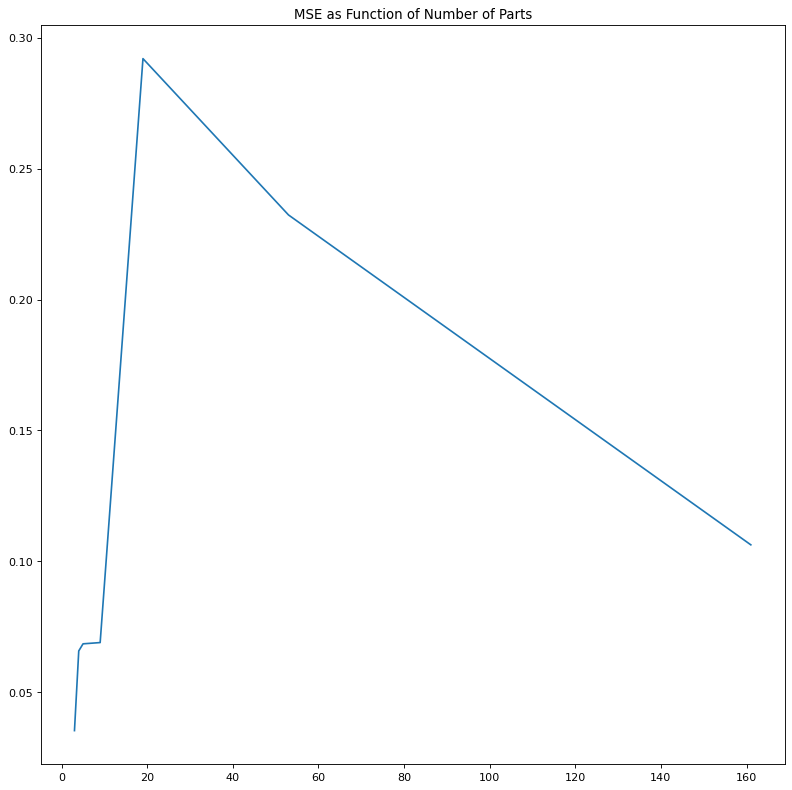

In [32]:
# sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("MSE as Function of Number of Parts")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,performance_Architope_history_report)


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_MSE.pdf', format='pdf')
plt.show()

In [ ]:
# # sns.set()
# # Initialize Plot #
# #-----------------#
# plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# # Format Plot #
# #-------------#
# plt.title("Training Time as Function of Number of Parts")

# # Generate Plots #
# #----------------#
# # Plot Signal
# plt.plot(N_parts_Generated_by_Algo_2_history,(Architope_Model_Complexity_history[1,1,:]))


# # Export #
# #--------#
# # SAVE Figure to .eps
# plt.savefig('./outputs/plotsANDfigures/Ablation_Train_Time.pdf', format='pdf')
# plt.show()

---
# Fin
---